# Using computed solutions to accelerate run time of GMRES

### Underlying idea

The underlying idea here is to use neural networks to interpolate converged solutions to provide initial guesses that are good guesses and lead to a speed up of GMRES. 

To be precise we consider problems of the form:
$$\mathbf{A}x=b$$
where $\mathbf{A} \in \mathbb{R}^{n\times n}$ and $x,b \in \mathbb{R}^n$

As with all iterative methods, we will start iterating with some iniital guess $x_o$. Depending on the properties of this guess, we can converge to a solution in fewer GMRES iterations. 



The underlying idea here is that we can train a Neural Network $N$ on a set of examples $\{x_i,b_i\}_{i=0}^m$ such that when provided a particular RHS $b'$ for our linear problem, we get an informed initial guess $x_o=N(b')$. 

In the parlance of machine learning, $\{x_i,b_i\}_{i=0}^m$ is our training set and the data corresponding to $m+1$th linear problem is our test set. We use $X_0=N(b_m)$ to solve  the $m+1$th linear problem. Then, we add the current test problem to our training set so that training set it is now augemented as $\{x_i,b_i\}_{i=0}^{m+1}$. $N$ is then retrained on this slightly differeent training set. 

### Summary and comments on an initial implementation

While in principle this idea is simple, early prototyping revealed some features that should be noted before some results for more refined iterations of this idea  are discussed. 

The initial implementation of this idea consisted of using a simple fully conencted network with one hidden layer of dimension $n$  with a ReLU activation function. As implied above, we note that the input dimension of the network is $n$ and the output dimension is $n$. 

- It was generally found that increasing the number of hidden layers did not contribute to the effectiveness of the method.


- As the amount of data being collected grows, training time can dramatically grow but not necessarily the usefullness of the initial guesses provided by the network. 


- The above point hints at the possibility that in this online context, the quality of data can be much more important  than  usual since we value train time as highly as accuracy 


- As the dimensions of the simple problems were increased, this approach scaled poorly since fully connected networks are not parallelized as implemented in pytorch. Dimensions greater 100 became prohibitive to train once moderate data was accumulated


- It can take alot of data and "visted solutions" before initial guesses start to produce helpful initial solutions. On a small workstation, this amount can be prohibitive


### List of ideas used to address  limitations

- To be able to test ideas on a small workstation computer, the type of network was switched to a small CNN early on. This architecture scales much better and allowed experiments in the 100's of dimensions to be possible. As observed with fully conencted networks, making the CNN deep yielded little gains with an often substantial increase of training time. Ultimately, it seems since we are thinking of an online context, what matters the most is having a "lightweight" model that can be retrained/updated quickly to some acceptable not too low tolerance. This is to be contrasted with the usual need of needing a highly accurate model and not caring too much about train time. 


- The "value" of training data can be maintained in order to reduce training time. One particular approach used here is to train the model often, and reject adding data that has already been fit well.  Then, from the batch of data that had made the cut, further filtering that data down with some metric. This general practice that has shown some measure of sucess can essentially be explained as trying to optimize the "value" of each data  point in our test set. ltering data also seems to improve the conditioning of the underlying optimazation problem, which further speeds up train time.


-  In addition to trying to minimize solution of initial guesses using the data, other quantities can be optimized based on certain needs

### A Demonstrative Example

To illustrate the ideas discussed a simple  particular problem will be examined. We will be solving a series of linear problems using restarted GMRES and then using that data to train a CNN as we solve the series of linear problems. Here we will compare the neural network assisted GMRES and GMRES directly. 


Here, $A$ will be the 1D scalar discrete laplacian, and $b$ will be defined as a "moving localized source".

Explicitly, $b$ is a vector of values given by :

$$b=\frac{1}{\sigma\sqrt{2\pi }}\exp\left({-\frac{1}{2}\left(\frac{z-y_j}{\sigma}\right)^2}\right)$$
where $z$ is a grid of $[-5,5]$ and $y_j$ is given by:

$$y_j=4\sin\left(\frac{1}{2}j|\cos{\frac{1}{2}j}|\right), \quad, j=0,1,2,3,\dots$$

The series of problems will be strucured in the following way:

1. Set index $j$ through for loop

2. Compute $b_j$

3. Call GMRES function assisted with neural network (MLGMRES) and collect diagnostic data. MLGMRES runs once up to some tolerance $e_1$
4. The previous result is then refined by a second GMRES call  until tolerance $e2$ is reached. Depending on diagnostic data, this refined solution may be added to the training data set and the model may be retrained. Note $e_1<e_2$

5. Call GMRES  directly and collect diagnostic data. Two calls are made. The first call converges up to tolerance $e_1$, and the second call then refines the solution to tolerance $e_2$. Then go to 1 

#### Some implementation updates

 - Minor changes have been made to pytorch API code. It has been written in such a way that the code should (hopefully) be device agnostic. Note that no memory optimizations of any sort have been preformed.  
 
 - The retrain method now either completes a large number of steps or stops once given tolerance is reached. Code:
 
   @timer
    def retrain_timed(self):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.loss_val = list()  # clear loss val history
        self.loss_val.append(10.0)
        t=0
        e1=1e-3
        while self.loss_val[-1]> e1 and t<self.n_steps:
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = self.model(self.x.to(device))

            # Compute and print loss
            loss = self.criterion(y_pred, self.y.to(device))
            self.loss_val.append(loss.item())

            # Zero gradients, perform a backward pass, and update the weights.
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            print('loss:',loss.item(),t)
            t=t+1

        print('Final loss:',loss.item(),t)
        # numparams=sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        # print('parameters',numparams)
        self.is_trained = True

- The optimizer has been changed to Adam algorithm. It simply performs better for our problem, but the details of methods and convergence ( as well as better online methods) will be touched on later. With this, we can get away with a larger learning rate. Code:

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)


- The network has been set up so that we minimize the number of parameters (while still having enough), while trying to try to maximally parallelize this naive implementation. Pytorch parallelizes along the channel dimension, so the network uses a massive kernel (size $n$, so out puts are of  length 1) and many channels ($n$ of them). This implementation doesn't use an output linear layer which would use alot of resources. We simply reshape the linear 1d conv. output of length 1 and $n$ channel dimensions as an array of dimension $n$.   Code:


constructor lines:

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.Conv1   = torch.nn.Conv1d(1,int(H),D_in, stride=1, padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros').to(device)
        
        self.Conv2   = torch.nn.Conv1d(int(H),D_in,1, stride=1, padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros').to(device)
        
        self.relu   = torch.nn.LeakyReLU().to(device)
        
        
forward function:
        Current_batchsize=int(x.shape[0])  # N in pytorch docs
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x2=x.unsqueeze(1)  # Add channel dimension (C) to input 
        
        ConvOut1=self.relu(self.Conv1(x2.to(device)))
        
        ConvOut2=self.Conv2(ConvOut1) 
        
        y_pred = ConvOut2.view(Current_batchsize, -1) 

- As mentioned, without more serious computing power than a  laptop ( at least more than an Intel i7 6 core laptop with a modest Nvidia GPU), the training times quickly become unreasonable and we cannot proceede with testing these ideas on larger dimensions. While in practice we can expect much more computing  power, we can also expect massively more complex data. Thus, exploring some strategies to overcome these issues may be profitable for things to come. The solutions mentioned earlier ultimately come down to filtering data, and retraining the model often. The following ideas seemed to work best, but they often depend on the problem at hand. Ultimately, the good news here is that a flexible strategy can probably be found 


    - Use a high retrain frequency. This way, the model is already quite trained on the data set ( since the data set is only slightly altered) and can be trained quickly with a high learning rate. 
    
    
    - Only add data to the training set that is poorly fit by the model. For example, in the implementation used here, a moving average of the error of the neural network outputs is kept. If it does poorly in a particular case, data is added. If it does well, we do not add the data. Then, as the overall network outputs are improved, the moving average declines. 
    
    - Within the data that has made the cutoff and is in the  new batch that will be used to augment the training set, check that the data is sufficiently "different". For the case in the example presented here, since our solutions are rapidly spanning a space (due to considerably different RHS $n$ provided at different iterations), checking orthogonality is useful. However, if solutions are only changing slighly, an idea may be to check that their 1-norm difference is large enough. Eitherway, a context dependent approach to checking the "spread" of the batch that will augment the training set is quite useful for not prematurely bloating the training set( where such bloating is a concern) 
    
    - Another filter that I have had success with is to only add data when the solver time took longer than the running average. 
    
The underlying idea here is to carefully use our solution space as a basis to reduce error gradually and speedup calculations gradually rather than brute force accumulation of data and waiting for the big pay off later in the simulation. Next, these ideas are demonstrated. It is important to keep in mind that without these refinements, problems of $n>100$ could not reasonably run on (kevin's) hardware and would take hours to train (eventhough the problem itself takes 5 minures to run). 

#### Implemtation Example (logging stuff removed for brevity) 

$n=150$ example 

MLGMRES is set to optimize error as described above (10th iteration of GMRES) and run time as described above. So, solution data is added only when a particular run does poorer than the running average of these metrics. 

500 $b_i$ considered. 

In [1]:
from src_dir import *
import numpy as np
import matplotlib.pyplot as pp

In [17]:

dim=150
x0=np.squeeze(np.zeros((dim,1))) #1d array of zeros

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat  #1D scalar laplacian

retrain_freq=1 # Actually 3 behind the scenes
e1 = 1e-6 # first tolerance
e2 = 1e-10 # refinement tolerance
nmax_iter = 50  
restart   = 64

sigma=0.02  # spread of local source
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)  #Domain


n_steps =500   # number of problem iterations
InputDim=dim   # dimensions of input layer
HiddenDim=dim   # number of output channels in first conv
HiddenDim2=dim  # Kernel size for first layer and input channel dimension for second conv. layer. 
OutputDim=dim # dimensions of output layer (output of 1D Conv. Channel dimension before being falttened)

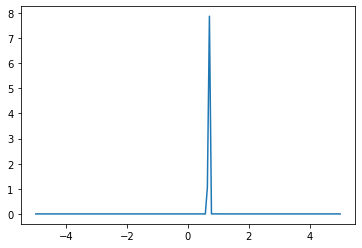

In [22]:
loc=4*np.sin(0.5*6*np.abs(np.cos(0.5*6)))
b=Gauss_pdf(x,loc,sigma)
pp.plot(x,b)

In [4]:

# Timed versions of both GMRES functions

@timer
@nn_preconditioner_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,Err_list,ProbCount,restart,debug,refine,blist,reslist,IterErrList10,GmresRunTime):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [24]:
# Primary experiment comparison loop

Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]
NonML_Time_List=[]

debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]
x=np.linspace(DomainL,DomainR,dim)



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    NonML_Time_List.append(run_time1)
    
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


print("Runtime of Non-decorated version is:",run_time)

print("Runtime of MLGMRES decorator is:",run_time_ML)

print("Runtime of training (backprop) is:",trainTime_total)

print("Runtime of forward function is:",forwardTime_Total)

0
1
2
loss: 405159.03125 0
loss: 404234.96875 1
loss: 403017.4375 2
loss: 401335.21875 3
loss: 399110.4375 4
loss: 396284.84375 5
loss: 392772.46875 6
loss: 388506.3125 7
loss: 383436.8125 8
loss: 377481.125 9
loss: 370613.0 10
loss: 362810.09375 11
loss: 354076.125 12
loss: 344413.75 13
loss: 333855.09375 14
loss: 322434.71875 15
loss: 310177.25 16
loss: 297158.1875 17
loss: 283431.5625 18
loss: 269077.59375 19
loss: 254189.859375 20
loss: 238864.265625 21
loss: 223219.28125 22
loss: 207378.0 23
loss: 191470.453125 24
loss: 175628.015625 25
loss: 159990.71875 26
loss: 144703.28125 27
loss: 129908.546875 28
loss: 115744.390625 29
loss: 102339.7421875 30
loss: 89810.859375 31
loss: 78257.0703125 32
loss: 67756.9296875 33
loss: 58365.17578125 34
loss: 50109.42578125 35
loss: 42987.68359375 36
loss: 36968.03515625 37
loss: 31990.2421875 38
loss: 27968.6171875 39
loss: 24795.755859375 40
loss: 22348.384765625 41
loss: 20495.38671875 42
loss: 19105.96484375 43
loss: 18056.453125 44
loss: 17

loss: 1.3297466039657593 331
loss: 1.2848901748657227 332
loss: 1.2415416240692139 333
loss: 1.1996287107467651 334
loss: 1.159050703048706 335
loss: 1.1198450326919556 336
loss: 1.0819350481033325 337
loss: 1.0452830791473389 338
loss: 1.0098108053207397 339
loss: 0.9755171537399292 340
loss: 0.9423985481262207 341
loss: 0.9103705286979675 342
loss: 0.8793913125991821 343
loss: 0.8494300842285156 344
loss: 0.8204847574234009 345
loss: 0.7925233244895935 346
loss: 0.7654706239700317 347
loss: 0.7393436431884766 348
loss: 0.7140710353851318 349
loss: 0.6896466612815857 350
loss: 0.6660670042037964 351
loss: 0.6432526111602783 352
loss: 0.6212060451507568 353
loss: 0.5998960137367249 354
loss: 0.5793206691741943 355
loss: 0.5594199895858765 356
loss: 0.540210485458374 357
loss: 0.5216366648674011 358
loss: 0.5036947727203369 359
loss: 0.4863646626472473 360
loss: 0.4696071445941925 361
loss: 0.4534342288970947 362
loss: 0.4377869963645935 363
loss: 0.42268800735473633 364
loss: 0.4081022

loss: 67.48495483398438 81
loss: 63.75871276855469 82
loss: 60.447391510009766 83
loss: 57.5615234375 84
loss: 55.064083099365234 85
loss: 52.887508392333984 86
loss: 50.94804382324219 87
loss: 49.162349700927734 88
loss: 47.45969772338867 89
loss: 45.78885269165039 90
loss: 44.12371826171875 91
loss: 42.46034622192383 92
loss: 40.814266204833984 93
loss: 39.21144104003906 94
loss: 37.682098388671875 95
loss: 36.253055572509766 96
loss: 34.94392776489258 97
loss: 33.76350784301758 98
loss: 32.71003723144531 99
loss: 31.77250862121582 100
loss: 30.93328285217285 101
loss: 30.172033309936523 102
loss: 29.46843719482422 103
loss: 28.805376052856445 104
loss: 28.17049217224121 105
loss: 27.55621910095215 106
loss: 26.959821701049805 107
loss: 26.381990432739258 108
loss: 25.82606315612793 109
loss: 25.29611587524414 110
loss: 24.79586410522461 111
loss: 24.327730178833008 112
loss: 23.89237403869629 113
loss: 23.488338470458984 114
loss: 23.112707138061523 115
loss: 22.76176643371582 116
l

loss: 0.39650702476501465 412
loss: 0.3898197114467621 413
loss: 0.38306474685668945 414
loss: 0.3761012852191925 415
loss: 0.3690102696418762 416
loss: 0.3620017468929291 417
loss: 0.35522738099098206 418
loss: 0.34879714250564575 419
loss: 0.34265559911727905 420
loss: 0.33665740489959717 421
loss: 0.33070501685142517 422
loss: 0.3247182071208954 423
loss: 0.3187252879142761 424
loss: 0.3127881586551666 425
loss: 0.30699628591537476 426
loss: 0.3013797700405121 427
loss: 0.29594698548316956 428
loss: 0.2906557321548462 429
loss: 0.2854415774345398 430
loss: 0.2802865207195282 431
loss: 0.2751842737197876 432
loss: 0.2701302766799927 433
loss: 0.26515546441078186 434
loss: 0.2602728009223938 435
loss: 0.25550931692123413 436
loss: 0.25085172057151794 437
loss: 0.24629613757133484 438
loss: 0.24184007942676544 439
loss: 0.23745056986808777 440
loss: 0.23311732709407806 441
loss: 0.22886347770690918 442
loss: 0.22465431690216064 443
loss: 0.22053688764572144 444
loss: 0.2164807915687561

loss: 0.0019870337564498186 706
loss: 0.0019535517785698175 707
loss: 0.0019201247487217188 708
loss: 0.0018871454522013664 709
loss: 0.001854606089182198 710
loss: 0.0018236853647977114 711
loss: 0.0017928078304976225 712
loss: 0.0017631091177463531 713
loss: 0.0017326418310403824 714
loss: 0.0017047612927854061 715
loss: 0.0016774998512119055 716
loss: 0.0016501026693731546 717
loss: 0.001625395379960537 718
loss: 0.0016020304756239057 719
loss: 0.0015818597748875618 720
loss: 0.0015638116747140884 721
loss: 0.0015511089004576206 722
loss: 0.0015443358570337296 723
loss: 0.0015477777924388647 724
loss: 0.0015657698968425393 725
loss: 0.0016067256219685078 726
loss: 0.0016814821865409613 727
loss: 0.0018092920072376728 728
loss: 0.002021575113758445 729
loss: 0.0023641299922019243 730
loss: 0.0029118568636476994 731
loss: 0.0037809512577950954 732
loss: 0.005141371861100197 733
loss: 0.007238237652927637 734
loss: 0.01037775631994009 735
loss: 0.014847388491034508 736
loss: 0.02068114

loss: 0.011722441762685776 248
loss: 0.011376497335731983 249
loss: 0.011040959507226944 250
loss: 0.010718894191086292 251
loss: 0.010403088293969631 252
loss: 0.010099807754158974 253
loss: 0.009805485606193542 254
loss: 0.009520857594907284 255
loss: 0.009242773987352848 256
loss: 0.008976982906460762 257
loss: 0.008716556243598461 258
loss: 0.008465728722512722 259
loss: 0.008222964592278004 260
loss: 0.007987347431480885 261
loss: 0.007757939398288727 262
loss: 0.007536403834819794 263
loss: 0.007322287652641535 264
loss: 0.007113314233720303 265
loss: 0.00691260164603591 266
loss: 0.006716630421578884 267
loss: 0.00652843015268445 268
loss: 0.006343022920191288 269
loss: 0.006166677922010422 270
loss: 0.0059940023347735405 271
loss: 0.005825618747621775 272
loss: 0.005663092248141766 273
loss: 0.00550542026758194 274
loss: 0.005354488734155893 275
loss: 0.00520512368530035 276
loss: 0.005061069503426552 277
loss: 0.004921298008412123 278
loss: 0.0047852396965026855 279
loss: 0.00

loss: 2.1117095947265625 198
loss: 2.0920536518096924 199
loss: 2.0725462436676025 200
loss: 2.053213596343994 201
loss: 2.034022808074951 202
loss: 2.0149424076080322 203
loss: 1.9960291385650635 204
loss: 1.9772577285766602 205
loss: 1.9585858583450317 206
loss: 1.9401237964630127 207
loss: 1.9217450618743896 208
loss: 1.903535008430481 209
loss: 1.88545823097229 210
loss: 1.8674821853637695 211
loss: 1.849653959274292 212
loss: 1.8319954872131348 213
loss: 1.81442129611969 214
loss: 1.7970025539398193 215
loss: 1.7796831130981445 216
loss: 1.7625387907028198 217
loss: 1.7455010414123535 218
loss: 1.72856867313385 219
loss: 1.7118000984191895 220
loss: 1.6951290369033813 221
loss: 1.6785826683044434 222
loss: 1.662194013595581 223
loss: 1.6459074020385742 224
loss: 1.6297667026519775 225
loss: 1.6137316226959229 226
loss: 1.5977851152420044 227
loss: 1.582008957862854 228
loss: 1.5663225650787354 229
loss: 1.5507566928863525 230
loss: 1.5353280305862427 231
loss: 1.5200092792510986 2

loss: 0.04163995757699013 505
loss: 0.040828146040439606 506
loss: 0.04022948071360588 507
loss: 0.03974171727895737 508
loss: 0.03918040916323662 509
loss: 0.03848566487431526 510
loss: 0.03775850683450699 511
loss: 0.03712094575166702 512
loss: 0.036592088639736176 513
loss: 0.03608270734548569 514
loss: 0.03552841767668724 515
loss: 0.034903090447187424 516
loss: 0.034296419471502304 517
loss: 0.033747900277376175 518
loss: 0.033247534185647964 519
loss: 0.03275753930211067 520
loss: 0.03222682699561119 521
loss: 0.03168249875307083 522
loss: 0.031151441857218742 523
loss: 0.03066442534327507 524
loss: 0.030198117718100548 525
loss: 0.02973143197596073 526
loss: 0.029255323112010956 527
loss: 0.028775552287697792 528
loss: 0.02830786444246769 529
loss: 0.02787521667778492 530
loss: 0.027456052601337433 531
loss: 0.02706155925989151 532
loss: 0.026678556576371193 533
loss: 0.026322847232222557 534
loss: 0.026038948446512222 535
loss: 0.02585884928703308 536
loss: 0.025849074125289917

21
0.6238525100052357 0.5310913626526599 0.3372705504559477 0.2815400787330485
22
0.48421991101349704 0.5355085601456396 0.08003542099012599 0.28419391071985317
23
0.69118125498062 0.5331772579123605 0.2768729544643123 0.274913979368502
24
0.5055807280004956 0.5400469969153283 0.27481274935106687 0.2749991521987546
25
0.3917322859924752 0.5386109023772102 0.05159589371651685 0.27499138541343426
26
0.5956870310183149 0.5327357577218208 0.28219744110905687 0.26605556574555755
InnerProd [[1.         0.90463016 0.84041711]
 [0.90463016 1.         0.69188148]
 [0.84041711 0.69188148 1.        ]]
retraining
15
loss: 153614.296875 0
loss: 141150.96875 1
loss: 120738.1953125 2
loss: 97796.7734375 3
loss: 75123.65625 4
loss: 54922.39453125 5
loss: 38398.6484375 6
loss: 25609.14453125 7
loss: 16339.5791015625 8
loss: 10454.2099609375 9
loss: 7696.63818359375 10
loss: 7442.47314453125 11
loss: 8786.009765625 12
loss: 10698.3798828125 13
loss: 12362.3212890625 14
loss: 13253.1728515625 15
loss: 13

loss: 1.2867249250411987 290
loss: 1.3028985261917114 291
loss: 1.3288172483444214 292
loss: 1.358245849609375 293
loss: 1.3738327026367188 294
loss: 1.3514374494552612 295
loss: 1.2817975282669067 296
loss: 1.1927677392959595 297
loss: 1.13364839553833 298
loss: 1.128659725189209 299
loss: 1.157053828239441 300
loss: 1.1755993366241455 301
loss: 1.1551727056503296 302
loss: 1.1049516201019287 303
loss: 1.0617698431015015 304
loss: 1.050941824913025 305
loss: 1.0626214742660522 306
loss: 1.0672450065612793 307
loss: 1.0476176738739014 308
loss: 1.014129877090454 309
loss: 0.9901648759841919 310
loss: 0.9855365753173828 311
loss: 0.988631546497345 312
loss: 0.9823575615882874 313
loss: 0.9630019068717957 314
loss: 0.9420183300971985 315
loss: 0.9314889311790466 316
loss: 0.9315209984779358 317
loss: 0.9332452416419983 318
loss: 0.9309121370315552 319
loss: 0.9290841221809387 320
loss: 0.9378868937492371 321
loss: 0.9627914428710938 322
loss: 0.9987075328826904 323
loss: 1.03019702434539

loss: 0.06651312857866287 571
loss: 0.11234531551599503 572
loss: 0.1695011556148529 573
loss: 0.17985641956329346 574
loss: 0.13429634273052216 575
loss: 0.07528085261583328 576
loss: 0.05252928286790848 577
loss: 0.07425545156002045 578
loss: 0.10579705983400345 579
loss: 0.1098555251955986 580
loss: 0.08237222582101822 581
loss: 0.051410336047410965 582
loss: 0.044284652918577194 583
loss: 0.06000545993447304 584
loss: 0.07525528222322464 585
loss: 0.07171227037906647 586
loss: 0.05347899720072746 587
loss: 0.03906281664967537 588
loss: 0.03992363438010216 589
loss: 0.05010183900594711 590
loss: 0.05556216463446617 591
loss: 0.049885623157024384 592
loss: 0.03924819827079773 593
loss: 0.03373898193240166 594
loss: 0.0364115871489048 595
loss: 0.04162663221359253 596
loss: 0.042474061250686646 597
loss: 0.037897057831287384 598
loss: 0.03250502794981003 599
loss: 0.030780017375946045 600
loss: 0.03272002935409546 601
loss: 0.034792300313711166 602
loss: 0.03418121114373207 603
loss: 

loss: 0.01121550239622593 852
loss: 0.017571967095136642 853
loss: 0.018193788826465607 854
loss: 0.014889385551214218 855
loss: 0.013821395114064217 856
loss: 0.018928535282611847 857
loss: 0.028962066397070885 858
loss: 0.04022315889596939 859
loss: 0.05100725591182709 860
loss: 0.06283443421125412 861
loss: 0.07749433070421219 862
loss: 0.09311915934085846 863
loss: 0.10326704382896423 864
loss: 0.10038958489894867 865
loss: 0.08166084438562393 866
loss: 0.052832458168268204 867
loss: 0.02608361281454563 868
loss: 0.012626683339476585 869
loss: 0.016233403235673904 870
loss: 0.032724037766456604 871
loss: 0.05416613444685936 872
loss: 0.07354865968227386 873
loss: 0.08762236684560776 874
loss: 0.09745646268129349 875
loss: 0.10632598400115967 876
loss: 0.11535318195819855 877
loss: 0.12015911936759949 878
loss: 0.11282826960086823 879
loss: 0.08946538716554642 880
loss: 0.05661670118570328 881
loss: 0.02864750288426876 882
loss: 0.017667187377810478 883
loss: 0.026007845997810364 88

loss: 0.3438223600387573 1154
loss: 0.34418052434921265 1155
loss: 0.37676846981048584 1156
loss: 0.41078999638557434 1157
loss: 0.421966552734375 1158
loss: 0.40768328309059143 1159
loss: 0.3884059488773346 1160
loss: 0.384868323802948 1161
loss: 0.3954170346260071 1162
loss: 0.40312328934669495 1163
loss: 0.39636221528053284 1164
loss: 0.3731347918510437 1165
loss: 0.33433210849761963 1166
loss: 0.28318873047828674 1167
loss: 0.22940637171268463 1168
loss: 0.19036829471588135 1169
loss: 0.18545910716056824 1170
loss: 0.22408327460289001 1171
loss: 0.2965494692325592 1172
loss: 0.37667834758758545 1173
loss: 0.43311285972595215 1174
loss: 0.4391481280326843 1175
loss: 0.3804592490196228 1176
loss: 0.2696533501148224 1177
loss: 0.15566612780094147 1178
loss: 0.09595074504613876 1179
loss: 0.10748439282178879 1180
loss: 0.156235933303833 1181
loss: 0.19210121035575867 1182
loss: 0.1885800063610077 1183
loss: 0.16003547608852386 1184
loss: 0.1442064642906189 1185
loss: 0.1619961261749267

loss: 0.11580776423215866 1468
loss: 0.1101314127445221 1469
loss: 0.12313970178365707 1470
loss: 0.14962336421012878 1471
loss: 0.17737837135791779 1472
loss: 0.19377662241458893 1473
loss: 0.1931610405445099 1474
loss: 0.18093208968639374 1475
loss: 0.1707654446363449 1476
loss: 0.17612220346927643 1477
loss: 0.20193007588386536 1478
loss: 0.24146349728107452 1479
loss: 0.27893152832984924 1480
loss: 0.2957811951637268 1481
loss: 0.2786823511123657 1482
loss: 0.22654905915260315 1483
loss: 0.15362565219402313 1484
loss: 0.08638668060302734 1485
loss: 0.052033714950084686 1486
loss: 0.06154604256153107 1487
loss: 0.10125865787267685 1488
loss: 0.14252613484859467 1489
loss: 0.16119740903377533 1490
loss: 0.1526719331741333 1491
loss: 0.13438983261585236 1492
loss: 0.1339104175567627 1493
loss: 0.16902370750904083 1494
loss: 0.23446598649024963 1495
loss: 0.3053532540798187 1496
loss: 0.35434818267822266 1497
loss: 0.3716229200363159 1498
loss: 0.3733806014060974 1499
loss: 0.388027429

loss: 0.07518994808197021 1772
loss: 0.09520784765481949 1773
loss: 0.11268939077854156 1774
loss: 0.12499463558197021 1775
loss: 0.1332477331161499 1776
loss: 0.14071373641490936 1777
loss: 0.15016020834445953 1778
loss: 0.16172628104686737 1779
loss: 0.1725592315196991 1780
loss: 0.1783512830734253 1781
loss: 0.17582456767559052 1782
loss: 0.1647326797246933 1783
loss: 0.1483340561389923 1784
loss: 0.132178395986557 1785
loss: 0.12204091995954514 1786
loss: 0.12208753824234009 1787
loss: 0.13373973965644836 1788
loss: 0.15496699512004852 1789
loss: 0.17981435358524323 1790
loss: 0.19909876585006714 1791
loss: 0.20404641330242157 1792
loss: 0.19265006482601166 1793
loss: 0.17357823252677917 1794
loss: 0.16151943802833557 1795
loss: 0.16639330983161926 1796
loss: 0.1866864264011383 1797
loss: 0.21211667358875275 1798
loss: 0.23130455613136292 1799
loss: 0.23852302134037018 1800
loss: 0.2370305210351944 1801
loss: 0.23804371058940887 1802
loss: 0.25528571009635925 1803
loss: 0.297318398

loss: 0.44324639439582825 2050
loss: 0.3703427016735077 2051
loss: 0.3256911635398865 2052
loss: 0.32137417793273926 2053
loss: 0.34444817900657654 2054
loss: 0.3698759973049164 2055
loss: 0.3754766881465912 2056
loss: 0.35189110040664673 2057
loss: 0.305938720703125 2058
loss: 0.25443515181541443 2059
loss: 0.21231608092784882 2060
loss: 0.1855407953262329 2061
loss: 0.17245060205459595 2062
loss: 0.16902537643909454 2063
loss: 0.17235565185546875 2064
loss: 0.17964307963848114 2065
loss: 0.18510110676288605 2066
loss: 0.18051880598068237 2067
loss: 0.16105607151985168 2068
loss: 0.13094541430473328 2069
loss: 0.10306765139102936 2070
loss: 0.09218848496675491 2071
loss: 0.106633260846138 2072
loss: 0.14360898733139038 2073
loss: 0.1899024397134781 2074
loss: 0.2261444330215454 2075
loss: 0.2327944040298462 2076
loss: 0.19896924495697021 2077
loss: 0.13343846797943115 2078
loss: 0.066569983959198 2079
loss: 0.0318543016910553 2080
loss: 0.04055149108171463 2081
loss: 0.075462646782398

loss: 0.2702285945415497 2348
loss: 0.26596829295158386 2349
loss: 0.26030683517456055 2350
loss: 0.2576538324356079 2351
loss: 0.26234522461891174 2352
loss: 0.27799394726753235 2353
loss: 0.3059922456741333 2354
loss: 0.3440733551979065 2355
loss: 0.38597261905670166 2356
loss: 0.4228125512599945 2357
loss: 0.4452965259552002 2358
loss: 0.446283757686615 2359
loss: 0.423109233379364 2360
loss: 0.37929442524909973 2361
loss: 0.32419538497924805 2362
loss: 0.2704213857650757 2363
loss: 0.22989830374717712 2364
loss: 0.21059560775756836 2365
loss: 0.2147558033466339 2366
loss: 0.2386140674352646 2367
loss: 0.2730395793914795 2368
loss: 0.3048582971096039 2369
loss: 0.31932327151298523 2370
loss: 0.304851770401001 2371
loss: 0.2597525417804718 2372
loss: 0.19640479981899261 2373
loss: 0.13715676963329315 2374
loss: 0.10260078310966492 2375
loss: 0.10084030777215958 2376
loss: 0.12506642937660217 2377
loss: 0.15937383472919464 2378
loss: 0.18792597949504852 2379
loss: 0.20259201526641846 

loss: 0.0782502144575119 2633
loss: 0.08038291335105896 2634
loss: 0.08124395459890366 2635
loss: 0.08193564414978027 2636
loss: 0.08294506371021271 2637
loss: 0.08365537226200104 2638
loss: 0.08269008994102478 2639
loss: 0.07888368517160416 2640
loss: 0.07225596159696579 2641
loss: 0.0643346831202507 2642
loss: 0.05765976384282112 2643
loss: 0.05482456833124161 2644
loss: 0.057664256542921066 2645
loss: 0.06693226099014282 2646
loss: 0.08251319080591202 2647
loss: 0.10394500941038132 2648
loss: 0.1310516893863678 2649
loss: 0.1644359529018402 2650
loss: 0.20575445890426636 2651
loss: 0.257515013217926 2652
loss: 0.32246071100234985 2653
loss: 0.40230581164360046 2654
loss: 0.4962892234325409 2655
loss: 0.5994747281074524 2656
loss: 0.7022237777709961 2657
loss: 0.7906862497329712 2658
loss: 0.8499338626861572 2659
loss: 0.8671347498893738 2660
loss: 0.8353922963142395 2661
loss: 0.755120038986206 2662
loss: 0.6363573670387268 2663
loss: 0.4991281032562256 2664
loss: 0.3715879023075104

loss: 0.3689398169517517 2911
loss: 0.2382962852716446 2912
loss: 0.15980008244514465 2913
loss: 0.14807525277137756 2914
loss: 0.18542268872261047 2915
loss: 0.2354881763458252 2916
loss: 0.26367467641830444 2917
loss: 0.2533501982688904 2918
loss: 0.2100697010755539 2919
loss: 0.15481369197368622 2920
loss: 0.11123910546302795 2921
loss: 0.09400134533643723 2922
loss: 0.10284505039453506 2923
loss: 0.12485920637845993 2924
loss: 0.14272183179855347 2925
loss: 0.14378932118415833 2926
loss: 0.12559083104133606 2927
loss: 0.09557762742042542 2928
loss: 0.06620854139328003 2929
loss: 0.04828687757253647 2930
loss: 0.04639563709497452 2931
loss: 0.0582638755440712 2932
loss: 0.07744286209344864 2933
loss: 0.09700428694486618 2934
loss: 0.11208252608776093 2935
loss: 0.12036102265119553 2936
loss: 0.12095105648040771 2937
loss: 0.11332716047763824 2938
loss: 0.09758656471967697 2939
loss: 0.07593435049057007 2940
loss: 0.0534459725022316 2941
loss: 0.036557406187057495 2942
loss: 0.029972

loss: 0.11715200543403625 3208
loss: 0.12306279689073563 3209
loss: 0.11144151538610458 3210
loss: 0.08695970475673676 3211
loss: 0.06123730167746544 3212
loss: 0.04419482499361038 3213
loss: 0.03803027793765068 3214
loss: 0.037865523248910904 3215
loss: 0.03719116002321243 3216
loss: 0.03286021947860718 3217
loss: 0.026189809665083885 3218
loss: 0.02042381465435028 3219
loss: 0.01751193217933178 3220
loss: 0.016952430829405785 3221
loss: 0.0170123428106308 3222
loss: 0.016618793830275536 3223
loss: 0.016101447865366936 3224
loss: 0.01644868776202202 3225
loss: 0.018078310415148735 3226
loss: 0.02031911537051201 3227
loss: 0.021928178146481514 3228
loss: 0.022051148116588593 3229
loss: 0.020775524899363518 3230
loss: 0.018937144428491592 3231
loss: 0.017461365088820457 3232
loss: 0.01682828739285469 3233
loss: 0.01698523946106434 3234
loss: 0.01762372814118862 3235
loss: 0.018488043919205666 3236
loss: 0.019499516114592552 3237
loss: 0.020673034712672234 3238
loss: 0.022014090791344643

loss: 0.023542651906609535 3541
loss: 0.017542751505970955 3542
loss: 0.018314601853489876 3543
loss: 0.024146340787410736 3544
loss: 0.03240003064274788 3545
loss: 0.0405924916267395 3546
loss: 0.047066912055015564 3547
loss: 0.051250312477350235 3548
loss: 0.053463418036699295 3549
loss: 0.054501548409461975 3550
loss: 0.055042564868927 3551
loss: 0.05521012842655182 3552
loss: 0.05442804843187332 3553
loss: 0.051779069006443024 3554
loss: 0.046728093177080154 3555
loss: 0.03981815278530121 3556
loss: 0.03286641836166382 3557
loss: 0.028463002294301987 3558
loss: 0.029158832505345345 3559
loss: 0.036870017647743225 3560
loss: 0.05281978100538254 3561
loss: 0.07770276069641113 3562
loss: 0.11150003969669342 3563
loss: 0.15213267505168915 3564
loss: 0.1929093599319458 3565
loss: 0.2206059843301773 3566
loss: 0.21973367035388947 3567
loss: 0.18607716262340546 3568
loss: 0.1385277956724167 3569
loss: 0.10868220776319504 3570
loss: 0.1131838709115982 3571
loss: 0.1397857367992401 3572
los

loss: 7.92927360534668 3834
loss: 7.352564811706543 3835
loss: 6.5117387771606445 3836
loss: 5.49264669418335 3837
loss: 4.246161937713623 3838
loss: 2.892496109008789 3839
loss: 1.7097446918487549 3840
loss: 1.0216301679611206 3841
loss: 0.9655770659446716 3842
loss: 1.4044241905212402 3843
loss: 2.004209280014038 3844
loss: 2.381808042526245 3845
loss: 2.298361301422119 3846
loss: 1.7597057819366455 3847
loss: 1.0312962532043457 3848
loss: 0.4574096202850342 3849
loss: 0.2603437006473541 3850
loss: 0.4275036156177521 3851
loss: 0.7594208717346191 3852
loss: 1.0108039379119873 3853
loss: 1.024834394454956 3854
loss: 0.806160032749176 3855
loss: 0.4856163561344147 3856
loss: 0.22837121784687042 3857
loss: 0.13164196908473969 3858
loss: 0.18734736740589142 3859
loss: 0.3106297552585602 3860
loss: 0.4037836492061615 3861
loss: 0.41176092624664307 3862
loss: 0.33964622020721436 3863
loss: 0.23518390953540802 3864
loss: 0.15027204155921936 3865
loss: 0.11260151118040085 3866
loss: 0.117109

loss: 278.1751403808594 41
loss: 292.1945495605469 42
loss: 283.1819152832031 43
loss: 256.41162109375 44
loss: 219.31744384765625 45
loss: 176.02769470214844 46
loss: 134.3611602783203 47
loss: 94.46318054199219 48
loss: 68.62511444091797 49
loss: 48.654239654541016 50
loss: 41.88838195800781 51
loss: 40.48106384277344 52
loss: 43.0963249206543 53
loss: 48.369606018066406 54
loss: 52.540443420410156 55
loss: 55.195068359375 56
loss: 56.49690628051758 57
loss: 54.63484573364258 58
loss: 49.250877380371094 59
loss: 43.18252944946289 60
loss: 34.53291320800781 61
loss: 27.860567092895508 62
loss: 20.19291114807129 63
loss: 15.562165260314941 64
loss: 11.414407730102539 65
loss: 9.592974662780762 66
loss: 8.49776840209961 67
loss: 8.870728492736816 68
loss: 9.619940757751465 69
loss: 10.552206993103027 70
loss: 11.240944862365723 71
loss: 11.3407621383667 72
loss: 10.99862003326416 73
loss: 10.171445846557617 74
loss: 8.966214179992676 75
loss: 7.47634220123291 76
loss: 5.901053428649902 

37
0.3446114489925094 0.5033906466851477 0.0810328450988541 0.22546461980508006
38
0.6103591700084507 0.4989801134159077 0.2892161139278231 0.22145262606324045
39
0.5201502819836605 0.5033109496103457 0.0380806455835198 0.2216765445199248
40
0.4323661540111061 0.5037660667015164 0.07300816458353702 0.21671449319731925
41
0.6014456620032433 0.5018871216307161 0.3302811232731464 0.21293274770748288
42
0.11249742901418358 0.5044399047171912 0.0014374593966212648 0.21594168041429476
43
0.34405436101951636 0.494641342824616 0.03621181680731147 0.21057907488885289
44
0.5079982180031948 0.49096848960985745 0.07982387718424501 0.20632621493564454
45
0.6220415310235694 0.49137395933350836 0.2926810790045736 0.20331425451299218
InnerProd [[1.         0.81730238 0.94533993]
 [0.81730238 1.         0.92149601]
 [0.94533993 0.92149601 1.        ]]
retraining
19
loss: 102870.640625 0
loss: 96394.28125 1
loss: 85077.1171875 2
loss: 71660.6953125 3
loss: 57434.81640625 4
loss: 43678.1875 5
loss: 31317

loss: 0.1699996292591095 267
loss: 0.35387882590293884 268
loss: 0.5984894633293152 269
loss: 0.7708978652954102 270
loss: 0.7958476543426514 271
loss: 0.6725568771362305 272
loss: 0.46282657980918884 273
loss: 0.25101205706596375 274
loss: 0.10676755756139755 275
loss: 0.05928220599889755 276
loss: 0.09546653181314468 277
loss: 0.1752062886953354 278
loss: 0.2530940771102905 279
loss: 0.2963809072971344 280
loss: 0.29255369305610657 281
loss: 0.24852682650089264 282
loss: 0.18232059478759766 283
loss: 0.11481112986803055 284
loss: 0.062284473329782486 285
loss: 0.03334204852581024 286
loss: 0.028473008424043655 287
loss: 0.04194341227412224 288
loss: 0.0645981878042221 289
loss: 0.0868048146367073 290
loss: 0.10097892582416534 291
loss: 0.10305286198854446 292
loss: 0.09307482838630676 293
loss: 0.07434867322444916 294
loss: 0.05209014192223549 295
loss: 0.03156222403049469 296
loss: 0.016696354374289513 297
loss: 0.009224961511790752 298
loss: 0.008698851801455021 299
loss: 0.0131021

loss: 0.06634443253278732 573
loss: 0.1386532187461853 574
loss: 0.22279715538024902 575
loss: 0.2915256917476654 576
loss: 0.32793381810188293 577
loss: 0.3270716071128845 578
loss: 0.29467716813087463 579
loss: 0.2415902465581894 580
loss: 0.18026095628738403 581
loss: 0.12109972536563873 582
loss: 0.07197336852550507 583
loss: 0.03753703832626343 584
loss: 0.019422847777605057 585
loss: 0.016270378604531288 586
loss: 0.02440929040312767 587
loss: 0.038993626832962036 588
loss: 0.05533918738365173 589
loss: 0.06994281709194183 590
loss: 0.08075807988643646 591
loss: 0.08699999749660492 592
loss: 0.08857451379299164 593
loss: 0.08585242927074432 594
loss: 0.07946392148733139 595
loss: 0.07043442875146866 596
loss: 0.059976931661367416 597
loss: 0.04938916116952896 598
loss: 0.03966293856501579 599
loss: 0.03137313574552536 600
loss: 0.024642588570713997 601
loss: 0.01934603974223137 602
loss: 0.015278805047273636 603
loss: 0.01232033409178257 604
loss: 0.01042519137263298 605
loss: 0.

loss: 0.028617406263947487 880
loss: 0.015734639018774033 881
loss: 0.0047285305336117744 882
loss: 0.0014079364482313395 883
loss: 0.005785062443464994 884
loss: 0.013234212063252926 885
loss: 0.018344556912779808 886
loss: 0.018489383161067963 887
loss: 0.01506476104259491 888
loss: 0.012099637649953365 889
loss: 0.01360243372619152 890
loss: 0.021636812016367912 891
loss: 0.03631258383393288 892
loss: 0.05734425410628319 893
loss: 0.08580021560192108 894
loss: 0.12451016157865524 895
loss: 0.17588292062282562 896
loss: 0.23657871782779694 897
loss: 0.2906242907047272 898
loss: 0.3082384169101715 899
loss: 0.2622532546520233 900
loss: 0.1598512977361679 901
loss: 0.05373600870370865 902
loss: 0.0036243004724383354 903
loss: 0.025495441630482674 904
loss: 0.0838233008980751 905
loss: 0.12402699887752533 906
loss: 0.11256734281778336 907
loss: 0.06079326197504997 908
loss: 0.012962219305336475 909
loss: 0.004168027080595493 910
loss: 0.03054055944085121 911
loss: 0.059288378804922104 9

loss: 7.229897499084473 234
loss: 6.304418087005615 235
loss: 5.00563907623291 236
loss: 3.5761044025421143 237
loss: 2.260453224182129 238
loss: 1.2772425413131714 239
loss: 0.729968249797821 240
loss: 0.6093389391899109 241
loss: 0.8110106587409973 242
loss: 1.1851359605789185 243
loss: 1.5833351612091064 244
loss: 1.8936625719070435 245
loss: 2.0619380474090576 246
loss: 2.0883381366729736 247
loss: 2.0199718475341797 248
loss: 1.922532558441162 249
loss: 1.8611148595809937 250
loss: 1.8770391941070557 251
loss: 1.9795844554901123 252
loss: 2.1486294269561768 253
loss: 2.3421995639801025 254
loss: 2.520918846130371 255
loss: 2.654417037963867 256
loss: 2.747096300125122 257
loss: 2.818026065826416 258
loss: 2.9088127613067627 259
loss: 3.036639928817749 260
loss: 3.203062057495117 261
loss: 3.357102870941162 262
loss: 3.436967372894287 263
loss: 3.3587045669555664 264
loss: 3.0820155143737793 265
loss: 2.6021289825439453 266
loss: 1.9905471801757812 267
loss: 1.3512886762619019 268


loss: 1.3924325704574585 555
loss: 0.7538072466850281 556
loss: 0.4104469418525696 557
loss: 0.4482775032520294 558
loss: 0.7010040879249573 559
loss: 0.915651798248291 560
loss: 0.9221785664558411 561
loss: 0.7168409824371338 562
loss: 0.43435415625572205 563
loss: 0.24133890867233276 564
loss: 0.21972224116325378 565
loss: 0.32312291860580444 566
loss: 0.427886039018631 567
loss: 0.4341200590133667 568
loss: 0.3350343406200409 569
loss: 0.20572558045387268 570
loss: 0.13110582530498505 571
loss: 0.13880954682826996 572
loss: 0.18922193348407745 573
loss: 0.21903866529464722 574
loss: 0.19542662799358368 575
loss: 0.13540761172771454 576
loss: 0.0825512558221817 577
loss: 0.06716828793287277 578
loss: 0.0852491483092308 579
loss: 0.10897031426429749 580
loss: 0.11325298994779587 581
loss: 0.09396102279424667 582
loss: 0.06505834311246872 583
loss: 0.043136149644851685 584
loss: 0.03489485755562782 585
loss: 0.036606889218091965 586
loss: 0.04134196415543556 587
loss: 0.044939886778593

loss: 58.9052619934082 49
loss: 49.7327880859375 50
loss: 42.906005859375 51
loss: 38.76066589355469 52
loss: 36.15723419189453 53
loss: 34.776222229003906 54
loss: 34.9356803894043 55
loss: 35.47773742675781 56
loss: 35.48297882080078 57
loss: 35.26142120361328 58
loss: 34.23750305175781 59
loss: 31.598920822143555 60
loss: 27.961271286010742 61
loss: 23.907564163208008 62
loss: 19.427749633789062 63
loss: 15.107855796813965 64
loss: 11.535354614257812 65
loss: 8.673828125 66
loss: 6.634741306304932 67
loss: 5.534014701843262 68
loss: 5.054483413696289 69
loss: 4.982285499572754 70
loss: 5.269132614135742 71
loss: 5.680020332336426 72
loss: 6.017439842224121 73
loss: 6.2009782791137695 74
loss: 6.128954887390137 75
loss: 5.84411096572876 76
loss: 5.469170570373535 77
loss: 4.9896979331970215 78
loss: 4.406083583831787 79
loss: 3.774620532989502 80
loss: 3.0624685287475586 81
loss: 2.3002407550811768 82
loss: 1.661827564239502 83
loss: 1.2427804470062256 84
loss: 1.0256327390670776 85


loss: 0.011211900040507317 360
loss: 0.0074054040014743805 361
loss: 0.004983936902135611 362
loss: 0.0038068683352321386 363
loss: 0.003650030819699168 364
loss: 0.004244166426360607 365
loss: 0.005309872329235077 366
loss: 0.006592326331883669 367
loss: 0.007890782319009304 368
loss: 0.009074106812477112 369
loss: 0.010079124942421913 370
loss: 0.01089926902204752 371
loss: 0.011562269181013107 372
loss: 0.012113474309444427 373
loss: 0.012601125985383987 374
loss: 0.013071956112980843 375
loss: 0.013568351045250893 376
loss: 0.014132445678114891 377
loss: 0.01480339840054512 378
loss: 0.015624936670064926 379
loss: 0.016643747687339783 380
loss: 0.017915785312652588 381
loss: 0.019505007192492485 382
loss: 0.02149658463895321 383
loss: 0.023998018354177475 384
loss: 0.027152596041560173 385
loss: 0.03114117868244648 386
loss: 0.03620443865656853 387
loss: 0.04264681786298752 388
loss: 0.0508793368935585 389
loss: 0.06143159791827202 390
loss: 0.07501653581857681 391
loss: 0.09255430

loss: 27.51482391357422 671
loss: 27.177566528320312 672
loss: 23.759395599365234 673
loss: 17.478303909301758 674
loss: 10.2850980758667 675
loss: 4.259053707122803 676
loss: 1.0602827072143555 677
loss: 0.9881905317306519 678
loss: 3.1386449337005615 679
loss: 5.990566253662109 680
loss: 8.0548095703125 681
loss: 8.491161346435547 682
loss: 7.178319931030273 683
loss: 4.835896015167236 684
loss: 2.4492745399475098 685
loss: 0.9019265174865723 686
loss: 0.5344488024711609 687
loss: 1.1313564777374268 688
loss: 2.137955665588379 689
loss: 2.958004951477051 690
loss: 3.2158045768737793 691
loss: 2.8287436962127686 692
loss: 2.020871162414551 693
loss: 1.1339877843856812 694
loss: 0.4877212345600128 695
loss: 0.23978181183338165 696
loss: 0.36732396483421326 697
loss: 0.7132851481437683 698
loss: 1.0697476863861084 699
loss: 1.2672781944274902 700
loss: 1.224651575088501 701
loss: 0.9730526208877563 702
loss: 0.6162784695625305 703
loss: 0.2878530025482178 704
loss: 0.09004569798707962 7

loss: 1.599308967590332 982
loss: 1.8463983535766602 983
loss: 1.4856055974960327 984
loss: 0.8033288717269897 985
loss: 0.2229238897562027 986
loss: 0.028785528615117073 987
loss: 0.22012640535831451 988
loss: 0.5734356045722961 989
loss: 0.821742594242096 990
loss: 0.8152183294296265 991
loss: 0.5850831866264343 992
loss: 0.28195473551750183 993
loss: 0.06949525326490402 994
loss: 0.028185410425066948 995
loss: 0.13028767704963684 996
loss: 0.2783513069152832 997
loss: 0.3720569908618927 998
loss: 0.36228230595588684 999
loss: 0.26403698325157166 1000
loss: 0.1362936943769455 1001
loss: 0.041190002113580704 1002
loss: 0.012756814248859882 1003
loss: 0.04562241584062576 1004
loss: 0.10606145113706589 1005
loss: 0.15444108843803406 1006
loss: 0.16525299847126007 1007
loss: 0.13656389713287354 1008
loss: 0.08549584448337555 1009
loss: 0.03663863614201546 1010
loss: 0.008811972104012966 1011
loss: 0.007822291925549507 1012
loss: 0.02655007503926754 1013
loss: 0.050883881747722626 1014
lo

loss: 0.04169014096260071 223
loss: 0.0733661875128746 224
loss: 0.15594621002674103 225
loss: 0.22553277015686035 226
loss: 0.24703750014305115 227
loss: 0.23774771392345428 228
loss: 0.23891916871070862 229
loss: 0.2663153409957886 230
loss: 0.2914420962333679 231
loss: 0.270676851272583 232
loss: 0.19121690094470978 233
loss: 0.08852917701005936 234
loss: 0.018035460263490677 235
loss: 0.010076602920889854 236
loss: 0.05102146416902542 237
loss: 0.10067187994718552 238
loss: 0.1234407126903534 239
loss: 0.10881181061267853 240
loss: 0.07160980999469757 241
loss: 0.03691454976797104 242
loss: 0.022353706881403923 243
loss: 0.029836101457476616 244
loss: 0.04971228167414665 245
loss: 0.07038083672523499 246
loss: 0.08512294292449951 247
loss: 0.09402615576982498 248
loss: 0.10279319435358047 249
loss: 0.11957073956727982 250
loss: 0.15035036206245422 251
loss: 0.19436879456043243 252
loss: 0.24138979613780975 253
loss: 0.2727808356285095 254
loss: 0.26846155524253845 255
loss: 0.21935

85
0.44959231599932536 0.4686972531422865 0.21403552637056303 0.17470037975018307
86
0.33698259099037386 0.4684554184949073 0.016701311227370456 0.1751982929985423
87
0.5136812040000223 0.4668120081511006 0.03788672085860829 0.17321708072640268
88
0.5421350570104551 0.46739064019861815 0.09968789355035226 0.17154633554284965
89
0.2903198040148709 0.4696302845442443 0.0014027149252206965 0.17219821783387854
90
0.6882910480198916 0.46744357136705683 0.2679398020809499 0.1701153458471876
91
0.34050392199424095 0.47010438433877777 0.012653158488836967 0.17129395375361844
92
0.3695207529817708 0.46856152169181897 0.02599941317066919 0.16940537285760915
93
0.602221619017655 0.46739633617758314 0.12208334360642464 0.16771824392011575
94
0.2614660069812089 0.4689640720245607 0.006278243928186622 0.16718760554437515
95
0.4629541359900031 0.46657903679417734 0.08031507899733537 0.16533807265223505
96
0.3512635460065212 0.4665378447395845 0.02546452549215615 0.164371902269793
97
0.552108651987509

loss: 0.31340092420578003 257
loss: 0.2924969792366028 258
loss: 0.23996686935424805 259
loss: 0.19728729128837585 260
loss: 0.1844557523727417 261
loss: 0.18907320499420166 262
loss: 0.18451866507530212 263
loss: 0.15601807832717896 264
loss: 0.11394473165273666 265
loss: 0.0860719308257103 266
loss: 0.09561047703027725 267
loss: 0.1438136100769043 268
loss: 0.21085311472415924 269
loss: 0.2712130546569824 270
loss: 0.309519499540329 271
loss: 0.325700968503952 272
loss: 0.32805106043815613 273
loss: 0.3223915994167328 274
loss: 0.30763712525367737 275
loss: 0.2803407907485962 276
loss: 0.2415793389081955 277
loss: 0.1987721174955368 278
loss: 0.161355659365654 279
loss: 0.13505856692790985 280
loss: 0.11937593668699265 281
loss: 0.10920066386461258 282
loss: 0.09857526421546936 283
loss: 0.08422835916280746 284
loss: 0.06726603955030441 285
loss: 0.052188776433467865 286
loss: 0.043720267713069916 287
loss: 0.0434974767267704 288
loss: 0.04894126579165459 289
loss: 0.0549568198621273

loss: 0.4488479197025299 558
loss: 0.27656039595603943 559
loss: 0.12547774612903595 560
loss: 0.05422793701291084 561
loss: 0.07867482304573059 562
loss: 0.1686171293258667 563
loss: 0.27061140537261963 564
loss: 0.33689385652542114 565
loss: 0.3476201593875885 566
loss: 0.31898173689842224 567
loss: 0.29120272397994995 568
loss: 0.30118080973625183 569
loss: 0.3586317002773285 570
loss: 0.44161257147789 571
loss: 0.5109952688217163 572
loss: 0.5327826142311096 573
loss: 0.49743056297302246 574
loss: 0.4268662631511688 575
loss: 0.3637717366218567 576
loss: 0.34708747267723083 577
loss: 0.38900554180145264 578
loss: 0.4676540493965149 579
loss: 0.5386577844619751 580
loss: 0.5588592886924744 581
loss: 0.5118403434753418 582
loss: 0.4209476411342621 583
loss: 0.337650328874588 584
loss: 0.31055641174316406 585
loss: 0.3579845130443573 586
loss: 0.461149126291275 587
loss: 0.5755325555801392 588
loss: 0.6504464149475098 589
loss: 0.6500949859619141 590
loss: 0.5698763728141785 591
loss:

loss: 0.11679129302501678 853
loss: 0.13101381063461304 854
loss: 0.15069976449012756 855
loss: 0.18567730486392975 856
loss: 0.24227961897850037 857
loss: 0.3218053877353668 858
loss: 0.4211852252483368 859
loss: 0.5351098775863647 860
loss: 0.6559420228004456 861
loss: 0.7764205932617188 862
loss: 0.894498348236084 863
loss: 1.027756690979004 864
loss: 1.2193536758422852 865
loss: 1.5354256629943848 866
loss: 2.040268898010254 867
loss: 2.789930820465088 868
loss: 3.821296215057373 869
loss: 5.178280830383301 870
loss: 6.880507946014404 871
loss: 8.947513580322266 872
loss: 11.274237632751465 873
loss: 13.662862777709961 874
loss: 15.605598449707031 875
loss: 16.535167694091797 876
loss: 15.7719144821167 877
loss: 13.196831703186035 878
loss: 9.228130340576172 879
loss: 5.027355194091797 880
loss: 1.8115483522415161 881
loss: 0.3827084004878998 882
loss: 0.7717583775520325 883
loss: 2.353809356689453 884
loss: 4.1921796798706055 885
loss: 5.405247211456299 886
loss: 5.500272750854492

loss: 467.3183288574219 37
loss: 360.767822265625 38
loss: 265.4384765625 39
loss: 189.58258056640625 40
loss: 135.1226043701172 41
loss: 96.95059967041016 42
loss: 76.70211791992188 43
loss: 70.01344299316406 44
loss: 70.48551177978516 45
loss: 77.85506439208984 46
loss: 88.02120208740234 47
loss: 95.0134506225586 48
loss: 100.30242156982422 49
loss: 102.74203491210938 50
loss: 98.22303009033203 51
loss: 90.5770492553711 52
loss: 80.40296173095703 53
loss: 67.72374725341797 54
loss: 55.74860382080078 55
loss: 44.16303253173828 56
loss: 34.946685791015625 57
loss: 28.483449935913086 58
loss: 23.358386993408203 59
loss: 20.91110610961914 60
loss: 19.839839935302734 61
loss: 18.967945098876953 62
loss: 18.946842193603516 63
loss: 18.730438232421875 64
loss: 17.992279052734375 65
loss: 16.985851287841797 66
loss: 15.516142845153809 67
loss: 13.919543266296387 68
loss: 12.198121070861816 69
loss: 10.438207626342773 70
loss: 8.938353538513184 71
loss: 7.581197261810303 72
loss: 6.4849591255

loss: 0.10610570758581161 334
loss: 0.06688891351222992 335
loss: 0.03482111915946007 336
loss: 0.022580768913030624 337
loss: 0.029488075524568558 338
loss: 0.04448743909597397 339
loss: 0.05476021021604538 340
loss: 0.053623780608177185 341
loss: 0.043118108063936234 342
loss: 0.03065105713903904 343
loss: 0.02299869805574417 344
loss: 0.022126344963908195 345
loss: 0.025083836168050766 346
loss: 0.02704731374979019 347
loss: 0.0248731579631567 348
loss: 0.018852410838007927 349
loss: 0.011940386146306992 350
loss: 0.007451482582837343 351
loss: 0.006977499928325415 352
loss: 0.00975759793072939 353
loss: 0.013548004440963268 354
loss: 0.01614503748714924 355
loss: 0.016557510942220688 356
loss: 0.01525823213160038 357
loss: 0.013601408340036869 358
loss: 0.012948635965585709 359
loss: 0.014081527478992939 360
loss: 0.017156511545181274 361
loss: 0.02209247462451458 362
loss: 0.029083536937832832 363
loss: 0.03896467387676239 364
loss: 0.053325701504945755 365
loss: 0.074450626969337

loss: 0.09524427354335785 627
loss: 0.09689198434352875 628
loss: 0.09537015855312347 629
loss: 0.09041999280452728 630
loss: 0.08220682293176651 631
loss: 0.07138670980930328 632
loss: 0.05911587178707123 633
loss: 0.04684680700302124 634
loss: 0.03605255112051964 635
loss: 0.027898982167243958 636
loss: 0.02306208200752735 637
loss: 0.021690789610147476 638
loss: 0.02354276552796364 639
loss: 0.028185836970806122 640
loss: 0.03522671386599541 641
loss: 0.04448649659752846 642
loss: 0.0561482310295105 643
loss: 0.07083100825548172 644
loss: 0.08963824808597565 645
loss: 0.1140500158071518 646
loss: 0.14566119015216827 647
loss: 0.1854391247034073 648
loss: 0.2325083315372467 649
loss: 0.28223976492881775 650
loss: 0.32488009333610535 651
loss: 0.3463270366191864 652
loss: 0.33426758646965027 653
loss: 0.28808683156967163 654
loss: 0.22629308700561523 655
loss: 0.18102042376995087 656
loss: 0.18189774453639984 657
loss: 0.24147239327430725 658
loss: 0.3542722165584564 659
loss: 0.50621

loss: 189.8216094970703 39
loss: 165.99803161621094 40
loss: 165.18186950683594 41
loss: 180.59715270996094 42
loss: 198.9232177734375 43
loss: 212.24668884277344 44
loss: 216.76409912109375 45
loss: 204.77362060546875 46
loss: 175.16900634765625 47
loss: 153.36471557617188 48
loss: 154.8037109375 49
loss: 150.53390502929688 50
loss: 118.17461395263672 51
loss: 86.34335327148438 52
loss: 71.8995590209961 53
loss: 52.677310943603516 54
loss: 36.387245178222656 55
loss: 38.123775482177734 56
loss: 38.05179977416992 57
loss: 33.2117805480957 58
loss: 32.56774139404297 59
loss: 29.064220428466797 60
loss: 26.682754516601562 61
loss: 30.01204490661621 62
loss: 31.699851989746094 63
loss: 30.66302490234375 64
loss: 27.867170333862305 65
loss: 24.067781448364258 66
loss: 20.876792907714844 67
loss: 18.008750915527344 68
loss: 16.49299430847168 69
loss: 14.884604454040527 70
loss: 11.843636512756348 71
loss: 9.083157539367676 72
loss: 6.499390602111816 73
loss: 4.696430683135986 74
loss: 4.446

loss: 0.8529147505760193 346
loss: 0.8216450810432434 347
loss: 0.8293925523757935 348
loss: 0.8753182291984558 349
loss: 0.9532109498977661 350
loss: 1.0596249103546143 351
loss: 1.1886074542999268 352
loss: 1.3408787250518799 353
loss: 1.5144362449645996 354
loss: 1.7165266275405884 355
loss: 1.949357509613037 356
loss: 2.227277994155884 357
loss: 2.55584979057312 358
loss: 2.956878662109375 359
loss: 3.437096357345581 360
loss: 4.0256428718566895 361
loss: 4.724812984466553 362
loss: 5.567163467407227 363
loss: 6.535865783691406 364
loss: 7.654010772705078 365
loss: 8.855829238891602 366
loss: 10.130525588989258 367
loss: 11.325948715209961 368
loss: 12.37999153137207 369
loss: 13.054818153381348 370
loss: 13.283365249633789 371
loss: 12.856097221374512 372
loss: 11.839357376098633 373
loss: 10.234579086303711 374
loss: 8.320470809936523 375
loss: 6.313824653625488 376
loss: 4.532943248748779 377
loss: 3.1562561988830566 378
loss: 2.2887895107269287 379
loss: 1.8916324377059937 380


loss: 0.4460568428039551 646
loss: 0.4971371591091156 647
loss: 0.4764084815979004 648
loss: 0.3974304497241974 649
loss: 0.2876097559928894 650
loss: 0.17886951565742493 651
loss: 0.09638968855142593 652
loss: 0.05364721268415451 653
loss: 0.050909530371427536 654
loss: 0.07846376299858093 655
loss: 0.12174247950315475 656
loss: 0.16655559837818146 657
loss: 0.2029830664396286 658
loss: 0.22707076370716095 659
loss: 0.2410317361354828 660
loss: 0.2518215775489807 661
loss: 0.2698586881160736 662
loss: 0.3078353703022003 663
loss: 0.38047167658805847 664
loss: 0.5056642889976501 665
loss: 0.7061238884925842 666
loss: 1.0145655870437622 667
loss: 1.476649284362793 668
loss: 2.1635422706604004 669
loss: 3.1716625690460205 670
loss: 4.648354530334473 671
loss: 6.7638068199157715 672
loss: 9.748244285583496 673
loss: 13.732503890991211 674
loss: 18.763029098510742 675
loss: 24.275318145751953 676
loss: 29.258081436157227 677
loss: 31.633459091186523 678
loss: 29.89960479736328 679
loss: 23

loss: 0.0058048483915627 954
loss: 0.005556187126785517 955
loss: 0.005059852264821529 956
loss: 0.0044066826812922955 957
loss: 0.003697062376886606 958
loss: 0.0030246127862483263 959
loss: 0.002458158414810896 960
loss: 0.002032596617937088 961
loss: 0.001749570481479168 962
loss: 0.0015902852173894644 963
loss: 0.001531068584881723 964
loss: 0.00155517493840307 965
loss: 0.0016569137806072831 966
loss: 0.0018386109732091427 967
loss: 0.0021029971539974213 968
loss: 0.002449151361361146 969
loss: 0.0028733774088323116 970
loss: 0.003379467874765396 971
loss: 0.003986697178333998 972
loss: 0.0047366805374622345 973
loss: 0.005697858985513449 974
loss: 0.0069763693027198315 975
loss: 0.008721299469470978 976
loss: 0.0111394627019763 977
loss: 0.014512739144265652 978
loss: 0.019250888377428055 979
loss: 0.025933822616934776 980
loss: 0.0354231521487236 981
loss: 0.04897373914718628 982
loss: 0.06849120557308197 983
loss: 0.09675933420658112 984
loss: 0.1380847543478012 985
loss: 0.198

loss: 0.04360044747591019 1247
loss: 0.027559177950024605 1248
loss: 0.014887826517224312 1249
loss: 0.01017369981855154 1250
loss: 0.01360596064478159 1251
loss: 0.021402006968855858 1252
loss: 0.028165610507130623 1253
loss: 0.029772982001304626 1254
loss: 0.02526203915476799 1255
loss: 0.01684745028614998 1256
loss: 0.00836937129497528 1257
loss: 0.003140210174024105 1258
loss: 0.002449431223794818 1259
loss: 0.005327182821929455 1260
loss: 0.009457834996283054 1261
loss: 0.012536535039544106 1262
loss: 0.013294556178152561 1263
loss: 0.011780169792473316 1264
loss: 0.008961728774011135 1265
loss: 0.0060633206740021706 1266
loss: 0.004017735365778208 1267
loss: 0.00325074908323586 1268
loss: 0.0037534835282713175 1269
loss: 0.005296527873724699 1270
loss: 0.007632032968103886 1271
loss: 0.010622302070260048 1272
loss: 0.01431600283831358 1273
loss: 0.01901423931121826 1274
loss: 0.02536633238196373 1275
loss: 0.03447483107447624 1276
loss: 0.04800298810005188 1277
loss: 0.0682238861

loss: 4.678159236907959 1550
loss: 4.805570602416992 1551
loss: 5.2194037437438965 1552
loss: 5.243882656097412 1553
loss: 4.577911376953125 1554
loss: 3.4194602966308594 1555
loss: 2.2517786026000977 1556
loss: 1.559159278869629 1557
loss: 1.5292659997940063 1558
loss: 2.0000548362731934 1559
loss: 2.5644447803497314 1560
loss: 2.821542501449585 1561
loss: 2.5746774673461914 1562
loss: 1.9122549295425415 1563
loss: 1.124125361442566 1564
loss: 0.527068018913269 1565
loss: 0.3111061453819275 1566
loss: 0.4682641327381134 1567
loss: 0.8310101628303528 1568
loss: 1.1721866130828857 1569
loss: 1.3156548738479614 1570
loss: 1.2006210088729858 1571
loss: 0.8879696726799011 1572
loss: 0.5109826326370239 1573
loss: 0.20745866000652313 1574
loss: 0.06304401904344559 1575
loss: 0.08761407434940338 1576
loss: 0.22626790404319763 1577
loss: 0.39294761419296265 1578
loss: 0.509058952331543 1579
loss: 0.5309932827949524 1580
loss: 0.4592094421386719 1581
loss: 0.3286163806915283 1582
loss: 0.189032

loss: 0.48216840624809265 1846
loss: 0.42505136132240295 1847
loss: 0.3069992661476135 1848
loss: 0.1845470815896988 1849
loss: 0.10633973777294159 1850
loss: 0.09140974283218384 1851
loss: 0.12699787318706512 1852
loss: 0.18005505204200745 1853
loss: 0.21488751471042633 1854
loss: 0.20984190702438354 1855
loss: 0.1649920791387558 1856
loss: 0.10095109045505524 1857
loss: 0.046463705599308014 1858
loss: 0.023455508053302765 1859
loss: 0.03576602786779404 1860
loss: 0.0685228705406189 1861
loss: 0.09800784289836884 1862
loss: 0.1055939793586731 1863
loss: 0.08760838955640793 1864
loss: 0.054959338158369064 1865
loss: 0.024834828451275826 1866
loss: 0.00985704641789198 1867
loss: 0.01211918517947197 1868
loss: 0.024402763694524765 1869
loss: 0.03643433377146721 1870
loss: 0.04125208035111427 1871
loss: 0.0378335677087307 1872
loss: 0.02964947558939457 1873
loss: 0.021103540435433388 1874
loss: 0.014887501485645771 1875
loss: 0.011379040777683258 1876
loss: 0.009738276712596416 1877
loss:

loss: 0.0068954541347920895 177
loss: 0.006740561220794916 178
loss: 0.006587016396224499 179
loss: 0.006442192476242781 180
loss: 0.006293626502156258 181
loss: 0.006153299938887358 182
loss: 0.0060100555419921875 183
loss: 0.005875826813280582 184
loss: 0.005739226937294006 185
loss: 0.005611517932265997 186
loss: 0.005483497865498066 187
loss: 0.005360822658985853 188
loss: 0.005240339320152998 189
loss: 0.005124010611325502 190
loss: 0.005011715926229954 191
loss: 0.004900948144495487 192
loss: 0.0047942036762833595 193
loss: 0.004689021967351437 194
loss: 0.004586612340062857 195
loss: 0.004485995974391699 196
loss: 0.004388356115669012 197
loss: 0.004291982855647802 198
loss: 0.004198310896754265 199
loss: 0.004106131847947836 200
loss: 0.00401731301099062 201
loss: 0.003930466249585152 202
loss: 0.0038450134452432394 203
loss: 0.0037617867346853018 204
loss: 0.0036809719167649746 205
loss: 0.0036021058913320303 206
loss: 0.003524712286889553 207
loss: 0.003449784591794014 208
lo

loss: 0.12430493533611298 147
loss: 0.12158918380737305 148
loss: 0.11896517127752304 149
loss: 0.11630290001630783 150
loss: 0.11372246593236923 151
loss: 0.11115816235542297 152
loss: 0.10872019082307816 153
loss: 0.10638972371816635 154
loss: 0.10421385616064072 155
loss: 0.10218076407909393 156
loss: 0.10025890171527863 157
loss: 0.09843167662620544 158
loss: 0.09665089845657349 159
loss: 0.09491422027349472 160
loss: 0.09319590777158737 161
loss: 0.09151795506477356 162
loss: 0.0898471251130104 163
loss: 0.0882163792848587 164
loss: 0.08660247921943665 165
loss: 0.08500920981168747 166
loss: 0.08343468606472015 167
loss: 0.08189507573843002 168
loss: 0.0803951546549797 169
loss: 0.07893620431423187 170
loss: 0.07751660794019699 171
loss: 0.0761430487036705 172
loss: 0.07481028139591217 173
loss: 0.07351753860712051 174
loss: 0.07224849611520767 175
loss: 0.07102540135383606 176
loss: 0.06982602179050446 177
loss: 0.06865528970956802 178
loss: 0.06750275194644928 179
loss: 0.066373

loss: 0.06494264304637909 431
loss: 0.012395059689879417 432
loss: 0.11546526849269867 433
loss: 0.2033408135175705 434
loss: 0.16166077554225922 435
loss: 0.07599586993455887 436
loss: 0.09057030826807022 437
loss: 0.21411080658435822 438
loss: 0.34694337844848633 439
loss: 0.45125919580459595 440
loss: 0.6040158867835999 441
loss: 0.8592770099639893 442
loss: 1.105575680732727 443
loss: 1.113026738166809 444
loss: 0.7712206244468689 445
loss: 0.2867511808872223 446
loss: 0.025148609653115273 447
loss: 0.123405322432518 448
loss: 0.3812096416950226 449
loss: 0.5010796785354614 450
loss: 0.36409690976142883 451
loss: 0.12451811134815216 452
loss: 0.025446197018027306 453
loss: 0.1212756484746933 454
loss: 0.24962657690048218 455
loss: 0.24424730241298676 456
loss: 0.1174781545996666 457
loss: 0.021483391523361206 458
loss: 0.04811333492398262 459
loss: 0.13012830913066864 460
loss: 0.14868921041488647 461
loss: 0.08244331181049347 462
loss: 0.017200808972120285 463
loss: 0.023293334990

loss: 0.13467825949192047 730
loss: 0.16323384642601013 731
loss: 0.21202941238880157 732
loss: 0.2717956006526947 733
loss: 0.3338307738304138 734
loss: 0.3912162184715271 735
loss: 0.43879419565200806 736
loss: 0.47195371985435486 737
loss: 0.4857725501060486 738
loss: 0.47716498374938965 739
loss: 0.4499662518501282 740
loss: 0.4172843396663666 741
loss: 0.39491742849349976 742
loss: 0.3886745870113373 743
loss: 0.387288898229599 744
loss: 0.3696221709251404 745
loss: 0.3214089572429657 746
loss: 0.24744102358818054 747
loss: 0.16879206895828247 748
loss: 0.10892541706562042 749
loss: 0.08114221692085266 750
loss: 0.08459795266389847 751
loss: 0.10698390007019043 752
loss: 0.1303795874118805 753
loss: 0.13892970979213715 754
loss: 0.1260768622159958 755
loss: 0.09712406992912292 756
loss: 0.0649358406662941 757
loss: 0.041887909173965454 758
loss: 0.03369436785578728 759
loss: 0.03816299885511398 760
loss: 0.0479845330119133 761
loss: 0.05511205270886421 762
loss: 0.0546090826392173

loss: 0.0958399623632431 1018
loss: 0.11307016015052795 1019
loss: 0.135874941945076 1020
loss: 0.165485680103302 1021
loss: 0.20272783935070038 1022
loss: 0.2479059398174286 1023
loss: 0.30083614587783813 1024
loss: 0.36114877462387085 1025
loss: 0.4289320111274719 1026
loss: 0.5057347416877747 1027
loss: 0.5954207181930542 1028
loss: 0.7039470076560974 1029
loss: 0.8367239832878113 1030
loss: 0.993281900882721 1031
loss: 1.1610267162322998 1032
loss: 1.3135054111480713 1033
loss: 1.4191036224365234 1034
loss: 1.4598965644836426 1035
loss: 1.4466331005096436 1036
loss: 1.4127843379974365 1037
loss: 1.3893038034439087 1038
loss: 1.3835382461547852 1039
loss: 1.3795267343521118 1040
loss: 1.3562259674072266 1041
loss: 1.3061162233352661 1042
loss: 1.2388365268707275 1043
loss: 1.168001413345337 1044
loss: 1.096796989440918 1045
loss: 1.0152713060379028 1046
loss: 0.909574568271637 1047
loss: 0.7753524780273438 1048
loss: 0.6268410086631775 1049
loss: 0.49471136927604675 1050
loss: 0.411

loss: 0.13490360975265503 1312
loss: 0.14636047184467316 1313
loss: 0.15402227640151978 1314
loss: 0.156495600938797 1315
loss: 0.1530575007200241 1316
loss: 0.14385844767093658 1317
loss: 0.13002465665340424 1318
loss: 0.11380279064178467 1319
loss: 0.09837222844362259 1320
loss: 0.08741966634988785 1321
loss: 0.08442910015583038 1322
loss: 0.0921112447977066 1323
loss: 0.112080417573452 1324
loss: 0.14499375224113464 1325
loss: 0.19088202714920044 1326
loss: 0.24966742098331451 1327
loss: 0.3214370012283325 1328
loss: 0.4068475663661957 1329
loss: 0.5072599053382874 1330
loss: 0.6257786750793457 1331
loss: 0.7681670188903809 1332
loss: 0.9450873136520386 1333
loss: 1.1715623140335083 1334
loss: 1.4652750492095947 1335
loss: 1.836891531944275 1336
loss: 2.281844139099121 1337
loss: 2.766897439956665 1338
loss: 3.234330177307129 1339
loss: 3.6057114601135254 1340
loss: 3.825310230255127 1341
loss: 3.903545618057251 1342
loss: 3.984349250793457 1343
loss: 4.298264503479004 1344
loss: 5.

loss: 0.24555402994155884 1616
loss: 0.33298736810684204 1617
loss: 0.4617384970188141 1618
loss: 0.6387360095977783 1619
loss: 0.877191960811615 1620
loss: 1.1998083591461182 1621
loss: 1.6400668621063232 1622
loss: 2.2448389530181885 1623
loss: 3.0691027641296387 1624
loss: 4.173781394958496 1625
loss: 5.594686985015869 1626
loss: 7.32711124420166 1627
loss: 9.24073600769043 1628
loss: 11.088308334350586 1629
loss: 12.425141334533691 1630
loss: 12.831404685974121 1631
loss: 11.964468955993652 1632
loss: 9.921523094177246 1633
loss: 7.100038528442383 1634
loss: 4.2060089111328125 1635
loss: 1.89775812625885 1636
loss: 0.6368146538734436 1637
loss: 0.5166593790054321 1638
loss: 1.2727940082550049 1639
loss: 2.4101505279541016 1640
loss: 3.400991439819336 1641
loss: 3.8822197914123535 1642
loss: 3.7274816036224365 1643
loss: 3.062575101852417 1644
loss: 2.1389424800872803 1645
loss: 1.2492125034332275 1646
loss: 0.6150229573249817 1647
loss: 0.3429250121116638 1648
loss: 0.4068782627582

loss: 0.04718170315027237 1929
loss: 0.06087905541062355 1930
loss: 0.08320602774620056 1931
loss: 0.10043497383594513 1932
loss: 0.10533478856086731 1933
loss: 0.09831298142671585 1934
loss: 0.08461493998765945 1935
loss: 0.06996677070856094 1936
loss: 0.057671431452035904 1937
loss: 0.04826873540878296 1938
loss: 0.04098515957593918 1939
loss: 0.03540930524468422 1940
loss: 0.032336264848709106 1941
loss: 0.03343323618173599 1942
loss: 0.04022061824798584 1943
loss: 0.05313033610582352 1944
loss: 0.07148555666208267 1945
loss: 0.0943157747387886 1946
loss: 0.12186672538518906 1947
loss: 0.1567617654800415 1948
loss: 0.20517422258853912 1949
loss: 0.2770203948020935 1950
loss: 0.38728490471839905 1951
loss: 0.5566455125808716 1952
loss: 0.8161836862564087 1953
loss: 1.2103499174118042 1954
loss: 1.8102493286132812 1955
loss: 2.7180638313293457 1956
loss: 4.099091529846191 1957
loss: 6.174734115600586 1958
loss: 9.291763305664062 1959
loss: 13.826108932495117 1960
loss: 20.294609069824

loss: 3.4088845252990723 2235
loss: 4.73060941696167 2236
loss: 5.598064422607422 2237
loss: 5.634941101074219 2238
loss: 4.882785797119141 2239
loss: 3.7326338291168213 2240
loss: 2.6404991149902344 2241
loss: 1.9468846321105957 2242
loss: 1.7280176877975464 2243
loss: 1.8465781211853027 2244
loss: 2.0575661659240723 2245
loss: 2.146040201187134 2246
loss: 2.0096962451934814 2247
loss: 1.6795021295547485 2248
loss: 1.2812488079071045 2249
loss: 0.9602149724960327 2250
loss: 0.8152234554290771 2251
loss: 0.8613700866699219 2252
loss: 1.0365920066833496 2253
loss: 1.2369158267974854 2254
loss: 1.360594391822815 2255
loss: 1.3461226224899292 2256
loss: 1.1859149932861328 2257
loss: 0.923815131187439 2258
loss: 0.6296872496604919 2259
loss: 0.37495625019073486 2260
loss: 0.20814673602581024 2261
loss: 0.14540760219097137 2262
loss: 0.17141182720661163 2263
loss: 0.25068995356559753 2264
loss: 0.3420286178588867 2265
loss: 0.4117389917373657 2266
loss: 0.44095417857170105 2267
loss: 0.4274

loss: 0.14727231860160828 2548
loss: 0.08358556032180786 2549
loss: 0.08615177124738693 2550
loss: 0.1321902722120285 2551
loss: 0.18241818249225616 2552
loss: 0.20342983305454254 2553
loss: 0.18243025243282318 2554
loss: 0.1295301914215088 2555
loss: 0.06836365908384323 2556
loss: 0.022857779636979103 2557
loss: 0.006260106340050697 2558
loss: 0.017437972128391266 2559
loss: 0.04420536011457443 2560
loss: 0.07070359587669373 2561
loss: 0.0847654640674591 2562
loss: 0.08201595395803452 2563
loss: 0.06599552929401398 2564
loss: 0.044934749603271484 2565
loss: 0.027478767558932304 2566
loss: 0.019134312868118286 2567
loss: 0.020798958837985992 2568
loss: 0.029406016692519188 2569
loss: 0.03993220627307892 2570
loss: 0.047760553658008575 2571
loss: 0.05026139318943024 2572
loss: 0.04739471152424812 2573
loss: 0.04107818752527237 2574
loss: 0.03416673466563225 2575
loss: 0.02921169623732567 2576
loss: 0.02777068316936493 2577
loss: 0.030155012384057045 2578
loss: 0.035735126584768295 2579


loss: 0.14315390586853027 2849
loss: 0.12498006224632263 2850
loss: 0.09060625731945038 2851
loss: 0.05378461629152298 2852
loss: 0.025422701612114906 2853
loss: 0.011903251521289349 2854
loss: 0.014651007950305939 2855
loss: 0.02969895862042904 2856
loss: 0.048611968755722046 2857
loss: 0.06187150254845619 2858
loss: 0.06345440447330475 2859
loss: 0.05348725616931915 2860
loss: 0.037294674664735794 2861
loss: 0.021654101088643074 2862
loss: 0.011195921339094639 2863
loss: 0.00701806228607893 2864
loss: 0.007665266282856464 2865
loss: 0.010899282060563564 2866
loss: 0.014832379296422005 2867
loss: 0.01807785965502262 2868
loss: 0.019573647528886795 2869
loss: 0.018670983612537384 2870
loss: 0.015474166721105576 2871
loss: 0.010958303697407246 2872
loss: 0.006577322259545326 2873
loss: 0.003552905283868313 2874
loss: 0.002344119595363736 2875
loss: 0.0026308491360396147 2876
loss: 0.003717344254255295 2877
loss: 0.004989790730178356 2878
loss: 0.006121411919593811 2879
loss: 0.007001472

loss: 0.13105350732803345 3118
loss: 0.10666942596435547 3119
loss: 0.09764672815799713 3120
loss: 0.09588167816400528 3121
loss: 0.09265261143445969 3122
loss: 0.08383804559707642 3123
loss: 0.06986644119024277 3124
loss: 0.0533793568611145 3125
loss: 0.03753674775362015 3126
loss: 0.025610124692320824 3127
loss: 0.020472301170229912 3128
loss: 0.02325764298439026 3129
loss: 0.032031770795583725 3130
loss: 0.042018331587314606 3131
loss: 0.04782932624220848 3132
loss: 0.04637271910905838 3133
loss: 0.038458433002233505 3134
loss: 0.02801857516169548 3135
loss: 0.019641738384962082 3136
loss: 0.01602836325764656 3137
loss: 0.016984330490231514 3138
loss: 0.02020319737493992 3139
loss: 0.02305413782596588 3140
loss: 0.024038325995206833 3141
loss: 0.02327781543135643 3142
loss: 0.022015700116753578 3143
loss: 0.02180851809680462 3144
loss: 0.02388915605843067 3145
loss: 0.029046334326267242 3146
loss: 0.03780132904648781 3147
loss: 0.050768204033374786 3148
loss: 0.06888983398675919 314

loss: 13.554840087890625 3417
loss: 9.474800109863281 3418
loss: 5.897190570831299 3419
loss: 4.4825897216796875 3420
loss: 5.073342323303223 3421
loss: 6.296097755432129 3422
loss: 6.696235656738281 3423
loss: 5.707025527954102 3424
loss: 3.888132333755493 3425
loss: 2.295775890350342 3426
loss: 1.7591619491577148 3427
loss: 2.3165557384490967 3428
loss: 3.32198429107666 3429
loss: 3.923518180847168 3430
loss: 3.631117582321167 3431
loss: 2.5628817081451416 3432
loss: 1.287079095840454 3433
loss: 0.43393442034721375 3434
loss: 0.3183111548423767 3435
loss: 0.8186183571815491 3436
loss: 1.5104014873504639 3437
loss: 1.9441288709640503 3438
loss: 1.8831424713134766 3439
loss: 1.390289306640625 3440
loss: 0.7405090928077698 3441
loss: 0.23941515386104584 3442
loss: 0.06241747364401817 3443
loss: 0.1943127065896988 3444
loss: 0.47856512665748596 3445
loss: 0.7250838279724121 3446
loss: 0.8079079985618591 3447
loss: 0.7086732387542725 3448
loss: 0.49783754348754883 3449
loss: 0.27970537543

loss: 0.18942882120609283 3705
loss: 0.08828753232955933 3706
loss: 0.028397127985954285 3707
loss: 0.030388200655579567 3708
loss: 0.07335363328456879 3709
loss: 0.11751215159893036 3710
loss: 0.13239213824272156 3711
loss: 0.11205814778804779 3712
loss: 0.07211653888225555 3713
loss: 0.035414353013038635 3714
loss: 0.01765434816479683 3715
loss: 0.02078898623585701 3716
loss: 0.03557327762246132 3717
loss: 0.04934382438659668 3718
loss: 0.05350213870406151 3719
loss: 0.046826936304569244 3720
loss: 0.034046418964862823 3721
loss: 0.021702317520976067 3722
loss: 0.014267773367464542 3723
loss: 0.012542764656245708 3724
loss: 0.014479315839707851 3725
loss: 0.017216065898537636 3726
loss: 0.018729733303189278 3727
loss: 0.018374113366007805 3728
loss: 0.01648813858628273 3729
loss: 0.013763601891696453 3730
loss: 0.010862423107028008 3731
loss: 0.008333687670528889 3732
loss: 0.0066083092242479324 3733
loss: 0.005900668911635876 3734
loss: 0.006082507781684399 3735
loss: 0.006674574688

loss: 0.4528394341468811 249
loss: 0.37756216526031494 250
loss: 0.31632909178733826 251
loss: 0.27067604660987854 252
loss: 0.23844391107559204 253
loss: 0.21472352743148804 254
loss: 0.19471174478530884 255
loss: 0.17490755021572113 256
loss: 0.15432427823543549 257
loss: 0.13384196162223816 258
loss: 0.11556192487478256 259
loss: 0.1014159545302391 260
loss: 0.09258963167667389 261
loss: 0.08911442756652832 262
loss: 0.09030252695083618 263
loss: 0.09513024985790253 264
loss: 0.1029120460152626 265
loss: 0.11348790675401688 266
loss: 0.12745904922485352 267
loss: 0.14594876766204834 268
loss: 0.17070215940475464 269
loss: 0.20381741225719452 270
loss: 0.24819117784500122 271
loss: 0.30741772055625916 272
loss: 0.3867865800857544 273
loss: 0.4931666851043701 274
loss: 0.6368036270141602 275
loss: 0.8307585120201111 276
loss: 1.0942918062210083 277
loss: 1.4509737491607666 278
loss: 1.935102105140686 279
loss: 2.58516263961792 280
loss: 3.455176591873169 281
loss: 4.592682361602783 28

loss: 0.24528907239437103 555
loss: 0.25993436574935913 556
loss: 0.269559770822525 557
loss: 0.25549858808517456 558
loss: 0.2166828215122223 559
loss: 0.16722352802753448 560
loss: 0.12706460058689117 561
loss: 0.11068221181631088 562
loss: 0.1205468699336052 563
loss: 0.14714068174362183 564
loss: 0.1753176599740982 565
loss: 0.19140617549419403 566
loss: 0.18882635235786438 567
loss: 0.16864679753780365 568
loss: 0.13769099116325378 569
loss: 0.10405895113945007 570
loss: 0.07416775077581406 571
loss: 0.051069460809230804 572
loss: 0.03513539209961891 573
loss: 0.025344789028167725 574
loss: 0.02055969275534153 575
loss: 0.019898949190974236 576
loss: 0.022479351609945297 577
loss: 0.026974394917488098 578
loss: 0.031565114855766296 579
loss: 0.03439896181225777 580
loss: 0.03428040072321892 581
loss: 0.031172629445791245 582
loss: 0.026177143678069115 583
loss: 0.021068528294563293 584
loss: 0.017561303451657295 585
loss: 0.016736891120672226 586
loss: 0.018779654055833817 587
los

153
0.5146950790076517 0.47623821024375923 0.09180107770313203 0.14400580128855048
154
0.5205835870001465 0.4765129021635013 0.09226314379113754 0.14363291040579748
155
0.37060373098938726 0.47682546021198813 0.04090252200973736 0.1432685858198779
156
0.25365442197653465 0.4760774198653501 0.02538573390496543 0.14254769804656706
157
0.5669441920181271 0.47452201428570806 0.09120719931658285 0.14172838361201043
158
0.5259177650150377 0.4751638349644054 0.09218329154912672 0.14137754205440325
159
0.5230953519931063 0.47804642323515306 0.09252943801112065 0.14199771681713713
160
0.7082698450249154 0.4783571055024493 0.3712577670649041 0.14165655627364737
161
0.5176038400095422 0.47993185029369906 0.327064720381999 0.1432291673064642
162
0.149326953018317 0.48018812233258235 0.0003198004779616577 0.14447974930017535
163
0.6079031380068045 0.47795257389126977 0.09760233928208324 0.14350569559191714
164
0.5821815819945186 0.47882472532828674 0.285817361361602 0.1431976193750726
InnerProd [[1

loss: 0.042145516723394394 255
loss: 0.03785433620214462 256
loss: 0.03947542607784271 257
loss: 0.046107422560453415 258
loss: 0.05509558320045471 259
loss: 0.06300727277994156 260
loss: 0.06739314645528793 261
loss: 0.06853858381509781 262
loss: 0.06934130191802979 263
loss: 0.07376383990049362 264
loss: 0.08462351560592651 265
loss: 0.10285142809152603 266
loss: 0.12806980311870575 267
loss: 0.16033941507339478 268
loss: 0.2011156976222992 269
loss: 0.2540039122104645 270
loss: 0.3243142366409302 271
loss: 0.41991692781448364 272
loss: 0.550970196723938 273
loss: 0.7326311469078064 274
loss: 0.9843096137046814 275
loss: 1.335532307624817 276
loss: 1.8231068849563599 277
loss: 2.5043585300445557 278
loss: 3.446342945098877 279
loss: 4.753252983093262 280
loss: 6.5262651443481445 281
loss: 8.915513038635254 282
loss: 11.986751556396484 283
loss: 15.817440032958984 284
loss: 20.137657165527344 285
loss: 24.580739974975586 286
loss: 28.056554794311523 287
loss: 29.632152557373047 288
lo

loss: 0.6212506890296936 537
loss: 0.36090147495269775 538
loss: 0.4456828534603119 539
loss: 0.7121977806091309 540
loss: 0.9591693878173828 541
loss: 1.047232985496521 542
loss: 0.9504396915435791 543
loss: 0.73423832654953 544
loss: 0.5001041889190674 545
loss: 0.32480716705322266 546
loss: 0.2380896955728531 547
loss: 0.2267061024904251 548
loss: 0.25746676325798035 549
loss: 0.2990054488182068 550
loss: 0.33137550950050354 551
loss: 0.34417879581451416 552
loss: 0.3308827579021454 553
loss: 0.289991557598114 554
loss: 0.2270107865333557 555
loss: 0.15648534893989563 556
loss: 0.09715317189693451 557
loss: 0.06454764306545258 558
loss: 0.06330506503582001 559
loss: 0.08520356565713882 560
loss: 0.11395222693681717 561
loss: 0.13352911174297333 562
loss: 0.13534823060035706 563
loss: 0.12018986791372299 564
loss: 0.09560621529817581 565
loss: 0.07038761675357819 566
loss: 0.050481658428907394 567
loss: 0.03756263479590416 568
loss: 0.030463824048638344 569
loss: 0.027315860614180565

loss: 0.11579380184412003 825
loss: 0.17199499905109406 826
loss: 0.25771498680114746 827
loss: 0.3889678120613098 828
loss: 0.5897505879402161 829
loss: 0.8976535797119141 830
loss: 1.3674910068511963 831
loss: 2.0848753452301025 832
loss: 3.1708154678344727 833
loss: 4.82031774520874 834
loss: 7.304488182067871 835
loss: 11.0724515914917 836
loss: 16.644582748413086 837
loss: 24.7113037109375 838
loss: 35.35203552246094 839
loss: 48.09159851074219 840
loss: 59.94414138793945 841
loss: 67.6153564453125 842
loss: 66.42484283447266 843
loss: 56.7626838684082 844
loss: 41.148311614990234 845
loss: 26.492206573486328 846
loss: 18.099468231201172 847
loss: 18.26642417907715 848
loss: 23.780929565429688 849
loss: 28.33781623840332 850
loss: 26.70065689086914 851
loss: 18.44430160522461 852
loss: 8.501769065856934 853
loss: 2.9943788051605225 854
loss: 4.447998046875 855
loss: 10.051864624023438 856
loss: 14.398998260498047 857
loss: 13.785834312438965 858
loss: 8.78672981262207 859
loss: 3.

loss: 3.3136420249938965 1109
loss: 4.845889091491699 1110
loss: 9.294139862060547 1111
loss: 12.683228492736816 1112
loss: 12.202123641967773 1113
loss: 8.138762474060059 1114
loss: 3.3584280014038086 1115
loss: 0.8553748726844788 1116
loss: 1.5293564796447754 1117
loss: 3.9282801151275635 1118
loss: 5.756906509399414 1119
loss: 5.6448235511779785 1120
loss: 3.8943042755126953 1121
loss: 1.891194462776184 1122
loss: 0.8721390962600708 1123
loss: 1.0903908014297485 1124
loss: 1.9041821956634521 1125
loss: 2.461707353591919 1126
loss: 2.3431556224823 1127
loss: 1.7121371030807495 1128
loss: 1.0359865427017212 1129
loss: 0.6810323596000671 1130
loss: 0.708209216594696 1131
loss: 0.9317842721939087 1132
loss: 1.1054223775863647 1133
loss: 1.0847439765930176 1134
loss: 0.8708070516586304 1135
loss: 0.5759347677230835 1136
loss: 0.3420095145702362 1137
loss: 0.26526710391044617 1138
loss: 0.34696686267852783 1139
loss: 0.49773672223091125 1140
loss: 0.5956062078475952 1141
loss: 0.560812115

loss: 0.003201771527528763 1431
loss: 0.0019307028269395232 1432
loss: 0.0014762182254344225 1433
loss: 0.0017651853850111365 1434
loss: 0.0025445360224694014 1435
loss: 0.00348857999779284 1436
loss: 0.004301981534808874 1437
loss: 0.004792921710759401 1438
loss: 0.004908108152449131 1439
loss: 0.004717270843684673 1440
loss: 0.00436786375939846 1441
loss: 0.004022343084216118 1442
loss: 0.0038165340665727854 1443
loss: 0.003840120043605566 1444
loss: 0.00414203992113471 1445
loss: 0.004742542281746864 1446
loss: 0.0056546698324382305 1447
loss: 0.006894109304994345 1448
loss: 0.008494344539940357 1449
loss: 0.010519423522055149 1450
loss: 0.01309119164943695 1451
loss: 0.01640622690320015 1452
loss: 0.020777925848960876 1453
loss: 0.026654409244656563 1454
loss: 0.0346929207444191 1455
loss: 0.0458090603351593 1456
loss: 0.06134495884180069 1457
loss: 0.08317673951387405 1458
loss: 0.11412547528743744 1459
loss: 0.15819424390792847 1460
loss: 0.22154711186885834 1461
loss: 0.31300204

loss: 0.4403667151927948 1731
loss: 0.49567386507987976 1732
loss: 0.5319851040840149 1733
loss: 0.564172089099884 1734
loss: 0.6343977451324463 1735
loss: 0.8020774126052856 1736
loss: 1.1337072849273682 1737
loss: 1.691110610961914 1738
loss: 2.5536646842956543 1739
loss: 3.824096202850342 1740
loss: 5.691344261169434 1741
loss: 8.395195007324219 1742
loss: 12.337347030639648 1743
loss: 17.83108901977539 1744
loss: 25.293283462524414 1745
loss: 34.29648971557617 1746
loss: 44.11185073852539 1747
loss: 51.693294525146484 1748
loss: 54.55120849609375 1749
loss: 49.377113342285156 1750
loss: 38.04977035522461 1751
loss: 24.321556091308594 1752
loss: 13.994786262512207 1753
loss: 9.589295387268066 1754
loss: 10.346258163452148 1755
loss: 13.259087562561035 1756
loss: 15.270500183105469 1757
loss: 14.866568565368652 1758
loss: 12.201114654541016 1759
loss: 8.774996757507324 1760
loss: 5.993179798126221 1761
loss: 4.683543682098389 1762
loss: 4.822093486785889 1763
loss: 5.817689418792725 

loss: 5.748868942260742 2022
loss: 8.162614822387695 2023
loss: 11.567837715148926 2024
loss: 16.145050048828125 2025
loss: 22.222063064575195 2026
loss: 29.512977600097656 2027
loss: 37.775787353515625 2028
loss: 45.103240966796875 2029
loss: 50.05817794799805 2030
loss: 49.58475875854492 2031
loss: 43.759403228759766 2032
loss: 33.21717071533203 2033
loss: 22.05099868774414 2034
loss: 13.393505096435547 2035
loss: 9.308197975158691 2036
loss: 9.31317138671875 2037
loss: 11.364655494689941 2038
loss: 13.04318618774414 2039
loss: 12.733394622802734 2040
loss: 10.504205703735352 2041
loss: 7.498501777648926 2042
loss: 5.296261787414551 2043
loss: 4.694155693054199 2044
loss: 5.475819110870361 2045
loss: 6.607945442199707 2046
loss: 6.99846887588501 2047
loss: 6.145069122314453 2048
loss: 4.354287147521973 2049
loss: 2.489835739135742 2050
loss: 1.3621323108673096 2051
loss: 1.3107109069824219 2052
loss: 2.073573589324951 2053
loss: 3.0185494422912598 2054
loss: 3.501922845840454 2055
lo

loss: 85.34229278564453 38
loss: 73.91452026367188 39
loss: 56.861263275146484 40
loss: 50.57649230957031 41
loss: 40.84249496459961 42
loss: 39.654991149902344 43
loss: 36.907718658447266 44
loss: 38.29869842529297 45
loss: 38.100223541259766 46
loss: 38.5638542175293 47
loss: 36.32313537597656 48
loss: 34.90697479248047 49
loss: 28.711790084838867 50
loss: 26.873619079589844 51
loss: 19.52262306213379 52
loss: 17.919889450073242 53
loss: 12.613469123840332 54
loss: 11.520021438598633 55
loss: 9.100886344909668 56
loss: 8.506192207336426 57
loss: 8.15306568145752 58
loss: 7.570085525512695 59
loss: 8.17371940612793 60
loss: 7.6464338302612305 61
loss: 7.988081455230713 62
loss: 7.395020961761475 63
loss: 7.022470951080322 64
loss: 6.147115230560303 65
loss: 5.459545612335205 66
loss: 4.3396830558776855 67
loss: 3.8666110038757324 68
loss: 2.854562520980835 69
loss: 2.8472633361816406 70
loss: 2.1583640575408936 71
loss: 2.419360876083374 72
loss: 1.997381329536438 73
loss: 2.170651912

loss: 116.76312255859375 40
loss: 108.47606658935547 41
loss: 103.03434753417969 42
loss: 91.14681243896484 43
loss: 82.994140625 44
loss: 70.05240631103516 45
loss: 60.592132568359375 46
loss: 49.016380310058594 47
loss: 40.20835494995117 48
loss: 32.324859619140625 49
loss: 26.97235870361328 50
loss: 22.909692764282227 51
loss: 20.923702239990234 52
loss: 19.631113052368164 53
loss: 20.132448196411133 54
loss: 20.521854400634766 55
loss: 20.724834442138672 56
loss: 20.64137840270996 57
loss: 19.327051162719727 58
loss: 18.163063049316406 59
loss: 15.797551155090332 60
loss: 13.813674926757812 61
loss: 11.59505558013916 62
loss: 9.5453519821167 63
loss: 7.750174522399902 64
loss: 5.978468418121338 65
loss: 4.813625335693359 66
loss: 3.8956305980682373 67
loss: 3.5050764083862305 68
loss: 3.378493070602417 69
loss: 3.5036540031433105 70
loss: 3.7671945095062256 71
loss: 3.9234354496002197 72
loss: 4.030096530914307 73
loss: 3.8814797401428223 74
loss: 3.695904493331909 75
loss: 3.26959

loss: 0.04086733236908913 345
loss: 0.012623819522559643 346
loss: 0.015786731615662575 347
loss: 0.03813702613115311 348
loss: 0.05181492120027542 349
loss: 0.04223521053791046 350
loss: 0.01947968639433384 351
loss: 0.004684224259108305 352
loss: 0.008269726298749447 353
loss: 0.02201557718217373 354
loss: 0.029886288568377495 355
loss: 0.0240449421107769 356
loss: 0.010565049014985561 357
loss: 0.0015484188916161656 358
loss: 0.0031768535263836384 359
loss: 0.01123536005616188 360
loss: 0.01670403964817524 361
loss: 0.01450163684785366 362
loss: 0.00715134060010314 363
loss: 0.0011857737554237247 364
loss: 0.0008016945794224739 365
Final loss: 0.0008016945794224739 366
183
0.3131807389727328 0.48129787632468973 0.06789351831783612 0.142386765144469
184
0.6534619489975739 0.4802911868794685 0.17187029069211346 0.1419406977982017
185
0.5379769680148456 0.48132196522540954 0.18371108993337498 0.14211885013685593
186
0.42420612199930474 0.48165720192830563 0.00537093622548075 0.14236495

loss: 6.894236087799072 81
loss: 5.947559356689453 82
loss: 5.044466972351074 83
loss: 4.250350475311279 84
loss: 3.603123426437378 85
loss: 3.1050422191619873 86
loss: 2.744689702987671 87
loss: 2.4968254566192627 88
loss: 2.33804988861084 89
loss: 2.2282984256744385 90
loss: 2.116591453552246 91
loss: 1.957798957824707 92
loss: 1.740782380104065 93
loss: 1.5060064792633057 94
loss: 1.315557599067688 95
loss: 1.2096638679504395 96
loss: 1.1799516677856445 97
loss: 1.1815842390060425 98
loss: 1.1606932878494263 99
loss: 1.081942081451416 100
loss: 0.946214497089386 101
loss: 0.7878397107124329 102
loss: 0.6522132158279419 103
loss: 0.5665132999420166 104
loss: 0.5275249481201172 105
loss: 0.5097693204879761 106
loss: 0.48585090041160583 107
loss: 0.44165077805519104 108
loss: 0.38240814208984375 109
loss: 0.32516536116600037 110
loss: 0.2865169644355774 111
loss: 0.2713582217693329 112
loss: 0.2721847593784332 113
loss: 0.2757003605365753 114
loss: 0.2717064619064331 115
loss: 0.258559

loss: 0.07949062436819077 366
loss: 0.11343847215175629 367
loss: 0.15342260897159576 368
loss: 0.1843612641096115 369
loss: 0.19685505330562592 370
loss: 0.18957586586475372 371
loss: 0.16928991675376892 372
loss: 0.1483573466539383 373
loss: 0.14046195149421692 374
loss: 0.15637345612049103 375
loss: 0.2017129510641098 376
loss: 0.27728161215782166 377
loss: 0.3806811273097992 378
loss: 0.5069975852966309 379
loss: 0.6464695930480957 380
loss: 0.7791841626167297 381
loss: 0.8712970018386841 382
loss: 0.883556604385376 383
loss: 0.7990860939025879 384
loss: 0.6539351940155029 385
loss: 0.5300166606903076 386
loss: 0.4987693428993225 387
loss: 0.5640540719032288 388
loss: 0.658126950263977 389
loss: 0.6883699893951416 390
loss: 0.598160982131958 391
loss: 0.4055657386779785 392
loss: 0.19533811509609222 393
loss: 0.06422663480043411 394
loss: 0.05874447152018547 395
loss: 0.1517476737499237 396
loss: 0.267961323261261 397
loss: 0.3326510190963745 398
loss: 0.31300580501556396 399
loss:

loss: 0.617531955242157 663
loss: 0.393632173538208 664
loss: 0.36725762486457825 665
loss: 0.4813748300075531 666
loss: 0.6550593972206116 667
loss: 0.8143163919448853 668
loss: 0.9147295951843262 669
loss: 0.9446690678596497 670
loss: 0.9183804988861084 671
loss: 0.8578035831451416 672
loss: 0.7817277908325195 673
loss: 0.6974427103996277 674
loss: 0.6052609086036682 675
loss: 0.5038993954658508 676
loss: 0.3979450762271881 677
loss: 0.2981584072113037 678
loss: 0.2180221527814865 679
loss: 0.1672523021697998 680
loss: 0.14795735478401184 681
loss: 0.15469443798065186 682
loss: 0.178185373544693 683
loss: 0.20981420576572418 684
loss: 0.2446610927581787 685
loss: 0.28210344910621643 686
loss: 0.32439959049224854 687
loss: 0.3746722936630249 688
loss: 0.4349171817302704 689
loss: 0.5051660537719727 690
loss: 0.5828352570533752 691
loss: 0.6633272171020508 692
loss: 0.7402850985527039 693
loss: 0.8078238368034363 694
loss: 0.862312376499176 695
loss: 0.9050465226173401 696
loss: 0.9403

loss: 0.1019078865647316 950
loss: 0.08839556574821472 951
loss: 0.07416439801454544 952
loss: 0.06972727179527283 953
loss: 0.0763503685593605 954
loss: 0.08824095875024796 955
loss: 0.10145155340433121 956
loss: 0.12076352536678314 957
loss: 0.1598525047302246 958
loss: 0.23714664578437805 959
loss: 0.37226077914237976 960
loss: 0.583114504814148 961
loss: 0.8744376301765442 962
loss: 1.204777717590332 963
loss: 1.441793441772461 964
loss: 1.3870106935501099 965
loss: 0.9682395458221436 966
loss: 0.43854162096977234 967
loss: 0.20306028425693512 968
loss: 0.3976287543773651 969
loss: 0.7731307744979858 970
loss: 0.9584542512893677 971
loss: 0.7997570633888245 972
loss: 0.4945998787879944 973
loss: 0.3461288511753082 974
loss: 0.4086131751537323 975
loss: 0.4745933413505554 976
loss: 0.36166054010391235 977
loss: 0.13229386508464813 978
loss: 0.005270938389003277 979
loss: 0.08012289553880692 980
loss: 0.23326948285102844 981
loss: 0.28754401206970215 982
loss: 0.21227309107780457 983

loss: 0.5485476851463318 1261
loss: 1.9288384914398193 1262
loss: 3.5037758350372314 1263
loss: 4.125141620635986 1264
loss: 3.47084379196167 1265
loss: 2.0392799377441406 1266
loss: 0.7277067303657532 1267
loss: 0.19553673267364502 1268
loss: 0.5255061984062195 1269
loss: 1.281386375427246 1270
loss: 1.863429307937622 1271
loss: 1.8953969478607178 1272
loss: 1.3939249515533447 1273
loss: 0.6937614679336548 1274
loss: 0.18154405057430267 1275
loss: 0.06689270585775375 1276
loss: 0.29767024517059326 1277
loss: 0.6462363004684448 1278
loss: 0.8731902241706848 1279
loss: 0.856326699256897 1280
loss: 0.6308916211128235 1281
loss: 0.3326454758644104 1282
loss: 0.10852083563804626 1283
loss: 0.0384795144200325 1284
loss: 0.1110251396894455 1285
loss: 0.24813787639141083 1286
loss: 0.3569139838218689 1287
loss: 0.378164142370224 1288
loss: 0.307657927274704 1289
loss: 0.18838411569595337 1290
loss: 0.079439677298069 1291
loss: 0.024524657055735588 1292
loss: 0.033367034047842026 1293
loss: 0.

loss: 0.013688984327018261 1563
loss: 0.008178340271115303 1564
loss: 0.005381555762141943 1565
loss: 0.004748966544866562 1566
loss: 0.005602632649242878 1567
loss: 0.007296709343791008 1568
loss: 0.009305999614298344 1569
loss: 0.011256582103669643 1570
loss: 0.01291838102042675 1571
loss: 0.014183659106492996 1572
loss: 0.015029819682240486 1573
loss: 0.015501098707318306 1574
loss: 0.015674559399485588 1575
loss: 0.01564425602555275 1576
loss: 0.015491723082959652 1577
loss: 0.015289810486137867 1578
loss: 0.015088748186826706 1579
loss: 0.014933554455637932 1580
loss: 0.01486147940158844 1581
loss: 0.014924608170986176 1582
loss: 0.01519068144261837 1583
loss: 0.01576758548617363 1584
loss: 0.01680396869778633 1585
loss: 0.018516002222895622 1586
loss: 0.021198563277721405 1587
loss: 0.025276582688093185 1588
loss: 0.031349699944257736 1589
loss: 0.04029720649123192 1590
loss: 0.05336553603410721 1591
loss: 0.07233379781246185 1592
loss: 0.09961666911840439 1593
loss: 0.1383900642

loss: 51.18600082397461 1877
loss: 53.38271713256836 1878
loss: 51.6635856628418 1879
loss: 44.8610954284668 1880
loss: 34.56123352050781 1881
loss: 22.620086669921875 1882
loss: 12.196052551269531 1883
loss: 5.367122173309326 1884
loss: 2.989362955093384 1885
loss: 4.376023769378662 1886
loss: 7.8793511390686035 1887
loss: 11.609832763671875 1888
loss: 13.938034057617188 1889
loss: 14.122296333312988 1890
loss: 12.14449691772461 1891
loss: 8.910314559936523 1892
loss: 5.497770309448242 1893
loss: 2.932583808898926 1894
loss: 1.701917052268982 1895
loss: 1.7612396478652954 1896
loss: 2.656388998031616 1897
loss: 3.7706973552703857 1898
loss: 4.576653003692627 1899
loss: 4.754573822021484 1900
loss: 4.297918796539307 1901
loss: 3.391740083694458 1902
loss: 2.360355854034424 1903
loss: 1.483512043952942 1904
loss: 0.9431563019752502 1905
loss: 0.7732798457145691 1906
loss: 0.8927469253540039 1907
loss: 1.1564607620239258 1908
loss: 1.4128482341766357 1909
loss: 1.554892897605896 1910
los

loss: 0.4929354190826416 2174
loss: 0.4341725707054138 2175
loss: 0.36218926310539246 2176
loss: 0.3008093535900116 2177
loss: 0.264195054769516 2178
loss: 0.25321900844573975 2179
loss: 0.25933030247688293 2180
loss: 0.2692629098892212 2181
loss: 0.27180325984954834 2182
loss: 0.2607083022594452 2183
loss: 0.23674891889095306 2184
loss: 0.20530064404010773 2185
loss: 0.17423845827579498 2186
loss: 0.15016551315784454 2187
loss: 0.13706733286380768 2188
loss: 0.13538619875907898 2189
loss: 0.1431637555360794 2190
loss: 0.1570640653371811 2191
loss: 0.1741938591003418 2192
loss: 0.19284842908382416 2193
loss: 0.2134367674589157 2194
loss: 0.23793520033359528 2195
loss: 0.27003833651542664 2196
loss: 0.31398093700408936 2197
loss: 0.375123530626297 2198
loss: 0.4590070843696594 2199
loss: 0.5734782814979553 2200
loss: 0.7277665138244629 2201
loss: 0.9368360042572021 2202
loss: 1.2193244695663452 2203
loss: 1.6059633493423462 2204
loss: 2.134121894836426 2205
loss: 2.8654298782348633 2206

loss: 0.6903908848762512 2473
loss: 0.939106822013855 2474
loss: 1.143752098083496 2475
loss: 1.2027214765548706 2476
loss: 1.108994960784912 2477
loss: 0.923018753528595 2478
loss: 0.7157120108604431 2479
loss: 0.5424587726593018 2480
loss: 0.4258868098258972 2481
loss: 0.3646230697631836 2482
loss: 0.3435679078102112 2483
loss: 0.34474998712539673 2484
loss: 0.35357430577278137 2485
loss: 0.3597550392150879 2486
loss: 0.3579147160053253 2487
loss: 0.34438276290893555 2488
loss: 0.3176833391189575 2489
loss: 0.27764251828193665 2490
loss: 0.2278548926115036 2491
loss: 0.17535783350467682 2492
loss: 0.1296793520450592 2493
loss: 0.09941267967224121 2494
loss: 0.08873619139194489 2495
loss: 0.0955171212553978 2496
loss: 0.1119355708360672 2497
loss: 0.12783873081207275 2498
loss: 0.13463324308395386 2499
loss: 0.12856224179267883 2500
loss: 0.11125492304563522 2501
loss: 0.08835893124341965 2502
loss: 0.06642401218414307 2503
loss: 0.05028349161148071 2504
loss: 0.04152713343501091 2505

0.5049879430152941 0.47373483885170786 0.0848324852664134 0.13439933609872579
209
0.6199951359885745 0.47317985371423504 0.17677455372435893 0.13330819416034617
210
0.5041305760096293 0.47395256572620525 0.08420228365864005 0.13353696447384097
211
0.62511477098451 0.4741105657800452 0.20072452867913934 0.1332786677156462
InnerProd [[1.         0.91975317 0.77881087]
 [0.91975317 1.         0.91403428]
 [0.77881087 0.91403428 1.        ]]
retraining
41
loss: 30523.716796875 0
loss: 33393.96484375 1
loss: 14912.173828125 2
loss: 15800.28515625 3
loss: 4935.283203125 4
loss: 7687.1494140625 5
loss: 4400.16455078125 6
loss: 6774.62548828125 7
loss: 8039.29248046875 8
loss: 6723.904296875 9
loss: 8126.0361328125 10
loss: 5580.5556640625 11
loss: 4766.73291015625 12
loss: 4120.150390625 13
loss: 2358.29931640625 14
loss: 2507.262939453125 15
loss: 2199.880859375 16
loss: 1746.8270263671875 17
loss: 2284.484130859375 18
loss: 2086.718017578125 19
loss: 1832.867431640625 20
loss: 2058.04370117

loss: 0.016502901911735535 277
loss: 0.016285782679915428 278
loss: 0.016070425510406494 279
loss: 0.015858693048357964 280
loss: 0.015650372952222824 281
loss: 0.01544437650591135 282
loss: 0.015242526307702065 283
loss: 0.015044959262013435 284
loss: 0.014848790131509304 285
loss: 0.014654673635959625 286
loss: 0.014462982304394245 287
loss: 0.014276286587119102 288
loss: 0.014090503565967083 289
loss: 0.013908196240663528 290
loss: 0.013729700818657875 291
loss: 0.013552069664001465 292
loss: 0.013377934694290161 293
loss: 0.013204073533415794 294
loss: 0.01303399633616209 295
loss: 0.012867524288594723 296
loss: 0.012703297659754753 297
loss: 0.012539812363684177 298
loss: 0.0123800253495574 299
loss: 0.012221756391227245 300
loss: 0.01206712145358324 301
loss: 0.011913740076124668 302
loss: 0.01176180224865675 303
loss: 0.011613224633038044 304
loss: 0.011467189528048038 305
loss: 0.011322342790663242 306
loss: 0.011178949847817421 307
loss: 0.011038190685212612 308
loss: 0.010898

216
0.5172144529933576 0.4753875977247454 0.2751405839488441 0.13224181147337624
217
0.3977714499924332 0.4755999167870227 0.0696338336668803 0.13296718595294713
218
0.47562052600551397 0.4752068437224035 0.04350402557101271 0.13264732053736095
219
0.42384802698506974 0.47452814341949023 0.06256634383126976 0.1314284428295639
220
0.5806825239851605 0.47427346946755844 0.09821140986566622 0.13108240213108
221
0.45951314200647175 0.4748055147401465 0.04227568398911316 0.13091804716975294
222
0.5946159919840284 0.47472943328376005 0.11066761183228696 0.13047704038775967
223
0.48151997398235835 0.4753229310991079 0.09465968362318365 0.13037897390976233
224
0.4893439279985614 0.4753534584039515 0.15811887329239183 0.13020301681475452
225
0.6281356060062535 0.4754220391372584 0.1333448240769548 0.13033985924846844
InnerProd [[1.         0.86349339 0.94535465]
 [0.86349339 1.         0.95859842]
 [0.94535465 0.95859842 1.        ]]
retraining
42
loss: 70513.4375 0
loss: 67843.8125 1
loss: 635

loss: 0.002705412684008479 265
loss: 0.002660159021615982 266
loss: 0.00261628907173872 267
loss: 0.0025730759371072054 268
loss: 0.002531081438064575 269
loss: 0.002488943515345454 270
loss: 0.0024489667266607285 271
loss: 0.00240946002304554 272
loss: 0.002370259491726756 273
loss: 0.0023320955224335194 274
loss: 0.0022947026882320642 275
loss: 0.0022583508398383856 276
loss: 0.0022228986490517855 277
loss: 0.0021879898849874735 278
loss: 0.0021537684369832277 279
loss: 0.0021197479218244553 280
loss: 0.0020873346365988255 281
loss: 0.002054743468761444 282
loss: 0.0020227034110575914 283
loss: 0.001992100151255727 284
loss: 0.001962133916094899 285
loss: 0.0019315211102366447 286
loss: 0.0019026793306693435 287
loss: 0.0018738146172836423 288
loss: 0.0018462985754013062 289
loss: 0.0018183995271101594 290
loss: 0.0017911497270688415 291
loss: 0.0017647052882239223 292
loss: 0.001738575054332614 293
loss: 0.0017130329506471753 294
loss: 0.0016882875934243202 295
loss: 0.0016636009095

loss: 0.05423234403133392 200
loss: 0.052644070237874985 201
loss: 0.051108475774526596 202
loss: 0.04961380362510681 203
loss: 0.04816225543618202 204
loss: 0.046758756041526794 205
loss: 0.045389946550130844 206
loss: 0.0440693274140358 207
loss: 0.04278790205717087 208
loss: 0.04153744876384735 209
loss: 0.040329113602638245 210
loss: 0.03916022554039955 211
loss: 0.038022737950086594 212
loss: 0.03692088648676872 213
loss: 0.03585110604763031 214
loss: 0.03481325879693031 215
loss: 0.03380591422319412 216
loss: 0.032830167561769485 217
loss: 0.03188220411539078 218
loss: 0.03096453845500946 219
loss: 0.030071955174207687 220
loss: 0.029205437749624252 221
loss: 0.028366615995764732 222
loss: 0.027555515989661217 223
loss: 0.026763025671243668 224
loss: 0.025998111814260483 225
loss: 0.025255130603909492 226
loss: 0.024533597752451897 227
loss: 0.02383142150938511 228
loss: 0.023152964189648628 229
loss: 0.022494707256555557 230
loss: 0.02185632474720478 231
loss: 0.0212359577417373

loss: 0.3792659640312195 75
loss: 0.3358542025089264 76
loss: 0.2982100248336792 77
loss: 0.27061793208122253 78
loss: 0.25049570202827454 79
loss: 0.23933230340480804 80
loss: 0.2316141128540039 81
loss: 0.2227582484483719 82
loss: 0.21244002878665924 83
loss: 0.2004062533378601 84
loss: 0.18676172196865082 85
loss: 0.17350010573863983 86
loss: 0.16058404743671417 87
loss: 0.15060463547706604 88
loss: 0.1448892503976822 89
loss: 0.13974511623382568 90
loss: 0.13598787784576416 91
loss: 0.13503395020961761 92
loss: 0.1349647343158722 93
loss: 0.13614077866077423 94
loss: 0.13957755267620087 95
loss: 0.1451573520898819 96
loss: 0.15271829068660736 97
loss: 0.16374753415584564 98
loss: 0.18048745393753052 99
loss: 0.20456957817077637 100
loss: 0.2378120720386505 101
loss: 0.28149694204330444 102
loss: 0.3353610634803772 103
loss: 0.3951590657234192 104
loss: 0.4515639841556549 105
loss: 0.49017295241355896 106
loss: 0.4945577085018158 107
loss: 0.4530189633369446 108
loss: 0.367495477199

loss: 1.2363313436508179 383
loss: 1.054042935371399 384
loss: 0.9055116772651672 385
loss: 0.8692291975021362 386
loss: 0.8794572949409485 387
loss: 0.811143159866333 388
loss: 0.6167190074920654 389
loss: 0.36877167224884033 390
loss: 0.19880445301532745 391
loss: 0.1978922188282013 392
loss: 0.3411519527435303 393
loss: 0.49900901317596436 394
loss: 0.5424999594688416 395
loss: 0.45373716950416565 396
loss: 0.33973073959350586 397
loss: 0.338051974773407 398
loss: 0.5034103393554688 399
loss: 0.7710854411125183 400
loss: 1.011985421180725 401
loss: 1.1182000637054443 402
loss: 1.0546553134918213 403
loss: 0.8627011775970459 404
loss: 0.6393218040466309 405
loss: 0.49674639105796814 406
loss: 0.5003179907798767 407
loss: 0.6295503377914429 408
loss: 0.8022140264511108 409
loss: 0.9268151521682739 410
loss: 0.9415586590766907 411
loss: 0.8411766886711121 412
loss: 0.6865096688270569 413
loss: 0.5715915560722351 414
loss: 0.5625061988830566 415
loss: 0.6598232388496399 416
loss: 0.8084

loss: 1.6130326986312866 678
loss: 1.3869034051895142 679
loss: 1.0866508483886719 680
loss: 0.7984931468963623 681
loss: 0.6022022366523743 682
loss: 0.5318021178245544 683
loss: 0.5616277456283569 684
loss: 0.6233276128768921 685
loss: 0.6493490934371948 686
loss: 0.6115171909332275 687
loss: 0.529674232006073 688
loss: 0.446744829416275 689
loss: 0.3962897062301636 690
loss: 0.38472655415534973 691
loss: 0.3956756889820099 692
loss: 0.40632182359695435 693
loss: 0.4039430022239685 694
loss: 0.3920106291770935 695
loss: 0.38375183939933777 696
loss: 0.38875970244407654 697
loss: 0.4040203392505646 698
loss: 0.41530507802963257 699
loss: 0.40693506598472595 700
loss: 0.37204083800315857 701
loss: 0.31709131598472595 702
loss: 0.258502721786499 703
loss: 0.21424759924411774 704
loss: 0.19558437168598175 705
loss: 0.20343168079853058 706
loss: 0.23036694526672363 707
loss: 0.2659117877483368 708
loss: 0.3013388514518738 709
loss: 0.33146846294403076 710
loss: 0.35330167412757874 711
los

loss: 0.02846401557326317 986
loss: 0.028647003695368767 987
loss: 0.02391783706843853 988
loss: 0.018178975209593773 989
loss: 0.015461824834346771 990
loss: 0.016830528154969215 991
loss: 0.020157668739557266 992
loss: 0.022300392389297485 993
loss: 0.021623723208904266 994
loss: 0.01901169866323471 995
loss: 0.01696379855275154 996
loss: 0.01774948090314865 997
loss: 0.022068075835704803 998
loss: 0.029027674347162247 999
loss: 0.037214234471321106 1000
loss: 0.045975178480148315 1001
loss: 0.05607311427593231 1002
loss: 0.0694923922419548 1003
loss: 0.08869811147451401 1004
loss: 0.11599786579608917 1005
loss: 0.1533200740814209 1006
loss: 0.20248542726039886 1007
loss: 0.26547113060951233 1008
loss: 0.34438127279281616 1009
loss: 0.4406226575374603 1010
loss: 0.5537603497505188 1011
loss: 0.6801980137825012 1012
loss: 0.8131712079048157 1013
loss: 0.9438061118125916 1014
loss: 1.0635161399841309 1015
loss: 1.1635364294052124 1016
loss: 1.2316312789916992 1017
loss: 1.2473599910736

loss: 5.271068572998047 1293
loss: 5.440103054046631 1294
loss: 5.463280200958252 1295
loss: 5.426098823547363 1296
loss: 5.401710510253906 1297
loss: 5.389051914215088 1298
loss: 5.359632968902588 1299
loss: 5.230069160461426 1300
loss: 4.9556965827941895 1301
loss: 4.492006778717041 1302
loss: 3.8706605434417725 1303
loss: 3.1332874298095703 1304
loss: 2.368131399154663 1305
loss: 1.6479936838150024 1306
loss: 1.0424339771270752 1307
loss: 0.5872633457183838 1308
loss: 0.2927963137626648 1309
loss: 0.1428309679031372 1310
loss: 0.10583996027708054 1311
loss: 0.14462892711162567 1312
loss: 0.22525760531425476 1313
loss: 0.3227429986000061 1314
loss: 0.42201507091522217 1315
loss: 0.5173981785774231 1316
loss: 0.6078121662139893 1317
loss: 0.695555567741394 1318
loss: 0.7811279296875 1319
loss: 0.8651533126831055 1320
loss: 0.9448475241661072 1321
loss: 1.0186911821365356 1322
loss: 1.0832717418670654 1323
loss: 1.1385483741760254 1324
loss: 1.1836566925048828 1325
loss: 1.221691846847

loss: 1.7127290964126587 1599
loss: 4.773787498474121 1600
loss: 7.210783958435059 1601
loss: 7.630216121673584 1602
loss: 6.054393291473389 1603
loss: 3.630155324935913 1604
loss: 1.6704106330871582 1605
loss: 0.9087909460067749 1606
loss: 1.234506368637085 1607
loss: 2.0136301517486572 1608
loss: 2.58328914642334 1609
loss: 2.6127004623413086 1610
loss: 2.1748311519622803 1611
loss: 1.5767273902893066 1612
loss: 1.1291347742080688 1613
loss: 0.9652320146560669 1614
loss: 1.0227388143539429 1615
loss: 1.1238144636154175 1616
loss: 1.1119178533554077 1617
loss: 0.9372794032096863 1618
loss: 0.6726295351982117 1619
loss: 0.4482196569442749 1620
loss: 0.3641170561313629 1621
loss: 0.43253952264785767 1622
loss: 0.5783413052558899 1623
loss: 0.6926721334457397 1624
loss: 0.6946529150009155 1625
loss: 0.5735552310943604 1626
loss: 0.3817010223865509 1627
loss: 0.19996148347854614 1628
loss: 0.09127207100391388 1629
loss: 0.07490760087966919 1630
loss: 0.1271548867225647 1631
loss: 0.202656

loss: 82.1634750366211 40
loss: 79.98931884765625 41
loss: 77.97561645507812 42
loss: 71.61036682128906 43
loss: 64.59952545166016 44
loss: 57.52131652832031 45
loss: 47.586483001708984 46
loss: 37.21211624145508 47
loss: 28.79548454284668 48
loss: 21.627033233642578 49
loss: 16.755878448486328 50
loss: 15.600308418273926 51
loss: 16.621164321899414 52
loss: 18.022720336914062 53
loss: 19.621580123901367 54
loss: 20.794652938842773 55
loss: 20.253376007080078 56
loss: 18.1409912109375 57
loss: 15.46208667755127 58
loss: 12.388060569763184 59
loss: 9.273144721984863 60
loss: 7.133585453033447 61
loss: 5.963075160980225 62
loss: 5.184889793395996 63
loss: 4.927741050720215 64
loss: 5.130654335021973 65
loss: 5.240419387817383 66
loss: 5.182286739349365 67
loss: 5.112420082092285 68
loss: 4.87243127822876 69
loss: 4.419556617736816 70
loss: 3.9363930225372314 71
loss: 3.4552698135375977 72
loss: 2.9158480167388916 73
loss: 2.3801732063293457 74
loss: 1.9439563751220703 75
loss: 1.60093224

loss: 51.40371322631836 350
loss: 48.68357849121094 351
loss: 39.297447204589844 352
loss: 26.77535057067871 353
loss: 15.379501342773438 354
loss: 8.633927345275879 355
loss: 6.920549392700195 356
loss: 8.428471565246582 357
loss: 10.594830513000488 358
loss: 11.599069595336914 359
loss: 11.148117065429688 360
loss: 9.986367225646973 361
loss: 9.040454864501953 362
loss: 8.382939338684082 363
loss: 7.5536603927612305 364
loss: 6.0761284828186035 365
loss: 4.14747953414917 366
loss: 2.510740280151367 367
loss: 1.9258846044540405 368
loss: 2.556945323944092 369
loss: 3.819979667663574 370
loss: 4.796130180358887 371
loss: 4.782271385192871 372
loss: 3.734410524368286 373
loss: 2.187070608139038 374
loss: 0.9129015803337097 375
loss: 0.42255544662475586 376
loss: 0.7243216633796692 377
loss: 1.406306505203247 378
loss: 1.9486483335494995 379
loss: 2.037773609161377 380
loss: 1.6845251321792603 381
loss: 1.148795485496521 382
loss: 0.7186788320541382 383
loss: 0.5421278476715088 384
loss:

loss: 0.12168842554092407 659
loss: 0.12827369570732117 660
loss: 0.12381681054830551 661
loss: 0.11157290637493134 662
loss: 0.09695331007242203 663
loss: 0.08410142362117767 664
loss: 0.07435687631368637 665
loss: 0.06631592661142349 666
loss: 0.05760753154754639 667
loss: 0.046708688139915466 668
loss: 0.034257080405950546 669
loss: 0.022844193503260612 670
loss: 0.01562325470149517 671
loss: 0.014458004385232925 672
loss: 0.01884075067937374 673
loss: 0.026167573407292366 674
loss: 0.03303360566496849 675
loss: 0.03676217421889305 676
loss: 0.03632817417383194 677
loss: 0.03247524052858353 678
loss: 0.027015073224902153 679
loss: 0.02189270593225956 680
loss: 0.018347211182117462 681
loss: 0.01663239672780037 682
loss: 0.0161921214312315 683
loss: 0.016132671386003494 684
loss: 0.015639666467905045 685
loss: 0.0142500139772892 686
loss: 0.011929386295378208 687
loss: 0.009020010009407997 688
loss: 0.006075739860534668 689
loss: 0.0036599733866751194 690
loss: 0.0021475900430232286 

loss: 0.5313957333564758 203
loss: 0.41921180486679077 204
loss: 0.2773447036743164 205
loss: 0.1525711566209793 206
loss: 0.08334824442863464 207
loss: 0.08012315630912781 208
loss: 0.12447696179151535 209
loss: 0.18261168897151947 210
loss: 0.22189146280288696 211
loss: 0.2234867811203003 212
loss: 0.18838286399841309 213
loss: 0.13479511439800262 214
loss: 0.08727367967367172 215
loss: 0.06346443295478821 216
loss: 0.0664573460817337 217
loss: 0.08631259202957153 218
loss: 0.1077023595571518 219
loss: 0.11820617318153381 220
loss: 0.11335673928260803 221
loss: 0.09706597775220871 222
loss: 0.07801571488380432 223
loss: 0.06441967189311981 224
loss: 0.06004485487937927 225
loss: 0.063377246260643 226
loss: 0.06958315521478653 227
loss: 0.07360980659723282 228
loss: 0.07266692817211151 229
loss: 0.06702375411987305 230
loss: 0.05927320942282677 231
loss: 0.05260496959090233 232
loss: 0.04918678477406502 233
loss: 0.049339644610881805 234
loss: 0.051755115389823914 235
loss: 0.05439295

loss: 1.3087955713272095 499
loss: 0.7740005850791931 500
loss: 0.4431385397911072 501
loss: 0.36381420493125916 502
loss: 0.4596233367919922 503
loss: 0.6113319396972656 504
loss: 0.7260841131210327 505
loss: 0.7611874341964722 506
loss: 0.7175207734107971 507
loss: 0.6147234439849854 508
loss: 0.4829283058643341 509
loss: 0.3547811210155487 510
loss: 0.26403263211250305 511
loss: 0.23471717536449432 512
loss: 0.2716686725616455 513
loss: 0.35704654455184937 514
loss: 0.4569663107395172 515
loss: 0.5364636182785034 516
loss: 0.5710732936859131 517
loss: 0.5546197295188904 518
loss: 0.49482226371765137 519
loss: 0.4084647297859192 520
loss: 0.3136107921600342 521
loss: 0.22686824202537537 522
loss: 0.16101448237895966 523
loss: 0.12312890589237213 524
loss: 0.11282043159008026 525
loss: 0.12213601917028427 526
loss: 0.13892295956611633 527
loss: 0.151412695646286 528
loss: 0.15244174003601074 529
loss: 0.14048944413661957 530
loss: 0.11885852366685867 531
loss: 0.09312580525875092 532


298
0.444518552016234 0.45999375003361986 0.055506082099268446 0.11418766337892657
299
0.5296316749881953 0.46027949400778634 0.0762787991102911 0.11427729109623677
300
0.13158030502381735 0.46053540611472515 0.00015393094672781985 0.11413707525865024
301
0.5648687829962 0.45932601236071446 0.27057163339300055 0.1137180195810329
InnerProd [[1.         0.99748636 0.99995411]
 [0.99748636 1.         0.99807715]
 [0.99995411 0.99807715 1.        ]]
retraining
49
loss: 110759.109375 0
loss: 105478.5546875 1
loss: 97017.1171875 2
loss: 87202.78125 3
loss: 76283.171875 4
loss: 64814.1796875 5
loss: 53200.65234375 6
loss: 41813.515625 7
loss: 31035.681640625 8
loss: 21291.82421875 9
loss: 13039.9873046875 10
loss: 6752.8681640625 11
loss: 2796.781982421875 12
loss: 1332.4481201171875 13
loss: 2105.014892578125 14
loss: 4375.3095703125 15
loss: 7051.19775390625 16
loss: 9093.921875 17
loss: 9938.12109375 18
loss: 9604.880859375 19
loss: 8217.58203125 20
loss: 6398.12646484375 21
loss: 4663.084

loss: 0.1368689388036728 305
loss: 0.12787850201129913 306
loss: 0.11814839392900467 307
loss: 0.10772983729839325 308
loss: 0.09767916798591614 309
loss: 0.0892990306019783 310
loss: 0.08340964466333389 311
loss: 0.08015787601470947 312
loss: 0.07912425696849823 313
loss: 0.07973619550466537 314
loss: 0.08160696178674698 315
loss: 0.0848064050078392 316
loss: 0.08988203853368759 317
loss: 0.0978495255112648 318
loss: 0.11006615310907364 319
loss: 0.1283198446035385 320
loss: 0.1548505574464798 321
loss: 0.19275550544261932 322
loss: 0.24618223309516907 323
loss: 0.3211890161037445 324
loss: 0.42609086632728577 325
loss: 0.5732098817825317 326
loss: 0.7793399095535278 327
loss: 1.0692970752716064 328
loss: 1.4758163690567017 329
loss: 2.0461978912353516 330
loss: 2.8379387855529785 331
loss: 3.9295785427093506 332
loss: 5.399199485778809 333
loss: 7.341202735900879 334
loss: 9.799677848815918 335
loss: 12.818204879760742 336
loss: 16.305580139160156 337
loss: 20.226825714111328 338
los

loss: 0.053061094135046005 612
loss: 0.10291282832622528 613
loss: 0.2830781638622284 614
loss: 0.4723372757434845 615
loss: 0.5728335976600647 616
loss: 0.547325611114502 617
loss: 0.418888121843338 618
loss: 0.2499600052833557 619
loss: 0.10639084130525589 620
loss: 0.031453222036361694 621
loss: 0.03314584866166115 622
loss: 0.08899196982383728 623
loss: 0.1613147258758545 624
loss: 0.21460534632205963 625
loss: 0.2284637689590454 626
loss: 0.2012222707271576 627
loss: 0.14688922464847565 628
loss: 0.08608482033014297 629
loss: 0.03772103413939476 630
loss: 0.01266620121896267 631
loss: 0.012064256705343723 632
loss: 0.029158804565668106 633
loss: 0.05327342823147774 634
loss: 0.0740557387471199 635
loss: 0.0844784751534462 636
loss: 0.08223401010036469 637
loss: 0.06916996091604233 638
loss: 0.049937788397073746 639
loss: 0.029963597655296326 640
loss: 0.013886433094739914 641
loss: 0.004441726487129927 642
loss: 0.002184186363592744 643
loss: 0.00580285768955946 644
loss: 0.012839

322
0.3665140020020772 0.45434306264977786 0.005302319231795335 0.11112797359242839
323
0.4352581389830448 0.4540422781955049 0.025238054182576027 0.11076555696790567
324
0.460799288994167 0.45397816850536 0.013800169456953962 0.11047365422802399
325
0.5113963149779011 0.45400136959545795 0.08967661327500678 0.11014483285125165
326
0.25204891702742316 0.4541959287323476 0.0020754318779333206 0.11007544905607793
327
0.40275600002496503 0.45351299963874986 0.06952250277878531 0.10971058413317882
328
0.43124910499318503 0.4533421006501513 0.006856265249213958 0.10957527072794515
329
0.19713297599810176 0.45268478219221764 0.0002352118384234506 0.1086827416923802
330
0.3690244700119365 0.4518272257955931 0.016685831993765835 0.1083188238069642
331
0.3413293630001135 0.45155029350200226 0.041857128799107336 0.10801235895140167
332
0.4329932690015994 0.4511828904003293 0.07320528905250226 0.1077918415175607
333
0.34383158799028024 0.4511224597644531 0.05339725067961036 0.10767693602764355
33

loss: 0.00913782138377428 228
loss: 0.008993473835289478 229
loss: 0.008853224106132984 230
loss: 0.008714882656931877 231
loss: 0.00857976172119379 232
loss: 0.008446689695119858 233
loss: 0.008315587416291237 234
loss: 0.008188164792954922 235
loss: 0.008062535896897316 236
loss: 0.00793795008212328 237
loss: 0.007816462777554989 238
loss: 0.007698768749833107 239
loss: 0.007581813260912895 240
loss: 0.007466813083738089 241
loss: 0.0073539819568395615 242
loss: 0.007243584841489792 243
loss: 0.007134427782148123 244
loss: 0.007028527092188597 245
loss: 0.006924650631844997 246
loss: 0.006821177434176207 247
loss: 0.006720674689859152 248
loss: 0.00662176264449954 249
loss: 0.0065229241736233234 250
loss: 0.0064277951605618 251
loss: 0.006333580706268549 252
loss: 0.006241632159799337 253
loss: 0.006151448003947735 254
loss: 0.006062778178602457 255
loss: 0.005975367501378059 256
loss: 0.005889236461371183 257
loss: 0.005804845131933689 258
loss: 0.0057218121364712715 259
loss: 0.005

374
0.4074083009909373 0.44903723288485203 0.08515574949332533 0.10226636257431312
375
0.45278763701207936 0.4489144336757254 0.03328011120406954 0.10221588878941346
376
0.4212258759944234 0.4489258254502441 0.06499881616487432 0.10201313650239774
377
0.26763781197951175 0.4488445939269133 0.005149313326166529 0.10190459010844606
378
0.5128322890086565 0.4483147495352542 0.06628413659857359 0.101621679942416
379
0.6495757210068405 0.4480997368568937 0.25984130833199776 0.10099896457602593
InnerProd [[1.         0.96867399 0.93979357]
 [0.96867399 1.         0.99188126]
 [0.93979357 0.99188126 1.        ]]
retraining
51
loss: 22866.5 0
loss: 19718.7421875 1
loss: 14156.7890625 2
loss: 10608.60546875 3
loss: 6154.55712890625 4
loss: 4146.73828125 5
loss: 2223.208984375 6
loss: 1803.512451171875 7
loss: 1753.6080322265625 8
loss: 2019.5936279296875 9
loss: 2506.127685546875 10
loss: 2687.455078125 11
loss: 2806.328857421875 12
loss: 2675.197265625 13
loss: 2391.970703125 14
loss: 2116.448

loss: 0.1903478503227234 269
loss: 0.1625954955816269 270
loss: 0.1799624115228653 271
loss: 0.2637408673763275 272
loss: 0.40188100934028625 273
loss: 0.5636628866195679 274
loss: 0.7174783945083618 275
loss: 0.8357265591621399 276
loss: 0.8870396018028259 277
loss: 0.8351555466651917 278
loss: 0.6640768647193909 279
loss: 0.41477686166763306 280
loss: 0.18338671326637268 281
loss: 0.06318975985050201 282
loss: 0.08341122418642044 283
loss: 0.1998031735420227 284
loss: 0.33074355125427246 285
loss: 0.40509867668151855 286
loss: 0.4014631509780884 287
loss: 0.36255744099617004 288
loss: 0.3703407049179077 289
loss: 0.49429064989089966 290
loss: 0.7497034668922424 291
loss: 1.0848581790924072 292
loss: 1.3856923580169678 293
loss: 1.4961352348327637 294
loss: 1.2902837991714478 295
loss: 0.8030775785446167 296
loss: 0.28477880358695984 297
loss: 0.03089553862810135 298
loss: 0.13130979239940643 299
loss: 0.4170900583267212 300
loss: 0.6177580952644348 301
loss: 0.5635054111480713 302
lo

loss: 1.282323956489563 573
loss: 1.4907714128494263 574
loss: 1.5980390310287476 575
loss: 1.5739405155181885 576
loss: 1.4588936567306519 577
loss: 1.3569570779800415 578
loss: 1.3722946643829346 579
loss: 1.5345990657806396 580
loss: 1.7683534622192383 581
loss: 1.924377202987671 582
loss: 1.8591665029525757 583
loss: 1.5321738719940186 584
loss: 1.0628130435943604 585
loss: 0.6834986805915833 586
loss: 0.595262885093689 587
loss: 0.836666464805603 588
loss: 1.2684071063995361 589
loss: 1.6591694355010986 590
loss: 1.797149419784546 591
loss: 1.584680199623108 592
loss: 1.0954594612121582 593
loss: 0.555880606174469 594
loss: 0.22055503726005554 595
loss: 0.20623457431793213 596
loss: 0.4231899082660675 597
loss: 0.6601917147636414 598
loss: 0.7347379922866821 599
loss: 0.5978741645812988 600
loss: 0.3466487526893616 601
loss: 0.14647164940834045 602
loss: 0.1107504665851593 603
loss: 0.22643029689788818 604
loss: 0.3816208243370056 605
loss: 0.4598250687122345 606
loss: 0.421102374

loss: 0.2598618268966675 883
loss: 0.1538887470960617 884
loss: 0.11391333490610123 885
loss: 0.13754376769065857 886
loss: 0.200154647231102 887
loss: 0.2695103585720062 888
loss: 0.3194303512573242 889
loss: 0.3383934795856476 890
loss: 0.33240485191345215 891
loss: 0.32121819257736206 892
loss: 0.3292795419692993 893
loss: 0.37521833181381226 894
loss: 0.4654371440410614 895
loss: 0.593600332736969 896
loss: 0.7443277835845947 897
loss: 0.8969265222549438 898
loss: 1.027077317237854 899
loss: 1.1059088706970215 900
loss: 1.1012829542160034 901
loss: 0.9875264167785645 902
loss: 0.7678027153015137 903
loss: 0.49351072311401367 904
loss: 0.2544234097003937 905
loss: 0.13231626152992249 906
loss: 0.1542886197566986 907
loss: 0.28346332907676697 908
loss: 0.44665297865867615 909
loss: 0.5728883743286133 910
loss: 0.624918520450592 911
loss: 0.6143529415130615 912
loss: 0.5942782759666443 913
loss: 0.6291667819023132 914
loss: 0.7627689838409424 915
loss: 1.004306674003601 916
loss: 1.34

loss: 0.22070476412773132 1180
loss: 0.19200721383094788 1181
loss: 0.15512323379516602 1182
loss: 0.11804578453302383 1183
loss: 0.08750998228788376 1184
loss: 0.06751776486635208 1185
loss: 0.05919382721185684 1186
loss: 0.06121952086687088 1187
loss: 0.07090693712234497 1188
loss: 0.08527780324220657 1189
loss: 0.10189134627580643 1190
loss: 0.11921653151512146 1191
loss: 0.13655412197113037 1192
loss: 0.15384888648986816 1193
loss: 0.17130570113658905 1194
loss: 0.1893165409564972 1195
loss: 0.20820116996765137 1196
loss: 0.2283831238746643 1197
loss: 0.2502395808696747 1198
loss: 0.27437418699264526 1199
loss: 0.3014599680900574 1200
loss: 0.33251479268074036 1201
loss: 0.3688195049762726 1202
loss: 0.41219115257263184 1203
loss: 0.46471598744392395 1204
loss: 0.5280731916427612 1205
loss: 0.6017520427703857 1206
loss: 0.6803593039512634 1207
loss: 0.7517923712730408 1208
loss: 0.7987200617790222 1209
loss: 0.8082680106163025 1210
loss: 0.7868653535842896 1211
loss: 0.773766338825

loss: 3.7557413578033447 1478
loss: 5.708649635314941 1479
loss: 5.858249187469482 1480
loss: 4.293207168579102 1481
loss: 2.3284595012664795 1482
loss: 1.1997454166412354 1483
loss: 1.2545511722564697 1484
loss: 1.9601960182189941 1485
loss: 2.5215818881988525 1486
loss: 2.496520757675171 1487
loss: 1.9634343385696411 1488
loss: 1.3179787397384644 1489
loss: 0.8998440504074097 1490
loss: 0.8039162158966064 1491
loss: 0.905004620552063 1492
loss: 1.0164986848831177 1493
loss: 1.0279829502105713 1494
loss: 0.9325474500656128 1495
loss: 0.7843056917190552 1496
loss: 0.6337394714355469 1497
loss: 0.5087370276451111 1498
loss: 0.420926570892334 1499
loss: 0.37744542956352234 1500
loss: 0.3784452974796295 1501
loss: 0.40651196241378784 1502
loss: 0.4285079836845398 1503
loss: 0.41078317165374756 1504
loss: 0.342563658952713 1505
loss: 0.24493424594402313 1506
loss: 0.1595650166273117 1507
loss: 0.12205329537391663 1508
loss: 0.13892273604869843 1509
loss: 0.1846957504749298 1510
loss: 0.219

383
0.6207139310135972 0.4482506896880411 0.28657139957928296 0.10095853800990531
384
0.4934070140006952 0.4487477019108813 0.05701158580505465 0.10149344539194963
385
0.4280931419925764 0.4488760332674612 0.10725868169106514 0.10136562395635508
386
0.28344456700142473 0.44881648343572805 0.045355759180427856 0.10138250950860353
387
0.5078872719896026 0.44834399224591576 0.1207207406309398 0.10122243307909447
388
0.23076295299688354 0.44851363121954446 0.0005545310426768911 0.1012779838128604
389
0.1746437919791788 0.44818927653009827 0.000540618551141827 0.1010487008668314
390
0.3066659700125456 0.44741215867626044 0.01652821029861633 0.10076316654207092
391
0.34633020000183024 0.4470134442607825 0.005989990529653635 0.1005245406037042
392
0.5382710919948295 0.44672902831654815 0.08618451609243263 0.10025749385208259
393
0.369480271008797 0.44698689328465596 0.09636789817529247 0.10021785166121033
394
0.3173158190038521 0.446769178053544 0.0037845508329110334 0.1002070371851263
395
0.

loss: 0.2931114435195923 246
loss: 0.23212288320064545 247
loss: 0.1629275530576706 248
loss: 0.09938439726829529 249
loss: 0.05360160395503044 250
loss: 0.031980764120817184 251
loss: 0.03394019603729248 252
loss: 0.05330105125904083 253
loss: 0.0810512900352478 254
loss: 0.10810421407222748 255
loss: 0.12741932272911072 256
loss: 0.13531771302223206 257
loss: 0.13194800913333893 258
loss: 0.12081187963485718 259
loss: 0.10742881894111633 260
loss: 0.09754010289907455 261
loss: 0.09549351781606674 262
loss: 0.10334515571594238 263
loss: 0.12086401879787445 264
loss: 0.1462305337190628 265
loss: 0.17706850171089172 266
loss: 0.21142563223838806 267
loss: 0.24862518906593323 268
loss: 0.28979411721229553 269
loss: 0.33828943967819214 270
loss: 0.39966297149658203 271
loss: 0.4811391234397888 272
loss: 0.5893180966377258 273
loss: 0.7253151535987854 274
loss: 0.8758088946342468 275
loss: 1.003872275352478 276
loss: 1.0499963760375977 277
loss: 0.9614033699035645 278
loss: 0.7452644109725

loss: 0.056763697415590286 539
loss: 0.07080288231372833 540
loss: 0.08717741072177887 541
loss: 0.10542820394039154 542
loss: 0.12619148194789886 543
loss: 0.15121282637119293 544
loss: 0.18363267183303833 545
loss: 0.2277616411447525 546
loss: 0.28968364000320435 547
loss: 0.37716707587242126 548
loss: 0.5013641715049744 549
loss: 0.677122950553894 550
loss: 0.9269136786460876 551
loss: 1.2813682556152344 552
loss: 1.7881863117218018 553
loss: 2.511512517929077 554
loss: 3.5519962310791016 555
loss: 5.038520812988281 556
loss: 7.172358512878418 557
loss: 10.182146072387695 558
loss: 14.412900924682617 559
loss: 20.133296966552734 560
loss: 27.69611167907715 561
loss: 36.88654327392578 562
loss: 47.293983459472656 563
loss: 56.8570442199707 564
loss: 63.4725456237793 565
loss: 63.60141372680664 566
loss: 56.7285041809082 567
loss: 43.870784759521484 568
loss: 30.02370262145996 569
loss: 19.342201232910156 570
loss: 14.200265884399414 571
loss: 13.700305938720703 572
loss: 15.365379333

InnerProd [[1.         0.96122053 0.95298467]
 [0.96122053 1.         0.99925918]
 [0.95298467 0.99925918 1.        ]]
retraining
53
loss: 1647.8760986328125 0
loss: 1083.1680908203125 1
loss: 797.4535522460938 2
loss: 905.5479125976562 3
loss: 1011.9976196289062 4
loss: 887.4017944335938 5
loss: 779.0953369140625 6
loss: 743.876953125 7
loss: 559.8424072265625 8
loss: 319.3642272949219 9
loss: 300.1557922363281 10
loss: 356.3857727050781 11
loss: 304.0899353027344 12
loss: 298.7139892578125 13
loss: 346.3979797363281 14
loss: 266.06744384765625 15
loss: 164.9004364013672 16
loss: 169.0902557373047 17
loss: 152.5143585205078 18
loss: 116.78430938720703 19
loss: 146.94241333007812 20
loss: 152.246826171875 21
loss: 109.44050598144531 22
loss: 94.7836685180664 23
loss: 82.50850677490234 24
loss: 57.764461517333984 25
loss: 60.712791442871094 26
loss: 70.8399887084961 27
loss: 65.2654800415039 28
loss: 59.82099533081055 29
loss: 52.06969451904297 30
loss: 38.77021026611328 31
loss: 29.808

loss: 0.7378138303756714 323
loss: 0.5510746240615845 324
loss: 0.42423540353775024 325
loss: 0.5242136120796204 326
loss: 0.7791208624839783 327
loss: 0.9659411907196045 328
loss: 0.958996593952179 329
loss: 0.8297937512397766 330
loss: 0.707220733165741 331
loss: 0.6188870072364807 332
loss: 0.5150047540664673 333
loss: 0.3913361728191376 334
loss: 0.32110390067100525 335
loss: 0.3591654300689697 336
loss: 0.46407732367515564 337
loss: 0.5443565845489502 338
loss: 0.5558082461357117 339
loss: 0.5246616005897522 340
loss: 0.48557713627815247 341
loss: 0.4318506419658661 342
loss: 0.34006255865097046 343
loss: 0.22093424201011658 344
loss: 0.12148526310920715 345
loss: 0.0777939036488533 346
loss: 0.08167582750320435 347
loss: 0.09924937784671783 348
loss: 0.11049993336200714 349
loss: 0.1204342171549797 350
loss: 0.13680371642112732 351
loss: 0.15065814554691315 352
loss: 0.14505793154239655 353
loss: 0.1169288381934166 354
loss: 0.08239910751581192 355
loss: 0.06024022400379181 356
l

loss: 4.38840913772583 628
loss: 5.594419479370117 629
loss: 5.412120342254639 630
loss: 4.07935094833374 631
loss: 2.379978656768799 632
loss: 1.1144853830337524 633
loss: 0.7053139805793762 634
loss: 1.0665866136550903 635
loss: 1.758405089378357 636
loss: 2.2851948738098145 637
loss: 2.3373498916625977 638
loss: 1.909508228302002 639
loss: 1.2252761125564575 640
loss: 0.5958791375160217 641
loss: 0.25139862298965454 642
loss: 0.2563324570655823 643
loss: 0.513787031173706 644
loss: 0.8398399949073792 645
loss: 1.0605944395065308 646
loss: 1.0794663429260254 647
loss: 0.9051989316940308 648
loss: 0.6214266419410706 649
loss: 0.34129828214645386 650
loss: 0.15283797681331635 651
loss: 0.09184689819812775 652
loss: 0.13899844884872437 653
loss: 0.24006381630897522 654
loss: 0.33436837792396545 655
loss: 0.37859413027763367 656
loss: 0.35892578959465027 657
loss: 0.28827181458473206 658
loss: 0.19588899612426758 659
loss: 0.11259141564369202 660
loss: 0.060382794588804245 661
loss: 0.04

loss: 0.5144771337509155 922
loss: 0.5422022938728333 923
loss: 0.49187567830085754 924
loss: 0.39104482531547546 925
loss: 0.27654746174812317 926
loss: 0.17907340824604034 927
loss: 0.11599628627300262 928
loss: 0.08940766751766205 929
loss: 0.09050595015287399 930
loss: 0.10562190413475037 931
loss: 0.1221904307603836 932
loss: 0.1322108805179596 933
loss: 0.133148193359375 934
loss: 0.12673285603523254 935
loss: 0.11660871654748917 936
loss: 0.10631982982158661 937
loss: 0.09776688367128372 938
loss: 0.09112056344747543 939
loss: 0.08513333648443222 940
loss: 0.07825682312250137 941
loss: 0.06931509077548981 942
loss: 0.05816858634352684 943
loss: 0.045625951141119 944
loss: 0.03321630880236626 945
loss: 0.022607194259762764 946
loss: 0.0151519188657403 947
loss: 0.011539369821548462 948
loss: 0.01169765368103981 949
loss: 0.014902165159583092 950
loss: 0.02001790702342987 951
loss: 0.025803975760936737 952
loss: 0.03115956299006939 953
loss: 0.03531995415687561 954
loss: 0.0378771

loss: 0.5048142671585083 1207
loss: 0.6740076541900635 1208
loss: 0.7334247827529907 1209
loss: 0.642173707485199 1210
loss: 0.4598560333251953 1211
loss: 0.28725406527519226 1212
loss: 0.19577939808368683 1213
loss: 0.1961640566587448 1214
loss: 0.24861502647399902 1215
loss: 0.29750576615333557 1216
loss: 0.3056012988090515 1217
loss: 0.26810410618782043 1218
loss: 0.20664167404174805 1219
loss: 0.1495671570301056 1220
loss: 0.11513455212116241 1221
loss: 0.1046750620007515 1222
loss: 0.10749273002147675 1223
loss: 0.11105778813362122 1224
loss: 0.10885820537805557 1225
loss: 0.10181941092014313 1226
loss: 0.09389014542102814 1227
loss: 0.08701692521572113 1228
loss: 0.07940385490655899 1229
loss: 0.06811156123876572 1230
loss: 0.05281967669725418 1231
loss: 0.03738640248775482 1232
loss: 0.027641410008072853 1233
loss: 0.027233457192778587 1234
loss: 0.03469158336520195 1235
loss: 0.043991513550281525 1236
loss: 0.04825495555996895 1237
loss: 0.04390129819512367 1238
loss: 0.0325385

loss: 0.3339497148990631 132
loss: 0.3291279077529907 133
loss: 0.3252648115158081 134
loss: 0.319866806268692 135
loss: 0.3164287209510803 136
loss: 0.31124913692474365 137
loss: 0.3077513575553894 138
loss: 0.3033895194530487 139
loss: 0.299664705991745 140
loss: 0.2958938181400299 141
loss: 0.2920074760913849 142
loss: 0.2884669899940491 143
loss: 0.284662663936615 144
loss: 0.2812272310256958 145
loss: 0.2777065336704254 146
loss: 0.274371474981308 147
loss: 0.27099326252937317 148
loss: 0.26769542694091797 149
loss: 0.2643308639526367 150
loss: 0.26114946603775024 151
loss: 0.25783586502075195 152
loss: 0.25481435656547546 153
loss: 0.25166019797325134 154
loss: 0.24870270490646362 155
loss: 0.24569451808929443 156
loss: 0.24273529648780823 157
loss: 0.23987820744514465 158
loss: 0.2369566112756729 159
loss: 0.2342352420091629 160
loss: 0.2314123958349228 161
loss: 0.22877636551856995 162
loss: 0.22604583203792572 163
loss: 0.22345082461833954 164
loss: 0.22080190479755402 165
los

loss: 0.01759643480181694 407
loss: 0.01742349937558174 408
loss: 0.017251601442694664 409
loss: 0.017079705372452736 410
loss: 0.016910495236516 411
loss: 0.01674334704875946 412
loss: 0.016577942296862602 413
loss: 0.016414767131209373 414
loss: 0.01625107042491436 415
loss: 0.016091279685497284 416
loss: 0.015930891036987305 417
loss: 0.015772966668009758 418
loss: 0.015616809017956257 419
loss: 0.01546382624655962 420
loss: 0.015311104245483875 421
loss: 0.015158561058342457 422
loss: 0.015009508468210697 423
loss: 0.014860527589917183 424
loss: 0.014713195152580738 425
loss: 0.014568266458809376 426
loss: 0.014423045329749584 427
loss: 0.01428217999637127 428
loss: 0.014140455983579159 429
loss: 0.013999519869685173 430
loss: 0.013863001018762589 431
loss: 0.013724756427109241 432
loss: 0.013589753769338131 433
loss: 0.01345605868846178 434
loss: 0.01332220807671547 435
loss: 0.013189959339797497 436
loss: 0.013059309683740139 437
loss: 0.012932362966239452 438
loss: 0.01280371192

438
0.7636183020076714 0.44546998413885247 0.06347058359403712 0.09557507307401675
439
0.4623560930194799 0.4471142287676239 0.0381248033143123 0.09573172237754557
440
0.5575465770089068 0.4471526213727923 0.04259363936473968 0.09558661678796564
441
1.1637720500002615 0.44742999312062176 0.07251000903092263 0.09545346860348519
442
0.526314905990148 0.4492253366215732 0.0885773994757624 0.09539596619854142
443
0.4306035830231849 0.44941806054499467 0.07138155093133498 0.09537891978173446
444
0.204133772989735 0.44937114164843156 0.00045074130944273934 0.09531907596913995
445
0.417286067007808 0.4487610984428129 0.051458464139027424 0.0950830850869019
446
0.3873906689987052 0.44868299662783767 0.07349157241817483 0.0949748354071305
447
0.4439350909960922 0.44853128294558736 0.020181086444797547 0.09492165901359348
448
0.31196734798140824 0.44851993432348986 0.0021944845841721018 0.09473711438996683
449
0.4541250889888033 0.44844070713080314 0.09081196507394301 0.09465312097707018
450
0.5

loss: 0.19668859243392944 233
loss: 0.18968233466148376 234
loss: 0.16980166733264923 235
loss: 0.15025800466537476 236
loss: 0.14192233979701996 237
loss: 0.14773260056972504 238
loss: 0.1631181389093399 239
loss: 0.1807667464017868 240
loss: 0.19561688601970673 241
loss: 0.20775523781776428 242
loss: 0.2222139835357666 243
loss: 0.2465360462665558 244
loss: 0.28798916935920715 245
loss: 0.3516881763935089 246
loss: 0.44033974409103394 247
loss: 0.5552297234535217 248
loss: 0.6968386173248291 249
loss: 0.8651350736618042 250
loss: 1.0591846704483032 251
loss: 1.280719518661499 252
loss: 1.5419731140136719 253
loss: 1.8820058107376099 254
loss: 2.3752338886260986 255
loss: 3.1295061111450195 256
loss: 4.250307559967041 257
loss: 5.802813529968262 258
loss: 7.741623401641846 259
loss: 9.885632514953613 260
loss: 11.858546257019043 261
loss: 13.19987964630127 262
loss: 13.430133819580078 263
loss: 12.35202693939209 264
loss: 10.081114768981934 265
loss: 7.150791168212891 266
loss: 4.2567

loss: 50.81388473510742 547
loss: 34.925960540771484 548
loss: 16.298105239868164 549
loss: 3.9260506629943848 550
loss: 2.7325611114501953 551
loss: 10.269434928894043 552
loss: 19.224273681640625 553
loss: 22.592496871948242 554
loss: 17.862329483032227 555
loss: 8.7854585647583 556
loss: 1.7797272205352783 557
loss: 0.8966931104660034 558
loss: 5.021296501159668 559
loss: 9.643836975097656 560
loss: 10.776628494262695 561
loss: 7.697770595550537 562
loss: 3.1131949424743652 563
loss: 0.4384443163871765 564
loss: 1.027525544166565 565
loss: 3.4751522541046143 566
loss: 5.2578444480896 567
loss: 4.90622091293335 568
loss: 2.884589195251465 569
loss: 0.8869755268096924 570
loss: 0.2569563090801239 571
loss: 1.0382544994354248 572
loss: 2.2090108394622803 573
loss: 2.6737616062164307 574
loss: 2.112485885620117 575
loss: 1.0489006042480469 576
loss: 0.28955480456352234 577
loss: 0.2510077953338623 578
loss: 0.7408444881439209 579
loss: 1.2315293550491333 580
loss: 1.3093349933624268 581

loss: 0.24936702847480774 864
loss: 0.27310383319854736 865
loss: 0.3029095232486725 866
loss: 0.3494155704975128 867
loss: 0.425491064786911 868
loss: 0.5416229963302612 869
loss: 0.7080151438713074 870
loss: 0.9375298619270325 871
loss: 1.255325198173523 872
loss: 1.7005079984664917 873
loss: 2.3380186557769775 874
loss: 3.2518155574798584 875
loss: 4.568808078765869 876
loss: 6.435963153839111 877
loss: 9.075592994689941 878
loss: 12.694755554199219 879
loss: 17.58709144592285 880
loss: 23.798181533813477 881
loss: 31.307722091674805 882
loss: 39.1364631652832 883
loss: 46.00266647338867 884
loss: 49.122581481933594 885
loss: 46.7808952331543 886
loss: 37.8585205078125 887
loss: 25.023807525634766 888
loss: 12.335692405700684 889
loss: 4.189022541046143 890
loss: 2.3965566158294678 891
loss: 5.874475479125977 892
loss: 11.55477523803711 893
loss: 15.953163146972656 894
loss: 16.841642379760742 895
loss: 13.804142951965332 896
loss: 8.56765079498291 897
loss: 3.581629514694214 898
lo

loss: 24.8320255279541 1181
loss: 33.071388244628906 1182
loss: 43.194679260253906 1183
loss: 55.53501510620117 1184
loss: 68.62489318847656 1185
loss: 81.6585464477539 1186
loss: 90.47183227539062 1187
loss: 93.11776733398438 1188
loss: 85.13280487060547 1189
loss: 68.11292266845703 1190
loss: 44.48884201049805 1191
loss: 21.73525619506836 1192
loss: 5.896335601806641 1193
loss: 0.4552863836288452 1194
loss: 4.490047454833984 1195
loss: 13.87448501586914 1196
loss: 23.437150955200195 1197
loss: 28.66741371154785 1198
loss: 27.79009246826172 1199
loss: 21.284467697143555 1200
loss: 12.37152099609375 1201
loss: 4.552779197692871 1202
loss: 0.4992602467536926 1203
loss: 0.7837945818901062 1204
loss: 4.098283290863037 1205
loss: 8.180948257446289 1206
loss: 10.882110595703125 1207
loss: 11.122323989868164 1208
loss: 8.950490951538086 1209
loss: 5.53795862197876 1210
loss: 2.29883074760437 1211
loss: 0.37332388758659363 1212
loss: 0.13607972860336304 1213
loss: 1.2189403772354126 1214
loss

0.4478147290064953 0.4495488089130002 0.017168804241021785 0.09298978337504343
473
0.4454993969993666 0.4495447478359358 0.01091431168684713 0.0928122166791792
474
0.5955547589983325 0.4495352960816447 0.1285817138112309 0.09262086643387
InnerProd [[1.         0.90208344 0.90381399]
 [0.90208344 1.         0.99997735]
 [0.90381399 0.99997735 1.        ]]
retraining
58
loss: 5602.15478515625 0
loss: 4685.2978515625 1
loss: 3558.062255859375 2
loss: 2297.86572265625 3
loss: 1108.29248046875 4
loss: 319.25006103515625 5
loss: 184.95681762695312 6
loss: 566.3162231445312 7
loss: 1055.7386474609375 8
loss: 1328.7164306640625 9
loss: 1355.5548095703125 10
loss: 1227.856689453125 11
loss: 981.1202392578125 12
loss: 636.3079833984375 13
loss: 323.2872619628906 14
loss: 165.51487731933594 15
loss: 129.64312744140625 16
loss: 122.46373748779297 17
loss: 141.8165740966797 18
loss: 211.8845977783203 19
loss: 286.3111267089844 20
loss: 306.6570739746094 21
loss: 285.3122863769531 22
loss: 256.97259

loss: 0.6457506418228149 281
loss: 0.45387062430381775 282
loss: 0.2948814034461975 283
loss: 0.1924237757921219 284
loss: 0.14822548627853394 285
loss: 0.146746426820755 286
loss: 0.1639772653579712 287
loss: 0.1771095246076584 288
loss: 0.17124305665493011 289
loss: 0.14331093430519104 290
loss: 0.10149567574262619 291
loss: 0.06052941083908081 292
loss: 0.034411828964948654 293
loss: 0.03037291392683983 294
loss: 0.04685087502002716 295
loss: 0.07560897618532181 296
loss: 0.10609938949346542 297
loss: 0.12964315712451935 298
loss: 0.14225563406944275 299
loss: 0.14514699578285217 300
loss: 0.14365218579769135 301
loss: 0.1445440649986267 302
loss: 0.1537543535232544 303
loss: 0.17453667521476746 304
loss: 0.20760004222393036 305
loss: 0.25179365277290344 306
loss: 0.3061354458332062 307
loss: 0.37074339389801025 308
loss: 0.4486534893512726 309
loss: 0.5453250408172607 310
loss: 0.6701030135154724 311
loss: 0.8344007730484009 312
loss: 1.054394245147705 313
loss: 1.3482352495193481 

loss: 0.012753885239362717 594
loss: 0.014590815640985966 595
loss: 0.017055371776223183 596
loss: 0.02034633606672287 597
loss: 0.02472849190235138 598
loss: 0.0305815227329731 599
loss: 0.03841876983642578 600
loss: 0.04898858070373535 601
loss: 0.06331705302000046 602
loss: 0.08290616422891617 603
loss: 0.10984019935131073 604
loss: 0.14721669256687164 605
loss: 0.19935283064842224 606
loss: 0.27278923988342285 607
loss: 0.37666118144989014 608
loss: 0.5249602794647217 609
loss: 0.7371683120727539 610
loss: 1.0436972379684448 611
loss: 1.4864037036895752 612
loss: 2.1319282054901123 613
loss: 3.0700178146362305 614
loss: 4.447998523712158 615
loss: 6.458705425262451 616
loss: 9.43463134765625 617
loss: 13.79092788696289 618
loss: 20.279298782348633 619
loss: 29.71339988708496 620
loss: 43.58082962036133 621
loss: 62.79408645629883 622
loss: 89.025146484375 623
loss: 120.10464477539062 624
loss: 153.51148986816406 625
loss: 175.96066284179688 626
loss: 177.76461791992188 627
loss: 14

The run times break down as follows:

Runtime of Non-decorated version is: 562.666750450182

Runtime of MLGMRES decorator is: 668.1811406349298

Runtime of training (backprop) is: 180.1929962550348

Runtime of forward function is: 0.4249187152599916

We see that in addition to keeping train times modest, this approach allows us to be able to see that the data is in fact speeding up the GMRES iterations. 


We can see this through the following plots. The lines in the two plots are the moving averages of the errors 

Text(0.5, 1.0, '$||r_{10}||$ per iteration for GMRES')

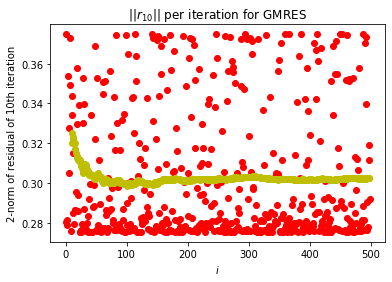

In [29]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,499):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for GMRES')

Text(0.5, 1.0, '$||r_{10}||$ per iteration for MLGMRES')

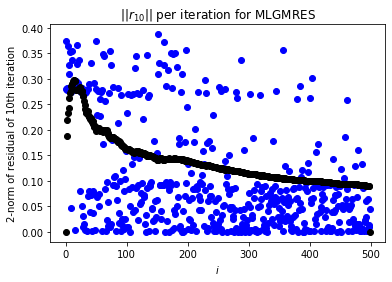

In [31]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,499):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'ok')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for MLGMRES')

Superimposing the two plots, we can appreaciate differences better. We have:

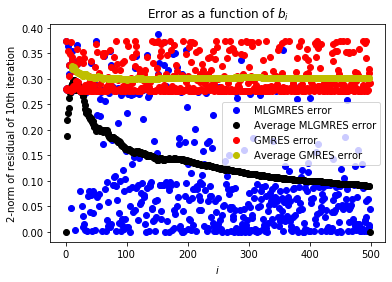

In [32]:
pp.plot(count,np.asarray(Err_Array_ML),'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,np.asarray(NonML_Err_List),'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ ')
pp.legend(loc='best')
pp.savefig('Compare_150.png')

We see that the error is indeed declining as "time" moves forward. Next we look at a larger dimension problem more closely. 

$n=250$ example 

MLGMRES is set to optimize error as described above (10th iteration of GMRES) and run time as described above. So, solution data is added only when a particular run does poorer than the running average of these metrics. 

500 $b_i$ considered. 

In [24]:
dim=250
x0=np.squeeze(np.zeros((dim,1))) #1d array of zeros

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat  #1D scalar laplacian

retrain_freq=1 # Actually 3 behind the scenes
e1 = 1e-3 # first tolerance
e2 = 1e-10 # refinement tolerance
nmax_iter = 50  
restart   = 64

sigma=0.02  # spread of local source
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)  #Domain


n_steps =500   # number of problem iterations
InputDim=dim   # dimensions of input layer
HiddenDim=dim   # number of output channels in first conv
HiddenDim2=dim  # Kernel size for first layer and input channel dimension for second conv. layer. 
OutputDim=dim # dimensions of output layer (output of 1D Conv. Channel dimension before being falttened)

In [25]:
# Primary experiment comparison loop

Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]
NonML_Time_List=[]

debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]
x=np.linspace(DomainL,DomainR,dim)



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    NonML_Time_List.append(run_time1)
    
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


print("Runtime of Non-decorated version is:",run_time)

print("Runtime of MLGMRES decorator is:",run_time_ML)

print("Runtime of training (backprop) is:",trainTime_total)

print("Runtime of forward function is:",forwardTime_Total)

0
1
2
loss: 0.011023162864148617 0
loss: 0.03808959200978279 1
loss: 0.07732609659433365 2
loss: 0.12621207535266876 3
loss: 0.18329615890979767 4
loss: 0.24768629670143127 5
loss: 0.3185213804244995 6
loss: 0.3944375216960907 7
loss: 0.4731697142124176 8
loss: 0.5515220761299133 9
loss: 0.6264556050300598 10
loss: 0.6983318328857422 11
loss: 0.7789915204048157 12
loss: 0.9088468551635742 13
loss: 1.1934853792190552 14
loss: 1.8787645101547241 15
loss: 3.5052077770233154 16
loss: 7.183314800262451 17
loss: 14.963176727294922 18
loss: 29.960601806640625 19
loss: 56.90265655517578 20
loss: 108.89688873291016 21
loss: 227.01727294921875 22
loss: 491.6298522949219 23
loss: 1032.9476318359375 24
loss: 1994.260009765625 25
loss: 3308.91943359375 26
loss: 4152.9228515625 27
loss: 3778.890869140625 28
loss: 2368.467041015625 29
loss: 1277.29443359375 30
loss: 1172.7720947265625 31
loss: 1602.81005859375 32
loss: 1651.7633056640625 33
loss: 944.1785278320312 34
loss: 559.300537109375 35
loss: 1

loss: 32.77297592163086 73
loss: 25.208171844482422 74
loss: 18.074312210083008 75
loss: 12.702934265136719 76
loss: 8.846466064453125 77
loss: 6.331205368041992 78
loss: 5.501674652099609 79
loss: 5.95384407043457 80
loss: 6.669074535369873 81
loss: 7.228156566619873 82
loss: 7.814076900482178 83
loss: 8.224138259887695 84
loss: 8.115825653076172 85
loss: 7.66235876083374 86
loss: 7.15208101272583 87
loss: 6.513801097869873 88
loss: 5.618495941162109 89
loss: 4.647063732147217 90
loss: 3.7995150089263916 91
loss: 3.054004192352295 92
loss: 2.3734850883483887 93
loss: 1.900933861732483 94
loss: 1.7326894998550415 95
loss: 1.76016104221344 96
loss: 1.884515404701233 97
loss: 2.1005916595458984 98
loss: 2.3517727851867676 99
loss: 2.4998981952667236 100
loss: 2.4852216243743896 101
loss: 2.3482885360717773 102
loss: 2.125361919403076 103
loss: 1.8270010948181152 104
loss: 1.4953813552856445 105
loss: 1.2135086059570312 106
loss: 1.023619532585144 107
loss: 0.9120765328407288 108
loss: 0.

loss: 1.728609561920166 398
loss: 2.1304430961608887 399
loss: 2.4397246837615967 400
loss: 2.5030899047851562 401
loss: 2.200032949447632 402
loss: 1.5638505220413208 403
loss: 0.8297960162162781 404
loss: 0.3119352459907532 405
loss: 0.1936563402414322 406
loss: 0.42438170313835144 407
loss: 0.7835260629653931 408
loss: 1.022617220878601 409
loss: 0.9958606958389282 410
loss: 0.7314836382865906 411
loss: 0.4024522006511688 412
loss: 0.20122522115707397 413
loss: 0.21013149619102478 414
loss: 0.3670053780078888 415
loss: 0.5322690606117249 416
loss: 0.5901997685432434 417
loss: 0.5176815390586853 418
loss: 0.38619792461395264 419
loss: 0.30338865518569946 420
loss: 0.340792179107666 421
loss: 0.5038540959358215 422
loss: 0.7489898800849915 423
loss: 1.0547634363174438 424
loss: 1.4511600732803345 425
loss: 2.0386948585510254 426
loss: 2.9481213092803955 427
loss: 4.245784282684326 428
loss: 5.785744667053223 429
loss: 7.050349712371826 430
loss: 7.237090587615967 431
loss: 5.876213550

loss: 1.3840340375900269 685
loss: 10.888676643371582 686
loss: 27.810489654541016 687
loss: 37.0894775390625 688
loss: 32.24336624145508 689
loss: 17.977703094482422 690
loss: 4.920731544494629 691
loss: 0.8476904630661011 692
loss: 5.90399169921875 693
loss: 14.014494895935059 694
loss: 18.274974822998047 695
loss: 15.856212615966797 696
loss: 9.023114204406738 697
loss: 2.6652979850769043 698
loss: 0.42209941148757935 699
loss: 2.5330417156219482 700
loss: 6.371223449707031 701
loss: 8.749669075012207 702
loss: 8.111909866333008 703
loss: 5.159163951873779 704
loss: 1.9563578367233276 705
loss: 0.32090285420417786 706
loss: 0.7517663836479187 707
loss: 2.397164821624756 708
loss: 3.8583121299743652 709
loss: 4.149681568145752 710
loss: 3.1903622150421143 711
loss: 1.670456886291504 712
loss: 0.47668391466140747 713
loss: 0.14094752073287964 714
loss: 0.6050186157226562 715
loss: 1.3763765096664429 716
loss: 1.8965357542037964 717
loss: 1.8644367456436157 718
loss: 1.3507579565048218

loss: 0.4532005190849304 972
loss: 0.9010353684425354 973
loss: 1.0724350214004517 974
loss: 0.8559830784797668 975
loss: 0.42080530524253845 976
loss: 0.07492982596158981 977
loss: 0.018315421417355537 978
loss: 0.20961973071098328 979
loss: 0.4399387240409851 980
loss: 0.51218581199646 981
loss: 0.38018909096717834 982
loss: 0.1598047912120819 983
loss: 0.016062768176198006 984
loss: 0.027717554941773415 985
loss: 0.14288732409477234 986
loss: 0.24340078234672546 987
loss: 0.2453967183828354 988
loss: 0.15547773241996765 989
loss: 0.04951954632997513 990
loss: 0.002344825305044651 991
loss: 0.030961358919739723 992
loss: 0.0930776596069336 993
loss: 0.1303541213274002 994
loss: 0.11458510905504227 995
loss: 0.0626354068517685 996
loss: 0.015322122722864151 997
loss: 0.0025957426987588406 998
loss: 0.02367439493536949 999
loss: 0.05378994718194008 1000
loss: 0.06683935225009918 1001
loss: 0.0542680062353611 1002
loss: 0.02763805165886879 1003
loss: 0.006416559685021639 1004
loss: 0.00

13
0.2557532149949111 0.11304662684695078 0.1501408859259263 0.044309453527820376
14
0.17002104397397488 0.1232399545718051 0.022242035793360485 0.05186884155625652
15
0.028385567013174295 0.1263586938652831 0.00018118741417702135 0.04989372117206345
16
0.02812038900447078 0.12023537343702628 0.00013534436640091113 0.04678668781219554
17
0.12057082098908722 0.1148168449409936 0.1348293756987022 0.04404249113891351
18
0.02808511900366284 0.11513651027699881 0.0002649835647409325 0.04908620694779066
19
0.028317969001363963 0.11534397210925817 0.00012573090601196232 0.04909520308178075
20
0.028978166985325515 0.11076365615621112 0.0002252885477667771 0.04651786244095082
21
0.028899700002511963 0.10667438169766683 0.00034847089798622805 0.04420323374629161
22
0.030746098986128345 0.10297082542646899 0.000281202030524132 0.04211491170589612
23
0.08513039801619016 0.0996878833155444 0.019152649875195313 0.04021337944792466
24
0.02913329200237058 0.09905494917209422 0.00025716296061050327 0.0

loss: 0.10891426354646683 256
loss: 0.11639949679374695 257
loss: 0.12813825905323029 258
loss: 0.14591017365455627 259
loss: 0.17252300679683685 260
loss: 0.2124651074409485 261
loss: 0.27241167426109314 262
loss: 0.3624367117881775 263
loss: 0.49641183018684387 264
loss: 0.6924044489860535 265
loss: 0.9698853492736816 266
loss: 1.341988444328308 267
loss: 1.7972146272659302 268
loss: 2.2704954147338867 269
loss: 2.6182973384857178 270
loss: 2.6420323848724365 271
loss: 2.206939935684204 272
loss: 1.406340479850769 273
loss: 0.5874401926994324 274
loss: 0.13088186085224152 275
loss: 0.17702186107635498 276
loss: 0.5591965913772583 277
loss: 0.9508768916130066 278
loss: 1.0726324319839478 279
loss: 0.8503742814064026 280
loss: 0.44940313696861267 281
loss: 0.1409018188714981 282
loss: 0.09275741875171661 283
loss: 0.26437908411026 284
loss: 0.47328612208366394 285
loss: 0.5463676452636719 286
loss: 0.43740689754486084 287
loss: 0.24013854563236237 288
loss: 0.09827324748039246 289
loss

loss: 34.02412033081055 547
loss: 53.28757858276367 548
loss: 55.17086410522461 549
loss: 39.31639862060547 550
loss: 17.480926513671875 551
loss: 3.262014389038086 552
loss: 3.066650390625 553
loss: 13.146414756774902 554
loss: 23.9523868560791 555
loss: 27.43056869506836 556
loss: 21.744739532470703 557
loss: 11.402209281921387 558
loss: 2.9990198612213135 559
loss: 0.7211664319038391 560
loss: 4.150435447692871 561
loss: 9.49974536895752 562
loss: 12.666864395141602 563
loss: 11.75546932220459 564
loss: 7.781847953796387 565
loss: 3.369368553161621 566
loss: 0.8668559193611145 567
loss: 1.0107965469360352 568
loss: 2.888822317123413 569
loss: 4.854055404663086 570
loss: 5.619709491729736 571
loss: 4.884260177612305 572
loss: 3.2239599227905273 573
loss: 1.5753283500671387 574
loss: 0.6454575657844543 575
loss: 0.6212978363037109 576
loss: 1.2124683856964111 577
loss: 1.9149757623672485 578
loss: 2.3018994331359863 579
loss: 2.195765972137451 580
loss: 1.6913396120071411 581
loss: 1.

loss: 0.03384077548980713 839
loss: 0.040178313851356506 840
loss: 0.046380847692489624 841
loss: 0.05468960106372833 842
loss: 0.06842205673456192 843
loss: 0.09184761345386505 844
loss: 0.13048216700553894 845
loss: 0.19196546077728271 846
loss: 0.28745508193969727 847
loss: 0.4334169328212738 848
loss: 0.652958869934082 849
loss: 0.9751614928245544 850
loss: 1.4278333187103271 851
loss: 2.0177037715911865 852
loss: 2.691328525543213 853
loss: 3.2930567264556885 854
loss: 3.577270269393921 855
loss: 3.364863395690918 856
loss: 2.7875258922576904 857
loss: 2.3361220359802246 858
loss: 2.5052876472473145 859
loss: 3.3562963008880615 860
loss: 4.4338178634643555 861
loss: 5.096953392028809 862
loss: 5.021681785583496 863
loss: 4.5859293937683105 864
loss: 4.726038932800293 865
loss: 6.341686248779297 866
loss: 9.80494499206543 867
loss: 15.101570129394531 868
loss: 22.32891082763672 869
loss: 32.372108459472656 870
loss: 47.15013122558594 871
loss: 70.01443481445312 872
loss: 105.315589

loss: 2.5676825046539307 1131
loss: 0.454598605632782 1132
loss: 0.5267472863197327 1133
loss: 2.0502097606658936 1134
loss: 3.5267703533172607 1135
loss: 3.8762238025665283 1136
loss: 3.0249950885772705 1137
loss: 1.689560890197754 1138
loss: 0.6931997537612915 1139
loss: 0.42921915650367737 1140
loss: 0.7534186244010925 1141
loss: 1.243411660194397 1142
loss: 1.5324442386627197 1143
loss: 1.486578345298767 1144
loss: 1.1866706609725952 1145
loss: 0.8020591139793396 1146
loss: 0.48361819982528687 1147
loss: 0.31355777382850647 1148
loss: 0.3049758970737457 1149
loss: 0.41510310769081116 1150
loss: 0.5631425380706787 1151
loss: 0.6583501696586609 1152
loss: 0.6374133229255676 1153
loss: 0.49711373448371887 1154
loss: 0.29648256301879883 1155
loss: 0.12539060413837433 1156
loss: 0.05406515300273895 1157
loss: 0.09586998075246811 1158
loss: 0.20447246730327606 1159
loss: 0.30491143465042114 1160
loss: 0.33726558089256287 1161
loss: 0.28599151968955994 1162
loss: 0.1814407855272293 1163
l

loss: 0.12721849977970123 189
loss: 0.12980952858924866 190
loss: 0.13458167016506195 191
loss: 0.14285843074321747 192
loss: 0.15674453973770142 193
loss: 0.1796162724494934 194
loss: 0.21694201231002808 195
loss: 0.277434766292572 196
loss: 0.37478822469711304 197
loss: 0.5298066139221191 198
loss: 0.7722108364105225 199
loss: 1.1392697095870972 200
loss: 1.6646708250045776 201
loss: 2.3456859588623047 202
loss: 3.0795559883117676 203
loss: 3.5989274978637695 204
loss: 3.5232367515563965 205
loss: 2.6538217067718506 206
loss: 1.3292412757873535 207
loss: 0.31127676367759705 208
loss: 0.14247871935367584 209
loss: 0.6997037529945374 210
loss: 1.3713064193725586 211
loss: 1.5572036504745483 212
loss: 1.1111353635787964 213
loss: 0.437826544046402 214
loss: 0.09597903490066528 215
loss: 0.2699524760246277 216
loss: 0.6636372804641724 217
loss: 0.8449453711509705 218
loss: 0.6478307843208313 219
loss: 0.2839442789554596 220
loss: 0.08948963135480881 221
loss: 0.18512411415576935 222
loss

loss: 0.15489861369132996 486
loss: 0.21422171592712402 487
loss: 0.2847316265106201 488
loss: 0.3776622414588928 489
loss: 0.514002799987793 490
loss: 0.7248599529266357 491
loss: 1.0513932704925537 492
loss: 1.5425056219100952 493
loss: 2.244006395339966 494
loss: 3.1661317348480225 495
loss: 4.21451997756958 496
loss: 5.102323055267334 497
loss: 5.357388973236084 498
loss: 4.60955286026001 499
loss: 3.0659523010253906 500
loss: 1.573441743850708 501
loss: 0.9562557935714722 502
loss: 1.3521934747695923 503
loss: 2.234179973602295 504
loss: 2.9157989025115967 505
loss: 3.0843846797943115 506
loss: 2.9852237701416016 507
loss: 3.0270752906799316 508
loss: 3.2151591777801514 509
loss: 3.1245858669281006 510
loss: 2.429192543029785 511
loss: 1.3538544178009033 512
loss: 0.5560896396636963 513
loss: 0.5538671016693115 514
loss: 1.283280611038208 515
loss: 2.1903998851776123 516
loss: 2.7048685550689697 517
loss: 2.6639370918273926 518
loss: 2.356783390045166 519
loss: 2.1766040325164795 

loss: 2.179415225982666 791
loss: 2.989901542663574 792
loss: 3.9964468479156494 793
loss: 5.159822940826416 794
loss: 6.388185024261475 795
loss: 7.605443954467773 796
loss: 8.854630470275879 797
loss: 10.481066703796387 798
loss: 13.166889190673828 799
loss: 17.949081420898438 800
loss: 26.027259826660156 801
loss: 38.921592712402344 802
loss: 58.441646575927734 803
loss: 87.58709716796875 804
loss: 130.12351989746094 805
loss: 192.28675842285156 806
loss: 279.1274108886719 807
loss: 396.9563903808594 808
loss: 538.5454711914062 809
loss: 689.1851196289062 810
loss: 795.6026000976562 811
loss: 808.4822998046875 812
loss: 674.2479248046875 813
loss: 431.8855285644531 814
loss: 175.96743774414062 815
loss: 24.835712432861328 816
loss: 25.23763656616211 817
loss: 134.43020629882812 818
loss: 257.7564392089844 819
loss: 305.94775390625 820
loss: 251.46878051757812 821
loss: 133.28717041015625 822
loss: 32.37321853637695 823
loss: 4.682170391082764 824
loss: 47.66381072998047 825
loss: 11

loss: 0.006953881587833166 1106
loss: 0.011608542874455452 1107
loss: 0.016139943152666092 1108
loss: 0.01691015064716339 1109
loss: 0.013097519055008888 1110
loss: 0.00708401296287775 1111
loss: 0.0024401345290243626 1112
loss: 0.0013352363603189588 1113
loss: 0.003348194994032383 1114
loss: 0.006286158226430416 1115
loss: 0.007990173064172268 1116
loss: 0.007666504010558128 1117
loss: 0.0059535629115998745 1118
loss: 0.00407456373795867 1119
loss: 0.0029060484375804663 1120
loss: 0.0026262905448675156 1121
loss: 0.0029461649246513844 1122
loss: 0.0035428572446107864 1123
loss: 0.00431335112079978 1124
loss: 0.005353705491870642 1125
loss: 0.006805003620684147 1126
loss: 0.008769288659095764 1127
loss: 0.011408588849008083 1128
loss: 0.015146597288548946 1129
loss: 0.020854856818914413 1130
loss: 0.0299485232681036 1131
loss: 0.04446395859122276 1132
loss: 0.0672718957066536 1133
loss: 0.10259021073579788 1134
loss: 0.15686734020709991 1135
loss: 0.2400001585483551 1136
loss: 0.366695

loss: 0.5534350872039795 179
loss: 0.4725390672683716 180
loss: 0.3507196009159088 181
loss: 0.28101906180381775 182
loss: 0.27910900115966797 183
loss: 0.2969231903553009 184
loss: 0.28987130522727966 185
loss: 0.25939804315567017 186
loss: 0.23514169454574585 187
loss: 0.23176904022693634 188
loss: 0.23542077839374542 189
loss: 0.22706621885299683 190
loss: 0.20821057260036469 191
loss: 0.20018817484378815 192
loss: 0.22051875293254852 193
loss: 0.2645246684551239 194
loss: 0.3126550018787384 195
loss: 0.3545936644077301 196
loss: 0.4040684998035431 197
loss: 0.49053701758384705 198
loss: 0.6369441151618958 199
loss: 0.844346821308136 200
loss: 1.0937318801879883 201
loss: 1.3570976257324219 202
loss: 1.6005605459213257 203
loss: 1.7764421701431274 204
loss: 1.8197875022888184 205
loss: 1.6749598979949951 206
loss: 1.3469221591949463 207
loss: 0.9353396892547607 208
loss: 0.6001099348068237 209
loss: 0.475609689950943 210
loss: 0.6005100607872009 211
loss: 0.9143469333648682 212
loss

loss: 0.07430800050497055 501
loss: 0.10840756446123123 502
loss: 0.16525053977966309 503
loss: 0.24106259644031525 504
loss: 0.3393368422985077 505
loss: 0.47512587904930115 506
loss: 0.6767004728317261 507
loss: 0.9829544425010681 508
loss: 1.4326215982437134 509
loss: 2.036548614501953 510
loss: 2.7248952388763428 511
loss: 3.28491473197937 512
loss: 3.3757975101470947 513
loss: 2.744062900543213 514
loss: 1.564966082572937 515
loss: 0.4758884906768799 516
loss: 0.08066725730895996 517
loss: 0.4418122470378876 518
loss: 1.094767451286316 519
loss: 1.447864055633545 520
loss: 1.2115556001663208 521
loss: 0.6030822992324829 522
loss: 0.13397786021232605 523
loss: 0.12800534069538116 524
loss: 0.4634825587272644 525
loss: 0.755297064781189 526
loss: 0.7267630100250244 527
loss: 0.4321642518043518 528
loss: 0.16126537322998047 529
loss: 0.13725963234901428 530
loss: 0.32382306456565857 531
loss: 0.5077885389328003 532
loss: 0.5259674787521362 533
loss: 0.40583881735801697 534
loss: 0.31

loss: 2.192502021789551 789
loss: 1.187926173210144 790
loss: 1.3300247192382812 791
loss: 2.231480360031128 792
loss: 2.879850149154663 793
loss: 2.597378730773926 794
loss: 1.581932783126831 795
loss: 0.6246040463447571 796
loss: 0.3659746050834656 797
loss: 0.8052648901939392 798
loss: 1.4051239490509033 799
loss: 1.597664713859558 800
loss: 1.231107473373413 801
loss: 0.6172913312911987 802
loss: 0.21152058243751526 803
loss: 0.2286563217639923 804
loss: 0.5203189849853516 805
loss: 0.766376793384552 806
loss: 0.7622528076171875 807
loss: 0.5463058352470398 808
loss: 0.30232560634613037 809
loss: 0.18053217232227325 810
loss: 0.20081648230552673 811
loss: 0.2846226394176483 812
loss: 0.3429606556892395 813
loss: 0.33721765875816345 814
loss: 0.2842201888561249 815
loss: 0.22482971847057343 816
loss: 0.18967947363853455 817
loss: 0.18334797024726868 818
loss: 0.19247925281524658 819
loss: 0.204903244972229 820
loss: 0.22120244801044464 821
loss: 0.24993757903575897 822
loss: 0.29526

loss: 0.023627694696187973 1075
loss: 0.022409871220588684 1076
loss: 0.02169210836291313 1077
loss: 0.021573258563876152 1078
loss: 0.021727776154875755 1079
loss: 0.02179524675011635 1080
loss: 0.021596170961856842 1081
loss: 0.021161822602152824 1082
loss: 0.020648576319217682 1083
loss: 0.020255153998732567 1084
loss: 0.020106403157114983 1085
loss: 0.02015531063079834 1086
loss: 0.020226314663887024 1087
loss: 0.02015679143369198 1088
loss: 0.019919130951166153 1089
loss: 0.019638393074274063 1090
loss: 0.019440047442913055 1091
loss: 0.019371308386325836 1092
loss: 0.019376322627067566 1093
loss: 0.019372140988707542 1094
loss: 0.019310159608721733 1095
loss: 0.0192002784460783 1096
loss: 0.019080040976405144 1097
loss: 0.018987620249390602 1098
loss: 0.018939418718218803 1099
loss: 0.018920056521892548 1100
loss: 0.018904829397797585 1101
loss: 0.01886431872844696 1102
loss: 0.01880066841840744 1103
loss: 0.018731724470853806 1104
loss: 0.018680376932024956 1105
loss: 0.01865572

loss: 88.84149169921875 1361
loss: 148.3271484375 1362
loss: 185.89553833007812 1363
loss: 176.22561645507812 1364
loss: 124.38399505615234 1365
loss: 58.70234680175781 1366
loss: 14.861611366271973 1367
loss: 10.441529273986816 1368
loss: 37.16998291015625 1369
loss: 70.3360824584961 1370
loss: 85.9000244140625 1371
loss: 75.15734100341797 1372
loss: 46.30452346801758 1373
loss: 17.72399139404297 1374
loss: 4.062424659729004 1375
loss: 8.386055946350098 1376
loss: 22.634618759155273 1377
loss: 34.837913513183594 1378
loss: 37.12226486206055 1379
loss: 29.10110855102539 1380
loss: 16.712400436401367 1381
loss: 6.99962043762207 1382
loss: 3.9207355976104736 1383
loss: 6.69940185546875 1384
loss: 11.52968692779541 1385
loss: 14.598350524902344 1386
loss: 14.211690902709961 1387
loss: 11.184588432312012 1388
loss: 7.511466026306152 1389
loss: 4.9116926193237305 1390
loss: 3.909322500228882 1391
loss: 4.0269927978515625 1392
loss: 4.473045349121094 1393
loss: 4.733236789703369 1394
loss: 4

loss: 0.015747059136629105 1643
loss: 0.01667274348437786 1644
loss: 0.018028244376182556 1645
loss: 0.020024780184030533 1646
loss: 0.02297583408653736 1647
loss: 0.02735525742173195 1648
loss: 0.0338815376162529 1649
loss: 0.0436532162129879 1650
loss: 0.058352239429950714 1651
loss: 0.08055802434682846 1652
loss: 0.1142093613743782 1653
loss: 0.16526567935943604 1654
loss: 0.2425961196422577 1655
loss: 0.3589761257171631 1656
loss: 0.5317707657814026 1657
loss: 0.7819588780403137 1658
loss: 1.1289474964141846 1659
loss: 1.5762195587158203 1660
loss: 2.0846445560455322 1661
loss: 2.540053606033325 1662
loss: 2.753412961959839 1663
loss: 2.5513112545013428 1664
loss: 1.956096887588501 1665
loss: 1.2842625379562378 1666
loss: 0.981378972530365 1667
loss: 1.3010344505310059 1668
loss: 2.142855167388916 1669
loss: 3.136080026626587 1670
loss: 3.830970525741577 1671
loss: 3.893470525741577 1672
loss: 3.2913691997528076 1673
loss: 2.3724329471588135 1674
loss: 1.727809190750122 1675
loss: 

loss: 32.31288146972656 1931
loss: 24.081401824951172 1932
loss: 14.24705982208252 1933
loss: 5.7470316886901855 1934
loss: 2.406938076019287 1935
loss: 5.549500942230225 1936
loss: 12.23709487915039 1937
loss: 17.48811149597168 1938
loss: 18.175783157348633 1939
loss: 14.896692276000977 1940
loss: 10.263731956481934 1941
loss: 6.479183197021484 1942
loss: 4.154784679412842 1943
loss: 2.969295024871826 1944
loss: 2.5429272651672363 1945
loss: 2.755768060684204 1946
loss: 3.539330244064331 1947
loss: 4.638589382171631 1948
loss: 5.609076499938965 1949
loss: 5.968981742858887 1950
loss: 5.457423686981201 1951
loss: 4.162819862365723 1952
loss: 2.5398361682891846 1953
loss: 1.1686594486236572 1954
loss: 0.46332716941833496 1955
loss: 0.4633015990257263 1956
loss: 0.8785344958305359 1957
loss: 1.3309264183044434 1958
loss: 1.6010938882827759 1959
loss: 1.7010482549667358 1960
loss: 1.7449973821640015 1961
loss: 1.7828224897384644 1962
loss: 1.7432186603546143 1963
loss: 1.5321006774902344 

loss: 174.71484375 2211
loss: 172.13034057617188 2212
loss: 103.04393005371094 2213
loss: 28.127643585205078 2214
loss: 4.342894077301025 2215
loss: 35.777305603027344 2216
loss: 80.3135757446289 2217
loss: 93.7123794555664 2218
loss: 65.80255126953125 2219
loss: 24.07115364074707 2220
loss: 2.4888572692871094 2221
loss: 12.125689506530762 2222
loss: 36.089263916015625 2223
loss: 49.09540939331055 2224
loss: 40.27203369140625 2225
loss: 18.867856979370117 2226
loss: 3.151414632797241 2227
loss: 3.2497177124023438 2228
loss: 14.563222885131836 2229
loss: 24.431903839111328 2230
loss: 23.879077911376953 2231
loss: 14.26390552520752 2232
loss: 4.0098090171813965 2233
loss: 0.6032527089118958 2234
loss: 4.69202184677124 2235
loss: 10.916888236999512 2236
loss: 13.338539123535156 2237
loss: 10.173592567443848 2238
loss: 4.447448253631592 2239
loss: 0.6260198950767517 2240
loss: 0.8946499228477478 2241
loss: 3.9036128520965576 2242
loss: 6.506590366363525 2243
loss: 6.520463466644287 2244
lo

loss: 0.016625981777906418 2497
loss: 0.011836622841656208 2498
loss: 0.012252258136868477 2499
loss: 0.015777233988046646 2500
loss: 0.02007894217967987 2501
loss: 0.02335136942565441 2502
loss: 0.02461891621351242 2503
loss: 0.02370108664035797 2504
loss: 0.021000109612941742 2505
loss: 0.01723533309996128 2506
loss: 0.013217374682426453 2507
loss: 0.009675347246229649 2508
loss: 0.00713400449603796 2509
loss: 0.005838693585246801 2510
loss: 0.0057454342022538185 2511
loss: 0.006559220142662525 2512
loss: 0.007839740253984928 2513
loss: 0.009113007225096226 2514
loss: 0.009989078156650066 2515
loss: 0.010240856558084488 2516
loss: 0.009823646396398544 2517
loss: 0.008849101141095161 2518
loss: 0.007535839919000864 2519
loss: 0.006142108701169491 2520
loss: 0.0049003069289028645 2521
loss: 0.00397180300205946 2522
loss: 0.003430681535974145 2523
loss: 0.0032610753551125526 2524
loss: 0.0033850627951323986 2525
loss: 0.0036927296314388514 2526
loss: 0.004068747162818909 2527
loss: 0.00

loss: 431.6016540527344 2777
loss: 125.46188354492188 2778
loss: 14.609603881835938 2779
loss: 110.86582946777344 2780
loss: 289.99371337890625 2781
loss: 391.9620666503906 2782
loss: 339.5694274902344 2783
loss: 177.2019500732422 2784
loss: 38.60546875 2785
loss: 16.95931053161621 2786
loss: 95.49586486816406 2787
loss: 179.5115966796875 2788
loss: 186.39930725097656 2789
loss: 115.87102508544922 2790
loss: 33.86565017700195 2791
loss: 6.721301078796387 2792
loss: 40.44884490966797 2793
loss: 87.47361755371094 2794
loss: 98.9635009765625 2795
loss: 66.3927001953125 2796
loss: 22.720165252685547 2797
loss: 4.249864101409912 2798
loss: 18.565359115600586 2799
loss: 43.466033935546875 2800
loss: 52.24526596069336 2801
loss: 38.00307083129883 2802
loss: 15.09547233581543 2803
loss: 2.9786901473999023 2804
loss: 8.081108093261719 2805
loss: 20.97149658203125 2806
loss: 27.626644134521484 2807
loss: 22.12923812866211 2808
loss: 10.286093711853027 2809
loss: 2.2213356494903564 2810
loss: 3.0

loss: 0.1552075445652008 3072
loss: 0.10123088955879211 3073
loss: 0.043746788054704666 3074
loss: 0.009101524017751217 3075
loss: 0.007056965958327055 3076
loss: 0.029462583363056183 3077
loss: 0.05813407525420189 3078
loss: 0.07584881037473679 3079
loss: 0.07433388382196426 3080
loss: 0.056249912828207016 3081
loss: 0.031545113772153854 3082
loss: 0.011328390799462795 3083
loss: 0.0025294432416558266 3084
loss: 0.005702548660337925 3085
loss: 0.016138531267642975 3086
loss: 0.027036890387535095 3087
loss: 0.03288334608078003 3088
loss: 0.03149319067597389 3089
loss: 0.024201732128858566 3090
loss: 0.014538129791617393 3091
loss: 0.006303127389401197 3092
loss: 0.0019777712877839804 3093
loss: 0.002048951806500554 3094
loss: 0.005263935308903456 3095
loss: 0.00948278233408928 3096
loss: 0.012677421793341637 3097
loss: 0.013648957945406437 3098
loss: 0.012266486883163452 3099
loss: 0.009263185784220695 3100
loss: 0.0057838731445372105 3101
loss: 0.002910008653998375 3102
loss: 0.001314

loss: 0.09343975782394409 228
loss: 0.13338616490364075 229
loss: 0.18820208311080933 230
loss: 0.263613224029541 231
loss: 0.3691011965274811 232
loss: 0.5183365345001221 233
loss: 0.7282968759536743 234
loss: 1.016128420829773 235
loss: 1.3906805515289307 236
loss: 1.8376225233078003 237
loss: 2.299823760986328 238
loss: 2.6708507537841797 239
loss: 2.829641342163086 240
loss: 2.7280821800231934 241
loss: 2.463743209838867 242
loss: 2.226539134979248 243
loss: 2.124542713165283 244
loss: 2.074444532394409 245
loss: 1.8973419666290283 246
loss: 1.5150957107543945 247
loss: 1.0300203561782837 248
loss: 0.6305749416351318 249
loss: 0.45609021186828613 250
loss: 0.5243649482727051 251
loss: 0.7247708439826965 252
loss: 0.8770199418067932 253
loss: 0.8473132848739624 254
loss: 0.6405096054077148 255
loss: 0.38358840346336365 256
loss: 0.21977607905864716 257
loss: 0.210971862077713 258
loss: 0.31280216574668884 259
loss: 0.42053455114364624 260
loss: 0.4468744993209839 261
loss: 0.3787153

loss: 10.341058731079102 541
loss: 7.637277603149414 542
loss: 4.663403034210205 543
loss: 2.496713399887085 544
loss: 1.9532856941223145 545
loss: 3.046494722366333 546
loss: 4.977701187133789 547
loss: 6.59328556060791 548
loss: 7.017828941345215 549
loss: 6.027841567993164 550
loss: 4.105515003204346 551
loss: 2.07993221282959 552
loss: 0.6985065340995789 553
loss: 0.2855432331562042 554
loss: 0.6891739964485168 555
loss: 1.4617619514465332 556
loss: 2.1354386806488037 557
loss: 2.4346866607666016 558
loss: 2.3319177627563477 559
loss: 1.977297067642212 560
loss: 1.5587518215179443 561
loss: 1.2058703899383545 562
loss: 0.9519739747047424 563
loss: 0.7676773071289062 564
loss: 0.6100988388061523 565
loss: 0.46357229351997375 566
loss: 0.3461643159389496 567
loss: 0.29132118821144104 568
loss: 0.31988391280174255 569
loss: 0.4216235876083374 570
loss: 0.5562996864318848 571
loss: 0.6702028512954712 572
loss: 0.7197146415710449 573
loss: 0.6866244077682495 574
loss: 0.5829665064811707

loss: 2.974025011062622 845
loss: 1.0505212545394897 846
loss: 0.10078427940607071 847
loss: 0.43043988943099976 848
loss: 1.4679216146469116 849
loss: 2.314192771911621 850
loss: 2.3849732875823975 851
loss: 1.706339716911316 852
loss: 0.7752781510353088 853
loss: 0.14752382040023804 854
loss: 0.08816420286893845 855
loss: 0.47124728560447693 856
loss: 0.93754643201828 857
loss: 1.1565070152282715 858
loss: 1.0118919610977173 859
loss: 0.6253743171691895 860
loss: 0.23434136807918549 861
loss: 0.0340382419526577 862
loss: 0.07584832608699799 863
loss: 0.2690601944923401 864
loss: 0.46050676703453064 865
loss: 0.5305297374725342 866
loss: 0.45043474435806274 867
loss: 0.2778033912181854 868
loss: 0.10847766697406769 869
loss: 0.018097519874572754 870
loss: 0.027719425037503242 871
loss: 0.10462136566638947 872
loss: 0.19006825983524323 873
loss: 0.23386678099632263 874
loss: 0.21682734787464142 875
loss: 0.15346425771713257 876
loss: 0.07757911086082458 877
loss: 0.022364817559719086 8

loss: 0.8307411670684814 201
loss: 1.341644525527954 202
loss: 1.3954839706420898 203
loss: 0.9814857244491577 204
loss: 0.49819642305374146 205
loss: 0.3795083165168762 206
loss: 0.7154393196105957 207
loss: 1.2510128021240234 208
loss: 1.6924469470977783 209
loss: 1.9924737215042114 210
loss: 2.357755422592163 211
loss: 2.952728271484375 212
loss: 3.5715126991271973 213
loss: 3.6607227325439453 214
loss: 2.8273260593414307 215
loss: 1.409747838973999 216
loss: 0.3327888548374176 217
loss: 0.24139560759067535 218
loss: 0.9344291090965271 219
loss: 1.6339510679244995 220
loss: 1.6704763174057007 221
loss: 1.0308178663253784 222
loss: 0.32875925302505493 223
loss: 0.1585729420185089 224
loss: 0.5223064422607422 225
loss: 0.9286706447601318 226
loss: 0.9389949440956116 227
loss: 0.5766614079475403 228
loss: 0.23727507889270782 229
loss: 0.23449760675430298 230
loss: 0.5016500353813171 231
loss: 0.7346157431602478 232
loss: 0.7441239953041077 233
loss: 0.632806658744812 234
loss: 0.650285

loss: 1.0882092714309692 501
loss: 1.0306369066238403 502
loss: 1.1471562385559082 503
loss: 1.5084614753723145 504
loss: 2.019745349884033 505
loss: 2.452491283416748 506
loss: 2.543461322784424 507
loss: 2.1442525386810303 508
loss: 1.362926959991455 509
loss: 0.5561378598213196 510
loss: 0.10312485694885254 511
loss: 0.1428157538175583 512
loss: 0.51216721534729 513
loss: 0.8934184312820435 514
loss: 1.0181766748428345 515
loss: 0.8145280480384827 516
loss: 0.4343508780002594 517
loss: 0.13240927457809448 518
loss: 0.07568756490945816 519
loss: 0.2391526699066162 520
loss: 0.4577125906944275 521
loss: 0.5638439059257507 522
loss: 0.5016326308250427 523
loss: 0.34961968660354614 524
loss: 0.24763329327106476 525
loss: 0.29033419489860535 526
loss: 0.4726301431655884 527
loss: 0.7186726927757263 528
loss: 0.9554896354675293 529
loss: 1.1700657606124878 530
loss: 1.412262201309204 531
loss: 1.7462890148162842 532
loss: 2.18703031539917 533
loss: 2.6635615825653076 534
loss: 3.029241085

loss: 3.0764517784118652 789
loss: 3.957899332046509 790
loss: 5.151580810546875 791
loss: 6.140400409698486 792
loss: 6.511795520782471 793
loss: 6.141242027282715 794
loss: 5.244828224182129 795
loss: 4.247387886047363 796
loss: 3.514989137649536 797
loss: 3.1342740058898926 798
loss: 2.9292736053466797 799
loss: 2.700239419937134 800
loss: 2.428246259689331 801
loss: 2.23732852935791 802
loss: 2.2227609157562256 803
loss: 2.3693161010742188 804
loss: 2.585635185241699 805
loss: 2.7758846282958984 806
loss: 2.9078590869903564 807
loss: 3.0342931747436523 808
loss: 3.2210755348205566 809
loss: 3.44248104095459 810
loss: 3.573770523071289 811
loss: 3.4917423725128174 812
loss: 3.178966999053955 813
loss: 2.736934185028076 814
loss: 2.3097879886627197 815
loss: 1.987109661102295 816
loss: 1.7590142488479614 817
loss: 1.5522572994232178 818
loss: 1.302146553993225 819
loss: 1.0093708038330078 820
loss: 0.7449424266815186 821
loss: 0.604457437992096 822
loss: 0.6367940306663513 823
loss: 

loss: 0.2788502871990204 1105
loss: 0.32507285475730896 1106
loss: 0.32183828949928284 1107
loss: 0.276156485080719 1108
loss: 0.20747101306915283 1109
loss: 0.13957926630973816 1110
loss: 0.09143112599849701 1111
loss: 0.07156218588352203 1112
loss: 0.07725618034601212 1113
loss: 0.09807094931602478 1114
loss: 0.12096129357814789 1115
loss: 0.13500957190990448 1116
loss: 0.13427722454071045 1117
loss: 0.11871566623449326 1118
loss: 0.09299159795045853 1119
loss: 0.06424443423748016 1120
loss: 0.039372894912958145 1121
loss: 0.023026123642921448 1122
loss: 0.016651736572384834 1123
loss: 0.018782760947942734 1124
loss: 0.026104385033249855 1125
loss: 0.03478333726525307 1126
loss: 0.0416058786213398 1127
loss: 0.044669341295957565 1128
loss: 0.04355718940496445 1129
loss: 0.03912752866744995 1130
loss: 0.033007651567459106 1131
loss: 0.027045542374253273 1132
loss: 0.02282761037349701 1133
loss: 0.02142035774886608 1134
loss: 0.023296162486076355 1135
loss: 0.02847401611506939 1136
los

loss: 173.44888305664062 1389
loss: 254.53126525878906 1390
loss: 200.22828674316406 1391
loss: 76.61664581298828 1392
loss: 4.96483039855957 1393
loss: 35.68125915527344 1394
loss: 109.2755355834961 1395
loss: 135.70521545410156 1396
loss: 90.7601547241211 1397
loss: 25.525354385375977 1398
loss: 3.619302272796631 1399
loss: 32.86342239379883 1400
loss: 68.78173065185547 1401
loss: 69.85570526123047 1402
loss: 37.46099853515625 1403
loss: 7.253166675567627 1404
loss: 5.667450428009033 1405
loss: 25.66427230834961 1406
loss: 40.5125846862793 1407
loss: 34.029754638671875 1408
loss: 14.82657241821289 1409
loss: 2.3458573818206787 1410
loss: 5.81329345703125 1411
loss: 17.151233673095703 1412
loss: 22.371435165405273 1413
loss: 16.434579849243164 1414
loss: 6.093827247619629 1415
loss: 1.17406165599823 1416
loss: 4.416238784790039 1417
loss: 10.334650039672852 1418
loss: 12.098159790039062 1419
loss: 8.174901008605957 1420
loss: 2.771476984024048 1421
loss: 0.6777953505516052 1422
loss: 

loss: 0.35009005665779114 1672
loss: 0.1408279538154602 1673
loss: 0.35237646102905273 1674
loss: 0.7226893305778503 1675
loss: 0.9612938165664673 1676
loss: 0.9257668852806091 1677
loss: 0.669072151184082 1678
loss: 0.3579827547073364 1679
loss: 0.15196473896503448 1680
loss: 0.11579633504152298 1681
loss: 0.20933181047439575 1682
loss: 0.3362092077732086 1683
loss: 0.4088677763938904 1684
loss: 0.39107611775398254 1685
loss: 0.3014041781425476 1686
loss: 0.1896045058965683 1687
loss: 0.1037742868065834 1688
loss: 0.06870805472135544 1689
loss: 0.0808873251080513 1690
loss: 0.11774513125419617 1691
loss: 0.15240570902824402 1692
loss: 0.16588135063648224 1693
loss: 0.15271568298339844 1694
loss: 0.11950653046369553 1695
loss: 0.07966697961091995 1696
loss: 0.04671626538038254 1697
loss: 0.029383273795247078 1698
loss: 0.029308514669537544 1699
loss: 0.04165070876479149 1700
loss: 0.05784063786268234 1701
loss: 0.06922021508216858 1702
loss: 0.07026853412389755 1703
loss: 0.06023793667

loss: 0.008869331330060959 1955
loss: 0.014064270071685314 1956
loss: 0.01671060547232628 1957
loss: 0.01593799889087677 1958
loss: 0.012409910559654236 1959
loss: 0.0077325087040662766 1960
loss: 0.0036352116148918867 1961
loss: 0.0012948572402819991 1962
loss: 0.001020280527882278 1963
loss: 0.00233459728769958 1964
loss: 0.0043187132105231285 1965
loss: 0.006031932774931192 1966
loss: 0.006836915388703346 1967
loss: 0.006547044031322002 1968
loss: 0.00538228964433074 1969
loss: 0.0038055344484746456 1970
loss: 0.002318514045327902 1971
loss: 0.0012945252237841487 1972
loss: 0.000892873271368444 1973
Final loss: 0.000892873271368444 1974
71
0.028138405992649496 0.11172474039933429 4.348557173237958e-05 0.048729720332966804
72
0.022635455999989063 0.1104582807871118 1.7455823338543368e-05 0.047992050109311735
73
0.03447842400055379 0.10914749235745325 0.02881746143076552 0.04727601138862557
74
0.022795643017161638 0.10804941782279297 0.02238774177486856 0.04700456212453939
75
0.091249

loss: 0.22393997013568878 209
loss: 0.2224949300289154 210
loss: 0.22108982503414154 211
loss: 0.21968181431293488 212
loss: 0.21830470860004425 213
loss: 0.21694771945476532 214
loss: 0.21560747921466827 215
loss: 0.21428778767585754 216
loss: 0.2129817008972168 217
loss: 0.21170932054519653 218
loss: 0.2104414999485016 219
loss: 0.20918409526348114 220
loss: 0.20795860886573792 221
loss: 0.2067466527223587 222
loss: 0.20554302632808685 223
loss: 0.20436415076255798 224
loss: 0.20320218801498413 225
loss: 0.20204710960388184 226
loss: 0.20091581344604492 227
loss: 0.19978928565979004 228
loss: 0.19868651032447815 229
loss: 0.1975911557674408 230
loss: 0.19652274250984192 231
loss: 0.1954517811536789 232
loss: 0.1944069266319275 233
loss: 0.19338347017765045 234
loss: 0.19235339760780334 235
loss: 0.1913321316242218 236
loss: 0.19033974409103394 237
loss: 0.1893540471792221 238
loss: 0.18838021159172058 239
loss: 0.1874253749847412 240
loss: 0.1864756941795349 241
loss: 0.1855398565530

loss: 0.2975585162639618 520
loss: 0.198200985789299 521
loss: 0.11245635151863098 522
loss: 0.09673700481653214 523
loss: 0.14256702363491058 524
loss: 0.1961146891117096 525
loss: 0.2086992710828781 526
loss: 0.17312246561050415 527
loss: 0.12114793062210083 528
loss: 0.09149418026208878 529
loss: 0.09866941720247269 530
loss: 0.12669284641742706 531
loss: 0.14737218618392944 532
loss: 0.14383330941200256 533
loss: 0.12088868021965027 534
loss: 0.09708435088396072 535
loss: 0.08818171918392181 536
loss: 0.09604637324810028 537
loss: 0.1100974753499031 538
loss: 0.11750594526529312 539
loss: 0.1128605455160141 540
loss: 0.10052400827407837 541
loss: 0.08958286792039871 542
loss: 0.08646644651889801 543
loss: 0.09096744656562805 544
loss: 0.0977465882897377 545
loss: 0.1010112389922142 546
loss: 0.09858894348144531 547
loss: 0.09261526167392731 548
loss: 0.08727510273456573 549
loss: 0.08557430654764175 550
loss: 0.08767210692167282 551
loss: 0.09131168574094772 552
loss: 0.09384907037

loss: 0.2664709687232971 837
loss: 0.39163118600845337 838
loss: 0.7595675587654114 839
loss: 1.1029170751571655 840
loss: 1.2531710863113403 841
loss: 1.2615951299667358 842
loss: 1.3210043907165527 843
loss: 1.5709927082061768 844
loss: 1.9655596017837524 845
loss: 2.32133412361145 846
loss: 2.4822604656219482 847
loss: 2.4833056926727295 848
loss: 2.5794260501861572 849
loss: 3.152172803878784 850
loss: 4.562530517578125 851
loss: 7.142864227294922 852
loss: 11.303946495056152 853
loss: 17.830644607543945 854
loss: 28.05820655822754 855
loss: 44.424739837646484 856
loss: 70.50519561767578 857
loss: 112.48335266113281 858
loss: 178.08966064453125 859
loss: 280.075927734375 860
loss: 427.2109680175781 861
loss: 629.7626342773438 862
loss: 857.5285034179688 863
loss: 1061.0445556640625 864
loss: 1101.4266357421875 865
loss: 915.6157836914062 866
loss: 523.5891723632812 867
loss: 153.28684997558594 868
loss: 7.646700382232666 869
loss: 119.29669189453125 870
loss: 336.7070007324219 871


loss: 0.9116775393486023 1152
loss: 1.2822030782699585 1153
loss: 1.2524774074554443 1154
loss: 0.8807014226913452 1155
loss: 0.4197019934654236 1156
loss: 0.1271420419216156 1157
loss: 0.11142364144325256 1158
loss: 0.30106958746910095 1159
loss: 0.5241454839706421 1160
loss: 0.6271412372589111 1161
loss: 0.5579177737236023 1162
loss: 0.37198713421821594 1163
loss: 0.17959345877170563 1164
loss: 0.07287178933620453 1165
loss: 0.08014698326587677 1166
loss: 0.16422489285469055 1167
loss: 0.25623902678489685 1168
loss: 0.2986235022544861 1169
loss: 0.2720934748649597 1170
loss: 0.19723989069461823 1171
loss: 0.11493396759033203 1172
loss: 0.061616379767656326 1173
loss: 0.05223454162478447 1174
loss: 0.07788439840078354 1175
loss: 0.11546684056520462 1176
loss: 0.1417107731103897 1177
loss: 0.14399181306362152 1178
loss: 0.12353722006082535 1179
loss: 0.09170414507389069 1180
loss: 0.0625077486038208 1181
loss: 0.04593043401837349 1182
loss: 0.044550877064466476 1183
loss: 0.05419090390

loss: 0.023630425333976746 1437
loss: 0.023692553862929344 1438
loss: 0.023816771805286407 1439
loss: 0.023908274248242378 1440
loss: 0.02391315996646881 1441
loss: 0.023822501301765442 1442
loss: 0.023659754544496536 1443
loss: 0.023485936224460602 1444
loss: 0.02334018424153328 1445
loss: 0.023250920698046684 1446
loss: 0.023223409429192543 1447
loss: 0.023230401799082756 1448
loss: 0.02325204387307167 1449
loss: 0.023255178704857826 1450
loss: 0.02323099412024021 1451
loss: 0.023174984380602837 1452
loss: 0.023099513724446297 1453
loss: 0.02301383949816227 1454
loss: 0.022941207513213158 1455
loss: 0.022887825965881348 1456
loss: 0.022858647629618645 1457
loss: 0.02284810319542885 1458
loss: 0.022855600342154503 1459
loss: 0.022874701768159866 1460
loss: 0.022908028215169907 1461
loss: 0.022956114262342453 1462
loss: 0.023035315796732903 1463
loss: 0.02316947653889656 1464
loss: 0.023395514115691185 1465
loss: 0.023766715079545975 1466
loss: 0.024360835552215576 1467
loss: 0.0253090

loss: 0.01616406999528408 1719
loss: 0.016771722584962845 1720
loss: 0.01771235652267933 1721
loss: 0.019177086651325226 1722
loss: 0.021456962451338768 1723
loss: 0.02502954937517643 1724
loss: 0.03064785711467266 1725
loss: 0.039526548236608505 1726
loss: 0.053628113120794296 1727
loss: 0.07611994445323944 1728
loss: 0.11208400875329971 1729
loss: 0.1696353256702423 1730
loss: 0.26145899295806885 1731
loss: 0.4067152440547943 1732
loss: 0.63240647315979 1733
loss: 0.9715568423271179 1734
loss: 1.4516853094100952 1735
loss: 2.062851667404175 1736
loss: 2.6993472576141357 1737
loss: 3.1088216304779053 1738
loss: 2.959954261779785 1739
loss: 2.1248779296875 1740
loss: 0.9641186594963074 1741
loss: 0.15490229427814484 1742
loss: 0.1099342405796051 1743
loss: 0.6505313515663147 1744
loss: 1.2183765172958374 1745
loss: 1.3221951723098755 1746
loss: 0.9002898335456848 1747
loss: 0.35308387875556946 1748
loss: 0.15526239573955536 1749
loss: 0.42044687271118164 1750
loss: 0.8688495755195618 1

loss: 20.146581649780273 2010
loss: 12.925156593322754 2011
loss: 5.604563236236572 2012
loss: 3.998469829559326 2013
loss: 8.393538475036621 2014
loss: 13.398066520690918 2015
loss: 13.730250358581543 2016
loss: 9.206478118896484 2017
loss: 3.848348617553711 2018
loss: 1.5408835411071777 2019
loss: 2.8382742404937744 2020
loss: 5.4525861740112305 2021
loss: 6.771416187286377 2022
loss: 5.866976261138916 2023
loss: 3.766202926635742 2024
loss: 2.1104397773742676 2025
loss: 1.6951833963394165 2026
loss: 2.064021348953247 2027
loss: 2.363853693008423 2028
loss: 2.296100378036499 2029
loss: 2.145026922225952 2030
loss: 2.1274330615997314 2031
loss: 2.032259702682495 2032
loss: 1.5871247053146362 2033
loss: 0.9155102372169495 2034
loss: 0.4716472327709198 2035
loss: 0.550539493560791 2036
loss: 0.9920826554298401 2037
loss: 1.3608245849609375 2038
loss: 1.3376322984695435 2039
loss: 0.9430550932884216 2040
loss: 0.45360931754112244 2041
loss: 0.1656377613544464 2042
loss: 0.189653202891349

loss: 0.02212214283645153 2298
loss: 0.2205316424369812 2299
loss: 0.5074269771575928 2300
loss: 0.6894164085388184 2301
loss: 0.6585606336593628 2302
loss: 0.44353023171424866 2303
loss: 0.18254774808883667 2304
loss: 0.024759728461503983 2305
loss: 0.03182200342416763 2306
loss: 0.15357562899589539 2307
loss: 0.2805086672306061 2308
loss: 0.3212276101112366 2309
loss: 0.25482177734375 2310
loss: 0.13255970180034637 2311
loss: 0.033507026731967926 2312
loss: 0.008293471299111843 2313
loss: 0.05162749066948891 2314
loss: 0.11675770580768585 2315
loss: 0.15301835536956787 2316
loss: 0.13800247013568878 2317
loss: 0.08614477515220642 2318
loss: 0.032819896936416626 2319
loss: 0.008057238534092903 2320
loss: 0.01875484548509121 2321
loss: 0.04916190356016159 2322
loss: 0.07535286992788315 2323
loss: 0.08171083778142929 2324
loss: 0.0692775696516037 2325
loss: 0.052908968180418015 2326
loss: 0.05157242342829704 2327
loss: 0.0795970931649208 2328
loss: 0.1451232135295868 2329
loss: 0.256924

loss: 45.6871337890625 2588
loss: 70.88217163085938 2589
loss: 109.88927459716797 2590
loss: 170.38734436035156 2591
loss: 259.4856872558594 2592
loss: 388.22900390625 2593
loss: 553.2921752929688 2594
loss: 747.4978637695312 2595
loss: 908.4271850585938 2596
loss: 980.3275146484375 2597
loss: 873.2340087890625 2598
loss: 627.591552734375 2599
loss: 336.7465515136719 2600
loss: 146.98313903808594 2601
loss: 122.10773468017578 2602
loss: 225.2303009033203 2603
loss: 344.9275207519531 2604
loss: 365.1390380859375 2605
loss: 265.4341125488281 2606
loss: 117.88007354736328 2607
loss: 37.409034729003906 2608
loss: 69.41350555419922 2609
loss: 156.88821411132812 2610
loss: 202.7095184326172 2611
loss: 157.65890502929688 2612
loss: 66.58654022216797 2613
loss: 11.131087303161621 2614
loss: 29.883737564086914 2615
loss: 85.41266632080078 2616
loss: 111.59659576416016 2617
loss: 82.93275451660156 2618
loss: 30.539716720581055 2619
loss: 4.297719955444336 2620
loss: 19.295955657958984 2621
loss:

loss: 1.8428219556808472 2878
loss: 1.9044963121414185 2879
loss: 1.4184184074401855 2880
loss: 0.9177796840667725 2881
loss: 1.01301908493042 2882
loss: 1.4295042753219604 2883
loss: 1.4164785146713257 2884
loss: 0.8392597436904907 2885
loss: 0.33425039052963257 2886
loss: 0.4119427502155304 2887
loss: 0.8248820900917053 2888
loss: 0.9756410717964172 2889
loss: 0.6758335828781128 2890
loss: 0.27469393610954285 2891
loss: 0.15916359424591064 2892
loss: 0.3335624635219574 2893
loss: 0.5109427571296692 2894
loss: 0.4804220199584961 2895
loss: 0.2973468005657196 2896
loss: 0.15387248992919922 2897
loss: 0.1471407264471054 2898
loss: 0.2123628556728363 2899
loss: 0.24197420477867126 2900
loss: 0.20820054411888123 2901
loss: 0.15715892612934113 2902
loss: 0.1283951848745346 2903
loss: 0.11858523637056351 2904
loss: 0.10938373953104019 2905
loss: 0.09721963852643967 2906
loss: 0.08957752585411072 2907
loss: 0.08937894552946091 2908
loss: 0.09060000628232956 2909
loss: 0.08369889110326767 291

loss: 0.0434575080871582 3165
loss: 0.07225855439901352 3166
loss: 0.21263979375362396 3167
loss: 0.3705363869667053 3168
loss: 0.46311578154563904 3169
loss: 0.448757529258728 3170
loss: 0.33932504057884216 3171
loss: 0.19027891755104065 3172
loss: 0.06927777826786041 3173
loss: 0.020297689363360405 3174
loss: 0.04529732093214989 3175
loss: 0.11126166582107544 3176
loss: 0.1729678511619568 3177
loss: 0.196343332529068 3178
loss: 0.17227283120155334 3179
loss: 0.11664517223834991 3180
loss: 0.05852825939655304 3181
loss: 0.02359912171959877 3182
loss: 0.022236207500100136 3183
loss: 0.047791071236133575 3184
loss: 0.08370671421289444 3185
loss: 0.11390078067779541 3186
loss: 0.13084299862384796 3187
loss: 0.1385277956724167 3188
loss: 0.15025603771209717 3189
loss: 0.1835504174232483 3190
loss: 0.25534600019454956 3191
loss: 0.37973710894584656 3192
loss: 0.5684053301811218 3193
loss: 0.8307530879974365 3194
loss: 1.169122576713562 3195
loss: 1.563362956047058 3196
loss: 1.945535063743

91
0.06712340097874403 0.10197585489122613 0.011653617250200584 0.04149400905335114
92
0.06723720100126229 0.10156094472560133 0.010845853330063583 0.041138766293789826
93
0.028235873993253335 0.10115713597590323 5.846435616588777e-05 0.04078237908245187
94
0.3846255230018869 0.10030921432494218 0.20094116098051124 0.04030884519028576
95
0.1679360299895052 0.10357721787295304 0.053430061560275265 0.042155193647644675
96
0.20310657401569188 0.10430856801064113 0.02560341648304739 0.04228331714665183
97
0.15651830099523067 0.10541865796575406 0.08241692694572789 0.04209590253245403
InnerProd [[1.         0.87461205 0.90973157]
 [0.87461205 1.         0.72891912]
 [0.90973157 0.72891912 1.        ]]
retraining
117
loss: 11589.65234375 0
loss: 8979.5126953125 1
loss: 6274.03515625 2
loss: 3859.714111328125 3
loss: 1915.6575927734375 4
loss: 839.138427734375 5
loss: 1024.012451171875 6
loss: 2150.67138671875 7
loss: 3278.84814453125 8
loss: 3776.945068359375 9
loss: 3467.62890625 10
loss: 2

loss: 258.94573974609375 279
loss: 258.6649475097656 280
loss: 241.08018493652344 281
loss: 204.43162536621094 282
loss: 157.22402954101562 283
loss: 105.19745635986328 284
loss: 58.84712600708008 285
loss: 25.51350975036621 286
loss: 10.15035629272461 287
loss: 12.435924530029297 288
loss: 27.44827651977539 289
loss: 47.580413818359375 290
loss: 64.59561157226562 291
loss: 72.83448791503906 292
loss: 69.37115478515625 293
loss: 56.441566467285156 294
loss: 38.32190704345703 295
loss: 20.923677444458008 296
loss: 8.418465614318848 297
loss: 2.7816219329833984 298
loss: 3.4950754642486572 299
loss: 8.408154487609863 300
loss: 14.77752685546875 301
loss: 20.119583129882812 302
loss: 22.94808578491211 303
loss: 22.704147338867188 304
loss: 19.93332290649414 305
loss: 15.527114868164062 306
loss: 10.664952278137207 307
loss: 6.2695417404174805 308
loss: 3.043274164199829 309
loss: 1.308217167854309 310
loss: 1.0483115911483765 311
loss: 1.9556884765625 312
loss: 3.53875994682312 313
loss: 

loss: 20.564212799072266 586
loss: 38.16791534423828 587
loss: 35.694698333740234 588
loss: 17.279926300048828 589
loss: 2.2856733798980713 590
loss: 2.991095542907715 591
loss: 14.194267272949219 592
loss: 21.7570858001709 593
loss: 17.88475227355957 594
loss: 7.483202934265137 595
loss: 0.7439925670623779 596
loss: 2.5080344676971436 597
loss: 8.705204010009766 598
loss: 11.964547157287598 599
loss: 9.205573081970215 600
loss: 3.565350294113159 601
loss: 0.32394587993621826 602
loss: 1.5552054643630981 603
loss: 4.8784050941467285 604
loss: 6.517336845397949 605
loss: 4.976464748382568 606
loss: 1.9641077518463135 607
loss: 0.19018404185771942 608
loss: 0.7639934420585632 609
loss: 2.5201737880706787 610
loss: 3.4993948936462402 611
loss: 2.8304107189178467 612
loss: 1.2554676532745361 613
loss: 0.172743022441864 614
loss: 0.2916156053543091 615
loss: 1.1694607734680176 616
loss: 1.8209619522094727 617
loss: 1.6545814275741577 618
loss: 0.8900661468505859 619
loss: 0.2045682072639465

loss: 0.0170216616243124 892
loss: 0.022946583107113838 893
loss: 0.024379651993513107 894
loss: 0.021117329597473145 895
loss: 0.014844711869955063 896
loss: 0.008095703087747097 897
loss: 0.003110036253929138 898
loss: 0.0010518389753997326 899
loss: 0.0018059033900499344 900
loss: 0.004304313566535711 901
loss: 0.007134473882615566 902
loss: 0.00911406334489584 903
loss: 0.009638991206884384 904
loss: 0.008726407773792744 905
loss: 0.006839622277766466 906
loss: 0.00463305925950408 907
loss: 0.0027042978908866644 908
loss: 0.0014374400489032269 909
loss: 0.0009607240208424628 910
Final loss: 0.0009607240208424628 911
98
0.06747446200461127 0.10598643177719269 0.03786717695380233 0.04254391391482374
99
0.04307734401663765 0.10648944039939023 0.03399174600106982 0.04296241252911677
100
0.06734440600848757 0.10579260417540394 0.034133780180435114 0.0428638337760613
101
0.08938130902242847 0.10537468897793746 0.12809705176301964 0.042768941889152326
102
0.02826626700698398 0.10520271715

loss: 10.824121475219727 261
loss: 25.383153915405273 262
loss: 32.456966400146484 263
loss: 27.263961791992188 264
loss: 14.513826370239258 265
loss: 3.641394853591919 266
loss: 0.9493244886398315 267
loss: 5.915816783905029 268
loss: 12.908967971801758 269
loss: 16.06366539001465 270
loss: 13.413778305053711 271
loss: 7.29433012008667 272
loss: 2.019526958465576 273
loss: 0.48953676223754883 274
loss: 2.59810209274292 275
loss: 5.918692588806152 276
loss: 7.754214286804199 277
loss: 6.953860282897949 278
loss: 4.2781829833984375 279
loss: 1.5653249025344849 280
loss: 0.3152933716773987 281
loss: 0.8427795171737671 282
loss: 2.323113441467285 283
loss: 3.529557704925537 284
loss: 3.6637589931488037 285
loss: 2.7313730716705322 286
loss: 1.389111876487732 287
loss: 0.40914157032966614 288
loss: 0.21084901690483093 289
loss: 0.6852554082870483 290
loss: 1.3665530681610107 291
loss: 1.7719124555587769 292
loss: 1.6739729642868042 293
loss: 1.1790257692337036 294
loss: 0.5924851894378662 

loss: 0.11121198534965515 568
loss: 0.1047021895647049 569
loss: 0.07887469977140427 570
loss: 0.0524970144033432 571
loss: 0.04106129705905914 572
loss: 0.047216471284627914 573
loss: 0.06162983551621437 574
loss: 0.07141566276550293 575
loss: 0.06906002759933472 576
loss: 0.05617820844054222 577
loss: 0.04085707664489746 578
loss: 0.031499624252319336 579
loss: 0.03165324777364731 580
loss: 0.03880404308438301 581
loss: 0.046991195529699326 582
loss: 0.050877586007118225 583
loss: 0.04862599819898605 584
loss: 0.04218744859099388 585
loss: 0.03541489318013191 586
loss: 0.031557999551296234 587
loss: 0.0316421240568161 588
loss: 0.034463293850421906 589
loss: 0.03777802735567093 590
loss: 0.03984350338578224 591
loss: 0.04032904654741287 592
loss: 0.04038292542099953 593
loss: 0.041976217180490494 594
loss: 0.04716675728559494 595
loss: 0.05776653438806534 596
loss: 0.07568170875310898 597
loss: 0.10389193892478943 598
loss: 0.14787918329238892 599
loss: 0.2173207849264145 600
loss: 0

loss: 0.053839679807424545 896
loss: 0.1106734499335289 897
loss: 0.27752014994621277 898
loss: 0.4400654137134552 899
loss: 0.5149481296539307 900
loss: 0.4940246045589447 901
loss: 0.44061702489852905 902
loss: 0.445567786693573 903
loss: 0.5738191604614258 904
loss: 0.835010290145874 905
loss: 1.1879383325576782 906
loss: 1.5628374814987183 907
loss: 1.8797880411148071 908
loss: 2.0587410926818848 909
loss: 2.0393505096435547 910
loss: 1.8279838562011719 911
loss: 1.5438820123672485 912
loss: 1.391186237335205 913
loss: 1.5356478691101074 914
loss: 1.9719467163085938 915
loss: 2.4867653846740723 916
loss: 2.7446892261505127 917
loss: 2.4810729026794434 918
loss: 1.7170161008834839 919
loss: 0.8105825185775757 920
loss: 0.21923202276229858 921
loss: 0.17104217410087585 922
loss: 0.5409424901008606 923
loss: 0.9828290939331055 924
loss: 1.1659035682678223 925
loss: 0.9756647348403931 926
loss: 0.5679453611373901 927
loss: 0.22958685457706451 928
loss: 0.15132838487625122 929
loss: 0.3

loss: 8.326888084411621 1178
loss: 4.465982437133789 1179
loss: 5.453927993774414 1180
loss: 9.097186088562012 1181
loss: 11.378070831298828 1182
loss: 10.070369720458984 1183
loss: 6.312063694000244 1184
loss: 2.891918897628784 1185
loss: 1.8579813241958618 1186
loss: 3.2428083419799805 1187
loss: 5.374823093414307 1188
loss: 6.2124433517456055 1189
loss: 4.866518974304199 1190
loss: 2.3462865352630615 1191
loss: 0.6154808402061462 1192
loss: 0.8026343584060669 1193
loss: 2.263583183288574 1194
loss: 3.3873443603515625 1195
loss: 3.1577632427215576 1196
loss: 1.8758338689804077 1197
loss: 0.627228319644928 1198
loss: 0.23548565804958344 1199
loss: 0.7054787278175354 1200
loss: 1.4168365001678467 1201
loss: 1.7183003425598145 1202
loss: 1.4073699712753296 1203
loss: 0.7773756980895996 1204
loss: 0.29565078020095825 1205
loss: 0.21367384493350983 1206
loss: 0.43629372119903564 1207
loss: 0.6870859265327454 1208
loss: 0.7600786089897156 1209
loss: 0.6364672183990479 1210
loss: 0.42586731

loss: 0.25901663303375244 1474
loss: 0.2939309775829315 1475
loss: 0.23148375749588013 1476
loss: 0.11905430257320404 1477
loss: 0.02842363715171814 1478
loss: 0.005388820078223944 1479
loss: 0.045198142528533936 1480
loss: 0.1054588332772255 1481
loss: 0.13980677723884583 1482
loss: 0.12705305218696594 1483
loss: 0.07945594936609268 1484
loss: 0.028974540531635284 1485
loss: 0.003680684370920062 1486
loss: 0.01112468633800745 1487
loss: 0.0378275103867054 1488
loss: 0.06169554591178894 1489
loss: 0.0669102817773819 1490
loss: 0.05198776721954346 1491
loss: 0.02778417430818081 1492
loss: 0.008638892322778702 1493
loss: 0.0032526450231671333 1494
loss: 0.010802961885929108 1495
loss: 0.023399213328957558 1496
loss: 0.03203602507710457 1497
loss: 0.03186726197600365 1498
loss: 0.0240407045930624 1499
loss: 0.013835419900715351 1500
loss: 0.006935569923371077 1501
loss: 0.006287519354373217 1502
loss: 0.01114181149750948 1503
loss: 0.018300332129001617 1504
loss: 0.024421587586402893 1505

loss: 0.19000695645809174 1757
loss: 0.9533811211585999 1758
loss: 1.6875262260437012 1759
loss: 1.6815214157104492 1760
loss: 1.0205934047698975 1761
loss: 0.4696994423866272 1762
loss: 0.6179503202438354 1763
loss: 1.2901456356048584 1764
loss: 1.8834325075149536 1765
loss: 2.1010966300964355 1766
loss: 2.2943408489227295 1767
loss: 3.0757927894592285 1768
loss: 4.751518726348877 1769
loss: 7.265690326690674 1770
loss: 10.739859580993652 1771
loss: 15.876727104187012 1772
loss: 24.109037399291992 1773
loss: 37.21464920043945 1774
loss: 57.82984924316406 1775
loss: 89.30863952636719 1776
loss: 137.8541259765625 1777
loss: 210.04139709472656 1778
loss: 317.17236328125 1779
loss: 461.8270568847656 1780
loss: 647.1399536132812 1781
loss: 829.5621337890625 1782
loss: 959.1358032226562 1783
loss: 920.39697265625 1784
loss: 700.418212890625 1785
loss: 359.9287414550781 1786
loss: 92.09989166259766 1787
loss: 27.715925216674805 1788
loss: 151.16749572753906 1789
loss: 323.6372375488281 1790


loss: 0.415237694978714 2065
loss: 0.32097890973091125 2066
loss: 0.33563947677612305 2067
loss: 0.37526118755340576 2068
loss: 0.3564905524253845 2069
loss: 0.26969483494758606 2070
loss: 0.18289288878440857 2071
loss: 0.17044608294963837 2072
loss: 0.22846554219722748 2073
loss: 0.2731662094593048 2074
loss: 0.23494252562522888 2075
loss: 0.13636480271816254 2076
loss: 0.060739666223526 2077
loss: 0.05782134830951691 2078
loss: 0.10299107432365417 2079
loss: 0.14016589522361755 2080
loss: 0.1386001706123352 2081
loss: 0.10554413497447968 2082
loss: 0.06575753539800644 2083
loss: 0.0415014773607254 2084
loss: 0.0412127710878849 2085
loss: 0.05507893115282059 2086
loss: 0.06316661089658737 2087
loss: 0.05430351197719574 2088
loss: 0.03644445538520813 2089
loss: 0.025992803275585175 2090
loss: 0.029418282210826874 2091
loss: 0.03848199173808098 2092
loss: 0.04121147841215134 2093
loss: 0.033380795270204544 2094
loss: 0.01998276449739933 2095
loss: 0.009355041198432446 2096
loss: 0.00703

loss: 0.1569850891828537 191
loss: 0.15516865253448486 192
loss: 0.15338556468486786 193
loss: 0.15161877870559692 194
loss: 0.14989064633846283 195
loss: 0.14820069074630737 196
loss: 0.1465338170528412 197
loss: 0.14489337801933289 198
loss: 0.14328297972679138 199
loss: 0.14169557392597198 200
loss: 0.14013463258743286 201
loss: 0.13860483467578888 202
loss: 0.1370895355939865 203
loss: 0.1356053650379181 204
loss: 0.13415594398975372 205
loss: 0.13271823525428772 206
loss: 0.13130387663841248 207
loss: 0.12991981208324432 208
loss: 0.12855271995067596 209
loss: 0.12721262872219086 210
loss: 0.12588785588741302 211
loss: 0.12458549439907074 212
loss: 0.12330514937639236 213
loss: 0.12204379588365555 214
loss: 0.12080279737710953 215
loss: 0.11958383768796921 216
loss: 0.11837295442819595 217
loss: 0.11719033122062683 218
loss: 0.11602051556110382 219
loss: 0.11487367749214172 220
loss: 0.11373575031757355 221
loss: 0.1126306876540184 222
loss: 0.1115214005112648 223
loss: 0.11044891

loss: 1.4435927867889404 486
loss: 1.5927209854125977 487
loss: 1.7038564682006836 488
loss: 1.7060070037841797 489
loss: 1.5122441053390503 490
loss: 1.116890788078308 491
loss: 0.6436092853546143 492
loss: 0.28420335054397583 493
loss: 0.17737893760204315 494
loss: 0.3308503031730652 495
loss: 0.6343289017677307 496
loss: 0.9335489273071289 497
loss: 1.1145069599151611 498
loss: 1.1603198051452637 499
loss: 1.1551185846328735 500
loss: 1.22956383228302 501
loss: 1.4791024923324585 502
loss: 1.9062275886535645 503
loss: 2.4144904613494873 504
loss: 2.843822479248047 505
loss: 3.0248758792877197 506
loss: 2.84177303314209 507
loss: 2.2933239936828613 508
loss: 1.5214298963546753 509
loss: 0.7672681212425232 510
loss: 0.2598157227039337 511
loss: 0.10654059797525406 512
loss: 0.25992634892463684 513
loss: 0.566459596157074 514
loss: 0.8488830924034119 515
loss: 0.9757254123687744 516
loss: 0.9009363055229187 517
loss: 0.6698635816574097 518
loss: 0.38978561758995056 519
loss: 0.17456689

loss: 3.099119186401367 769
loss: 3.493549108505249 770
loss: 3.8683435916900635 771
loss: 4.120037078857422 772
loss: 4.106339931488037 773
loss: 3.7181458473205566 774
loss: 2.9699594974517822 775
loss: 2.0394127368927 776
loss: 1.2042282819747925 777
loss: 0.7088777422904968 778
loss: 0.6522346138954163 779
loss: 0.9620862007141113 780
loss: 1.4512720108032227 781
loss: 1.9093470573425293 782
loss: 2.1875622272491455 783
loss: 2.2516839504241943 784
loss: 2.18397855758667 785
loss: 2.133800506591797 786
loss: 2.234945774078369 787
loss: 2.533938407897949 788
loss: 2.9578025341033936 789
loss: 3.3413138389587402 790
loss: 3.4976301193237305 791
loss: 3.3159124851226807 792
loss: 2.8234543800354004 793
loss: 2.1833996772766113 794
loss: 1.612666368484497 795
loss: 1.2880833148956299 796
loss: 1.2766772508621216 797
loss: 1.5260906219482422 798
loss: 1.9024407863616943 799
loss: 2.2676758766174316 800
loss: 2.5474605560302734 801
loss: 2.769723415374756 802
loss: 3.039764165878296 803


loss: 650.4113159179688 1061
loss: 656.0542602539062 1062
loss: 564.7437744140625 1063
loss: 379.3138732910156 1064
loss: 175.6593780517578 1065
loss: 34.4610481262207 1066
loss: 4.27211856842041 1067
loss: 69.3611831665039 1068
loss: 168.78948974609375 1069
loss: 236.09646606445312 1070
loss: 229.35870361328125 1071
loss: 158.31686401367188 1072
loss: 66.82469177246094 1073
loss: 8.358741760253906 1074
loss: 6.716524600982666 1075
loss: 47.145530700683594 1076
loss: 92.58937072753906 1077
loss: 109.57191467285156 1078
loss: 89.37857055664062 1079
loss: 47.36822509765625 1080
loss: 11.419697761535645 1081
loss: 0.31820058822631836 1082
loss: 13.935935020446777 1083
loss: 36.84086990356445 1084
loss: 50.832130432128906 1085
loss: 47.166015625 1086
loss: 29.603343963623047 1087
loss: 10.421719551086426 1088
loss: 0.5093841552734375 1089
loss: 3.071155548095703 1090
loss: 13.096864700317383 1091
loss: 22.092792510986328 1092
loss: 24.014387130737305 1093
loss: 18.232194900512695 1094
loss

loss: 0.0029331219848245382 1353
loss: 0.002876445185393095 1354
loss: 0.0031748113688081503 1355
loss: 0.003677279921248555 1356
loss: 0.004261478316038847 1357
loss: 0.004840852227061987 1358
loss: 0.005360924173146486 1359
loss: 0.005795892793685198 1360
loss: 0.006143263075500727 1361
loss: 0.006423088256269693 1362
loss: 0.006661612540483475 1363
loss: 0.006894222926348448 1364
loss: 0.007155548315495253 1365
loss: 0.00748270470649004 1366
loss: 0.007915773428976536 1367
loss: 0.008500772528350353 1368
loss: 0.009285874664783478 1369
loss: 0.010333835147321224 1370
loss: 0.01172116119414568 1371
loss: 0.013555318117141724 1372
loss: 0.015976466238498688 1373
loss: 0.01917918212711811 1374
loss: 0.02342851646244526 1375
loss: 0.0290890671312809 1376
loss: 0.03666798025369644 1377
loss: 0.04686510190367699 1378
loss: 0.06064912676811218 1379
loss: 0.07935497164726257 1380
loss: 0.104805126786232 1381
loss: 0.13946229219436646 1382
loss: 0.18658359348773956 1383
loss: 0.2503306567668

loss: 2.3016750812530518 1649
loss: 3.337214231491089 1650
loss: 4.440301895141602 1651
loss: 5.234902381896973 1652
loss: 5.349729061126709 1653
loss: 5.017631530761719 1654
loss: 5.341765880584717 1655
loss: 7.678618907928467 1656
loss: 12.798094749450684 1657
loss: 21.10302734375 1658
loss: 33.488338470458984 1659
loss: 52.779266357421875 1660
loss: 84.12615966796875 1661
loss: 136.300048828125 1662
loss: 219.69203186035156 1663
loss: 350.47161865234375 1664
loss: 539.1841430664062 1665
loss: 796.45654296875 1666
loss: 1074.80029296875 1667
loss: 1295.2083740234375 1668
loss: 1271.01904296875 1669
loss: 950.2296142578125 1670
loss: 438.8464660644531 1671
loss: 66.28536987304688 1672
loss: 36.529876708984375 1673
loss: 273.9443664550781 1674
loss: 515.2381591796875 1675
loss: 525.9513549804688 1676
loss: 309.56732177734375 1677
loss: 68.6113510131836 1678
loss: 11.145743370056152 1679
loss: 135.7097930908203 1680
loss: 269.4574890136719 1681
loss: 265.1648864746094 1682
loss: 133.633

loss: 13.15223217010498 49
loss: 11.595873832702637 50
loss: 10.525256156921387 51
loss: 8.93520450592041 52
loss: 7.239194393157959 53
loss: 7.150610446929932 54
loss: 7.956203937530518 55
loss: 7.036041259765625 56
loss: 4.28886079788208 57
loss: 2.532757043838501 58
loss: 3.3773033618927 59
loss: 4.877508163452148 60
loss: 4.514674186706543 61
loss: 2.611760139465332 62
loss: 1.4320127964019775 63
loss: 2.0823259353637695 64
loss: 3.284351348876953 65
loss: 3.3484034538269043 66
loss: 2.344741106033325 67
loss: 1.5916810035705566 68
loss: 1.746779203414917 69
loss: 2.2112643718719482 70
loss: 2.248290777206421 71
loss: 1.8952356576919556 72
loss: 1.6225348711013794 73
loss: 1.6263223886489868 74
loss: 1.6989269256591797 75
loss: 1.6176273822784424 76
loss: 1.44571852684021 77
loss: 1.3478721380233765 78
loss: 1.2885018587112427 79
loss: 1.1091113090515137 80
loss: 0.8043724298477173 81
loss: 0.5856842398643494 82
loss: 0.5818764567375183 83
loss: 0.6511736512184143 84
loss: 0.624865

loss: 0.018600216135382652 385
loss: 0.02282850071787834 386
loss: 0.025897381827235222 387
loss: 0.02713395655155182 388
loss: 0.026495272293686867 389
loss: 0.02442537061870098 390
loss: 0.02162407711148262 391
loss: 0.018822666257619858 392
loss: 0.016624145209789276 393
loss: 0.015408187173306942 394
loss: 0.015322686173021793 395
loss: 0.01633775420486927 396
loss: 0.018341433256864548 397
loss: 0.021227950230240822 398
loss: 0.025008780881762505 399
loss: 0.029887154698371887 400
loss: 0.03635372966527939 401
loss: 0.0452895313501358 402
loss: 0.05810067802667618 403
loss: 0.07693509012460709 404
loss: 0.10501473397016525 405
loss: 0.14711087942123413 406
loss: 0.21028105914592743 407
loss: 0.3046581447124481 408
loss: 0.44433948397636414 409
loss: 0.6471980810165405 410
loss: 0.9326406121253967 411
loss: 1.3128280639648438 412
loss: 1.7752997875213623 413
loss: 2.2539021968841553 414
loss: 2.6109561920166016 415
loss: 2.6683504581451416 416
loss: 2.3376667499542236 417
loss: 1.7

loss: 11.204780578613281 692
loss: 22.552278518676758 693
loss: 24.261106491088867 694
loss: 15.189471244812012 695
loss: 6.120666027069092 696
loss: 5.207770347595215 697
loss: 10.112367630004883 698
loss: 13.146872520446777 699
loss: 10.660533905029297 700
loss: 5.851237773895264 701
loss: 3.536269426345825 702
loss: 4.74307918548584 703
loss: 6.62998104095459 704
loss: 6.4579997062683105 705
loss: 4.4361677169799805 706
loss: 2.7060165405273438 707
loss: 2.6094555854797363 708
loss: 3.441784620285034 709
loss: 3.6989927291870117 710
loss: 2.8932018280029297 711
loss: 1.8477259874343872 712
loss: 1.5209083557128906 713
loss: 1.903049349784851 714
loss: 2.2088756561279297 715
loss: 1.8905611038208008 716
loss: 1.2045440673828125 717
loss: 0.8017799854278564 718
loss: 0.9459030628204346 719
loss: 1.284805178642273 720
loss: 1.3159207105636597 721
loss: 0.9369419813156128 722
loss: 0.49443185329437256 723
loss: 0.362175315618515 724
loss: 0.5627813339233398 725
loss: 0.795195996761322 7

loss: 61.73278045654297 996
loss: 24.801002502441406 997
loss: 4.9475297927856445 998
loss: 5.081942081451416 999
loss: 19.48481559753418 1000
loss: 37.96886444091797 1001
loss: 50.71023941040039 1002
loss: 52.53095626831055 1003
loss: 43.33957290649414 1004
loss: 28.098543167114258 1005
loss: 13.074275016784668 1006
loss: 3.534353494644165 1007
loss: 1.4821964502334595 1008
loss: 5.616434097290039 1009
loss: 12.533082008361816 1010
loss: 18.469789505004883 1011
loss: 20.908720016479492 1012
loss: 19.109237670898438 1013
loss: 14.2245512008667 1014
loss: 8.27351188659668 1015
loss: 3.3682661056518555 1016
loss: 0.8054429292678833 1017
loss: 0.8073121309280396 1018
loss: 2.6577370166778564 1019
loss: 5.1618218421936035 1020
loss: 7.175300598144531 1021
loss: 7.958749771118164 1022
loss: 7.372540473937988 1023
loss: 5.739964962005615 1024
loss: 3.6871869564056396 1025
loss: 1.8326449394226074 1026
loss: 0.6192473769187927 1027
loss: 0.2031598538160324 1028
loss: 0.4783199727535248 1029
l

loss: 199.74801635742188 1285
loss: 138.07582092285156 1286
loss: 48.636756896972656 1287
loss: 13.15922737121582 1288
loss: 44.25603103637695 1289
loss: 89.98568725585938 1290
loss: 99.37496185302734 1291
loss: 68.20626068115234 1292
loss: 29.493431091308594 1293
loss: 15.829144477844238 1294
loss: 27.547382354736328 1295
loss: 41.69282913208008 1296
loss: 42.84035873413086 1297
loss: 34.47331619262695 1298
loss: 25.266084671020508 1299
loss: 17.429895401000977 1300
loss: 12.385845184326172 1301
loss: 13.32038688659668 1302
loss: 18.92154312133789 1303
loss: 22.3850040435791 1304
loss: 18.954662322998047 1305
loss: 10.965022087097168 1306
loss: 4.534605026245117 1307
loss: 4.214215278625488 1308
loss: 9.098627090454102 1309
loss: 13.252655982971191 1310
loss: 11.792954444885254 1311
loss: 6.290424823760986 1312
loss: 2.2920641899108887 1313
loss: 2.3683674335479736 1314
loss: 4.5091705322265625 1315
loss: 5.966628074645996 1316
loss: 5.8081889152526855 1317
loss: 4.417445182800293 131

loss: 0.005831223912537098 1570
loss: 0.005793268792331219 1571
loss: 0.00858751218765974 1572
loss: 0.012646710500121117 1573
loss: 0.01668618619441986 1574
loss: 0.01989377662539482 1575
loss: 0.021926265209913254 1576
loss: 0.022812575101852417 1577
loss: 0.022853080183267593 1578
loss: 0.022525379434227943 1579
loss: 0.022468242794275284 1580
loss: 0.023454099893569946 1581
loss: 0.026399806141853333 1582
loss: 0.032395850867033005 1583
loss: 0.04280800372362137 1584
loss: 0.05945087969303131 1585
loss: 0.0848834440112114 1586
loss: 0.12280690670013428 1587
loss: 0.17857779562473297 1588
loss: 0.2597707211971283 1589
loss: 0.3765019476413727 1590
loss: 0.5410195589065552 1591
loss: 0.7651592493057251 1592
loss: 1.0538691282272339 1593
loss: 1.3921340703964233 1594
loss: 1.7271314859390259 1595
loss: 1.956288456916809 1596
loss: 1.949519395828247 1597
loss: 1.6258318424224854 1598
loss: 1.0510566234588623 1599
loss: 0.44958677887916565 1600
loss: 0.07563712447881699 1601
loss: 0.045

loss: 3.9810843467712402 98
loss: 4.989685535430908 99
loss: 6.336019992828369 100
loss: 8.18425178527832 101
loss: 10.728087425231934 102
loss: 14.265168190002441 103
loss: 19.163759231567383 104
loss: 26.033992767333984 105
loss: 35.57865905761719 106
loss: 48.993202209472656 107
loss: 67.52450561523438 108
loss: 93.36338806152344 109
loss: 128.19403076171875 110
loss: 175.1158447265625 111
loss: 234.28285217285156 112
loss: 307.1272277832031 113
loss: 385.09075927734375 114
loss: 460.410400390625 115
loss: 506.58892822265625 116
loss: 508.11962890625 117
loss: 442.336669921875 118
loss: 324.94744873046875 119
loss: 184.56016540527344 120
loss: 70.0612564086914 121
loss: 13.331727027893066 122
loss: 19.840362548828125 123
loss: 68.70779418945312 124
loss: 126.1579360961914 125
loss: 162.28550720214844 126
loss: 159.59548950195312 127
loss: 122.79789733886719 128
loss: 69.80290985107422 129
loss: 25.335121154785156 130
loss: 5.493616580963135 131
loss: 12.333178520202637 132
loss: 35.

loss: 0.025476789101958275 409
loss: 0.019314225763082504 410
loss: 0.016047662124037743 411
loss: 0.015860725194215775 412
loss: 0.017952125519514084 413
loss: 0.02101581171154976 414
loss: 0.02375590242445469 415
loss: 0.025293758139014244 416
loss: 0.025326434522867203 417
loss: 0.02410038746893406 418
loss: 0.02223421074450016 419
loss: 0.020490460097789764 420
loss: 0.0195921640843153 421
loss: 0.02011820301413536 422
loss: 0.022538816556334496 423
loss: 0.027329929172992706 424
loss: 0.035233933478593826 425
loss: 0.04761860519647598 426
loss: 0.06696058064699173 427
loss: 0.09759477525949478 428
loss: 0.14683572947978973 429
loss: 0.226650208234787 430
loss: 0.35598281025886536 431
loss: 0.563477635383606 432
loss: 0.8887183666229248 433
loss: 1.3765909671783447 434
loss: 2.052659511566162 435
loss: 2.8634963035583496 436
loss: 3.590414524078369 437
loss: 3.8384017944335938 438
loss: 3.2891805171966553 439
loss: 2.160564422607422 440
loss: 1.2693328857421875 441
loss: 1.34923827

loss: 7.418734073638916 694
loss: 12.158708572387695 695
loss: 19.395971298217773 696
loss: 30.42310333251953 697
loss: 47.53986740112305 698
loss: 73.79100799560547 699
loss: 112.46806335449219 700
loss: 164.14125061035156 701
loss: 224.22451782226562 702
loss: 276.8388671875 703
loss: 302.0226745605469 704
loss: 284.23309326171875 705
loss: 238.5243377685547 706
loss: 197.110107421875 707
loss: 192.78515625 708
loss: 226.57177734375 709
loss: 275.927978515625 710
loss: 301.6506042480469 711
loss: 281.4050598144531 712
loss: 214.95889282226562 713
loss: 133.58583068847656 714
loss: 71.26358032226562 715
loss: 47.17170333862305 716
loss: 52.848876953125 717
loss: 65.05892944335938 718
loss: 65.85269165039062 719
loss: 54.853450775146484 720
loss: 45.68889236450195 721
loss: 49.748207092285156 722
loss: 63.52409744262695 723
loss: 70.4285888671875 724
loss: 59.016910552978516 725
loss: 34.29810333251953 726
loss: 13.378803253173828 727
loss: 7.787557125091553 728
loss: 14.38823986053466

loss: 3.8471810817718506 990
loss: 21.89305877685547 991
loss: 76.43737030029297 992
loss: 106.62478637695312 993
loss: 85.63209533691406 994
loss: 36.3045539855957 995
loss: 3.6564698219299316 996
loss: 9.387648582458496 997
loss: 37.575748443603516 998
loss: 56.127323150634766 999
loss: 47.577064514160156 1000
loss: 22.182432174682617 1001
loss: 3.0020594596862793 1002
loss: 3.658931016921997 1003
loss: 18.0028076171875 1004
loss: 29.310991287231445 1005
loss: 26.925884246826172 1006
loss: 14.048407554626465 1007
loss: 2.598417043685913 1008
loss: 1.0482733249664307 1009
loss: 7.8909735679626465 1010
loss: 14.862625122070312 1011
loss: 15.235562324523926 1012
loss: 9.275256156921387 1013
loss: 2.5259199142456055 1014
loss: 0.2027856707572937 1015
loss: 2.8672707080841064 1016
loss: 6.915937900543213 1017
loss: 8.385063171386719 1018
loss: 6.20889949798584 1019
loss: 2.523324966430664 1020
loss: 0.2598603069782257 1021
loss: 0.6737093329429626 1022
loss: 2.6879801750183105 1023
loss: 

loss: 27.369447708129883 187
loss: 15.983161926269531 188
loss: 6.405512809753418 189
loss: 1.0269179344177246 190
loss: 0.36553502082824707 191
loss: 3.3418877124786377 192
loss: 7.980145454406738 193
loss: 12.21727180480957 194
loss: 14.603166580200195 195
loss: 14.519514083862305 196
loss: 12.29684066772461 197
loss: 8.779869079589844 198
loss: 5.08159065246582 199
loss: 2.154474973678589 200
loss: 0.4394710659980774 201
loss: 0.10156600922346115 202
loss: 0.8215366005897522 203
loss: 2.124282121658325 204
loss: 3.491736888885498 205
loss: 4.512179851531982 206
loss: 4.948072910308838 207
loss: 4.766839504241943 208
loss: 4.076053619384766 209
loss: 3.092184543609619 210
loss: 2.041147232055664 211
loss: 1.1226741075515747 212
loss: 0.463979572057724 213
loss: 0.11647263169288635 214
loss: 0.061498936265707016 215
loss: 0.23145243525505066 216
loss: 0.5351645350456238 217
loss: 0.8815320730209351 218
loss: 1.1965317726135254 219
loss: 1.4298572540283203 220
loss: 1.5597294569015503 

loss: 1.2814427614212036 475
loss: 1.071824312210083 476
loss: 0.6704638600349426 477
loss: 0.3112809956073761 478
loss: 0.17727302014827728 479
loss: 0.28702956438064575 480
loss: 0.5026066303253174 481
loss: 0.6422947645187378 482
loss: 0.6124459505081177 483
loss: 0.45528414845466614 484
loss: 0.2876112163066864 485
loss: 0.19528916478157043 486
loss: 0.18260818719863892 487
loss: 0.20048090815544128 488
loss: 0.20482909679412842 489
loss: 0.18615639209747314 490
loss: 0.15994711220264435 491
loss: 0.14413194358348846 492
loss: 0.14541882276535034 493
loss: 0.15753866732120514 494
loss: 0.16585484147071838 495
loss: 0.15664392709732056 496
loss: 0.12681488692760468 497
loss: 0.08713508397340775 498
loss: 0.054776135832071304 499
loss: 0.04147854074835777 500
loss: 0.04732126742601395 501
loss: 0.06386873126029968 502
loss: 0.0815715417265892 503
loss: 0.09474043548107147 504
loss: 0.10232564061880112 505
loss: 0.10676384717226028 506
loss: 0.11278165131807327 507
loss: 0.12593658268

150
0.20224696199875325 0.10712488523495267 0.11036409569182648 0.045760188805775405
151
0.02794971500406973 0.1078192069631556 0.00010550997517985559 0.04623175016990717
152
0.02232385301613249 0.10724044252866946 0.017666655827482485 0.045897502052554065
153
0.027974138996796682 0.10662953181275193 0.0037797281604683686 0.04569440243942405
154
0.022279400000115857 0.10606770757835225 0.010043634445522196 0.04539501190886008
155
0.021179875009693205 0.10547346426219455 6.680691705494402e-05 0.045144292919758404
156
0.0640021149883978 0.1048798474364727 0.024546542424054636 0.04482684583523232
157
0.021316387981642038 0.10459398916760505 0.0017376681113622857 0.04468502553165765
158
0.02093813198735006 0.10401567249270254 0.005097207459378047 0.04438677999401671
159
0.12769020500127226 0.10298037449279542 0.028047337621175377 0.04426771868614183
160
0.5320982639968861 0.1031507871169918 0.24466412097715087 0.04415585398914207
161
0.020766636007465422 0.10608878353397738 9.7954565545854

loss: 0.41349825263023376 271
loss: 0.07177968323230743 272
loss: 0.017553428187966347 273
loss: 0.19750787317752838 274
loss: 0.45682427287101746 275
loss: 0.6301025748252869 276
loss: 0.6206106543540955 277
loss: 0.4426649510860443 278
loss: 0.205288365483284 279
loss: 0.03847495838999748 280
loss: 0.011216776445508003 281
loss: 0.10031156241893768 282
loss: 0.22156162559986115 283
loss: 0.2893413007259369 284
loss: 0.26507964730262756 285
loss: 0.17162302136421204 286
loss: 0.06998003274202347 287
loss: 0.016344070434570312 288
loss: 0.029267435893416405 289
loss: 0.08636986464262009 290
loss: 0.14632190763950348 291
loss: 0.17735128104686737 292
loss: 0.1750226765871048 293
loss: 0.16194194555282593 294
loss: 0.17323623597621918 295
loss: 0.2393980771303177 296
loss: 0.3779687285423279 297
loss: 0.5977926850318909 298
loss: 0.9100814461708069 299
loss: 1.3349997997283936 300
loss: 1.8911054134368896 301
loss: 2.5589184761047363 302
loss: 3.227393388748169 303
loss: 3.67786765098571

loss: 10.751486778259277 591
loss: 1.6778368949890137 592
loss: 2.551378011703491 593
loss: 9.926383018493652 594
loss: 16.52483558654785 595
loss: 17.087806701660156 596
loss: 11.76877498626709 597
loss: 4.789544582366943 598
loss: 0.7856363654136658 599
loss: 1.4360378980636597 600
loss: 4.950418949127197 601
loss: 8.02058219909668 602
loss: 8.344794273376465 603
loss: 5.978038787841797 604
loss: 2.7311980724334717 605
loss: 0.6425615549087524 606
loss: 0.5877086520195007 607
loss: 1.991438627243042 608
loss: 3.5120437145233154 609
loss: 4.0342793464660645 610
loss: 3.309170961380005 611
loss: 1.8969218730926514 612
loss: 0.67008376121521 613
loss: 0.21815282106399536 614
loss: 0.5654047727584839 615
loss: 1.274235486984253 616
loss: 1.794082760810852 617
loss: 1.80339777469635 618
loss: 1.3392351865768433 619
loss: 0.7045429944992065 620
loss: 0.23692797124385834 621
loss: 0.11705605685710907 622
loss: 0.30350440740585327 623
loss: 0.6041862368583679 624
loss: 0.8111410140991211 625

loss: 859.9317626953125 195
loss: 852.9293823242188 196
loss: 699.2966918945312 197
loss: 427.8907470703125 198
loss: 174.18087768554688 199
loss: 50.036285400390625 200
loss: 83.31729125976562 201
loss: 204.68128967285156 202
loss: 303.4696044921875 203
loss: 306.4659423828125 204
loss: 211.58883666992188 205
loss: 93.71038818359375 206
loss: 30.135034561157227 207
loss: 47.037506103515625 208
loss: 107.15111541748047 209
loss: 148.38101196289062 210
loss: 136.1687469482422 211
loss: 81.99397277832031 212
loss: 30.200332641601562 213
loss: 14.84611701965332 214
loss: 36.064666748046875 215
loss: 66.00056457519531 216
loss: 75.24526977539062 217
loss: 57.01008224487305 218
loss: 27.164901733398438 219
loss: 8.61433219909668 220
loss: 11.174033164978027 221
loss: 26.488513946533203 222
loss: 38.074893951416016 223
loss: 35.53604507446289 224
loss: 21.869199752807617 225
loss: 8.108607292175293 226
loss: 3.5462117195129395 227
loss: 8.725200653076172 228
loss: 16.763439178466797 229
loss

loss: 0.06602559238672256 480
loss: 0.03598331660032272 481
loss: 0.018323544412851334 482
loss: 0.015938686206936836 483
loss: 0.02442331239581108 484
loss: 0.03585299476981163 485
loss: 0.043160393834114075 486
loss: 0.0429767481982708 487
loss: 0.0360930971801281 488
loss: 0.026064367964863777 489
loss: 0.01698826253414154 490
loss: 0.011667617596685886 491
loss: 0.010764839127659798 492
loss: 0.013035167939960957 493
loss: 0.016268057748675346 494
loss: 0.018372371792793274 495
loss: 0.018174968659877777 496
loss: 0.01567974127829075 497
loss: 0.011839593760669231 498
loss: 0.007995083928108215 499
loss: 0.005309241823852062 500
loss: 0.0043611121363937855 501
loss: 0.005045709200203419 502
loss: 0.006744588725268841 503
loss: 0.008655780926346779 504
loss: 0.010101346299052238 505
loss: 0.010733140632510185 506
loss: 0.01060367189347744 507
loss: 0.010081462562084198 508
loss: 0.009724952280521393 509
loss: 0.010148141533136368 510
loss: 0.01195360068231821 511
loss: 0.01575361378

loss: 0.06999845802783966 769
loss: 0.050669942051172256 770
loss: 0.09619379788637161 771
loss: 0.1758488118648529 772
loss: 0.2569412589073181 773
loss: 0.3138406276702881 774
loss: 0.332590788602829 775
loss: 0.31201261281967163 776
loss: 0.2605530917644501 777
loss: 0.1925784945487976 778
loss: 0.1233384907245636 779
loss: 0.0656885877251625 780
loss: 0.027614697813987732 781
loss: 0.01157415471971035 782
loss: 0.015109303407371044 783
loss: 0.03245149925351143 784
loss: 0.056469619274139404 785
loss: 0.0804421678185463 786
loss: 0.09935855865478516 787
loss: 0.11047489196062088 788
loss: 0.11333360522985458 789
loss: 0.10918477177619934 790
loss: 0.10042662918567657 791
loss: 0.0898200273513794 792
loss: 0.08007672429084778 793
loss: 0.07350074499845505 794
loss: 0.07202628999948502 795
loss: 0.07734175771474838 796
loss: 0.0911962017416954 797
loss: 0.11566447466611862 798
loss: 0.1534554809331894 799
loss: 0.20809359848499298 800
loss: 0.2840079069137573 801
loss: 0.386287838220

loss: 1.8466261625289917 72
loss: 1.8499982357025146 73
loss: 1.7881349325180054 74
loss: 1.6379674673080444 75
loss: 1.466007113456726 76
loss: 1.3445614576339722 77
loss: 1.2739592790603638 78
loss: 1.2409985065460205 79
loss: 1.2131035327911377 80
loss: 1.172609806060791 81
loss: 1.1381226778030396 82
loss: 1.0934594869613647 83
loss: 1.018621802330017 84
loss: 0.8925200700759888 85
loss: 0.7376958131790161 86
loss: 0.614867627620697 87
loss: 0.562393844127655 88
loss: 0.5873720645904541 89
loss: 0.6427576541900635 90
loss: 0.6701965928077698 91
loss: 0.6458491683006287 92
loss: 0.588003933429718 93
loss: 0.5427770018577576 94
loss: 0.5402697920799255 95
loss: 0.5787221193313599 96
loss: 0.6399562358856201 97
loss: 0.7106931209564209 98
loss: 0.7912008762359619 99
loss: 0.8951879739761353 100
loss: 1.0413631200790405 101
loss: 1.249881625175476 102
loss: 1.5481702089309692 103
loss: 1.9808635711669922 104
loss: 2.608412265777588 105
loss: 3.515158176422119 106
loss: 4.80830669403076

loss: 0.1211102306842804 387
loss: 0.039135370403528214 388
loss: 0.08039934933185577 389
loss: 0.17276616394519806 390
loss: 0.21487455070018768 391
loss: 0.17180931568145752 392
loss: 0.09235829859972 393
loss: 0.04922162741422653 394
loss: 0.07176022976636887 395
loss: 0.13044831156730652 396
loss: 0.175338014960289 397
loss: 0.18432705104351044 398
loss: 0.17830248177051544 399
loss: 0.19841599464416504 400
loss: 0.27244219183921814 401
loss: 0.40070435404777527 402
loss: 0.5680888295173645 403
loss: 0.7651604413986206 404
loss: 0.9963192939758301 405
loss: 1.2638351917266846 406
loss: 1.5389765501022339 407
loss: 1.741924524307251 408
loss: 1.7591646909713745 409
loss: 1.5105899572372437 410
loss: 1.0317938327789307 411
loss: 0.4945083558559418 412
loss: 0.11448763310909271 413
loss: 0.015972238034009933 414
loss: 0.1676846742630005 415
loss: 0.42427167296409607 416
loss: 0.617140531539917 417
loss: 0.6372779011726379 418
loss: 0.4825534224510193 419
loss: 0.2493630349636078 420
l

loss: 0.002318016951903701 707
loss: 0.002582827117294073 708
loss: 0.00287085329182446 709
loss: 0.0030355246271938086 710
loss: 0.002983237849548459 711
loss: 0.0027282272931188345 712
loss: 0.002413623034954071 713
loss: 0.0022433283738791943 714
loss: 0.0023512314073741436 715
loss: 0.002728817518800497 716
loss: 0.0032809674739837646 717
loss: 0.003937416709959507 718
loss: 0.004734142683446407 719
loss: 0.005811875686049461 720
loss: 0.00738783972337842 721
loss: 0.009745536372065544 722
loss: 0.013273993507027626 723
loss: 0.01853855699300766 724
loss: 0.02638111263513565 725
loss: 0.03808446601033211 726
loss: 0.05562688410282135 727
loss: 0.08205735683441162 728
loss: 0.12201029807329178 729
loss: 0.1824004054069519 730
loss: 0.2732461988925934 731
loss: 0.40840184688568115 732
loss: 0.6053690910339355 733
loss: 0.8823912143707275 734
loss: 1.2493739128112793 735
loss: 1.6888692378997803 736
loss: 2.1286091804504395 737
loss: 2.4267988204956055 738
loss: 2.4171395301818848 739

loss: 0.5150498747825623 994
loss: 0.26637059450149536 995
loss: 0.4247128963470459 996
loss: 0.8244825005531311 997
loss: 1.213213562965393 998
loss: 1.4040379524230957 999
loss: 1.3609073162078857 1000
loss: 1.176950216293335 1001
loss: 0.9934012293815613 1002
loss: 0.9048665165901184 1003
loss: 0.9156732559204102 1004
loss: 0.9548447132110596 1005
loss: 0.9330140948295593 1006
loss: 0.8018122315406799 1007
loss: 0.577991247177124 1008
loss: 0.3300371766090393 1009
loss: 0.13702021539211273 1010
loss: 0.05129281431436539 1011
loss: 0.07895410060882568 1012
loss: 0.1838294118642807 1013
loss: 0.30727875232696533 1014
loss: 0.3931591510772705 1015
loss: 0.40836837887763977 1016
loss: 0.3511240482330322 1017
loss: 0.24700064957141876 1018
loss: 0.134382963180542 1019
loss: 0.048329971730709076 1020
loss: 0.008273454383015633 1021
loss: 0.014401610009372234 1022
loss: 0.05175763741135597 1023
loss: 0.09866723418235779 1024
loss: 0.1353621631860733 1025
loss: 0.14980417490005493 1026
loss

loss: 0.0772721916437149 1266
loss: 0.25460323691368103 1267
loss: 0.4350588619709015 1268
loss: 0.4653305113315582 1269
loss: 0.32943394780158997 1270
loss: 0.14341868460178375 1271
loss: 0.04617234691977501 1272
loss: 0.08759865164756775 1273
loss: 0.20618592202663422 1274
loss: 0.296662837266922 1275
loss: 0.2979801893234253 1276
loss: 0.2333659678697586 1277
loss: 0.17966289818286896 1278
loss: 0.2016569823026657 1279
loss: 0.30851054191589355 1280
loss: 0.4635074734687805 1281
loss: 0.6283904314041138 1282
loss: 0.8050344586372375 1283
loss: 1.0438992977142334 1284
loss: 1.4264377355575562 1285
loss: 2.0381712913513184 1286
loss: 2.9716567993164062 1287
loss: 4.346869468688965 1288
loss: 6.375052452087402 1289
loss: 9.391487121582031 1290
loss: 13.965137481689453 1291
loss: 20.904499053955078 1292
loss: 31.538803100585938 1293
loss: 47.659400939941406 1294
loss: 72.30807495117188 1295
loss: 109.2042007446289 1296
loss: 164.7248992919922 1297
loss: 244.50668334960938 1298
loss: 357

loss: 0.1708577573299408 1580
loss: 0.19012029469013214 1581
loss: 0.20390795171260834 1582
loss: 0.22264370322227478 1583
loss: 0.259216845035553 1584
loss: 0.32459330558776855 1585
loss: 0.4253869354724884 1586
loss: 0.5665051341056824 1587
loss: 0.7554650902748108 1588
loss: 1.0095187425613403 1589
loss: 1.3583720922470093 1590
loss: 1.8508574962615967 1591
loss: 2.55513334274292 1592
loss: 3.5746452808380127 1593
loss: 5.051205158233643 1594
loss: 7.209122180938721 1595
loss: 10.359383583068848 1596
loss: 15.009920120239258 1597
loss: 21.84901237487793 1598
loss: 32.02320098876953 1599
loss: 46.99081802368164 1600
loss: 69.21293640136719 1601
loss: 101.36990356445312 1602
loss: 147.96998596191406 1603
loss: 211.86416625976562 1604
loss: 297.6910095214844 1605
loss: 399.53131103515625 1606
loss: 510.0605163574219 1607
loss: 593.3220825195312 1608
loss: 621.1483154296875 1609
loss: 549.6497192382812 1610
loss: 396.081298828125 1611
loss: 205.36517333984375 1612
loss: 59.0722885131835

loss: 1.4937649965286255 1867
loss: 1.5037705898284912 1868
loss: 1.350042700767517 1869
loss: 1.1462769508361816 1870
loss: 0.9783110022544861 1871
loss: 0.8557108640670776 1872
loss: 0.7359629273414612 1873
loss: 0.5809650421142578 1874
loss: 0.39558494091033936 1875
loss: 0.22828572988510132 1876
loss: 0.14089685678482056 1877
loss: 0.16748102009296417 1878
loss: 0.2883654534816742 1879
loss: 0.43817138671875 1880
loss: 0.5425608158111572 1881
loss: 0.56048983335495 1882
loss: 0.5065290927886963 1883
loss: 0.4421476125717163 1884
loss: 0.4422258138656616 1885
loss: 0.5585805177688599 1886
loss: 0.799988329410553 1887
loss: 1.133020043373108 1888
loss: 1.4926313161849976 1889
loss: 1.7900934219360352 1890
loss: 1.9215978384017944 1891
loss: 1.7963260412216187 1892
loss: 1.3977844715118408 1893
loss: 0.8375647664070129 1894
loss: 0.3279055953025818 1895
loss: 0.05939329043030739 1896
loss: 0.08603136241436005 1897
loss: 0.3115136921405792 1898
loss: 0.5632970333099365 1899
loss: 0.686

loss: 0.1192931979894638 2153
loss: 0.04482940956950188 2154
loss: 0.16257795691490173 2155
loss: 0.3583819568157196 2156
loss: 0.5108121037483215 2157
loss: 0.5440344214439392 2158
loss: 0.4511028826236725 2159
loss: 0.28684741258621216 2160
loss: 0.13314883410930634 2161
loss: 0.05318496748805046 2162
loss: 0.06216394528746605 2163
loss: 0.12970703840255737 2164
loss: 0.20479652285575867 2165
loss: 0.2442353069782257 2166
loss: 0.2313663363456726 2167
loss: 0.1798572838306427 2168
loss: 0.12264491617679596 2169
loss: 0.0929587185382843 2170
loss: 0.10852281004190445 2171
loss: 0.1675894409418106 2172
loss: 0.25672265887260437 2173
loss: 0.3647652566432953 2174
loss: 0.49587923288345337 2175
loss: 0.678570032119751 2176
loss: 0.9690393209457397 2177
loss: 1.4563156366348267 2178
loss: 2.27163028717041 2179
loss: 3.6219136714935303 2180
loss: 5.838919162750244 2181
loss: 9.497469902038574 2182
loss: 15.547091484069824 2183
loss: 25.66215705871582 2184
loss: 42.51791000366211 2185
loss:

loss: 54.93656539916992 2433
loss: 123.31566619873047 2434
loss: 150.11648559570312 2435
loss: 114.67698669433594 2436
loss: 50.81427001953125 2437
loss: 8.064850807189941 2438
loss: 11.313847541809082 2439
loss: 44.685333251953125 2440
loss: 72.13986206054688 2441
loss: 70.0774154663086 2442
loss: 42.212432861328125 2443
loss: 12.788009643554688 2444
loss: 2.4884402751922607 2445
loss: 13.362215995788574 2446
loss: 30.84065818786621 2447
loss: 38.196468353271484 2448
loss: 30.10299301147461 2449
loss: 14.079055786132812 2450
loss: 2.68133807182312 2451
loss: 2.5621869564056396 2452
loss: 10.616979598999023 2453
loss: 18.2391414642334 2454
loss: 18.828861236572266 2455
loss: 12.508821487426758 2456
loss: 4.557037830352783 2457
loss: 0.598178505897522 2458
loss: 2.254474401473999 2459
loss: 6.747767925262451 2460
loss: 9.808327674865723 2461
loss: 9.046804428100586 2462
loss: 5.378216743469238 2463
loss: 1.6491856575012207 2464
loss: 0.24406930804252625 2465
loss: 1.4409151077270508 246

loss: 0.0014658084837719798 2730
loss: 0.003483598353341222 2731
loss: 0.006179889664053917 2732
loss: 0.008405790664255619 2733
loss: 0.00952916406095028 2734
loss: 0.009573401883244514 2735
loss: 0.009096545167267323 2736
loss: 0.00895597878843546 2737
loss: 0.010075008496642113 2738
loss: 0.013307267799973488 2739
loss: 0.019473735243082047 2740
loss: 0.029545634984970093 2741
loss: 0.044991567730903625 2742
loss: 0.06828119605779648 2743
loss: 0.10355415940284729 2744
loss: 0.15752676129341125 2745
loss: 0.24064937233924866 2746
loss: 0.3685244023799896 2747
loss: 0.5630611777305603 2748
loss: 0.8521129488945007 2749
loss: 1.2640622854232788 2750
loss: 1.811794400215149 2751
loss: 2.4610178470611572 2752
loss: 3.093468427658081 2753
loss: 3.512791633605957 2754
loss: 3.5568976402282715 2755
loss: 3.271730422973633 2756
loss: 2.9119315147399902 2757
loss: 2.663172721862793 2758
loss: 2.4288406372070312 2759
loss: 2.0186634063720703 2760
loss: 1.4575412273406982 2761
loss: 0.97018605

loss: 0.13074642419815063 3019
loss: 0.4530479311943054 3020
loss: 0.730949878692627 3021
loss: 0.7785835266113281 3022
loss: 0.5748336911201477 3023
loss: 0.2631794810295105 3024
loss: 0.04053420573472977 3025
loss: 0.015311401337385178 3026
loss: 0.1486234962940216 3027
loss: 0.3075987696647644 3028
loss: 0.3687146306037903 3029
loss: 0.2957412302494049 3030
loss: 0.14945530891418457 3031
loss: 0.030896339565515518 3032
loss: 0.004955877549946308 3033
loss: 0.06265907734632492 3034
loss: 0.14174042642116547 3035
loss: 0.1785016506910324 3036
loss: 0.1500047892332077 3037
loss: 0.08162684738636017 3038
loss: 0.021114394068717957 3039
loss: 0.002322431653738022 3040
loss: 0.02536461129784584 3041
loss: 0.06338834017515182 3042
loss: 0.08552417159080505 3043
loss: 0.07756060361862183 3044
loss: 0.04770900309085846 3045
loss: 0.016854941844940186 3046
loss: 0.0026110562030225992 3047
loss: 0.00877726823091507 3048
loss: 0.025819700211286545 3049
loss: 0.03959966450929642 3050
loss: 0.041

loss: 8.521156311035156 3294
loss: 52.63079071044922 3295
loss: 126.38121032714844 3296
loss: 159.77549743652344 3297
loss: 125.35282897949219 3298
loss: 57.13566207885742 3299
loss: 9.841856956481934 3300
loss: 12.666454315185547 3301
loss: 48.79595184326172 3302
loss: 77.9776382446289 3303
loss: 74.25851440429688 3304
loss: 42.96588134765625 3305
loss: 12.079532623291016 3306
loss: 3.594576597213745 3307
loss: 17.35617446899414 3308
loss: 35.60722732543945 3309
loss: 40.7747917175293 3310
loss: 29.632055282592773 3311
loss: 12.41094970703125 3312
loss: 2.493434429168701 3313
loss: 4.8875250816345215 3314
loss: 14.129822731018066 3315
loss: 20.661174774169922 3316
loss: 18.896770477294922 3317
loss: 10.9478120803833 3318
loss: 3.304636001586914 3319
loss: 1.1076323986053467 3320
loss: 4.383941650390625 3321
loss: 9.027502059936523 3322
loss: 10.759185791015625 3323
loss: 8.35634708404541 3324
loss: 4.0190300941467285 3325
loss: 0.9673178195953369 3326
loss: 0.8733659386634827 3327
los

loss: 0.04049745574593544 3577
loss: 0.03799264132976532 3578
loss: 0.041666075587272644 3579
loss: 0.05390433967113495 3580
loss: 0.07674949616193771 3581
loss: 0.11263609677553177 3582
loss: 0.16539187729358673 3583
loss: 0.24125783145427704 3584
loss: 0.3497392535209656 3585
loss: 0.5034115314483643 3586
loss: 0.7159246206283569 3587
loss: 0.9953484535217285 3588
loss: 1.3310256004333496 3589
loss: 1.6730217933654785 3590
loss: 1.9169689416885376 3591
loss: 1.9231178760528564 3592
loss: 1.5995655059814453 3593
loss: 1.012967586517334 3594
loss: 0.40517812967300415 3595
loss: 0.04666543006896973 3596
loss: 0.04912244528532028 3597
loss: 0.31136560440063477 3598
loss: 0.6108312606811523 3599
loss: 0.7416372299194336 3600
loss: 0.6255499124526978 3601
loss: 0.34997791051864624 3602
loss: 0.09836721420288086 3603
loss: 0.01327991671860218 3604
loss: 0.10384266823530197 3605
loss: 0.26384130120277405 3606
loss: 0.36338746547698975 3607
loss: 0.33806198835372925 3608
loss: 0.2218077629804

loss: 0.2586953639984131 3874
loss: 0.3151906728744507 3875
loss: 0.3563395142555237 3876
loss: 0.3757418394088745 3877
loss: 0.37305948138237 3878
loss: 0.35295194387435913 3879
loss: 0.32197344303131104 3880
loss: 0.2872486710548401 3881
loss: 0.2543596029281616 3882
loss: 0.22708234190940857 3883
loss: 0.2066928595304489 3884
loss: 0.1927032768726349 3885
loss: 0.18316586315631866 3886
loss: 0.17578676342964172 3887
loss: 0.16848358511924744 3888
loss: 0.1601569503545761 3889
loss: 0.15067051351070404 3890
loss: 0.14090685546398163 3891
loss: 0.13221833109855652 3892
loss: 0.12612362205982208 3893
loss: 0.12383773922920227 3894
loss: 0.1262647658586502 3895
loss: 0.1338931918144226 3896
loss: 0.14712315797805786 3897
loss: 0.16634398698806763 3898
loss: 0.19236402213573456 3899
loss: 0.22649309039115906 3900
loss: 0.27110055088996887 3901
loss: 0.32960045337677 3902
loss: 0.4072481095790863 3903
loss: 0.5111124515533447 3904
loss: 0.651695728302002 3905
loss: 0.8430899381637573 3906

loss: 0.5634193420410156 97
loss: 0.49153050780296326 98
loss: 0.4493142366409302 99
loss: 0.4401807188987732 100
loss: 0.44962430000305176 101
loss: 0.4598458707332611 102
loss: 0.4620547294616699 103
loss: 0.45265984535217285 104
loss: 0.43026742339134216 105
loss: 0.40048977732658386 106
loss: 0.37556707859039307 107
loss: 0.36493074893951416 108
loss: 0.36675429344177246 109
loss: 0.37217265367507935 110
loss: 0.3741607069969177 111
loss: 0.3698471486568451 112
loss: 0.359213262796402 113
loss: 0.34490683674812317 114
loss: 0.3315698206424713 115
loss: 0.32267144322395325 116
loss: 0.31969165802001953 117
loss: 0.32353588938713074 118
loss: 0.3340468108654022 119
loss: 0.34884363412857056 120
loss: 0.36561429500579834 121
loss: 0.3859402537345886 122
loss: 0.41554349660873413 123
loss: 0.46185049414634705 124
loss: 0.5337505340576172 125
loss: 0.6433764100074768 126
loss: 0.8068264126777649 127
loss: 1.0435620546340942 128
loss: 1.374450445175171 129
loss: 1.81459379196167 130
loss

loss: 13.420948028564453 423
loss: 9.740151405334473 424
loss: 4.704438209533691 425
loss: 1.4217033386230469 426
loss: 1.25858473777771 427
loss: 3.3781251907348633 428
loss: 5.7258381843566895 429
loss: 6.538561820983887 430
loss: 5.389890670776367 431
loss: 3.1388893127441406 432
loss: 1.1797895431518555 433
loss: 0.4673220217227936 434
loss: 1.0428786277770996 435
loss: 2.1893551349639893 436
loss: 3.0041072368621826 437
loss: 2.9693336486816406 438
loss: 2.1630711555480957 439
loss: 1.1058660745620728 440
loss: 0.3645962178707123 441
loss: 0.22801904380321503 442
loss: 0.5974915623664856 443
loss: 1.1190388202667236 444
loss: 1.4295141696929932 445
loss: 1.3539464473724365 446
loss: 0.966006338596344 447
loss: 0.4941936135292053 448
loss: 0.17082226276397705 449
loss: 0.10591588914394379 450
loss: 0.2556113302707672 451
loss: 0.47774937748908997 452
loss: 0.6261969804763794 453
loss: 0.6260162591934204 454
loss: 0.4926464855670929 455
loss: 0.30337008833885193 456
loss: 0.14412201

loss: 0.4695149064064026 745
loss: 0.4801412522792816 746
loss: 0.3738582134246826 747
loss: 0.25818267464637756 748
loss: 0.24499310553073883 749
loss: 0.35944512486457825 750
loss: 0.5398586392402649 751
loss: 0.7111167907714844 752
loss: 0.8551249504089355 753
loss: 1.01968252658844 754
loss: 1.2608975172042847 755
loss: 1.5661704540252686 756
loss: 1.8221204280853271 757
loss: 1.8617544174194336 758
loss: 1.5768871307373047 759
loss: 1.0275325775146484 760
loss: 0.44363048672676086 761
loss: 0.08244391530752182 762
loss: 0.056048933416604996 763
loss: 0.2797826826572418 764
loss: 0.555823028087616 765
loss: 0.6990264058113098 766
loss: 0.6300211548805237 767
loss: 0.4047579765319824 768
loss: 0.1670638471841812 769
loss: 0.04781138524413109 770
loss: 0.08304838836193085 771
loss: 0.20937754213809967 772
loss: 0.32419201731681824 773
loss: 0.35637131333351135 774
loss: 0.30469080805778503 775
loss: 0.22892239689826965 776
loss: 0.20525363087654114 777
loss: 0.27936244010925293 778
l

loss: 763.9041748046875 1029
loss: 775.9398803710938 1030
loss: 656.527099609375 1031
loss: 412.9562072753906 1032
loss: 162.3352813720703 1033
loss: 19.15612030029297 1034
loss: 31.04548454284668 1035
loss: 147.1437530517578 1036
loss: 263.9800109863281 1037
loss: 297.56298828125 1038
loss: 223.98753356933594 1039
loss: 103.07035064697266 1040
loss: 17.355806350708008 1041
loss: 13.53663444519043 1042
loss: 70.78685760498047 1043
loss: 128.5544891357422 1044
loss: 138.572509765625 1045
loss: 95.23428344726562 1046
loss: 36.4337158203125 1047
loss: 4.469189643859863 1048
loss: 14.261818885803223 1049
loss: 46.52705764770508 1050
loss: 68.92371368408203 1051
loss: 63.480735778808594 1052
loss: 36.41069412231445 1053
loss: 10.110651969909668 1054
loss: 2.075791597366333 1055
loss: 12.879044532775879 1056
loss: 28.95258903503418 1057
loss: 35.47639846801758 1058
loss: 27.995695114135742 1059
loss: 13.320127487182617 1060
loss: 2.6358656883239746 1061
loss: 2.006410598754883 1062
loss: 8.9

loss: 0.0506463386118412 1328
loss: 0.005890000145882368 1329
loss: 0.016510529443621635 1330
loss: 0.0626063123345375 1331
loss: 0.1140546202659607 1332
loss: 0.14482983946800232 1333
loss: 0.14268620312213898 1334
loss: 0.11158178001642227 1335
loss: 0.067177914083004 1336
loss: 0.02802932634949684 1337
loss: 0.0070989420637488365 1338
loss: 0.007361350115388632 1339
loss: 0.0226997509598732 1340
loss: 0.04239726439118385 1341
loss: 0.056422263383865356 1342
loss: 0.05918598547577858 1343
loss: 0.050755519419908524 1344
loss: 0.03567056730389595 1345
loss: 0.02031799964606762 1346
loss: 0.010178737342357635 1347
loss: 0.008026259951293468 1348
loss: 0.013582081533968449 1349
loss: 0.024437852203845978 1350
loss: 0.03763439506292343 1351
loss: 0.05119863152503967 1352
loss: 0.06519930809736252 1353
loss: 0.0821789875626564 1354
loss: 0.10712222754955292 1355
loss: 0.1472853124141693 1356
loss: 0.21220476925373077 1357
loss: 0.3139815330505371 1358
loss: 0.4674474895000458 1359
loss: 0

loss: 1.273717999458313 1619
loss: 0.5167055726051331 1620
loss: 0.08354420959949493 1621
loss: 0.16965170204639435 1622
loss: 0.5698547959327698 1623
loss: 0.9016599059104919 1624
loss: 0.9097814559936523 1625
loss: 0.6162197589874268 1626
loss: 0.24938268959522247 1627
loss: 0.043032798916101456 1628
loss: 0.07824621349573135 1629
loss: 0.2618629038333893 1630
loss: 0.4254506826400757 1631
loss: 0.45093417167663574 1632
loss: 0.3341459035873413 1633
loss: 0.16286081075668335 1634
loss: 0.04136478528380394 1635
loss: 0.02309175580739975 1636
loss: 0.08892249315977097 1637
loss: 0.17415522038936615 1638
loss: 0.21656884253025055 1639
loss: 0.1922907829284668 1640
loss: 0.1218898668885231 1641
loss: 0.048998329788446426 1642
loss: 0.010648803785443306 1643
loss: 0.01735883764922619 1644
loss: 0.052646949887275696 1645
loss: 0.08780746161937714 1646
loss: 0.10028675943613052 1647
loss: 0.0847703218460083 1648
loss: 0.052300091832876205 1649
loss: 0.02095244824886322 1650
loss: 0.00475187

loss: 3.9269120693206787 240
loss: 4.734214782714844 241
loss: 5.4681396484375 242
loss: 6.115920543670654 243
loss: 6.814891815185547 244
loss: 7.949496746063232 245
loss: 10.049162864685059 246
loss: 13.732726097106934 247
loss: 19.548187255859375 248
loss: 28.20994758605957 249
loss: 40.552059173583984 250
loss: 58.212467193603516 251
loss: 83.0941162109375 252
loss: 118.7328872680664 253
loss: 167.83969116210938 254
loss: 235.16966247558594 255
loss: 319.1806335449219 256
loss: 418.9006652832031 257
loss: 512.7848510742188 258
loss: 580.9779663085938 259
loss: 577.4992065429688 260
loss: 492.2701721191406 261
loss: 330.31280517578125 262
loss: 156.45252990722656 263
loss: 35.61526870727539 264
loss: 6.544026851654053 265
loss: 56.967342376708984 266
loss: 138.9043426513672 267
loss: 198.99734497070312 268
loss: 201.10760498046875 269
loss: 148.78829956054688 270
loss: 72.94755554199219 271
loss: 16.772491455078125 272
loss: 4.187192440032959 273
loss: 30.027788162231445 274
loss: 6

loss: 0.021804220974445343 528
loss: 0.031685709953308105 529
loss: 0.03980686888098717 530
loss: 0.03976474329829216 531
loss: 0.03133586794137955 532
loss: 0.0198497474193573 533
loss: 0.011990983039140701 534
loss: 0.011296043172478676 535
loss: 0.016311032697558403 536
loss: 0.02225036546587944 537
loss: 0.024518541991710663 538
loss: 0.02156837284564972 539
loss: 0.015417574904859066 540
loss: 0.009847564622759819 541
loss: 0.007745504379272461 542
loss: 0.009415321983397007 543
loss: 0.012808485887944698 544
loss: 0.015202725306153297 545
loss: 0.015028584748506546 546
loss: 0.012600308284163475 547
loss: 0.009527771733701229 548
loss: 0.007472870405763388 549
loss: 0.007161060813814402 550
loss: 0.008192159235477448 551
loss: 0.009539863094687462 552
loss: 0.010281041264533997 553
loss: 0.010046359151601791 554
loss: 0.009063891135156155 555
loss: 0.007895964197814465 556
loss: 0.007065881509333849 557
loss: 0.006810513790696859 558
loss: 0.007040821015834808 559
loss: 0.0074798

loss: 0.017601532861590385 810
loss: 0.024488748982548714 811
loss: 0.03466254472732544 812
loss: 0.04971906915307045 813
loss: 0.07212034612894058 814
loss: 0.10561340302228928 815
loss: 0.1557708978652954 816
loss: 0.2305929958820343 817
loss: 0.3409677743911743 818
loss: 0.5004227161407471 819
loss: 0.7227603793144226 820
loss: 1.0150119066238403 821
loss: 1.3627135753631592 822
loss: 1.7081393003463745 823
loss: 1.9360456466674805 824
loss: 1.9011309146881104 825
loss: 1.524778962135315 826
loss: 0.907290518283844 827
loss: 0.31958267092704773 828
loss: 0.02600947394967079 829
loss: 0.09974910318851471 830
loss: 0.3987242579460144 831
loss: 0.6819870471954346 832
loss: 0.7562735080718994 833
loss: 0.5824858546257019 834
loss: 0.28994929790496826 835
loss: 0.07473541051149368 836
loss: 0.052132900804281235 837
loss: 0.18849939107894897 838
loss: 0.35220223665237427 839
loss: 0.4207557141780853 840
loss: 0.3622978925704956 841
loss: 0.24508196115493774 842
loss: 0.17493708431720734 8

loss: 2.3063461780548096 1105
loss: 8.693841934204102 1106
loss: 11.8402738571167 1107
loss: 8.016666412353516 1108
loss: 2.1627542972564697 1109
loss: 0.6746281981468201 1110
loss: 3.8533432483673096 1111
loss: 6.747065544128418 1112
loss: 5.729275703430176 1113
loss: 2.2606873512268066 1114
loss: 0.29915526509284973 1115
loss: 1.3987622261047363 1116
loss: 3.471694231033325 1117
loss: 3.801098108291626 1118
loss: 2.1213507652282715 1119
loss: 0.4294931888580322 1120
loss: 0.36013105511665344 1121
loss: 1.504021167755127 1122
loss: 2.2546122074127197 1123
loss: 1.7519536018371582 1124
loss: 0.6455044150352478 1125
loss: 0.1010826900601387 1126
loss: 0.48056402802467346 1127
loss: 1.1242144107818604 1128
loss: 1.2356480360031128 1129
loss: 0.7298174500465393 1130
loss: 0.17572209239006042 1131
loss: 0.08845757693052292 1132
loss: 0.41568049788475037 1133
loss: 0.7020494341850281 1134
loss: 0.6260441541671753 1135
loss: 0.2933725118637085 1136
loss: 0.04842083156108856 1137
loss: 0.0857

loss: 1.4880625009536743 1385
loss: 0.577485203742981 1386
loss: 1.2702351808547974 1387
loss: 2.615145206451416 1388
loss: 3.308136463165283 1389
loss: 2.767285108566284 1390
loss: 1.4550635814666748 1391
loss: 0.35756173729896545 1392
loss: 0.14184008538722992 1393
loss: 0.7202532887458801 1394
loss: 1.456916332244873 1395
loss: 1.7327258586883545 1396
loss: 1.3818033933639526 1397
loss: 0.7075338959693909 1398
loss: 0.175832137465477 1399
loss: 0.06277860701084137 1400
loss: 0.3144635260105133 1401
loss: 0.6558799147605896 1402
loss: 0.8174818158149719 1403
loss: 0.7066795229911804 1404
loss: 0.42569249868392944 1405
loss: 0.16460096836090088 1406
loss: 0.060982540249824524 1407
loss: 0.12503023445606232 1408
loss: 0.26135319471359253 1409
loss: 0.35260117053985596 1410
loss: 0.3384403884410858 1411
loss: 0.2397475689649582 1412
loss: 0.12669415771961212 1413
loss: 0.06288211047649384 1414
loss: 0.06736180931329727 1415
loss: 0.11321571469306946 1416
loss: 0.15480366349220276 1417
l

loss: 0.5853397846221924 1701
loss: 0.7020660042762756 1702
loss: 0.8740050792694092 1703
loss: 1.1215192079544067 1704
loss: 1.4731732606887817 1705
loss: 1.9661788940429688 1706
loss: 2.6580512523651123 1707
loss: 3.626979112625122 1708
loss: 4.997875690460205 1709
loss: 6.939905643463135 1710
loss: 9.728033065795898 1711
loss: 13.72757625579834 1712
loss: 19.54448890686035 1713
loss: 27.952611923217773 1714
loss: 40.266841888427734 1715
loss: 58.03293228149414 1716
loss: 83.9414291381836 1717
loss: 120.55618286132812 1718
loss: 172.4418487548828 1719
loss: 241.3521270751953 1720
loss: 330.970703125 1721
loss: 431.843017578125 1722
loss: 534.1835327148438 1723
loss: 597.9793701171875 1724
loss: 597.4461669921875 1725
loss: 496.9535827636719 1726
loss: 327.0394287109375 1727
loss: 144.16542053222656 1728
loss: 25.909456253051758 1729
loss: 7.57774019241333 1730
loss: 70.49880981445312 1731
loss: 159.61363220214844 1732
loss: 214.95562744140625 1733
loss: 206.22900390625 1734
loss: 139

201
0.08884369299630634 0.11116756512597971 0.08300845410064527 0.050188939416724185
202
0.044728120003128424 0.11104557675368641 0.017547373848019302 0.05036828102701883
203
0.02227703100652434 0.11068515579308555 0.009111874398292901 0.05018990653148079
204
0.2277685170120094 0.11020727403748252 0.07930817435220315 0.04996786311454464
205
0.021294707985362038 0.11083932373089396 0.0017913124949745238 0.05012560672334926
206
0.021435726986965165 0.110360475518351 0.003631670320162097 0.049867134561700194
207
0.028388609003741294 0.10988747153680108 5.0852098841774236e-05 0.04962120124126648
208
0.02142379598808475 0.10945626062392774 0.0025539127173081592 0.04935892426167694
209
0.056363156996667385 0.10941978351803738 0.026175471795469515 0.04937177178448803
210
0.028443379007512704 0.10914053811529333 0.0023159905213820655 0.049249685995072144
211
0.05658359901281074 0.10871803990006934 0.03146941910191073 0.04900395984075963
212
0.02130447799572721 0.10844650635378154 5.19714850202

loss: 1.4708826541900635 274
loss: 1.801936388015747 275
loss: 1.9801069498062134 276
loss: 1.843902349472046 277
loss: 1.402613639831543 278
loss: 0.8401262760162354 279
loss: 0.39388054609298706 280
loss: 0.20489314198493958 281
loss: 0.2608404755592346 282
loss: 0.4503457546234131 283
loss: 0.6416686773300171 284
loss: 0.7276962995529175 285
loss: 0.6560789346694946 286
loss: 0.45825985074043274 287
loss: 0.24126160144805908 288
loss: 0.12142259627580643 289
loss: 0.14608371257781982 290
loss: 0.2668646275997162 291
loss: 0.38056594133377075 292
loss: 0.40341609716415405 293
loss: 0.3259527087211609 294
loss: 0.21104899048805237 295
loss: 0.14026527106761932 296
loss: 0.15499141812324524 297
loss: 0.2378569096326828 298
loss: 0.34019893407821655 299
loss: 0.42609062790870667 300
loss: 0.49917158484458923 301
loss: 0.5996794700622559 302
loss: 0.7806771397590637 303
loss: 1.0812208652496338 304
loss: 1.5063835382461548 305
loss: 2.0096497535705566 306
loss: 2.4726245403289795 307
los

loss: 220.07852172851562 585
loss: 313.40142822265625 586
loss: 432.02392578125 587
loss: 555.101318359375 588
loss: 657.299560546875 589
loss: 675.3907470703125 590
loss: 584.3375244140625 591
loss: 384.691162109375 592
loss: 166.99337768554688 593
loss: 26.975196838378906 594
loss: 14.882593154907227 595
loss: 101.27729797363281 596
loss: 206.99893188476562 597
loss: 257.12066650390625 598
loss: 217.308837890625 599
loss: 120.81578063964844 600
loss: 31.976594924926758 601
loss: 3.027766704559326 602
loss: 35.92341232299805 603
loss: 90.55038452148438 604
loss: 120.31294250488281 605
loss: 103.26412963867188 606
loss: 55.980308532714844 607
loss: 13.248344421386719 608
loss: 1.5394396781921387 609
loss: 20.246944427490234 610
loss: 47.39103698730469 611
loss: 59.557647705078125 612
loss: 48.17264175415039 613
loss: 23.82686996459961 614
loss: 4.36438512802124 615
loss: 1.168792963027954 616
loss: 11.912343978881836 617
loss: 24.95008659362793 618
loss: 29.481895446777344 619
loss: 22

loss: 0.011977946385741234 873
loss: 0.021004751324653625 874
loss: 0.027169063687324524 875
loss: 0.027855010703206062 876
loss: 0.023242272436618805 877
loss: 0.015640949830412865 878
loss: 0.008132808841764927 879
loss: 0.003190978430211544 880
loss: 0.0018582597840577364 881
loss: 0.0036405345890671015 882
loss: 0.007010004948824644 883
loss: 0.010192656889557838 884
loss: 0.011868385598063469 885
loss: 0.011539909057319164 886
loss: 0.009526894427835941 887
loss: 0.006670678034424782 888
loss: 0.003927710931748152 889
loss: 0.0020309595856815577 890
loss: 0.0013007475063204765 891
loss: 0.0016382359899580479 892
loss: 0.002645642962306738 893
loss: 0.0038141158875077963 894
loss: 0.004706300795078278 895
loss: 0.005060688592493534 896
loss: 0.004832186736166477 897
loss: 0.004159545060247183 898
loss: 0.003274298505857587 899
loss: 0.0024241602513939142 900
loss: 0.0018023003358393908 901
loss: 0.0015052147209644318 902
loss: 0.001543654827401042 903
loss: 0.0018582046031951904 90

loss: 0.4930810332298279 1166
loss: 0.6035679578781128 1167
loss: 0.8085372447967529 1168
loss: 1.0194181203842163 1169
loss: 1.222163438796997 1170
loss: 1.4938513040542603 1171
loss: 1.9481558799743652 1172
loss: 2.6723647117614746 1173
loss: 3.7318577766418457 1174
loss: 5.223110198974609 1175
loss: 7.345919609069824 1176
loss: 10.41688060760498 1177
loss: 14.893335342407227 1178
loss: 21.31759262084961 1179
loss: 30.399696350097656 1180
loss: 42.83774948120117 1181
loss: 59.38692855834961 1182
loss: 80.00811767578125 1183
loss: 103.88877868652344 1184
loss: 127.64220428466797 1185
loss: 147.23635864257812 1186
loss: 157.27047729492188 1187
loss: 158.07489013671875 1188
loss: 153.99224853515625 1189
loss: 157.46450805664062 1190
loss: 177.53756713867188 1191
loss: 219.81112670898438 1192
loss: 274.53460693359375 1193
loss: 326.13427734375 1194
loss: 345.7411804199219 1195
loss: 319.40966796875 1196
loss: 244.70724487304688 1197
loss: 151.96685791015625 1198
loss: 74.82748413085938 1

loss: 21.299358367919922 1447
loss: 31.07271957397461 1448
loss: 46.998512268066406 1449
loss: 71.90333557128906 1450
loss: 108.91527557373047 1451
loss: 163.835693359375 1452
loss: 241.80056762695312 1453
loss: 351.21807861328125 1454
loss: 487.55029296875 1455
loss: 642.2415771484375 1456
loss: 762.341796875 1457
loss: 799.0087890625 1458
loss: 681.158935546875 1459
loss: 442.37548828125 1460
loss: 177.10726928710938 1461
loss: 20.905330657958984 1462
loss: 27.904342651367188 1463
loss: 147.875732421875 1464
loss: 273.075439453125 1465
loss: 306.67681884765625 1466
loss: 230.87322998046875 1467
loss: 102.41033935546875 1468
loss: 14.879149436950684 1469
loss: 15.558191299438477 1470
loss: 79.01420593261719 1471
loss: 139.09036254882812 1472
loss: 143.3703155517578 1473
loss: 93.04026794433594 1474
loss: 30.369388580322266 1475
loss: 1.798264503479004 1476
loss: 18.54349708557129 1477
loss: 54.826210021972656 1478
loss: 75.22600555419922 1479
loss: 63.12578582763672 1480
loss: 31.3945

loss: 1.531677484512329 174
loss: 1.846420168876648 175
loss: 1.978452205657959 176
loss: 1.8515689373016357 177
loss: 1.5010573863983154 178
loss: 1.0588178634643555 179
loss: 0.6847559213638306 180
loss: 0.485288143157959 181
loss: 0.47054362297058105 182
loss: 0.5704419612884521 183
loss: 0.6879684925079346 184
loss: 0.7519186735153198 185
loss: 0.7407006025314331 186
loss: 0.6737486124038696 187
loss: 0.5869720578193665 188
loss: 0.5117689967155457 189
loss: 0.4653291702270508 190
loss: 0.45078521966934204 191
loss: 0.46315282583236694 192
loss: 0.4967980980873108 193
loss: 0.5499255061149597 194
loss: 0.6240569353103638 195
loss: 0.7218471169471741 196
loss: 0.8469884991645813 197
loss: 1.0051249265670776 198
loss: 1.2014151811599731 199
loss: 1.43083655834198 200
loss: 1.6621626615524292 201
loss: 1.8267371654510498 202
loss: 1.8306126594543457 203
loss: 1.606924057006836 204
loss: 1.18593168258667 205
loss: 0.7139861583709717 206
loss: 0.37642502784729004 207
loss: 0.28042423725

loss: 3.1993041038513184 486
loss: 8.052682876586914 487
loss: 10.719221115112305 488
loss: 9.137554168701172 489
loss: 4.868513107299805 490
loss: 1.2688112258911133 491
loss: 0.5635910034179688 492
loss: 2.42389178276062 493
loss: 4.7146453857421875 494
loss: 5.424071311950684 495
loss: 4.129670143127441 496
loss: 1.9555621147155762 497
loss: 0.46049055457115173 498
loss: 0.4119945764541626 499
loss: 1.4133381843566895 500
loss: 2.431361198425293 501
loss: 2.6483709812164307 502
loss: 1.9825223684310913 503
loss: 0.9715352058410645 504
loss: 0.28053516149520874 505
loss: 0.22630509734153748 506
loss: 0.6487264633178711 507
loss: 1.1207754611968994 508
loss: 1.2800372838974 509
loss: 1.044930338859558 510
loss: 0.5999609231948853 511
loss: 0.22556129097938538 512
loss: 0.1035463884472847 513
loss: 0.2287794053554535 514
loss: 0.4514990448951721 515
loss: 0.5963281393051147 516
loss: 0.5715376138687134 517
loss: 0.40460920333862305 518
loss: 0.2027263045310974 519
loss: 0.0734145641326

loss: 0.9493939876556396 793
loss: 1.3494880199432373 794
loss: 1.803220272064209 795
loss: 2.191943407058716 796
loss: 2.317337989807129 797
loss: 2.0028297901153564 798
loss: 1.2862730026245117 799
loss: 0.501152515411377 800
loss: 0.06172749400138855 801
loss: 0.13503441214561462 802
loss: 0.5438623428344727 803
loss: 0.9364031553268433 804
loss: 1.0347442626953125 805
loss: 0.8185814619064331 806
loss: 0.5337251424789429 807
loss: 0.48760703206062317 808
loss: 0.806276798248291 809
loss: 1.378608226776123 810
loss: 1.992727279663086 811
loss: 2.4997076988220215 812
loss: 2.8642635345458984 813
loss: 3.0867042541503906 814
loss: 3.1325297355651855 815
loss: 3.001248836517334 816
loss: 2.812621593475342 817
loss: 2.6896796226501465 818
loss: 2.5677237510681152 819
loss: 2.256500720977783 820
loss: 1.7114412784576416 821
loss: 1.1288046836853027 822
loss: 0.760140597820282 823
loss: 0.7154738903045654 824
loss: 0.9096643924713135 825
loss: 1.1094200611114502 826
loss: 1.09182715415954

loss: 1.4023644924163818 1096
loss: 1.6006900072097778 1097
loss: 2.114558696746826 1098
loss: 2.3202528953552246 1099
loss: 2.1267218589782715 1100
loss: 1.9003534317016602 1101
loss: 1.871664047241211 1102
loss: 1.8456658124923706 1103
loss: 1.5522794723510742 1104
loss: 1.0442249774932861 1105
loss: 0.6297883987426758 1106
loss: 0.4930296540260315 1107
loss: 0.5408947467803955 1108
loss: 0.5967797040939331 1109
loss: 0.6102979183197021 1110
loss: 0.630341649055481 1111
loss: 0.6677162647247314 1112
loss: 0.675520658493042 1113
loss: 0.6302089691162109 1114
loss: 0.5604747533798218 1115
loss: 0.4894806146621704 1116
loss: 0.4056776463985443 1117
loss: 0.30055201053619385 1118
loss: 0.20253166556358337 1119
loss: 0.14810673892498016 1120
loss: 0.13856326043605804 1121
loss: 0.14344637095928192 1122
loss: 0.1397559940814972 1123
loss: 0.13177281618118286 1124
loss: 0.1340828239917755 1125
loss: 0.1489834487438202 1126
loss: 0.16543440520763397 1127
loss: 0.17316779494285583 1128
loss: 

loss: 0.25938770174980164 1367
loss: 0.3734482228755951 1368
loss: 0.5819079875946045 1369
loss: 0.9196705222129822 1370
loss: 1.4222201108932495 1371
loss: 2.1058688163757324 1372
loss: 2.9180192947387695 1373
loss: 3.6681926250457764 1374
loss: 4.037352561950684 1375
loss: 3.8120856285095215 1376
loss: 3.2380990982055664 1377
loss: 2.951892614364624 1378
loss: 3.328457832336426 1379
loss: 4.004156589508057 1380
loss: 4.184375762939453 1381
loss: 3.3972110748291016 1382
loss: 1.9903228282928467 1383
loss: 0.8625418543815613 1384
loss: 0.6480377316474915 1385
loss: 1.1779884099960327 1386
loss: 1.7160056829452515 1387
loss: 1.653541088104248 1388
loss: 1.0460779666900635 1389
loss: 0.49964481592178345 1390
loss: 0.5107879638671875 1391
loss: 0.9834879636764526 1392
loss: 1.4077041149139404 1393
loss: 1.4024244546890259 1394
loss: 1.0651026964187622 1395
loss: 0.8283765316009521 1396
loss: 1.026538372039795 1397
loss: 1.6312997341156006 1398
loss: 2.3959755897521973 1399
loss: 3.1784615

loss: 6.6324005126953125 1642
loss: 2.729778528213501 1643
loss: 0.31317138671875 1644
loss: 0.5220125913619995 1645
loss: 2.477858066558838 1646
loss: 4.302562236785889 1647
loss: 4.595605850219727 1648
loss: 3.2980093955993652 1649
loss: 1.432138442993164 1650
loss: 0.2137732058763504 1651
loss: 0.19720467925071716 1652
loss: 1.054540753364563 1653
loss: 1.971811294555664 1654
loss: 2.268683433532715 1655
loss: 1.8052923679351807 1656
loss: 0.9482331275939941 1657
loss: 0.2428719848394394 1658
loss: 0.03576122224330902 1659
loss: 0.3074900209903717 1660
loss: 0.7601869702339172 1661
loss: 1.0520381927490234 1662
loss: 1.0086948871612549 1663
loss: 0.6876140832901001 1664
loss: 0.29905498027801514 1665
loss: 0.05200347304344177 1666
loss: 0.036745231598615646 1667
loss: 0.19792526960372925 1668
loss: 0.3951874375343323 1669
loss: 0.4980447292327881 1670
loss: 0.45453035831451416 1671
loss: 0.3035953640937805 1672
loss: 0.13446977734565735 1673
loss: 0.02950795739889145 1674
loss: 0.02

226
0.056339133996516466 0.11029484247314607 0.046428457221059954 0.04966974368136743
227
0.028246753994608298 0.11003292155821098 5.763322536822358e-05 0.04965400928107468
228
0.028424046002328396 0.10963781929944962 5.1610583852179794e-05 0.049414413261481896
229
0.042799085000297055 0.1096355214540381 0.048428035242673986 0.04941297915368415
230
0.16888616100186482 0.10931419243262588 0.027849938067136832 0.04940824384641968
231
0.085336528980406 0.10959922577506243 0.10747173770335247 0.049305094058002055
232
0.15115901100216433 0.1094836891236593 0.06368561962931617 0.04958207807536087
233
0.05647884600330144 0.10968120249749108 0.012054392241653122 0.049648919504526524
234
0.043178452004212886 0.10943024798572604 0.025585617550343876 0.04947158682875827
235
0.5115335139853414 0.10911920669003819 0.16258141041689725 0.049359446127920634
236
0.08365110401064157 0.110999647378334 0.06686512282327531 0.04988852072740183
237
0.3362910599971656 0.1108724448510424 0.06847113976936568 0.

loss: 1.132067322731018 263
loss: 1.2745517492294312 264
loss: 1.377039909362793 265
loss: 1.4285192489624023 266
loss: 1.4008116722106934 267
loss: 1.2620532512664795 268
loss: 1.0017729997634888 269
loss: 0.6615567803382874 270
loss: 0.3321393132209778 271
loss: 0.11202238500118256 272
loss: 0.05401545763015747 273
loss: 0.14191153645515442 274
loss: 0.3070584833621979 275
loss: 0.46416985988616943 276
loss: 0.5458464622497559 277
loss: 0.5252360105514526 278
loss: 0.4235263168811798 279
loss: 0.29533788561820984 280
loss: 0.19959664344787598 281
loss: 0.1703852266073227 282
loss: 0.20641866326332092 283
loss: 0.28029927611351013 284
loss: 0.35876965522766113 285
loss: 0.42107337713241577 286
loss: 0.46894264221191406 287
loss: 0.5243724584579468 288
loss: 0.6181923151016235 289
loss: 0.7735466361045837 290
loss: 0.9919428825378418 291
loss: 1.2449710369110107 292
loss: 1.4752691984176636 293
loss: 1.610203504562378 294
loss: 1.5939210653305054 295
loss: 1.4296765327453613 296
loss: 

loss: 0.23919422924518585 589
loss: 0.5255321264266968 590
loss: 0.7253757119178772 591
loss: 0.7304035425186157 592
loss: 0.556662917137146 593
loss: 0.30831220746040344 594
loss: 0.10787665843963623 595
loss: 0.030513985082507133 596
loss: 0.07715800404548645 597
loss: 0.1894725263118744 598
loss: 0.290615439414978 599
loss: 0.3262401521205902 600
loss: 0.2850675880908966 601
loss: 0.1949584186077118 602
loss: 0.10060527920722961 603
loss: 0.03947313129901886 604
loss: 0.026524081826210022 605
loss: 0.05324038490653038 606
loss: 0.09728159010410309 607
loss: 0.13563424348831177 608
loss: 0.15465599298477173 609
loss: 0.15348201990127563 610
loss: 0.1418706178665161 611
loss: 0.13471563160419464 612
loss: 0.14704489707946777 613
loss: 0.19092395901679993 614
loss: 0.2752087116241455 615
loss: 0.40688133239746094 616
loss: 0.5923500061035156 617
loss: 0.8361164331436157 618
loss: 1.132892370223999 619
loss: 1.4525495767593384 620
loss: 1.7207450866699219 621
loss: 1.8198268413543701 62

loss: 0.28569555282592773 874
loss: 0.44270288944244385 875
loss: 0.6771856546401978 876
loss: 1.00935697555542 877
loss: 1.440782070159912 878
loss: 1.920422911643982 879
loss: 2.3052196502685547 880
loss: 2.369574546813965 881
loss: 1.9425766468048096 882
loss: 1.1279728412628174 883
loss: 0.34100884199142456 884
loss: 0.0033541203010827303 885
loss: 0.19916847348213196 886
loss: 0.6498895287513733 887
loss: 0.9549221992492676 888
loss: 0.8721615672111511 889
loss: 0.48189228773117065 890
loss: 0.10478562861680984 891
loss: 0.009152766317129135 892
loss: 0.19014441967010498 893
loss: 0.42101266980171204 894
loss: 0.4768695831298828 895
loss: 0.31872835755348206 896
loss: 0.09931208938360214 897
loss: 0.0008941838750615716 898
Final loss: 0.0008941838750615716 899
238
0.1397282989928499 0.11191604955079297 0.04671402332118498 0.05005314675118812
239
0.1344339100178331 0.1124205967730463 0.021377774508145306 0.05026811351642266
240
0.20161875200574286 0.11252204061288404 0.113886779601

loss: 0.4697173535823822 232
loss: 0.6484969854354858 233
loss: 0.9200674891471863 234
loss: 1.3142178058624268 235
loss: 1.8155369758605957 236
loss: 2.330057144165039 237
loss: 2.6762266159057617 238
loss: 2.659883737564087 239
loss: 2.2631869316101074 240
loss: 1.7864267826080322 241
loss: 1.680647373199463 242
loss: 2.145273208618164 243
loss: 2.9012703895568848 244
loss: 3.3470723628997803 245
loss: 2.993844509124756 246
loss: 1.9241957664489746 247
loss: 0.8330345153808594 248
loss: 0.4594022333621979 249
loss: 0.966472327709198 250
loss: 1.889526128768921 251
loss: 2.570847988128662 252
loss: 2.655606985092163 253
loss: 2.3038084506988525 254
loss: 1.9413193464279175 255
loss: 1.789032220840454 256
loss: 1.6968822479248047 257
loss: 1.4142444133758545 258
loss: 0.915645956993103 259
loss: 0.4481634497642517 260
loss: 0.30514875054359436 261
loss: 0.5492845177650452 262
loss: 0.9354469180107117 263
loss: 1.1104462146759033 264
loss: 0.9136061072349548 265
loss: 0.506993293762207 

loss: 47.83052062988281 553
loss: 7.606884002685547 554
loss: 4.999739646911621 555
loss: 30.822322845458984 556
loss: 61.795284271240234 557
loss: 76.75125885009766 558
loss: 67.16171264648438 559
loss: 41.22600555419922 560
loss: 14.834842681884766 561
loss: 1.75860595703125 562
loss: 5.341947555541992 563
loss: 18.809123992919922 564
loss: 31.25701904296875 565
loss: 34.49058532714844 566
loss: 27.454986572265625 567
loss: 15.030414581298828 568
loss: 4.497344017028809 569
loss: 0.6412671804428101 570
loss: 3.6562986373901367 571
loss: 9.94179916381836 572
loss: 14.848371505737305 573
loss: 15.488889694213867 574
loss: 11.835006713867188 575
loss: 6.297562599182129 576
loss: 1.8242466449737549 577
loss: 0.27745896577835083 578
loss: 1.621927261352539 579
loss: 4.341082572937012 580
loss: 6.542113304138184 581
loss: 6.989421844482422 582
loss: 5.625701904296875 583
loss: 3.3109636306762695 584
loss: 1.2329652309417725 585
loss: 0.22214266657829285 586
loss: 0.43327727913856506 587
lo

loss: 0.202385812997818 835
loss: 0.5611724257469177 836
loss: 0.7968767881393433 837
loss: 0.7399913668632507 838
loss: 0.4435264468193054 839
loss: 0.13129135966300964 840
loss: 0.010219035670161247 841
loss: 0.11200252175331116 842
loss: 0.29936885833740234 843
loss: 0.39852872490882874 844
loss: 0.33343300223350525 845
loss: 0.16828188300132751 846
loss: 0.03640729933977127 847
loss: 0.022977150976657867 848
loss: 0.10610443353652954 849
loss: 0.19462233781814575 850
loss: 0.21188673377037048 851
loss: 0.15252575278282166 852
loss: 0.07432641834020615 853
loss: 0.041864924132823944 854
loss: 0.07508775591850281 855
loss: 0.1436818540096283 856
loss: 0.20234012603759766 857
loss: 0.2311437726020813 858
loss: 0.24959909915924072 859
loss: 0.29891377687454224 860
loss: 0.4118223190307617 861
loss: 0.5946742296218872 862
loss: 0.8302963972091675 863
loss: 1.0894839763641357 864
loss: 1.333909034729004 865
loss: 1.5064256191253662 866
loss: 1.5292518138885498 867
loss: 1.338171005249023

loss: 17.29753875732422 1117
loss: 14.410694122314453 1118
loss: 25.107383728027344 1119
loss: 35.745941162109375 1120
loss: 33.67441177368164 1121
loss: 20.18787384033203 1122
loss: 8.480545997619629 1123
loss: 7.9614458084106445 1124
loss: 14.32376480102539 1125
loss: 17.352182388305664 1126
loss: 13.74045181274414 1127
loss: 8.600809097290039 1128
loss: 7.128678321838379 1129
loss: 8.761239051818848 1130
loss: 9.68667221069336 1131
loss: 7.870900630950928 1132
loss: 4.759221076965332 1133
loss: 3.0545711517333984 1134
loss: 3.7958221435546875 1135
loss: 5.538702011108398 1136
loss: 6.124027729034424 1137
loss: 4.899765491485596 1138
loss: 2.96726131439209 1139
loss: 1.771638035774231 1140
loss: 1.8025343418121338 1141
loss: 2.4759509563446045 1142
loss: 2.8275198936462402 1143
loss: 2.4202160835266113 1144
loss: 1.7238798141479492 1145
loss: 1.458963394165039 1146
loss: 1.6833527088165283 1147
loss: 1.827660083770752 1148
loss: 1.5430364608764648 1149
loss: 1.0658454895019531 1150
l

loss: 0.020576737821102142 1432
loss: 0.021832287311553955 1433
loss: 0.018123747780919075 1434
loss: 0.012076828628778458 1435
loss: 0.007100594229996204 1436
loss: 0.005529819987714291 1437
loss: 0.007729502860456705 1438
loss: 0.012416263110935688 1439
loss: 0.01775299571454525 1440
loss: 0.022526264190673828 1441
loss: 0.026844022795557976 1442
loss: 0.032205790281295776 1443
loss: 0.04112786799669266 1444
loss: 0.056740112602710724 1445
loss: 0.08270140737295151 1446
loss: 0.12377713620662689 1447
loss: 0.18702152371406555 1448
loss: 0.28375011682510376 1449
loss: 0.43178731203079224 1450
loss: 0.658601701259613 1451
loss: 1.0032141208648682 1452
loss: 1.5172615051269531 1453
loss: 2.255624771118164 1454
loss: 3.2603302001953125 1455
loss: 4.526148796081543 1456
loss: 6.022976398468018 1457
loss: 7.811619758605957 1458
loss: 10.366357803344727 1459
loss: 14.74282455444336 1460
loss: 22.596508026123047 1461
loss: 35.86481857299805 1462
loss: 57.32272720336914 1463
loss: 90.70808410

loss: 186.56285095214844 1708
loss: 288.77508544921875 1709
loss: 285.22650146484375 1710
loss: 185.5241241455078 1711
loss: 64.5279769897461 1712
loss: 7.714705944061279 1713
loss: 36.93661117553711 1714
loss: 105.3411636352539 1715
loss: 145.982421875 1716
loss: 124.22323608398438 1717
loss: 63.07933807373047 1718
loss: 12.669963836669922 1719
loss: 7.052789688110352 1720
loss: 37.85587692260742 1721
loss: 69.16323852539062 1722
loss: 72.07591247558594 1723
loss: 45.71031188964844 1724
loss: 14.263167381286621 1725
loss: 1.5650262832641602 1726
loss: 12.059971809387207 1727
loss: 30.726215362548828 1728
loss: 38.924400329589844 1729
loss: 30.380027770996094 1730
loss: 13.420949935913086 1731
loss: 1.9262259006500244 1732
loss: 2.767752170562744 1733
loss: 11.794207572937012 1734
loss: 19.313507080078125 1735
loss: 18.73322105407715 1736
loss: 11.263422012329102 1737
loss: 3.263166904449463 1738
loss: 0.39941301941871643 1739
loss: 3.3031673431396484 1740
loss: 8.107843399047852 1741


loss: 27.057308197021484 2018
loss: 39.02366638183594 2019
loss: 56.49108123779297 2020
loss: 81.38673400878906 2021
loss: 116.90670013427734 2022
loss: 165.0952911376953 2023
loss: 229.330810546875 2024
loss: 306.2752685546875 2025
loss: 392.425537109375 2026
loss: 465.91571044921875 2027
loss: 509.61346435546875 2028
loss: 489.574951171875 2029
loss: 406.0645446777344 2030
loss: 269.90594482421875 2031
loss: 131.81716918945312 2032
loss: 37.73503875732422 2033
loss: 14.349466323852539 2034
loss: 52.297916412353516 2035
loss: 116.13516235351562 2036
loss: 165.46078491210938 2037
loss: 171.11082458496094 2038
loss: 132.7481689453125 2039
loss: 71.42874145507812 2040
loss: 21.171371459960938 2041
loss: 4.185170650482178 2042
loss: 20.653657913208008 2043
loss: 51.99151611328125 2044
loss: 74.53549194335938 2045
loss: 74.54727172851562 2046
loss: 53.12712860107422 2047
loss: 24.806106567382812 2048
loss: 5.31496000289917 2049
loss: 2.6278648376464844 2050
loss: 13.408191680908203 2051
lo

loss: 0.04030333831906319 2319
loss: 0.042372897267341614 2320
loss: 0.03808914124965668 2321
loss: 0.030157897621393204 2322
loss: 0.022300928831100464 2323
loss: 0.018050599843263626 2324
loss: 0.02002112939953804 2325
loss: 0.029875770211219788 2326
loss: 0.0489509217441082 2327
loss: 0.07937003672122955 2328
loss: 0.12547923624515533 2329
loss: 0.19548657536506653 2330
loss: 0.3031805753707886 2331
loss: 0.4692069888114929 2332
loss: 0.7202143669128418 2333
loss: 1.081413984298706 2334
loss: 1.5544828176498413 2335
loss: 2.0738487243652344 2336
loss: 2.4592385292053223 2337
loss: 2.4426121711730957 2338
loss: 1.8651089668273926 2339
loss: 0.9365841746330261 2340
loss: 0.18704545497894287 2341
loss: 0.02513592503964901 2342
loss: 0.3963949680328369 2343
loss: 0.881550669670105 2344
loss: 1.0444862842559814 2345
loss: 0.7541310787200928 2346
loss: 0.27565091848373413 2347
loss: 0.009956380352377892 2348
loss: 0.11219343543052673 2349
loss: 0.39060553908348083 2350
loss: 0.53612220287

loss: 58.50852584838867 2603
loss: 12.654969215393066 2604
loss: 37.060298919677734 2605
loss: 87.97360229492188 2606
loss: 103.87866973876953 2607
loss: 69.74899291992188 2608
loss: 22.198509216308594 2609
loss: 6.134157657623291 2610
loss: 27.198814392089844 2611
loss: 53.63261413574219 2612
loss: 54.860294342041016 2613
loss: 30.80544662475586 2614
loss: 7.308870792388916 2615
loss: 4.887764930725098 2616
loss: 19.568695068359375 2617
loss: 31.51837158203125 2618
loss: 27.547863006591797 2619
loss: 13.083617210388184 2620
loss: 2.756601572036743 2621
loss: 4.38626766204834 2622
loss: 12.703638076782227 2623
loss: 17.243701934814453 2624
loss: 13.558475494384766 2625
loss: 5.979549407958984 2626
loss: 1.6871657371520996 2627
loss: 3.230865240097046 2628
loss: 7.247836589813232 2629
loss: 8.965341567993164 2630
loss: 6.86247444152832 2631
loss: 3.2883052825927734 2632
loss: 1.3313100337982178 2633
loss: 1.933973789215088 2634
loss: 3.640328884124756 2635
loss: 4.475974082946777 2636
l

loss: 1.459871530532837 164
loss: 1.1163010597229004 165
loss: 0.7201129198074341 166
loss: 0.38097548484802246 167
loss: 0.16859334707260132 168
loss: 0.10301685333251953 169
loss: 0.1601874977350235 170
loss: 0.28922638297080994 171
loss: 0.4326104521751404 172
loss: 0.5426228642463684 173
loss: 0.5917338132858276 174
loss: 0.5736732482910156 175
loss: 0.5007103085517883 176
loss: 0.3950200378894806 177
loss: 0.28184273838996887 178
loss: 0.18239077925682068 179
loss: 0.11062207818031311 180
loss: 0.07187533378601074 181
loss: 0.06406114250421524 182
loss: 0.07990562170743942 183
loss: 0.10967810451984406 184
loss: 0.14365606009960175 185
loss: 0.17382004857063293 186
loss: 0.19485515356063843 187
loss: 0.20422017574310303 188
loss: 0.20200613141059875 189
loss: 0.19000700116157532 190
loss: 0.17118459939956665 191
loss: 0.14875438809394836 192
loss: 0.12576664984226227 193
loss: 0.10468755662441254 194
loss: 0.08736124634742737 195
loss: 0.07493994385004044 196
loss: 0.0680690854787

loss: 1.670142650604248 480
loss: 2.3480210304260254 481
loss: 4.491847991943359 482
loss: 5.694501876831055 483
loss: 4.859240531921387 484
loss: 2.8264517784118652 485
loss: 1.2406964302062988 486
loss: 1.0666309595108032 487
loss: 1.9521899223327637 488
loss: 2.7937400341033936 489
loss: 2.774348735809326 490
loss: 1.9356398582458496 491
loss: 0.9717122912406921 492
loss: 0.5404775142669678 493
loss: 0.7653437852859497 494
loss: 1.2495644092559814 495
loss: 1.4869122505187988 496
loss: 1.2704403400421143 497
loss: 0.7824769020080566 498
loss: 0.3804330825805664 499
loss: 0.2912887930870056 500
loss: 0.471469521522522 501
loss: 0.6936072111129761 502
loss: 0.7487818002700806 503
loss: 0.5939030647277832 504
loss: 0.34683138132095337 505
loss: 0.17086592316627502 506
loss: 0.1498069167137146 507
loss: 0.24625810980796814 508
loss: 0.35185706615448 509
loss: 0.3751259446144104 510
loss: 0.2997196912765503 511
loss: 0.1793443262577057 512
loss: 0.08833597600460052 513
loss: 0.0685534849

loss: 26.139429092407227 791
loss: 15.618860244750977 792
loss: 5.786206245422363 793
loss: 1.0847787857055664 794
loss: 2.4116039276123047 795
loss: 7.39028787612915 796
loss: 12.28007698059082 797
loss: 14.133477210998535 798
loss: 12.223270416259766 799
loss: 7.846291542053223 800
loss: 3.3682668209075928 801
loss: 0.7304969429969788 802
loss: 0.6140807271003723 803
loss: 2.355053186416626 804
loss: 4.557202339172363 805
loss: 5.925526142120361 806
loss: 5.831632614135742 807
loss: 4.484988689422607 808
loss: 2.612255811691284 809
loss: 1.0388803482055664 810
loss: 0.28053438663482666 811
loss: 0.4014810621738434 812
loss: 1.0915656089782715 813
loss: 1.8834233283996582 814
loss: 2.380373477935791 815
loss: 2.3897767066955566 816
loss: 1.9570684432983398 817
loss: 1.2849570512771606 818
loss: 0.6324520707130432 819
loss: 0.20209553837776184 820
loss: 0.08098096400499344 821
loss: 0.23043201863765717 822
loss: 0.523835301399231 823
loss: 0.8086092472076416 824
loss: 0.964705705642700

loss: 35.198638916015625 1105
loss: 92.42799377441406 1106
loss: 126.16390991210938 1107
loss: 109.79438781738281 1108
loss: 60.15119171142578 1109
loss: 15.32129955291748 1110
loss: 4.203265190124512 1111
loss: 25.140249252319336 1112
loss: 53.10102462768555 1113
loss: 63.064361572265625 1114
loss: 47.89385223388672 1115
loss: 21.48943519592285 1116
loss: 3.566303253173828 1117
loss: 4.15861701965332 1118
loss: 17.609092712402344 1119
loss: 29.863903045654297 1120
loss: 30.70780372619629 1121
loss: 20.279212951660156 1122
loss: 7.3529276847839355 1123
loss: 0.8650872707366943 1124
loss: 3.435457706451416 1125
loss: 10.65250015258789 1126
loss: 15.679195404052734 1127
loss: 14.715112686157227 1128
loss: 8.970260620117188 1129
loss: 2.921769142150879 1130
loss: 0.3844229578971863 1131
loss: 2.0220260620117188 1132
loss: 5.521779537200928 1133
loss: 7.788122653961182 1134
loss: 7.2296271324157715 1135
loss: 4.478363990783691 1136
loss: 1.556809425354004 1137
loss: 0.21166521310806274 113

loss: 5.562267780303955 191
loss: 0.5984753370285034 192
loss: 1.4367709159851074 193
loss: 6.2616777420043945 194
loss: 12.630678176879883 195
loss: 18.284778594970703 196
loss: 21.56295394897461 197
loss: 21.856943130493164 198
loss: 19.305246353149414 199
loss: 14.88920783996582 200
loss: 9.771575927734375 201
loss: 5.162992477416992 202
loss: 1.8749423027038574 203
loss: 0.2671905755996704 204
loss: 0.23290717601776123 205
loss: 1.3436496257781982 206
loss: 3.028740644454956 207
loss: 4.735245227813721 208
loss: 6.0534210205078125 209
loss: 6.738927841186523 210
loss: 6.750357627868652 211
loss: 6.1593170166015625 212
loss: 5.15444278717041 213
loss: 3.9345788955688477 214
loss: 2.7096266746520996 215
loss: 1.6354146003723145 216
loss: 0.8191653490066528 217
loss: 0.30333876609802246 218
loss: 0.07885613292455673 219
loss: 0.09746964275836945 220
loss: 0.28986626863479614 221
loss: 0.5821119546890259 222
loss: 0.907837450504303 223
loss: 1.2165796756744385 224
loss: 1.4739966392517

loss: 0.19474345445632935 520
loss: 0.08443377912044525 521
loss: 0.022483211010694504 522
loss: 0.02297309786081314 523
loss: 0.06836602091789246 524
loss: 0.12416151165962219 525
loss: 0.15800179541110992 526
loss: 0.15384159982204437 527
loss: 0.11633521318435669 528
loss: 0.06524981558322906 529
loss: 0.023522447794675827 530
loss: 0.005810729693621397 531
loss: 0.013219263404607773 532
loss: 0.03559543937444687 533
loss: 0.05849210172891617 534
loss: 0.07045674324035645 535
loss: 0.06743980944156647 536
loss: 0.05309447646141052 537
loss: 0.0357041209936142 538
loss: 0.02370408922433853 539
loss: 0.022095877677202225 540
loss: 0.031198151409626007 541
loss: 0.047777771949768066 542
loss: 0.06751886010169983 543
loss: 0.08755174279212952 544
loss: 0.10805459320545197 545
loss: 0.13267295062541962 546
loss: 0.16802340745925903 547
loss: 0.22300198674201965 548
loss: 0.3085823059082031 549
loss: 0.4388405382633209 550
loss: 0.6334092617034912 551
loss: 0.9218946695327759 552
loss: 1.

loss: 548.813232421875 833
loss: 481.6236572265625 834
loss: 335.91546630859375 835
loss: 168.84671020507812 836
loss: 43.62924575805664 837
loss: 4.143559455871582 838
loss: 44.97892761230469 839
loss: 122.89045715332031 840
loss: 185.34393310546875 841
loss: 194.01763916015625 842
loss: 148.16712951660156 843
loss: 75.37493896484375 844
loss: 18.24803924560547 845
loss: 2.5743017196655273 846
loss: 25.70479965209961 847
loss: 63.09192657470703 848
loss: 86.40979766845703 849
loss: 81.6625747680664 850
loss: 53.430259704589844 851
loss: 20.96551513671875 852
loss: 2.452796459197998 853
loss: 4.512853622436523 854
loss: 20.24973487854004 855
loss: 35.90846252441406 856
loss: 40.759429931640625 857
loss: 32.440101623535156 858
loss: 17.358890533447266 859
loss: 4.65395450592041 860
loss: 0.4872986674308777 861
loss: 4.787670612335205 862
loss: 12.6220064163208 863
loss: 18.116607666015625 864
loss: 17.937400817871094 865
loss: 12.809738159179688 866
loss: 6.076868057250977 867
loss: 1.4

267
0.055969129025470465 0.11450990154092827 0.021631780526993247 0.05178816700363509
268
0.055630609014770016 0.11426899301205808 0.02081208647092245 0.051664066647764136
269
0.4193807000119705 0.11390405374463196 0.13175538983107968 0.051431989875986545
270
0.04294337099418044 0.11515600721294071 0.011411149589657778 0.05176118413809759
271
0.028044092992786318 0.11486126175898659 0.0008299486827336413 0.051596490119532525
272
0.021619848004775122 0.11450834643879879 5.796216614780693e-05 0.05139012206491139
273
0.11189609800931066 0.11413227964351934 0.08640719091461707 0.051182299555199796
274
0.04651243600528687 0.11412326278209108 0.018740718551363673 0.05132433540745552
275
0.302041228977032 0.11385173335728464 0.2641136159115187 0.051193477508435066
276
0.028054016001988202 0.11460449133976362 0.003355934108302339 0.052045158062047396
277
0.08585541299544275 0.11425966872885615 0.043377510995740755 0.05185117709012013
278
0.055843684007413685 0.11414695342832673 0.0370298002142

loss: 0.35103839635849 270
loss: 0.3457297682762146 271
loss: 0.17438159883022308 272
loss: 0.03287826478481293 273
loss: 0.048666439950466156 274
loss: 0.16108901798725128 275
loss: 0.21952083706855774 276
loss: 0.15863102674484253 277
loss: 0.0535692423582077 278
loss: 0.014059881679713726 279
loss: 0.060364656150341034 280
loss: 0.11925169825553894 281
loss: 0.12007944285869598 282
loss: 0.06703761219978333 283
loss: 0.018519502133131027 284
loss: 0.01729043573141098 285
loss: 0.05110110342502594 286
loss: 0.07532891631126404 287
loss: 0.06339877098798752 288
loss: 0.030368998646736145 289
loss: 0.010204337537288666 290
loss: 0.01769639179110527 291
loss: 0.03736577928066254 292
loss: 0.04532114416360855 293
loss: 0.034415848553180695 294
loss: 0.017071474343538284 295
loss: 0.00911010056734085 296
loss: 0.014589043334126472 297
loss: 0.024622842669487 298
loss: 0.027922362089157104 299
loss: 0.021561160683631897 300
loss: 0.012277455069124699 301
loss: 0.008470823056995869 302
loss

loss: 0.5122212171554565 577
loss: 0.38413816690444946 578
loss: 0.24414551258087158 579
loss: 0.12256412953138351 580
loss: 0.04499807581305504 581
loss: 0.022503959015011787 582
loss: 0.04883016273379326 583
loss: 0.1044628769159317 584
loss: 0.16427531838417053 585
loss: 0.20573174953460693 586
loss: 0.21541254222393036 587
loss: 0.1919940710067749 588
loss: 0.14524856209754944 589
loss: 0.09119235724210739 590
loss: 0.045864950865507126 591
loss: 0.019989468157291412 592
loss: 0.016666267067193985 593
loss: 0.03222741186618805 594
loss: 0.05920230224728584 595
loss: 0.08982114493846893 596
loss: 0.11881770193576813 597
loss: 0.1450791358947754 598
loss: 0.17201568186283112 599
loss: 0.20715758204460144 600
loss: 0.26113462448120117 601
loss: 0.3464480936527252 602
loss: 0.4756622910499573 603
loss: 0.658187747001648 604
loss: 0.8938881158828735 605
loss: 1.1619206666946411 606
loss: 1.4077625274658203 607
loss: 1.5402889251708984 608
loss: 1.4622933864593506 609
loss: 1.14033579826

loss: 43.03734588623047 862
loss: 48.679359436035156 863
loss: 37.02485656738281 864
loss: 17.284868240356445 865
loss: 2.9957499504089355 866
loss: 1.4706424474716187 867
loss: 10.118429183959961 868
loss: 20.14661979675293 869
loss: 23.64484405517578 870
loss: 18.846500396728516 871
loss: 9.776578903198242 872
loss: 2.572505235671997 873
loss: 0.8302842378616333 874
loss: 3.9252066612243652 875
loss: 8.395025253295898 876
loss: 10.763132095336914 877
loss: 9.714338302612305 878
loss: 6.283365249633789 879
loss: 2.736586332321167 880
loss: 0.8838943243026733 881
loss: 1.173215627670288 882
loss: 2.753432512283325 883
loss: 4.261352062225342 884
loss: 4.709803104400635 885
loss: 3.925816059112549 886
loss: 2.4776220321655273 887
loss: 1.1680803298950195 888
loss: 0.5571249723434448 889
loss: 0.7109111547470093 890
loss: 1.2889232635498047 891
loss: 1.8239097595214844 892
loss: 1.9901292324066162 893
loss: 1.734253168106079 894
loss: 1.2222678661346436 895
loss: 0.7067697644233704 896
l

loss: 4.578370094299316 1173
loss: 5.9867939949035645 1174
loss: 8.428597450256348 1175
loss: 12.22642707824707 1176
loss: 17.600101470947266 1177
loss: 25.033977508544922 1178
loss: 35.3297233581543 1179
loss: 49.9013671875 1180
loss: 70.19140625 1181
loss: 98.31100463867188 1182
loss: 135.2548828125 1183
loss: 182.30404663085938 1184
loss: 235.85183715820312 1185
loss: 292.97857666015625 1186
loss: 342.8350524902344 1187
loss: 382.65264892578125 1188
loss: 399.8402099609375 1189
loss: 393.604248046875 1190
loss: 348.29107666015625 1191
loss: 267.7292175292969 1192
loss: 162.00396728515625 1193
loss: 67.52584075927734 1194
loss: 17.521726608276367 1195
loss: 24.616485595703125 1196
loss: 71.67207336425781 1197
loss: 123.34291076660156 1198
loss: 147.618408203125 1199
loss: 129.3465576171875 1200
loss: 81.83392333984375 1201
loss: 32.55733871459961 1202
loss: 7.149808406829834 1203
loss: 11.722112655639648 1204
loss: 33.55140686035156 1205
loss: 53.38780975341797 1206
loss: 58.25859832

loss: 0.9201369285583496 1486
loss: 1.4738861322402954 1487
loss: 1.9827630519866943 1488
loss: 2.271803855895996 1489
loss: 2.326237440109253 1490
loss: 2.2695493698120117 1491
loss: 2.2803311347961426 1492
loss: 2.5500497817993164 1493
loss: 3.2653517723083496 1494
loss: 4.6308064460754395 1495
loss: 6.8949079513549805 1496
loss: 10.469427108764648 1497
loss: 15.996866226196289 1498
loss: 24.603302001953125 1499
loss: 37.95160675048828 1500
loss: 58.94093322753906 1501
loss: 91.43606567382812 1502
loss: 141.91232299804688 1503
loss: 216.7508544921875 1504
loss: 325.5282897949219 1505
loss: 466.90032958984375 1506
loss: 635.44970703125 1507
loss: 779.5301513671875 1508
loss: 844.1434326171875 1509
loss: 740.338623046875 1510
loss: 492.24810791015625 1511
loss: 201.26516723632812 1512
loss: 29.347312927246094 1513
loss: 43.27793884277344 1514
loss: 180.42391967773438 1515
loss: 309.5931396484375 1516
loss: 321.6300964355469 1517
loss: 214.25460815429688 1518
loss: 73.76178741455078 151

loss: 0.07906486839056015 1802
loss: 0.11379292607307434 1803
loss: 0.16978488862514496 1804
loss: 0.2196413278579712 1805
loss: 0.2429286539554596 1806
loss: 0.23105928301811218 1807
loss: 0.18847382068634033 1808
loss: 0.12993702292442322 1809
loss: 0.07416589558124542 1810
loss: 0.03647976741194725 1811
loss: 0.023698726668953896 1812
loss: 0.03323440998792648 1813
loss: 0.05589991807937622 1814
loss: 0.08034728467464447 1815
loss: 0.09713740646839142 1816
loss: 0.10123170912265778 1817
loss: 0.09270435571670532 1818
loss: 0.07578207552433014 1819
loss: 0.05689902603626251 1820
loss: 0.04237367585301399 1821
loss: 0.036635272204875946 1822
loss: 0.04142548888921738 1823
loss: 0.05610210821032524 1824
loss: 0.07868857681751251 1825
loss: 0.10723364353179932 1826
loss: 0.14096933603286743 1827
loss: 0.18107935786247253 1828
loss: 0.23088544607162476 1829
loss: 0.2955209016799927 1830
loss: 0.3808375895023346 1831
loss: 0.4915482997894287 1832
loss: 0.6279865503311157 1833
loss: 0.7817

loss: 380.9331970214844 2102
loss: 531.5072021484375 2103
loss: 676.5186157226562 2104
loss: 774.048095703125 2105
loss: 742.1107177734375 2106
loss: 574.4417114257812 2107
loss: 316.322998046875 2108
loss: 102.01260375976562 2109
loss: 27.143939971923828 2110
loss: 94.65812683105469 2111
loss: 219.74058532714844 2112
loss: 293.6712341308594 2113
loss: 262.4712829589844 2114
loss: 149.09059143066406 2115
loss: 43.17626953125 2116
loss: 14.873115539550781 2117
loss: 63.578834533691406 2118
loss: 128.4189910888672 2119
loss: 145.42086791992188 2120
loss: 102.27517700195312 2121
loss: 38.077789306640625 2122
loss: 5.8534135818481445 2123
loss: 21.864227294921875 2124
loss: 58.524837493896484 2125
loss: 76.60167694091797 2126
loss: 60.102882385253906 2127
loss: 26.898517608642578 2128
loss: 5.419483184814453 2129
loss: 8.69328498840332 2130
loss: 26.26806640625 2131
loss: 38.23106002807617 2132
loss: 34.069114685058594 2133
loss: 18.762027740478516 2134
loss: 5.740204811096191 2135
loss: 3

loss: 0.4550269842147827 2380
loss: 0.3651835322380066 2381
loss: 0.22321313619613647 2382
loss: 0.10550401359796524 2383
loss: 0.06259655952453613 2384
loss: 0.09485772997140884 2385
loss: 0.16176705062389374 2386
loss: 0.21228046715259552 2387
loss: 0.2145848572254181 2388
loss: 0.16884280741214752 2389
loss: 0.10101664811372757 2390
loss: 0.044490598142147064 2391
loss: 0.02180047333240509 2392
loss: 0.03493313118815422 2393
loss: 0.06755966693162918 2394
loss: 0.09623181819915771 2395
loss: 0.10350773483514786 2396
loss: 0.08609934151172638 2397
loss: 0.05422759801149368 2398
loss: 0.024029813706874847 2399
loss: 0.008063511922955513 2400
loss: 0.009523824788630009 2401
loss: 0.022521665319800377 2402
loss: 0.037001706659793854 2403
loss: 0.044619008898735046 2404
loss: 0.04228515177965164 2405
loss: 0.03225275129079819 2406
loss: 0.019676141440868378 2407
loss: 0.009614220820367336 2408
loss: 0.004919292405247688 2409
loss: 0.005656953901052475 2410
loss: 0.009791349992156029 2411

loss: 8.631214141845703 2665
loss: 46.8405876159668 2666
loss: 94.28242492675781 2667
loss: 108.30772399902344 2668
loss: 81.16552734375 2669
loss: 37.07844161987305 2670
loss: 9.61074161529541 2671
loss: 12.141677856445312 2672
loss: 32.41423034667969 2673
loss: 48.104766845703125 2674
loss: 46.18598937988281 2675
loss: 30.975357055664062 2676
loss: 15.268545150756836 2677
loss: 8.922517776489258 2678
loss: 12.10451889038086 2679
loss: 18.11452865600586 2680
loss: 20.554649353027344 2681
loss: 17.905902862548828 2682
loss: 13.072697639465332 2683
loss: 9.303086280822754 2684
loss: 7.800013542175293 2685
loss: 7.720165729522705 2686
loss: 7.8023457527160645 2687
loss: 7.547502517700195 2688
loss: 7.15492582321167 2689
loss: 6.850699424743652 2690
loss: 6.329099178314209 2691
loss: 5.231463432312012 2692
loss: 3.7832775115966797 2693
loss: 2.7281105518341064 2694
loss: 2.6106104850769043 2695
loss: 3.238466739654541 2696
loss: 3.8505120277404785 2697
loss: 3.7584500312805176 2698
loss: 

loss: 0.07272286713123322 2947
loss: 0.09194768965244293 2948
loss: 0.11770360171794891 2949
loss: 0.15238311886787415 2950
loss: 0.1994071900844574 2951
loss: 0.2635124623775482 2952
loss: 0.3515259027481079 2953
loss: 0.4728122353553772 2954
loss: 0.6408557891845703 2955
loss: 0.8739767670631409 2956
loss: 1.1985745429992676 2957
loss: 1.6498186588287354 2958
loss: 2.2786357402801514 2959
loss: 3.1521806716918945 2960
loss: 4.371783256530762 2961
loss: 6.07513952255249 2962
loss: 8.490218162536621 2963
loss: 11.946044921875 2964
loss: 17.019250869750977 2965
loss: 24.532611846923828 2966
loss: 35.90361785888672 2967
loss: 52.98149108886719 2968
loss: 78.8665542602539 2969
loss: 116.91407775878906 2970
loss: 172.6107177734375 2971
loss: 248.94491577148438 2972
loss: 350.5309753417969 2973
loss: 467.08673095703125 2974
loss: 585.7078857421875 2975
loss: 656.8519287109375 2976
loss: 646.7772216796875 2977
loss: 515.85595703125 2978
loss: 311.2103271484375 2979
loss: 114.47071838378906 2

loss: 0.144088476896286 3227
loss: 0.13287104666233063 3228
loss: 0.12744054198265076 3229
loss: 0.12498727440834045 3230
loss: 0.12410563230514526 3231
loss: 0.12374356389045715 3232
loss: 0.1216488629579544 3233
loss: 0.11484891176223755 3234
loss: 0.10143484175205231 3235
loss: 0.08237143605947495 3236
loss: 0.06138022989034653 3237
loss: 0.043205395340919495 3238
loss: 0.0312795415520668 3239
loss: 0.026365987956523895 3240
loss: 0.026832252740859985 3241
loss: 0.03007311001420021 3242
loss: 0.03390127420425415 3243
loss: 0.037078265100717545 3244
loss: 0.03909812867641449 3245
loss: 0.039733607321977615 3246
loss: 0.038838960230350494 3247
loss: 0.03639211878180504 3248
loss: 0.032655198127031326 3249
loss: 0.02818692848086357 3250
loss: 0.023701315745711327 3251
loss: 0.019796228036284447 3252
loss: 0.016767561435699463 3253
loss: 0.014587527140974998 3254
loss: 0.013035697862505913 3255
loss: 0.011846205219626427 3256
loss: 0.010802319273352623 3257
loss: 0.009767175652086735 32

loss: 0.9852992296218872 179
loss: 0.1360240876674652 180
loss: 0.6452788710594177 181
loss: 1.8787800073623657 182
loss: 2.9860763549804688 183
loss: 3.3578553199768066 184
loss: 2.8785886764526367 185
loss: 1.86173415184021 186
loss: 0.8225765824317932 187
loss: 0.18472854793071747 188
loss: 0.1092776283621788 189
loss: 0.4750549793243408 190
loss: 0.9927796125411987 191
loss: 1.3694043159484863 192
loss: 1.434474229812622 193
loss: 1.1905899047851562 194
loss: 0.7713085412979126 195
loss: 0.3603115677833557 196
loss: 0.10168208926916122 197
loss: 0.050667017698287964 198
loss: 0.1700841337442398 199
loss: 0.36515772342681885 200
loss: 0.5331039428710938 201
loss: 0.6037377119064331 202
loss: 0.5593452453613281 203
loss: 0.42849019169807434 204
loss: 0.26631754636764526 205
loss: 0.12788332998752594 206
loss: 0.04927206039428711 207
loss: 0.03913688659667969 208
loss: 0.08200458437204361 209
loss: 0.14892250299453735 210
loss: 0.20997869968414307 211
loss: 0.24423249065876007 212
los

loss: 0.8590248823165894 468
loss: 1.1474058628082275 469
loss: 1.5206007957458496 470
loss: 1.979327917098999 471
loss: 2.3729844093322754 472
loss: 2.415259838104248 473
loss: 1.9026856422424316 474
loss: 1.0045011043548584 475
loss: 0.2390708476305008 476
loss: 0.03720878064632416 477
loss: 0.37878450751304626 478
loss: 0.8637850284576416 479
loss: 1.0515320301055908 480
loss: 0.7903952598571777 481
loss: 0.3248818516731262 482
loss: 0.05053411424160004 483
loss: 0.13647785782814026 484
loss: 0.4108731746673584 485
loss: 0.5738452076911926 486
loss: 0.48230603337287903 487
loss: 0.255916029214859 488
loss: 0.12661540508270264 489
loss: 0.2022360861301422 490
loss: 0.3911738693714142 491
loss: 0.5319826006889343 492
loss: 0.5637515187263489 493
loss: 0.5763689279556274 494
loss: 0.7124910354614258 495
loss: 1.044888973236084 496
loss: 1.5543785095214844 497
loss: 2.2200021743774414 498
loss: 3.110030174255371 499
loss: 4.411293029785156 500
loss: 6.361428260803223 501
loss: 9.2212467

loss: 0.45761585235595703 778
loss: 0.20383113622665405 779
loss: 0.03571968898177147 780
loss: 0.022537752985954285 781
loss: 0.12912365794181824 782
loss: 0.25795501470565796 783
loss: 0.31901222467422485 784
loss: 0.28060024976730347 785
loss: 0.17479361593723297 786
loss: 0.06611701846122742 787
loss: 0.008224555291235447 788
loss: 0.01667311042547226 789
loss: 0.06848351657390594 790
loss: 0.12270048260688782 791
loss: 0.14592331647872925 792
loss: 0.12801843881607056 793
loss: 0.08249662816524506 794
loss: 0.0344771072268486 795
loss: 0.0056649851612746716 796
loss: 0.004154754802584648 797
loss: 0.023236799985170364 798
loss: 0.04773271083831787 799
loss: 0.06305091083049774 800
loss: 0.06203216314315796 801
loss: 0.04678582400083542 802
loss: 0.025788769125938416 803
loss: 0.008542950265109539 804
loss: 0.0010122916428372264 805
loss: 0.0036792759783566 806
loss: 0.012516150251030922 807
loss: 0.021760255098342896 808
loss: 0.026793409138917923 809
loss: 0.02583352103829384 810

loss: 7.556488990783691 236
loss: 47.43292999267578 237
loss: 93.26420593261719 238
loss: 108.40531158447266 239
loss: 84.44635009765625 240
loss: 40.27739715576172 241
loss: 6.9984636306762695 242
loss: 2.5118408203125 243
loss: 21.87493133544922 244
loss: 44.976383209228516 245
loss: 52.93278884887695 246
loss: 41.29102325439453 247
loss: 19.700122833251953 248
loss: 3.398015022277832 249
loss: 1.0812097787857056 250
loss: 10.367481231689453 251
loss: 21.616540908813477 252
loss: 25.814849853515625 253
loss: 20.661720275878906 254
loss: 10.500015258789062 255
loss: 2.3337349891662598 256
loss: 0.45246678590774536 257
loss: 4.238049507141113 258
loss: 9.588481903076172 259
loss: 12.277719497680664 260
loss: 10.72860336303711 261
loss: 6.3605523109436035 262
loss: 2.1426289081573486 263
loss: 0.33797311782836914 264
loss: 1.2852685451507568 265
loss: 3.6014244556427 266
loss: 5.393813133239746 267
loss: 5.517136573791504 268
loss: 4.060803413391113 269
loss: 2.0495033264160156 270
loss

loss: 0.009579312056303024 520
loss: 0.008837113156914711 521
loss: 0.00887770764529705 522
loss: 0.0093546062707901 523
loss: 0.009806497022509575 524
loss: 0.009905552491545677 525
loss: 0.009578683413565159 526
loss: 0.008978893980383873 527
loss: 0.008362216874957085 528
loss: 0.007945762947201729 529
loss: 0.007823114283382893 530
loss: 0.00794314220547676 531
loss: 0.008168168365955353 532
loss: 0.008351310156285763 533
loss: 0.008392825722694397 534
loss: 0.008272027596831322 535
loss: 0.00804101675748825 536
loss: 0.007783816196024418 537
loss: 0.007576067466288805 538
loss: 0.007461127825081348 539
loss: 0.007439111825078726 540
loss: 0.00748246256262064 541
loss: 0.007547295652329922 542
loss: 0.007596140261739492 543
loss: 0.007606387138366699 544
loss: 0.007577531039714813 545
loss: 0.007525625638663769 546
loss: 0.007474568672478199 547
loss: 0.007454412057995796 548
loss: 0.007483669091016054 549
loss: 0.007580992765724659 550
loss: 0.007757797371596098 551
loss: 0.008028

loss: 1.3426470756530762 831
loss: 4.8688507080078125 832
loss: 8.26523494720459 833
loss: 9.325111389160156 834
loss: 7.652416706085205 835
loss: 4.435973167419434 836
loss: 1.5204359292984009 837
loss: 0.2198340892791748 838
loss: 0.7404919862747192 839
loss: 2.2987477779388428 840
loss: 3.7388017177581787 841
loss: 4.216209411621094 842
loss: 3.549743175506592 843
loss: 2.194962739944458 844
loss: 0.8645658493041992 845
loss: 0.13325217366218567 846
loss: 0.17445585131645203 847
loss: 0.7591734528541565 848
loss: 1.4479115009307861 849
loss: 1.8412220478057861 850
loss: 1.763866901397705 851
loss: 1.2955498695373535 852
loss: 0.6877175569534302 853
loss: 0.20746158063411713 854
loss: 0.015500921756029129 855
loss: 0.11458200961351395 856
loss: 0.38165855407714844 857
loss: 0.6485819816589355 858
loss: 0.7836341857910156 859
loss: 0.7403823137283325 860
loss: 0.5563797950744629 861
loss: 0.3204249143600464 862
loss: 0.12348432093858719 863
loss: 0.022891588509082794 864
loss: 0.02741

loss: 0.045709412544965744 1127
loss: 0.11596561223268509 1128
loss: 0.25669756531715393 1129
loss: 0.36156612634658813 1130
loss: 0.3726728558540344 1131
loss: 0.313248872756958 1132
loss: 0.2617228925228119 1133
loss: 0.2926199436187744 1134
loss: 0.431160569190979 1135
loss: 0.6556981801986694 1136
loss: 0.9359570741653442 1137
loss: 1.278664231300354 1138
loss: 1.74820077419281 1139
loss: 2.467794418334961 1140
loss: 3.5996475219726562 1141
loss: 5.360996246337891 1142
loss: 8.043898582458496 1143
loss: 12.133323669433594 1144
loss: 18.355331420898438 1145
loss: 27.961551666259766 1146
loss: 42.701393127441406 1147
loss: 65.54539489746094 1148
loss: 100.1572265625 1149
loss: 152.68838500976562 1150
loss: 228.36599731445312 1151
loss: 335.1328430175781 1152
loss: 468.08392333984375 1153
loss: 617.9031982421875 1154
loss: 730.8150024414062 1155
loss: 757.6859130859375 1156
loss: 631.9404296875 1157
loss: 395.1113586425781 1158
loss: 148.24668884277344 1159
loss: 19.452571868896484 11

loss: 0.1901545226573944 1439
loss: 0.17053751647472382 1440
loss: 0.11088981479406357 1441
loss: 0.04833020269870758 1442
loss: 0.01428152248263359 1443
loss: 0.0183300469070673 1444
loss: 0.047735266387462616 1445
loss: 0.07913234829902649 1446
loss: 0.09331713616847992 1447
loss: 0.08451412618160248 1448
loss: 0.06072089076042175 1449
loss: 0.03673243522644043 1450
loss: 0.025300700217485428 1451
loss: 0.031272802501916885 1452
loss: 0.05112907662987709 1453
loss: 0.07690685987472534 1454
loss: 0.10168306529521942 1455
loss: 0.12366031110286713 1456
loss: 0.14712023735046387 1457
loss: 0.1807059645652771 1458
loss: 0.2341500222682953 1459
loss: 0.3154717683792114 1460
loss: 0.4289591908454895 1461
loss: 0.573707103729248 1462
loss: 0.7412489056587219 1463
loss: 0.9112917184829712 1464
loss: 1.048098087310791 1465
loss: 1.1026694774627686 1466
loss: 1.030184268951416 1467
loss: 0.8203438520431519 1468
loss: 0.5222612619400024 1469
loss: 0.23319682478904724 1470
loss: 0.04912658780813

loss: 16.385608673095703 1734
loss: 27.656116485595703 1735
loss: 46.98063659667969 1736
loss: 81.04034423828125 1737
loss: 140.53378295898438 1738
loss: 244.4103546142578 1739
loss: 414.3251953125 1740
loss: 677.3690185546875 1741
loss: 1009.0028076171875 1742
loss: 1327.542236328125 1743
loss: 1379.972412109375 1744
loss: 1045.63134765625 1745
loss: 456.5528564453125 1746
loss: 79.44493103027344 1747
loss: 143.79815673828125 1748
loss: 444.0679931640625 1749
loss: 599.4359130859375 1750
loss: 428.97802734375 1751
loss: 149.8175048828125 1752
loss: 57.84218215942383 1753
loss: 185.4512939453125 1754
loss: 311.5914306640625 1755
loss: 260.46514892578125 1756
loss: 108.44123840332031 1757
loss: 37.757171630859375 1758
loss: 100.24787902832031 1759
loss: 176.74072265625 1760
loss: 152.50851440429688 1761
loss: 62.848785400390625 1762
loss: 20.45037841796875 1763
loss: 61.25543212890625 1764
loss: 108.37889099121094 1765
loss: 88.52529907226562 1766
loss: 30.314350128173828 1767
loss: 10.

loss: 0.5499744415283203 2009
loss: 0.473286509513855 2010
loss: 0.4479529857635498 2011
loss: 0.5162113904953003 2012
loss: 0.6859873533248901 2013
loss: 0.9383657574653625 2014
loss: 1.2526893615722656 2015
loss: 1.62880539894104 2016
loss: 2.1087119579315186 2017
loss: 2.7778868675231934 2018
loss: 3.775672435760498 2019
loss: 5.283034324645996 2020
loss: 7.560446739196777 2021
loss: 10.946903228759766 2022
loss: 15.990687370300293 2023
loss: 23.435108184814453 2024
loss: 34.54825973510742 2025
loss: 50.938262939453125 2026
loss: 75.35894775390625 2027
loss: 110.70635986328125 2028
loss: 161.88455200195312 2029
loss: 231.37347412109375 2030
loss: 323.20458984375 2031
loss: 427.6856994628906 2032
loss: 532.7686767578125 2033
loss: 594.0252685546875 2034
loss: 581.8842163085938 2035
loss: 463.7818603515625 2036
loss: 282.15814208984375 2037
loss: 107.16780090332031 2038
loss: 15.319595336914062 2039
loss: 27.238906860351562 2040
loss: 106.08268737792969 2041
loss: 187.81260681152344 2

loss: 0.020161420106887817 2299
loss: 0.03804437816143036 2300
loss: 0.06620478630065918 2301
loss: 0.0925198420882225 2302
loss: 0.11018487811088562 2303
loss: 0.12068134546279907 2304
loss: 0.1325836479663849 2305
loss: 0.15802010893821716 2306
loss: 0.2087918221950531 2307
loss: 0.29438918828964233 2308
loss: 0.42208683490753174 2309
loss: 0.5983396768569946 2310
loss: 0.8294585943222046 2311
loss: 1.118675708770752 2312
loss: 1.4591865539550781 2313
loss: 1.8227109909057617 2314
loss: 2.152280330657959 2315
loss: 2.366283893585205 2316
loss: 2.3821558952331543 2317
loss: 2.148984670639038 2318
loss: 1.6799273490905762 2319
loss: 1.079883337020874 2320
loss: 0.540791392326355 2321
loss: 0.25817936658859253 2322
loss: 0.3007659316062927 2323
loss: 0.5580606460571289 2324
loss: 0.8164102435112 2325
loss: 0.8907943964004517 2326
loss: 0.7245460748672485 2327
loss: 0.41376811265945435 2328
loss: 0.1405257284641266 2329
loss: 0.047851379960775375 2330
loss: 0.14706411957740784 2331
loss:

loss: 0.9740653038024902 2602
loss: 1.155766248703003 2603
loss: 0.9552803635597229 2604
loss: 0.6168134212493896 2605
loss: 0.49689561128616333 2606
loss: 0.74056077003479 2607
loss: 1.1986173391342163 2608
loss: 1.6260960102081299 2609
loss: 1.932342529296875 2610
loss: 2.2769503593444824 2611
loss: 2.9380440711975098 2612
loss: 4.1150994300842285 2613
loss: 5.862049579620361 2614
loss: 8.231657981872559 2615
loss: 11.425821304321289 2616
loss: 15.901371002197266 2617
loss: 22.223838806152344 2618
loss: 31.03385353088379 2619
loss: 42.72874450683594 2620
loss: 57.626129150390625 2621
loss: 75.17813110351562 2622
loss: 94.47709655761719 2623
loss: 112.88388061523438 2624
loss: 128.87753295898438 2625
loss: 141.37969970703125 2626
loss: 155.80929565429688 2627
loss: 179.78619384765625 2628
loss: 226.3553924560547 2629
loss: 300.05950927734375 2630
loss: 400.52783203125 2631
loss: 497.8509521484375 2632
loss: 555.3923950195312 2633
loss: 516.90966796875 2634
loss: 385.50494384765625 263

loss: 0.19631394743919373 2912
loss: 0.2082027792930603 2913
loss: 0.16218754649162292 2914
loss: 0.08953312039375305 2915
loss: 0.03158304840326309 2916
loss: 0.014079068787395954 2917
loss: 0.03547900542616844 2918
loss: 0.07349076122045517 2919
loss: 0.10185864567756653 2920
loss: 0.10572634637355804 2921
loss: 0.08778850734233856 2922
loss: 0.06381362676620483 2923
loss: 0.051916178315877914 2924
loss: 0.06284742802381516 2925
loss: 0.09670300781726837 2926
loss: 0.14663925766944885 2927
loss: 0.20600324869155884 2928
loss: 0.2743990421295166 2929
loss: 0.35952574014663696 2930
loss: 0.47412899136543274 2931
loss: 0.6288970112800598 2932
loss: 0.8230171203613281 2933
loss: 1.0340774059295654 2934
loss: 1.2114428281784058 2935
loss: 1.282193899154663 2936
loss: 1.1813204288482666 2937
loss: 0.9018835425376892 2938
loss: 0.5278298258781433 2939
loss: 0.20322203636169434 2940
loss: 0.047756973654031754 2941
loss: 0.08870283514261246 2942
loss: 0.2596190273761749 2943
loss: 0.449318617

loss: 5.123661041259766 3206
loss: 7.587360382080078 3207
loss: 11.292173385620117 3208
loss: 16.912263870239258 3209
loss: 25.40229034423828 3210
loss: 38.378746032714844 3211
loss: 57.94530487060547 3212
loss: 87.67771911621094 3213
loss: 131.4711456298828 3214
loss: 195.89700317382812 3215
loss: 284.33673095703125 3216
loss: 401.6518859863281 3217
loss: 532.268798828125 3218
loss: 654.9552612304688 3219
loss: 703.7484130859375 3220
loss: 641.6262817382812 3221
loss: 448.6162414550781 3222
loss: 212.72975158691406 3223
loss: 43.75355529785156 3224
loss: 13.42839241027832 3225
loss: 99.31219482421875 3226
loss: 214.2297821044922 3227
loss: 270.7716064453125 3228
loss: 227.48158264160156 3229
loss: 122.57780456542969 3230
loss: 30.240589141845703 3231
loss: 7.192485332489014 3232
loss: 49.40447235107422 3233
loss: 106.7304458618164 3234
loss: 128.59060668945312 3235
loss: 98.64080810546875 3236
loss: 44.69386672973633 3237
loss: 7.548584938049316 3238
loss: 8.669416427612305 3239
loss:

loss: 0.4622570276260376 3482
loss: 0.2682255506515503 3483
loss: 0.14602531492710114 3484
loss: 0.1218896135687828 3485
loss: 0.18317848443984985 3486
loss: 0.2856278419494629 3487
loss: 0.3738771677017212 3488
loss: 0.40435341000556946 3489
loss: 0.36227095127105713 3490
loss: 0.26477617025375366 3491
loss: 0.15104734897613525 3492
loss: 0.062480345368385315 3493
loss: 0.024224402382969856 3494
loss: 0.03619753569364548 3495
loss: 0.0772486999630928 3496
loss: 0.11852369457483292 3497
loss: 0.1382068693637848 3498
loss: 0.12994036078453064 3499
loss: 0.10165790468454361 3500
loss: 0.06792402267456055 3501
loss: 0.0416102409362793 3502
loss: 0.029441460967063904 3503
loss: 0.031630001962184906 3504
loss: 0.04368110001087189 3505
loss: 0.05861971527338028 3506
loss: 0.06936497986316681 3507
loss: 0.07112789899110794 3508
loss: 0.06324814260005951 3509
loss: 0.049172453582286835 3510
loss: 0.03449792414903641 3511
loss: 0.02411516383290291 3512
loss: 0.02020529843866825 3513
loss: 0.021

loss: 26.45995330810547 3757
loss: 52.390724182128906 3758
loss: 59.45222473144531 3759
loss: 43.14508819580078 3760
loss: 17.956817626953125 3761
loss: 2.2019686698913574 3762
loss: 4.051950454711914 3763
loss: 17.198131561279297 3764
loss: 28.389856338500977 3765
loss: 28.64622688293457 3766
loss: 18.642621994018555 3767
loss: 6.652838230133057 3768
loss: 0.7356747388839722 3769
loss: 3.1086676120758057 3770
loss: 9.718877792358398 3771
loss: 14.412364959716797 3772
loss: 13.733421325683594 3773
loss: 8.642980575561523 3774
loss: 3.055070400238037 3775
loss: 0.4364457130432129 3776
loss: 1.595578908920288 3777
loss: 4.68140983581543 3778
loss: 6.964839935302734 3779
loss: 6.833956718444824 3780
loss: 4.575830459594727 3781
loss: 1.846858263015747 3782
loss: 0.2924126386642456 3783
loss: 0.5131243467330933 3784
loss: 1.8815419673919678 3785
loss: 3.179879903793335 3786
loss: 3.483903408050537 3787
loss: 2.6675562858581543 3788
loss: 1.3395121097564697 3789
loss: 0.3109738826751709 379

loss: 0.009563185274600983 4035
loss: 0.25907227396965027 4036
loss: 0.6653228998184204 4037
loss: 0.8704921007156372 4038
loss: 0.7116324305534363 4039
loss: 0.3322474956512451 4040
loss: 0.044460199773311615 4041
loss: 0.04054701328277588 4042
loss: 0.24454651772975922 4043
loss: 0.4233424663543701 4044
loss: 0.40759551525115967 4045
loss: 0.22499924898147583 4046
loss: 0.04757425934076309 4047
loss: 0.014753039926290512 4048
loss: 0.11344024538993835 4049
loss: 0.21821215748786926 4050
loss: 0.22285215556621552 4051
loss: 0.13062331080436707 4052
loss: 0.03235962241888046 4053
loss: 0.008816349320113659 4054
loss: 0.0595628097653389 4055
loss: 0.11911415308713913 4056
loss: 0.1278022974729538 4057
loss: 0.08363259583711624 4058
loss: 0.033418454229831696 4059
loss: 0.022043749690055847 4060
loss: 0.053226158022880554 4061
loss: 0.09488251805305481 4062
loss: 0.11508653312921524 4063
loss: 0.11094719171524048 4064
loss: 0.10694418847560883 4065
loss: 0.13028614223003387 4066
loss: 0.

loss: 5.271248817443848 44
loss: 5.816904544830322 45
loss: 5.7257208824157715 46
loss: 5.517096519470215 47
loss: 5.687257766723633 48
loss: 6.109174728393555 49
loss: 6.5367608070373535 50
loss: 6.999763488769531 51
loss: 7.797847747802734 52
loss: 8.996404647827148 53
loss: 10.39200210571289 54
loss: 11.798003196716309 55
loss: 13.369169235229492 56
loss: 15.515715599060059 57
loss: 18.453168869018555 58
loss: 22.323148727416992 59
loss: 27.132354736328125 60
loss: 33.09370803833008 61
loss: 40.4360466003418 62
loss: 49.68741989135742 63
loss: 60.87965774536133 64
loss: 74.55174255371094 65
loss: 90.26506042480469 66
loss: 108.41651916503906 67
loss: 127.35267639160156 68
loss: 146.6749267578125 69
loss: 162.58871459960938 70
loss: 173.76742553710938 71
loss: 175.16485595703125 72
loss: 166.50625610351562 73
loss: 145.37625122070312 74
loss: 115.68065643310547 75
loss: 80.77601623535156 76
loss: 47.614418029785156 77
loss: 21.26735496520996 78
loss: 5.375202178955078 79
loss: 0.4640

loss: 0.18758410215377808 350
loss: 0.16577447950839996 351
loss: 0.1276225447654724 352
loss: 0.08401656150817871 353
loss: 0.04489515349268913 354
loss: 0.017112264409661293 355
loss: 0.0034686459694057703 356
loss: 0.00306260259822011 357
loss: 0.012385077774524689 358
loss: 0.026747075840830803 359
loss: 0.04157981649041176 360
loss: 0.05334039777517319 361
loss: 0.05998140200972557 362
loss: 0.06094817817211151 363
loss: 0.05692288652062416 364
loss: 0.04932117462158203 365
loss: 0.03991351276636124 366
loss: 0.030400939285755157 367
loss: 0.022181984037160873 368
loss: 0.016222231090068817 369
loss: 0.013085102662444115 370
loss: 0.012999963015317917 371
loss: 0.016002967953681946 372
loss: 0.0220932736992836 373
loss: 0.031399164348840714 374
loss: 0.0443352609872818 375
loss: 0.061757538467645645 376
loss: 0.0851530209183693 377
loss: 0.11680056154727936 378
loss: 0.15997466444969177 379
loss: 0.2189769148826599 380
loss: 0.2990502715110779 381
loss: 0.40548691153526306 382
los

loss: 129.60113525390625 652
loss: 185.6907958984375 653
loss: 264.68206787109375 654
loss: 276.71295166015625 655
loss: 208.489990234375 656
loss: 127.56395721435547 657
loss: 92.68269348144531 658
loss: 104.447998046875 659
loss: 121.00025939941406 660
loss: 115.05474853515625 661
loss: 95.47613525390625 662
loss: 78.78142547607422 663
loss: 68.8788833618164 664
loss: 58.304656982421875 665
loss: 47.90932846069336 666
loss: 46.51560974121094 667
loss: 53.35296630859375 668
loss: 55.09980773925781 669
loss: 41.779884338378906 670
loss: 22.502071380615234 671
loss: 15.531339645385742 672
loss: 25.406784057617188 673
loss: 36.930267333984375 674
loss: 33.67757797241211 675
loss: 17.81471824645996 676
loss: 5.8860368728637695 677
loss: 8.289735794067383 678
loss: 18.154752731323242 679
loss: 21.92885971069336 680
loss: 15.605063438415527 681
loss: 6.8300042152404785 682
loss: 3.9320735931396484 683
loss: 6.886093616485596 684
loss: 10.043851852416992 685
loss: 9.781988143920898 686
loss:

loss: 0.2442723512649536 963
loss: 0.15250323712825775 964
loss: 0.06729601323604584 965
loss: 0.01847594417631626 966
loss: 0.01328873448073864 967
loss: 0.03899724781513214 968
loss: 0.07433692365884781 969
loss: 0.1007700115442276 970
loss: 0.10837146639823914 971
loss: 0.09666243195533752 972
loss: 0.07222697138786316 973
loss: 0.04486587271094322 974
loss: 0.023348893970251083 975
loss: 0.012360360473394394 976
loss: 0.011811405420303345 977
loss: 0.01825089007616043 978
loss: 0.0270830187946558 979
loss: 0.03432552516460419 980
loss: 0.03749338909983635 981
loss: 0.03578633815050125 982
loss: 0.02987826056778431 983
loss: 0.021505206823349 984
loss: 0.012911639176309109 985
loss: 0.006231834180653095 986
loss: 0.002884568413719535 987
loss: 0.003151669166982174 988
loss: 0.0061470866203308105 989
loss: 0.0102342888712883 990
loss: 0.013699499890208244 991
loss: 0.015353117138147354 992
loss: 0.01482129842042923 993
loss: 0.012490520253777504 994
loss: 0.009234342724084854 995
los

327
0.2807618980004918 0.112430293047018 0.16203939458334535 0.05096280303224651
328
0.028045841987477615 0.11299706612766942 0.0014852836260731632 0.05133679828999432
329
0.02150231899577193 0.11118978968318176 0.005937357501695407 0.050400964294989754
330
0.021142057987162843 0.11088882501644548 0.0012420813935461747 0.05025175756078406
331
0.16770107601769269 0.1105886686049763 0.08018145411309055 0.05008784560035851
332
0.04155722798896022 0.11077904329635203 0.03517025019373947 0.05018815762873429
333
0.028147461009211838 0.11054907048802182 0.02869170921763166 0.050138264248551584
334
0.04186804700293578 0.11027621747650258 0.04613570912743175 0.050067249165667745
335
0.08436166300089099 0.11005044793698586 0.159903449521594 0.0500542737860036
336
0.0210714929853566 0.10996594535495924 2.8458618623400865e-05 0.05041561975881803
337
0.08363466800074093 0.1096744881340753 0.04379139030794267 0.050250415951801006
338
0.0832198680145666 0.10958939068265916 0.048937155839460844 0.0502

loss: 0.1737748086452484 262
loss: 0.04839853197336197 263
loss: 0.0079170111566782 264
loss: 0.05240519344806671 265
loss: 0.13145482540130615 266
loss: 0.18469399213790894 267
loss: 0.1797502338886261 268
loss: 0.12549838423728943 269
loss: 0.05811181664466858 270
loss: 0.014430681243538857 271
loss: 0.010804792866110802 272
loss: 0.03828204423189163 273
loss: 0.0730486661195755 274
loss: 0.0927237719297409 275
loss: 0.08817336708307266 276
loss: 0.06549340486526489 277
loss: 0.039590053260326385 278
loss: 0.024649083614349365 279
loss: 0.027247780933976173 280
loss: 0.04489758238196373 281
loss: 0.06959225237369537 282
loss: 0.09341704845428467 283
loss: 0.11300083994865417 284
loss: 0.13112835586071014 285
loss: 0.15519550442695618 286
loss: 0.19417768716812134 287
loss: 0.25547686219215393 288
loss: 0.34309110045433044 289
loss: 0.4567214250564575 290
loss: 0.5908826589584351 291
loss: 0.7330608367919922 292
loss: 0.8605801463127136 293
loss: 0.9402024745941162 294
loss: 0.9344497

InnerProd [[1.         0.99703679 0.95850917]
 [0.99703679 1.         0.97341438]
 [0.95850917 0.97341438 1.        ]]
retraining
148
loss: 3631.037353515625 0
loss: 2369.237548828125 1
loss: 1546.543701171875 2
loss: 1102.6904296875 3
loss: 907.2725219726562 4
loss: 880.0257568359375 5
loss: 926.71484375 6
loss: 935.6635131835938 7
loss: 918.4720458984375 8
loss: 887.0535278320312 9
loss: 796.4228515625 10
loss: 604.97607421875 11
loss: 380.7416076660156 12
loss: 224.24960327148438 13
loss: 188.41183471679688 14
loss: 235.2718963623047 15
loss: 298.5176696777344 16
loss: 330.6156921386719 17
loss: 308.37225341796875 18
loss: 237.26687622070312 19
loss: 156.1002197265625 20
loss: 111.36067199707031 21
loss: 106.03407287597656 22
loss: 108.96371459960938 23
loss: 97.97412872314453 24
loss: 85.06433868408203 25
loss: 79.63504028320312 26
loss: 78.44129943847656 27
loss: 75.48564147949219 28
loss: 70.17033386230469 29
loss: 63.313194274902344 30
loss: 51.99507141113281 31
loss: 39.4696884

loss: 3.6309165954589844 307
loss: 4.515756607055664 308
loss: 4.064364433288574 309
loss: 2.652575969696045 310
loss: 1.116495966911316 311
loss: 0.1935233473777771 312
loss: 0.16231100261211395 313
loss: 0.7904543876647949 314
loss: 1.5617362260818481 315
loss: 1.9999158382415771 316
loss: 1.8949614763259888 317
loss: 1.3566255569458008 318
loss: 0.6854232549667358 319
loss: 0.19109870493412018 320
loss: 0.038415320217609406 321
loss: 0.20117700099945068 322
loss: 0.5151346921920776 323
loss: 0.7830291986465454 324
loss: 0.8718749284744263 325
loss: 0.756933331489563 326
loss: 0.5108489394187927 327
loss: 0.24864989519119263 328
loss: 0.0702970027923584 329
loss: 0.020954567939043045 330
loss: 0.08455346524715424 331
loss: 0.20364010334014893 332
loss: 0.3113812804222107 333
loss: 0.3602027893066406 334
loss: 0.33560481667518616 335
loss: 0.2548348307609558 336
loss: 0.1528213620185852 337
loss: 0.06572072207927704 338
loss: 0.017216507345438004 339
loss: 0.012881414964795113 340
los

loss: 0.2330813854932785 611
loss: 0.3258168697357178 612
loss: 0.4385221004486084 613
loss: 0.5867002010345459 614
loss: 0.7812546491622925 615
loss: 1.0097835063934326 616
loss: 1.2244491577148438 617
loss: 1.345339298248291 618
loss: 1.2902171611785889 619
loss: 1.0301012992858887 620
loss: 0.6376756429672241 621
loss: 0.26890408992767334 622
loss: 0.07093764841556549 623
loss: 0.09154920279979706 624
loss: 0.26529237627983093 625
loss: 0.4674631953239441 626
loss: 0.5847855806350708 627
loss: 0.5688292980194092 628
loss: 0.4569873511791229 629
loss: 0.3456842303276062 630
loss: 0.3295785188674927 631
loss: 0.44836264848709106 632
loss: 0.6807374954223633 633
loss: 0.9790447950363159 634
loss: 1.3183543682098389 635
loss: 1.7282471656799316 636
loss: 2.3041770458221436 637
loss: 3.1853456497192383 638
loss: 4.541380882263184 639
loss: 6.548027038574219 640
loss: 9.42540168762207 641
loss: 13.430343627929688 642
loss: 19.003807067871094 643
loss: 26.80956268310547 644
loss: 38.209388

loss: 1.5858030319213867 919
loss: 1.9778895378112793 920
loss: 2.3007869720458984 921
loss: 2.4593682289123535 922
loss: 2.3853979110717773 923
loss: 2.072882652282715 924
loss: 1.5805892944335938 925
loss: 1.0275869369506836 926
loss: 0.5815128087997437 927
loss: 0.390363872051239 928
loss: 0.473945289850235 929
loss: 0.6980007886886597 930
loss: 0.8697046637535095 931
loss: 0.8626604676246643 932
loss: 0.681480884552002 933
loss: 0.4486653208732605 934
loss: 0.32453852891921997 935
loss: 0.402281254529953 936
loss: 0.6538788080215454 937
loss: 0.970859706401825 938
loss: 1.2548558712005615 939
loss: 1.477421522140503 940
loss: 1.6621410846710205 941
loss: 1.8047181367874146 942
loss: 1.812583565711975 943
loss: 1.562760353088379 944
loss: 1.0604841709136963 945
loss: 0.5124257802963257 946
loss: 0.18423336744308472 947
loss: 0.19005700945854187 948
loss: 0.4283142685890198 949
loss: 0.6743146181106567 950
loss: 0.730033278465271 951
loss: 0.553181529045105 952
loss: 0.28007537126541

loss: 2.6087074279785156 69
loss: 1.9632354974746704 70
loss: 1.4301276206970215 71
loss: 1.1208815574645996 72
loss: 0.9844157695770264 73
loss: 0.9270442724227905 74
loss: 0.8941748738288879 75
loss: 0.9404218196868896 76
loss: 1.0389797687530518 77
loss: 1.1156320571899414 78
loss: 1.0526275634765625 79
loss: 0.8507794737815857 80
loss: 0.6059868335723877 81
loss: 0.4228569269180298 82
loss: 0.3636547923088074 83
loss: 0.4182584881782532 84
loss: 0.5255950689315796 85
loss: 0.622573971748352 86
loss: 0.6597011089324951 87
loss: 0.627312183380127 88
loss: 0.5759543180465698 89
loss: 0.5656046271324158 90
loss: 0.6088811159133911 91
loss: 0.6696618795394897 92
loss: 0.7159911394119263 93
loss: 0.7335947751998901 94
loss: 0.7175233364105225 95
loss: 0.6554548740386963 96
loss: 0.553151547908783 97
loss: 0.4217807650566101 98
loss: 0.28726884722709656 99
loss: 0.1762998104095459 100
loss: 0.10823334753513336 101
loss: 0.09038582444190979 102
loss: 0.1154862493276596 103
loss: 0.16442094

loss: 0.0751258060336113 383
loss: 0.3244512677192688 384
loss: 0.5687911510467529 385
loss: 0.6365746259689331 386
loss: 0.4881015419960022 387
loss: 0.23265860974788666 388
loss: 0.041144490242004395 389
loss: 0.015238815918564796 390
loss: 0.12536373734474182 391
loss: 0.255554735660553 392
loss: 0.29868003726005554 393
loss: 0.22840853035449982 394
loss: 0.10523229837417603 395
loss: 0.018782775849103928 396
loss: 0.016552641987800598 397
loss: 0.07671089470386505 398
loss: 0.13735723495483398 399
loss: 0.14840960502624512 400
loss: 0.10510218143463135 401
loss: 0.04327402263879776 402
loss: 0.006057564169168472 403
loss: 0.011190139688551426 404
loss: 0.04323415830731392 405
loss: 0.07119810581207275 406
loss: 0.07343058288097382 407
loss: 0.050930462777614594 408
loss: 0.022254716604948044 409
loss: 0.007056329399347305 410
loss: 0.012134147807955742 411
loss: 0.029336094856262207 412
loss: 0.044261954724788666 413
loss: 0.04740593582391739 414
loss: 0.0397506058216095 415
loss: 

loss: 2.744488000869751 73
loss: 2.7429070472717285 74
loss: 2.652390480041504 75
loss: 2.331336498260498 76
loss: 2.059659481048584 77
loss: 2.0321497917175293 78
loss: 1.9450056552886963 79
loss: 1.7807624340057373 80
loss: 1.6187069416046143 81
loss: 1.5127081871032715 82
loss: 1.5464472770690918 83
loss: 1.4985146522521973 84
loss: 1.324427604675293 85
loss: 1.1491731405258179 86
loss: 1.1091876029968262 87
loss: 1.1079320907592773 88
loss: 1.045140266418457 89
loss: 0.9994256496429443 90
loss: 0.9380638599395752 91
loss: 0.8890454769134521 92
loss: 0.8938497304916382 93
loss: 0.8447249531745911 94
loss: 0.796864926815033 95
loss: 0.7829139232635498 96
loss: 0.7494786381721497 97
loss: 0.7260250449180603 98
loss: 0.6900032758712769 99
loss: 0.6570523977279663 100
loss: 0.6538203954696655 101
loss: 0.6404224634170532 102
loss: 0.6297028064727783 103
loss: 0.609298050403595 104
loss: 0.5797625184059143 105
loss: 0.5697479844093323 106
loss: 0.5556296110153198 107
loss: 0.544429302215

loss: 3.426499843597412 360
loss: 4.464836120605469 361
loss: 5.943456649780273 362
loss: 7.968779563903809 363
loss: 10.716958045959473 364
loss: 14.458416938781738 365
loss: 19.756271362304688 366
loss: 27.39723777770996 367
loss: 38.67481231689453 368
loss: 54.98573303222656 369
loss: 78.4971923828125 370
loss: 110.91048431396484 371
loss: 155.04161071777344 372
loss: 210.54037475585938 373
loss: 277.3345947265625 374
loss: 344.2308044433594 375
loss: 399.64971923828125 376
loss: 415.23193359375 377
loss: 378.77520751953125 378
loss: 283.45684814453125 379
loss: 162.15480041503906 380
loss: 56.74068069458008 381
loss: 4.797362327575684 382
loss: 13.732128143310547 383
loss: 62.48902893066406 384
loss: 116.46469116210938 385
loss: 143.93801879882812 386
loss: 132.49658203125 387
loss: 89.26136779785156 388
loss: 39.41889190673828 389
loss: 7.0688629150390625 390
loss: 3.4563162326812744 391
loss: 22.380718231201172 392
loss: 47.05588912963867 393
loss: 61.29209518432617 394
loss: 57.

loss: 0.02921801432967186 672
loss: 0.028700200840830803 673
loss: 0.02912840247154236 674
loss: 0.030787333846092224 675
loss: 0.03381899744272232 676
loss: 0.038285452872514725 677
loss: 0.044272374361753464 678
loss: 0.052035994827747345 679
loss: 0.06215132772922516 680
loss: 0.07555148005485535 681
loss: 0.09376509487628937 682
loss: 0.11905181407928467 683
loss: 0.1546938568353653 684
loss: 0.20544898509979248 685
loss: 0.278350293636322 686
loss: 0.38364356756210327 687
loss: 0.5368589162826538 688
loss: 0.7608634233474731 689
loss: 1.0909943580627441 690
loss: 1.579466462135315 691
loss: 2.30798602104187 692
loss: 3.396477699279785 693
loss: 5.033917427062988 694
loss: 7.492393493652344 695
loss: 11.205560684204102 696
loss: 16.784770965576172 697
loss: 25.244964599609375 698
loss: 38.0191650390625 699
loss: 57.64662551879883 700
loss: 87.53291320800781 701
loss: 133.5268096923828 702
loss: 201.38665771484375 703
loss: 299.64703369140625 704
loss: 427.19189453125 705
loss: 579.

loss: 0.3545192778110504 987
loss: 0.07785314321517944 988
loss: 0.06779466569423676 989
loss: 0.2545052766799927 990
loss: 0.429842084646225 991
loss: 0.43903395533561707 992
loss: 0.28899842500686646 993
loss: 0.10947096347808838 994
loss: 0.027586571872234344 995
loss: 0.07243788242340088 996
loss: 0.17377495765686035 997
loss: 0.23493142426013947 998
loss: 0.20955264568328857 999
loss: 0.1245715469121933 1000
loss: 0.045454204082489014 1001
loss: 0.020995762199163437 1002
loss: 0.05216565728187561 1003
loss: 0.10129034519195557 1004
loss: 0.1263214647769928 1005
loss: 0.11100433021783829 1006
loss: 0.0707446038722992 1007
loss: 0.03574642539024353 1008
loss: 0.02752992883324623 1009
loss: 0.046383537352085114 1010
loss: 0.07580944150686264 1011
loss: 0.0972599983215332 1012
loss: 0.10333041101694107 1013
loss: 0.10095818340778351 1014
loss: 0.10500243306159973 1015
loss: 0.12835732102394104 1016
loss: 0.1759946644306183 1017
loss: 0.2456134557723999 1018
loss: 0.3327867090702057 10

loss: 0.7307355403900146 1271
loss: 0.9128047823905945 1272
loss: 1.069994330406189 1273
loss: 1.1496355533599854 1274
loss: 1.0974011421203613 1275
loss: 0.8920105695724487 1276
loss: 0.5785168409347534 1277
loss: 0.2625304162502289 1278
loss: 0.05530346557497978 1279
loss: 0.01065179705619812 1280
loss: 0.10312015563249588 1281
loss: 0.25318557024002075 1282
loss: 0.37118685245513916 1283
loss: 0.39637845754623413 1284
loss: 0.3204560875892639 1285
loss: 0.18721051514148712 1286
loss: 0.0649682953953743 1287
loss: 0.006498788017779589 1288
loss: 0.022771041840314865 1289
loss: 0.08493657410144806 1290
loss: 0.14699861407279968 1291
loss: 0.17211821675300598 1292
loss: 0.14930616319179535 1293
loss: 0.0946473777294159 1294
loss: 0.03841909021139145 1295
loss: 0.006575075909495354 1296
loss: 0.007784453686326742 1297
loss: 0.0323457270860672 1298
loss: 0.06092894822359085 1299
loss: 0.07622743397951126 1300
loss: 0.07111002504825592 1301
loss: 0.05015978217124939 1302
loss: 0.025107983

loss: 0.043836385011672974 1545
loss: 0.06601466238498688 1546
loss: 0.10029995441436768 1547
loss: 0.15317702293395996 1548
loss: 0.2341865599155426 1549
loss: 0.3565596342086792 1550
loss: 0.536684513092041 1551
loss: 0.7900344133377075 1552
loss: 1.1195216178894043 1553
loss: 1.492455244064331 1554
loss: 1.8121567964553833 1555
loss: 1.9172080755233765 1556
loss: 1.6625984907150269 1557
loss: 1.0746573209762573 1558
loss: 0.4200240671634674 1559
loss: 0.03734249621629715 1560
loss: 0.07102824002504349 1561
loss: 0.3845982551574707 1562
loss: 0.6912480592727661 1563
loss: 0.7529743909835815 1564
loss: 0.5317801237106323 1565
loss: 0.20592722296714783 1566
loss: 0.013956993818283081 1567
loss: 0.05523017793893814 1568
loss: 0.23353242874145508 1569
loss: 0.3668907880783081 1570
loss: 0.34155139327049255 1571
loss: 0.19004550576210022 1572
loss: 0.043378643691539764 1573
loss: 0.0073294066824018955 1574
loss: 0.07927669584751129 1575
loss: 0.17088757455348969 1576
loss: 0.1957229524850

loss: 318.667724609375 1816
loss: 351.9236145019531 1817
loss: 405.69464111328125 1818
loss: 472.07257080078125 1819
loss: 524.31298828125 1820
loss: 497.152099609375 1821
loss: 372.10064697265625 1822
loss: 189.370361328125 1823
loss: 53.18014144897461 1824
loss: 27.60293197631836 1825
loss: 92.65986633300781 1826
loss: 172.7183837890625 1827
loss: 198.07223510742188 1828
loss: 156.72735595703125 1829
loss: 88.94123840332031 1830
loss: 47.93115997314453 1831
loss: 46.16435623168945 1832
loss: 58.61260986328125 1833
loss: 61.467559814453125 1834
loss: 56.71100616455078 1835
loss: 57.20658493041992 1836
loss: 59.85981369018555 1837
loss: 51.290306091308594 1838
loss: 29.969871520996094 1839
loss: 12.662273406982422 1840
loss: 13.149749755859375 1841
loss: 26.34404754638672 1842
loss: 36.82781219482422 1843
loss: 35.15196990966797 1844
loss: 23.509429931640625 1845
loss: 10.433805465698242 1846
loss: 4.469364643096924 1847
loss: 7.829484939575195 1848
loss: 14.67103385925293 1849
loss: 1

loss: 0.011762919835746288 2088
loss: 0.005705838091671467 2089
loss: 0.0021460936404764652 2090
loss: 0.0013367296196520329 2091
loss: 0.0026893718168139458 2092
loss: 0.0051821377128362656 2093
loss: 0.0077501703053712845 2094
loss: 0.009560266509652138 2095
loss: 0.010167719796299934 2096
loss: 0.009525112807750702 2097
loss: 0.007917795330286026 2098
loss: 0.005825154948979616 2099
loss: 0.0037637953646481037 2100
loss: 0.002142959740012884 2101
loss: 0.0011848442954942584 2102
loss: 0.0009063987527042627 2103
Final loss: 0.0009063987527042627 2104
367
0.06672155199339613 0.11244023302082584 0.11112351595969737 0.05131395376913801
368
0.05654587800381705 0.11230293968440713 0.07042297040155096 0.05149356206400456
369
0.04484292198321782 0.1121295518856237 0.02264894416743906 0.05150607361963943
370
0.04434264497831464 0.11192809490986799 0.03687091325766632 0.05141967502846518
371
0.3986974720028229 0.11172634729813201 0.13524649057176202 0.051376245888850855
372
0.0220779630180913

loss: 0.7184884548187256 237
loss: 0.9252794981002808 238
loss: 1.1388952732086182 239
loss: 1.306826114654541 240
loss: 1.35574471950531 241
loss: 1.2243704795837402 242
loss: 0.9170883297920227 243
loss: 0.5326442718505859 244
loss: 0.22300167381763458 245
loss: 0.10149404406547546 246
loss: 0.18003781139850616 247
loss: 0.37856990098953247 248
loss: 0.5816783905029297 249
loss: 0.6996675729751587 250
loss: 0.712795078754425 251
loss: 0.6820749044418335 252
loss: 0.7206566333770752 253
loss: 0.938919186592102 254
loss: 1.410823106765747 255
loss: 2.1827549934387207 256
loss: 3.328174591064453 257
loss: 5.004560470581055 258
loss: 7.529813766479492 259
loss: 11.407365798950195 260
loss: 17.440715789794922 261
loss: 26.72985076904297 262
loss: 41.1480827331543 263
loss: 63.50861358642578 264
loss: 99.05835723876953 265
loss: 154.6146240234375 266
loss: 240.88336181640625 267
loss: 364.3968505859375 268
loss: 530.6763916015625 269
loss: 710.8045654296875 270
loss: 858.4305419921875 271


loss: 0.05271857604384422 554
loss: 0.2506794333457947 555
loss: 0.5473737716674805 556
loss: 0.7383972406387329 557
loss: 0.7206885814666748 558
loss: 0.5241808891296387 559
loss: 0.268592894077301 560
loss: 0.08035014569759369 561
loss: 0.02682325430214405 562
loss: 0.09483416378498077 563
loss: 0.21508938074111938 564
loss: 0.30875474214553833 565
loss: 0.32739919424057007 566
loss: 0.26937830448150635 567
loss: 0.1695772260427475 568
loss: 0.07544128596782684 569
loss: 0.02229802869260311 570
loss: 0.020418934524059296 571
loss: 0.05596297234296799 572
loss: 0.10224397480487823 573
loss: 0.13392134010791779 574
loss: 0.13729476928710938 575
loss: 0.11353091150522232 576
loss: 0.07483050227165222 577
loss: 0.03725165128707886 578
loss: 0.013338758610188961 579
loss: 0.007928267121315002 580
loss: 0.01787564530968666 581
loss: 0.03494397923350334 582
loss: 0.050047434866428375 583
loss: 0.056851066648960114 584
loss: 0.05350526422262192 585
loss: 0.042261138558387756 586
loss: 0.0277

380
0.05616556899622083 0.11183086706090545 0.010063820375009627 0.05279900665514536
381
0.022333519998937845 0.11166904933397323 1.4665880036510952e-05 0.05267477646247054
382
0.05663646699395031 0.11141010577068326 0.044771022159313854 0.05252213846078233
383
0.3383616720093414 0.11125180045629965 0.09494170188080212 0.052499736390546864
384
0.266766626999015 0.11190629576336893 0.5818976660737621 0.05262204753028824
385
0.11262175001320429 0.1123512967151955 0.2516261316919207 0.0541429544801258
InnerProd [[1.         0.9990949  0.77635532]
 [0.9990949  1.         0.76486146]
 [0.77635532 0.76486146 1.        ]]
retraining
157
loss: 12570.6669921875 0
loss: 8203.3740234375 1
loss: 5432.7607421875 2
loss: 4118.9052734375 3
loss: 3091.4267578125 4
loss: 1965.701171875 5
loss: 1214.537109375 6
loss: 1151.3883056640625 7
loss: 1621.986572265625 8
loss: 2126.489501953125 9
loss: 2269.279296875 10
loss: 2017.5009765625 11
loss: 1533.2764892578125 12
loss: 1030.643310546875 13
loss: 725.25

loss: 2.8878493309020996 279
loss: 4.035065174102783 280
loss: 5.696626663208008 281
loss: 8.107473373413086 282
loss: 11.645386695861816 283
loss: 16.829627990722656 284
loss: 24.511394500732422 285
loss: 35.811485290527344 286
loss: 52.59367370605469 287
loss: 77.06962585449219 288
loss: 112.9114990234375 289
loss: 163.33059692382812 290
loss: 233.40704345703125 291
loss: 322.45086669921875 292
loss: 429.0020446777344 293
loss: 529.8446044921875 294
loss: 599.6489868164062 295
loss: 586.8951416015625 296
loss: 480.081787109375 297
loss: 295.6287841796875 298
loss: 114.54855346679688 299
loss: 11.641561508178711 300
loss: 16.49469757080078 301
loss: 96.70575714111328 302
loss: 185.64920043945312 303
loss: 224.69154357910156 304
loss: 189.04141235351562 305
loss: 106.58679962158203 306
loss: 29.30849838256836 307
loss: 0.36915260553359985 308
loss: 24.049625396728516 309
loss: 70.39730072021484 310
loss: 101.19441986083984 311
loss: 94.69279479980469 312
loss: 58.81114196777344 313
los

loss: 0.36786818504333496 587
loss: 0.3902575969696045 588
loss: 0.3191949129104614 589
loss: 0.19424624741077423 590
loss: 0.07669200003147125 591
loss: 0.015314880758523941 592
loss: 0.023145973682403564 593
loss: 0.07756061851978302 594
loss: 0.1385582983493805 595
loss: 0.17131307721138 596
loss: 0.1616651713848114 597
loss: 0.11944817006587982 598
loss: 0.06982642412185669 599
loss: 0.03842847794294357 600
loss: 0.03887292742729187 601
loss: 0.06907427310943604 602
loss: 0.11653320491313934 603
loss: 0.16795575618743896 604
loss: 0.21779301762580872 605
loss: 0.27214762568473816 606
loss: 0.34733718633651733 607
loss: 0.46415603160858154 608
loss: 0.639830470085144 609
loss: 0.8784723281860352 610
loss: 1.159297227859497 611
loss: 1.4241456985473633 612
loss: 1.5750901699066162 613
loss: 1.5056312084197998 614
loss: 1.1754732131958008 615
loss: 0.6813422441482544 616
loss: 0.23181010782718658 617
loss: 0.01440633088350296 618
loss: 0.07316211611032486 619
loss: 0.3005245327949524 

loss: 0.003915338311344385 883
loss: 0.003934810869395733 884
loss: 0.0038196605164557695 885
loss: 0.0036084172315895557 886
loss: 0.003344118595123291 887
loss: 0.0030668757390230894 888
loss: 0.0028090807609260082 889
loss: 0.002590499585494399 890
loss: 0.002415165537968278 891
loss: 0.002287992276251316 892
loss: 0.0022002123296260834 893
loss: 0.002148131374269724 894
loss: 0.0021223477087914944 895
loss: 0.002119546290487051 896
loss: 0.00213427422568202 897
loss: 0.002161395736038685 898
loss: 0.002196179935708642 899
loss: 0.002236744621768594 900
loss: 0.0022797344718128443 901
loss: 0.002323111053556204 902
loss: 0.0023656939156353474 903
loss: 0.002407799009233713 904
loss: 0.002449359279125929 905
loss: 0.002491952385753393 906
loss: 0.002538008149713278 907
loss: 0.002589133335277438 908
loss: 0.0026492630131542683 909
loss: 0.002723549958318472 910
loss: 0.002816941123455763 911
loss: 0.002936688717454672 912
loss: 0.003091720398515463 913
loss: 0.003294646507129073 914


loss: 14.404153823852539 1183
loss: 10.656145095825195 1184
loss: 6.082071781158447 1185
loss: 2.523406505584717 1186
loss: 1.0083203315734863 1187
loss: 1.444733738899231 1188
loss: 2.971658706665039 1189
loss: 4.551571846008301 1190
loss: 5.448707103729248 1191
loss: 5.445754528045654 1192
loss: 4.729796886444092 1193
loss: 3.68833327293396 1194
loss: 2.64715576171875 1195
loss: 1.7949496507644653 1196
loss: 1.185546636581421 1197
loss: 0.8238236904144287 1198
loss: 0.7073894739151001 1199
loss: 0.8248475790023804 1200
loss: 1.124483585357666 1201
loss: 1.4965095520019531 1202
loss: 1.7979309558868408 1203
loss: 1.8997937440872192 1204
loss: 1.74822998046875 1205
loss: 1.3820810317993164 1206
loss: 0.9209811687469482 1207
loss: 0.5037058591842651 1208
loss: 0.23105642199516296 1209
loss: 0.1291906237602234 1210
loss: 0.15834946930408478 1211
loss: 0.25003769993782043 1212
loss: 0.3465021848678589 1213
loss: 0.419866681098938 1214
loss: 0.4670392870903015 1215
loss: 0.4949119687080383

loss: 0.47211626172065735 1494
loss: 0.5045175552368164 1495
loss: 0.42317068576812744 1496
loss: 0.2750170826911926 1497
loss: 0.12640684843063354 1498
loss: 0.030534226447343826 1499
loss: 0.008829266764223576 1500
loss: 0.04919900745153427 1501
loss: 0.11822108179330826 1502
loss: 0.1788504421710968 1503
loss: 0.20530176162719727 1504
loss: 0.19044801592826843 1505
loss: 0.14411506056785583 1506
loss: 0.08593528717756271 1507
loss: 0.03593350201845169 1508
loss: 0.007442673668265343 1509
loss: 0.0038387984968721867 1510
loss: 0.01958485320210457 1511
loss: 0.04403093084692955 1512
loss: 0.06604015827178955 1513
loss: 0.07772846519947052 1514
loss: 0.07621191442012787 1515
loss: 0.06343656033277512 1516
loss: 0.0444219633936882 1517
loss: 0.025069111958146095 1518
loss: 0.010171601548790932 1519
loss: 0.002292327582836151 1520
loss: 0.0015515321865677834 1521
loss: 0.006177565082907677 1522
loss: 0.013429854065179825 1523
loss: 0.02055317908525467 1524
loss: 0.025486428290605545 1525

loss: 1.929885745048523 221
loss: 1.7534208297729492 222
loss: 1.0149755477905273 223
loss: 0.3840053379535675 224
loss: 0.32307565212249756 225
loss: 0.6371380090713501 226
loss: 0.8024972081184387 227
loss: 0.5791542530059814 228
loss: 0.23242637515068054 229
loss: 0.15700116753578186 230
loss: 0.39273208379745483 231
loss: 0.6254910230636597 232
loss: 0.5898752808570862 233
loss: 0.3539867401123047 234
loss: 0.18683332204818726 235
loss: 0.21971814334392548 236
loss: 0.33129358291625977 237
loss: 0.3461959958076477 238
loss: 0.2558727264404297 239
loss: 0.20535284280776978 240
loss: 0.302756130695343 241
loss: 0.5086312890052795 242
loss: 0.7210876941680908 243
loss: 0.9186306595802307 244
loss: 1.1787835359573364 245
loss: 1.5570998191833496 246
loss: 1.9668618440628052 247
loss: 2.1858372688293457 248
loss: 1.9998987913131714 249
loss: 1.3997292518615723 250
loss: 0.6621647477149963 251
loss: 0.17503777146339417 252
loss: 0.1351681798696518 253
loss: 0.4304868280887604 254
loss: 0

loss: 0.13081645965576172 536
loss: 0.03517022356390953 537
loss: 0.281859815120697 538
loss: 0.6264125108718872 539
loss: 0.8066675066947937 540
loss: 0.7072545886039734 541
loss: 0.42983758449554443 542
loss: 0.20580559968948364 543
loss: 0.20631426572799683 544
loss: 0.42249786853790283 545
loss: 0.7103173136711121 546
loss: 0.9277483224868774 547
loss: 1.043339490890503 548
loss: 1.1375548839569092 549
loss: 1.2993199825286865 550
loss: 1.5080959796905518 551
loss: 1.6161789894104004 552
loss: 1.4600120782852173 553
loss: 1.0186413526535034 554
loss: 0.4726206064224243 555
loss: 0.08719813823699951 556
loss: 0.018229570239782333 557
loss: 0.2182425558567047 558
loss: 0.49642980098724365 559
loss: 0.652361273765564 560
loss: 0.5912162661552429 561
loss: 0.366801917552948 562
loss: 0.13018682599067688 563
loss: 0.016909150406718254 564
loss: 0.05880618840456009 565
loss: 0.1832784116268158 566
loss: 0.28188493847846985 567
loss: 0.28587979078292847 568
loss: 0.20139643549919128 569
l

loss: 5.43876838684082 841
loss: 9.084035873413086 842
loss: 15.240375518798828 843
loss: 25.727230072021484 844
loss: 43.50094223022461 845
loss: 73.82957458496094 846
loss: 124.64376068115234 847
loss: 209.58468627929688 848
loss: 344.2835693359375 849
loss: 550.1392822265625 850
loss: 819.7466430664062 851
loss: 1115.2357177734375 852
loss: 1271.750244140625 853
loss: 1145.9580078125 854
loss: 686.54638671875 855
loss: 195.6063232421875 856
loss: 8.826379776000977 857
loss: 187.35183715820312 858
loss: 473.5151672363281 859
loss: 548.8223876953125 860
loss: 345.13201904296875 861
loss: 78.31194305419922 862
loss: 14.845367431640625 863
loss: 159.4443359375 864
loss: 293.8979797363281 865
loss: 253.30938720703125 866
loss: 93.51615905761719 867
loss: 4.203804969787598 868
loss: 59.97984313964844 869
loss: 154.95701599121094 870
loss: 159.35964965820312 871
loss: 72.59650421142578 872
loss: 5.495835781097412 873
loss: 25.162914276123047 874
loss: 83.49214172363281 875
loss: 96.4770050

loss: 78.66777038574219 90
loss: 102.06265258789062 91
loss: 131.42431640625 92
loss: 165.83071899414062 93
loss: 205.83840942382812 94
loss: 247.13687133789062 95
loss: 288.1064147949219 96
loss: 318.36871337890625 97
loss: 333.0381164550781 98
loss: 317.9320068359375 99
loss: 272.80609130859375 100
loss: 198.70120239257812 101
loss: 116.05976104736328 102
loss: 47.033721923828125 103
loss: 10.983884811401367 104
loss: 12.211137771606445 105
loss: 40.472740173339844 106
loss: 77.37702941894531 107
loss: 103.95469665527344 108
loss: 109.05718994140625 109
loss: 90.47299194335938 110
loss: 57.925350189208984 111
loss: 25.12407684326172 112
loss: 4.683047294616699 113
loss: 1.4618425369262695 114
loss: 12.05978775024414 115
loss: 27.941425323486328 116
loss: 40.0644416809082 117
loss: 43.09486389160156 118
loss: 36.424049377441406 119
loss: 24.159713745117188 120
loss: 11.804426193237305 121
loss: 3.958033323287964 122
loss: 2.2435741424560547 123
loss: 5.378503322601318 124
loss: 10.410

loss: 0.8287856578826904 402
loss: 0.7019698619842529 403
loss: 2.7009644508361816 404
loss: 4.967401504516602 405
loss: 5.864007949829102 406
loss: 4.928400039672852 407
loss: 2.8802716732025146 408
loss: 0.9841084480285645 409
loss: 0.17670704424381256 410
loss: 0.5965861082077026 411
loss: 1.66228449344635 412
loss: 2.5479507446289062 413
loss: 2.702953815460205 414
loss: 2.0962719917297363 415
loss: 1.1364151239395142 416
loss: 0.3473638892173767 417
loss: 0.06407392024993896 418
loss: 0.2885461449623108 419
loss: 0.7592276334762573 420
loss: 1.1445177793502808 421
loss: 1.2278056144714355 422
loss: 0.9949008822441101 423
loss: 0.5937907695770264 424
loss: 0.22826778888702393 425
loss: 0.04430727660655975 426
loss: 0.07325542718172073 427
loss: 0.24163790047168732 428
loss: 0.42805343866348267 429
loss: 0.5294213891029358 430
loss: 0.5030322074890137 431
loss: 0.37345609068870544 432
loss: 0.206621453166008 433
loss: 0.07286553084850311 434
loss: 0.014905408956110477 435
loss: 0.03

412
0.044356380007229745 0.11118730542175496 0.05213386010862501 0.05499299554195791
413
0.11435517901554704 0.1110081340399466 0.09943276604420193 0.0549853302995093
InnerProd [[1.         0.87136024 0.98454898]
 [0.87136024 1.         0.92156219]
 [0.98454898 0.92156219 1.        ]]
retraining
160
loss: 346.4740905761719 0
loss: 110.44523620605469 1
loss: 244.146728515625 2
loss: 211.2772216796875 3
loss: 308.5068664550781 4
loss: 295.1490173339844 5
loss: 206.11282348632812 6
loss: 233.24465942382812 7
loss: 234.502197265625 8
loss: 168.51312255859375 9
loss: 135.3468475341797 10
loss: 80.05772399902344 11
loss: 34.092491149902344 12
loss: 60.548980712890625 13
loss: 76.07794189453125 14
loss: 51.929832458496094 15
loss: 48.631011962890625 16
loss: 62.78660583496094 17
loss: 68.4017333984375 18
loss: 76.17845153808594 19
loss: 70.6744613647461 20
loss: 43.05144500732422 21
loss: 25.498180389404297 22
loss: 25.38396453857422 23
loss: 21.51339340209961 24
loss: 15.349164009094238 25
l

loss: 0.7758854627609253 310
loss: 0.7041864395141602 311
loss: 0.48924654722213745 312
loss: 0.2511073350906372 313
loss: 0.09916119277477264 314
loss: 0.07792650163173676 315
loss: 0.15882739424705505 316
loss: 0.270107239484787 317
loss: 0.3411456346511841 318
loss: 0.3366616368293762 319
loss: 0.2655487656593323 320
loss: 0.1677473485469818 321
loss: 0.08890993893146515 322
loss: 0.05879474803805351 323
loss: 0.08155370503664017 324
loss: 0.1402023285627365 325
loss: 0.20991651713848114 326
loss: 0.2722483277320862 327
loss: 0.3245263993740082 328
loss: 0.3808595538139343 329
loss: 0.4669564664363861 330
loss: 0.6099980473518372 331
loss: 0.8271397352218628 332
loss: 1.1111356019973755 333
loss: 1.4145278930664062 334
loss: 1.6403322219848633 335
loss: 1.661617636680603 336
loss: 1.39566969871521 337
loss: 0.8975799083709717 338
loss: 0.3750813603401184 339
loss: 0.06105870008468628 340
loss: 0.05333636328577995 341
loss: 0.26791471242904663 342
loss: 0.5169394016265869 343
loss: 0

loss: 0.0028573335148394108 611
loss: 0.003265650011599064 612
loss: 0.003806908382102847 613
loss: 0.004526111297309399 614
loss: 0.005485056899487972 615
loss: 0.006768799386918545 616
loss: 0.008495775982737541 617
loss: 0.010833135806024075 618
loss: 0.014014695771038532 619
loss: 0.01837497390806675 620
loss: 0.02438404969871044 621
loss: 0.03271101415157318 622
loss: 0.0443030409514904 623
loss: 0.06049629673361778 624
loss: 0.08315567672252655 625
loss: 0.11484184861183167 626
loss: 0.15896815061569214 627
loss: 0.21986332535743713 628
loss: 0.3025464117527008 629
loss: 0.4118408262729645 630
loss: 0.5502631068229675 631
loss: 0.7140331864356995 632
loss: 0.8872541189193726 633
loss: 1.0364339351654053 634
loss: 1.1115528345108032 635
loss: 1.061939001083374 636
loss: 0.8682150840759277 637
loss: 0.5713552236557007 638
loss: 0.26762109994888306 639
loss: 0.06034528464078903 640
loss: 0.003369624027982354 641
loss: 0.07919400930404663 642
loss: 0.21893206238746643 643
loss: 0.340

loss: 6.972189426422119 65
loss: 6.515047550201416 66
loss: 5.788650035858154 67
loss: 5.837240695953369 68
loss: 5.944109916687012 69
loss: 5.166719436645508 70
loss: 3.8858492374420166 71
loss: 3.059908628463745 72
loss: 2.919968605041504 73
loss: 2.8222644329071045 74
loss: 2.3870270252227783 75
loss: 2.1095333099365234 76
loss: 2.3047218322753906 77
loss: 2.5151278972625732 78
loss: 2.3067569732666016 79
loss: 1.9291739463806152 80
loss: 1.738046646118164 81
loss: 1.6571532487869263 82
loss: 1.4552347660064697 83
loss: 1.175959825515747 84
loss: 1.0295741558074951 85
loss: 1.0580300092697144 86
loss: 1.0987924337387085 87
loss: 1.0713214874267578 88
loss: 1.0378707647323608 89
loss: 1.021127462387085 90
loss: 0.9843231439590454 91
loss: 0.8956282138824463 92
loss: 0.786204993724823 93
loss: 0.7004444599151611 94
loss: 0.6391188502311707 95
loss: 0.5823108553886414 96
loss: 0.5442672967910767 97
loss: 0.546707808971405 98
loss: 0.5668995380401611 99
loss: 0.5729032158851624 100
loss

loss: 0.8123978972434998 384
loss: 1.4952423572540283 385
loss: 3.408480167388916 386
loss: 5.330774307250977 387
loss: 6.312751770019531 388
loss: 6.013257026672363 389
loss: 4.727092742919922 390
loss: 3.0688893795013428 391
loss: 1.6607190370559692 392
loss: 0.8561943769454956 393
loss: 0.6805671453475952 394
loss: 0.9175891876220703 395
loss: 1.2858731746673584 396
loss: 1.5857126712799072 397
loss: 1.748521089553833 398
loss: 1.799017310142517 399
loss: 1.7702959775924683 400
loss: 1.6613082885742188 401
loss: 1.4408681392669678 402
loss: 1.1039930582046509 403
loss: 0.7026087045669556 404
loss: 0.3399943709373474 405
loss: 0.11830490827560425 406
loss: 0.08579555153846741 407
loss: 0.2136261761188507 408
loss: 0.41605144739151 409
loss: 0.5970093011856079 410
loss: 0.6927003860473633 411
loss: 0.6909030079841614 412
loss: 0.6194244027137756 413
loss: 0.5213515758514404 414
loss: 0.4288729429244995 415
loss: 0.3538705110549927 416
loss: 0.2912465035915375 417
loss: 0.2316335290670

loss: 1.4171373844146729 694
loss: 0.4629712700843811 695
loss: 0.030060939490795135 696
loss: 0.23673102259635925 697
loss: 0.7722089290618896 698
loss: 1.1847255229949951 699
loss: 1.1949235200881958 700
loss: 0.8364390134811401 701
loss: 0.3661690950393677 702
loss: 0.06169246509671211 703
loss: 0.0465221107006073 704
loss: 0.2484680414199829 705
loss: 0.4836450517177582 706
loss: 0.5878467559814453 707
loss: 0.5085867643356323 708
loss: 0.31067830324172974 709
loss: 0.11504632234573364 710
loss: 0.01779390498995781 711
loss: 0.042092859745025635 712
loss: 0.14069655537605286 713
loss: 0.23660165071487427 714
loss: 0.2709691822528839 715
loss: 0.2302936166524887 716
loss: 0.1439579874277115 717
loss: 0.05935698002576828 718
loss: 0.013845885172486305 719
loss: 0.01786740869283676 720
loss: 0.05556124821305275 721
loss: 0.09821904450654984 722
loss: 0.1209912896156311 723
loss: 0.11399967968463898 724
loss: 0.08364252746105194 725
loss: 0.0461198091506958 726
loss: 0.0177357532083988

loss: 0.0025220410898327827 991
loss: 0.0025284788571298122 992
loss: 0.0025671599432826042 993
loss: 0.0026128841564059258 994
loss: 0.002643294632434845 995
loss: 0.002649608999490738 996
loss: 0.002634572796523571 997
loss: 0.002603016095235944 998
loss: 0.002564455382525921 999
loss: 0.0025276290252804756 1000
loss: 0.002493191510438919 1001
loss: 0.0024671885184943676 1002
loss: 0.002447797916829586 1003
loss: 0.0024328771978616714 1004
loss: 0.0024218130856752396 1005
loss: 0.0024124966003000736 1006
loss: 0.0024065268225967884 1007
loss: 0.002403062069788575 1008
loss: 0.002401872305199504 1009
loss: 0.0024026744067668915 1010
loss: 0.002403843915089965 1011
loss: 0.0024067775812000036 1012
loss: 0.0024111683014780283 1013
loss: 0.0024163671769201756 1014
loss: 0.002424809616059065 1015
loss: 0.0024394462816417217 1016
loss: 0.002463838318362832 1017
loss: 0.002506256103515625 1018
loss: 0.002575050573796034 1019
loss: 0.002686146181076765 1020
loss: 0.0028605519328266382 1021
l

loss: 4.829512596130371 1282
loss: 10.845016479492188 1283
loss: 13.882783889770508 1284
loss: 11.91412353515625 1285
loss: 6.7719526290893555 1286
loss: 2.0469560623168945 1287
loss: 0.41769975423812866 1288
loss: 2.0258123874664307 1289
loss: 4.901153564453125 1290
loss: 6.673617362976074 1291
loss: 6.161949634552002 1292
loss: 3.922856092453003 1293
loss: 1.5016725063323975 1294
loss: 0.2726745009422302 1295
loss: 0.5985317230224609 1296
loss: 1.82914137840271 1297
loss: 2.918674945831299 1298
loss: 3.1324996948242188 1299
loss: 2.420849084854126 1300
loss: 1.2863225936889648 1301
loss: 0.3855437636375427 1302
loss: 0.11455729603767395 1303
loss: 0.4423992931842804 1304
loss: 1.0159640312194824 1305
loss: 1.4206182956695557 1306
loss: 1.4216933250427246 1307
loss: 1.0515944957733154 1308
loss: 0.5418554544448853 1309
loss: 0.15592792630195618 1310
loss: 0.0450020357966423 1311
loss: 0.1895366907119751 1312
loss: 0.4433458149433136 1313
loss: 0.6346513628959656 1314
loss: 0.658770799

loss: 0.42237329483032227 1557
loss: 0.6139755845069885 1558
loss: 0.868820309638977 1559
loss: 1.175675630569458 1560
loss: 1.4844512939453125 1561
loss: 1.6917991638183594 1562
loss: 1.664763331413269 1563
loss: 1.329646348953247 1564
loss: 0.7779556512832642 1565
loss: 0.25840747356414795 1566
loss: 0.010205517522990704 1567
loss: 0.09206622838973999 1568
loss: 0.3654216229915619 1569
loss: 0.6071868538856506 1570
loss: 0.6477054357528687 1571
loss: 0.4670524001121521 1572
loss: 0.1988091915845871 1573
loss: 0.022557459771633148 1574
loss: 0.02637031488120556 1575
loss: 0.15781281888484955 1576
loss: 0.286798357963562 1577
loss: 0.30959391593933105 1578
loss: 0.21688246726989746 1579
loss: 0.08616518974304199 1580
loss: 0.010980211198329926 1581
loss: 0.02834940329194069 1582
loss: 0.10214731097221375 1583
loss: 0.1640090048313141 1584
loss: 0.16925334930419922 1585
loss: 0.12549477815628052 1586
loss: 0.078826405107975 1587
loss: 0.07461221516132355 1588
loss: 0.1268923282623291 15

loss: 29.708049774169922 1856
loss: 27.647178649902344 1857
loss: 26.502050399780273 1858
loss: 22.107091903686523 1859
loss: 15.147653579711914 1860
loss: 10.340965270996094 1861
loss: 11.17355728149414 1862
loss: 16.162097930908203 1863
loss: 20.288410186767578 1864
loss: 19.286670684814453 1865
loss: 13.25969123840332 1866
loss: 6.130888938903809 1867
loss: 2.2674155235290527 1868
loss: 3.0677413940429688 1869
loss: 6.478384017944336 1870
loss: 9.179903030395508 1871
loss: 9.214984893798828 1872
loss: 7.040205478668213 1873
loss: 4.4915971755981445 1874
loss: 3.0857484340667725 1875
loss: 2.970895290374756 1876
loss: 3.2749228477478027 1877
loss: 3.139176368713379 1878
loss: 2.4790656566619873 1879
loss: 1.873467206954956 1880
loss: 1.8667047023773193 1881
loss: 2.4116625785827637 1882
loss: 2.9232428073883057 1883
loss: 2.835575580596924 1884
loss: 2.074587345123291 1885
loss: 1.0856378078460693 1886
loss: 0.42341452836990356 1887
loss: 0.33844324946403503 1888
loss: 0.668279528617

loss: 0.03845569118857384 2151
loss: 0.05297823250293732 2152
loss: 0.07422466576099396 2153
loss: 0.1055181473493576 2154
loss: 0.151900976896286 2155
loss: 0.2209707796573639 2156
loss: 0.32456275820732117 2157
loss: 0.48080968856811523 2158
loss: 0.7184473276138306 2159
loss: 1.0818893909454346 2160
loss: 1.642791509628296 2161
loss: 2.5125913619995117 2162
loss: 3.874223470687866 2163
loss: 6.012261390686035 2164
loss: 9.402727127075195 2165
loss: 14.779644012451172 2166
loss: 23.39288330078125 2167
loss: 37.11357116699219 2168
loss: 59.162994384765625 2169
loss: 93.98715209960938 2170
loss: 149.12832641601562 2171
loss: 232.68222045898438 2172
loss: 356.88739013671875 2173
loss: 521.9288940429688 2174
loss: 721.470947265625 2175
loss: 890.3665771484375 2176
loss: 955.2374267578125 2177
loss: 808.3751220703125 2178
loss: 495.4498291015625 2179
loss: 166.16160583496094 2180
loss: 14.112533569335938 2181
loss: 86.650390625 2182
loss: 268.08111572265625 2183
loss: 386.78546142578125 2

loss: 22.589778900146484 98
loss: 31.582889556884766 99
loss: 43.96550750732422 100
loss: 60.85895538330078 101
loss: 83.02063751220703 102
loss: 111.66796875 103
loss: 146.06588745117188 104
loss: 185.7327880859375 105
loss: 225.62322998046875 106
loss: 263.2298278808594 107
loss: 290.96807861328125 108
loss: 309.8818054199219 109
loss: 314.70050048828125 110
loss: 308.7708740234375 111
loss: 283.34100341796875 112
loss: 237.431640625 113
loss: 168.61448669433594 114
loss: 93.39447021484375 115
loss: 34.813018798828125 116
loss: 12.418045043945312 117
loss: 27.63202476501465 118
loss: 64.47582244873047 119
loss: 99.82386016845703 120
loss: 113.59025573730469 121
loss: 99.7056884765625 122
loss: 65.43498992919922 123
loss: 29.016212463378906 124
loss: 6.454188346862793 125
loss: 4.165494918823242 126
loss: 17.014894485473633 127
loss: 33.52075958251953 128
loss: 43.301307678222656 129
loss: 41.79600524902344 130
loss: 31.76263427734375 131
loss: 19.3708553314209 132
loss: 10.4888572692

loss: 159.15196228027344 407
loss: 160.26101684570312 408
loss: 96.06622314453125 409
loss: 25.1019344329834 410
loss: 4.410970687866211 411
loss: 37.099761962890625 412
loss: 79.43014526367188 413
loss: 87.94877624511719 414
loss: 56.27546310424805 415
loss: 16.137813568115234 416
loss: 1.1297723054885864 417
loss: 16.88277816772461 418
loss: 40.96167755126953 419
loss: 47.839317321777344 420
loss: 32.43159866333008 421
loss: 10.23488712310791 422
loss: 0.3090565800666809 423
loss: 7.368684768676758 424
loss: 20.516008377075195 425
loss: 25.867767333984375 426
loss: 19.004623413085938 427
loss: 7.160879135131836 428
loss: 0.4570688009262085 429
loss: 2.752912998199463 430
loss: 9.563660621643066 431
loss: 13.549639701843262 432
loss: 11.316576957702637 433
loss: 5.35479736328125 434
loss: 0.8477098941802979 435
loss: 0.7562580108642578 436
loss: 3.8686532974243164 437
loss: 6.657770156860352 438
loss: 6.605302810668945 439
loss: 4.042457103729248 440
loss: 1.2460880279541016 441
loss:

loss: 0.48363998532295227 710
loss: 0.6121139526367188 711
loss: 0.7505669593811035 712
loss: 0.8746689558029175 713
loss: 0.9475324153900146 714
loss: 0.9307503700256348 715
loss: 0.8045461773872375 716
loss: 0.5868134498596191 717
loss: 0.33588671684265137 718
loss: 0.12733952701091766 719
loss: 0.01753556728363037 720
loss: 0.018977029249072075 721
loss: 0.10108958184719086 722
loss: 0.2095756232738495 723
loss: 0.2902660369873047 724
loss: 0.3085530400276184 725
loss: 0.26001203060150146 726
loss: 0.16925475001335144 727
loss: 0.07617519795894623 728
loss: 0.016010086983442307 729
loss: 0.0038738129660487175 730
loss: 0.03158821910619736 731
loss: 0.07591725885868073 732
loss: 0.1115591824054718 733
loss: 0.12207881361246109 734
loss: 0.10497508943080902 735
loss: 0.07011067867279053 736
loss: 0.03325079381465912 737
loss: 0.008212105371057987 738
loss: 0.001350531354546547 739
loss: 0.01042407751083374 740
loss: 0.027339685708284378 741
loss: 0.042651936411857605 742
loss: 0.04955

loss: 151.55747985839844 32
loss: 90.72006225585938 33
loss: 56.033935546875 34
loss: 68.32696533203125 35
loss: 77.41877746582031 36
loss: 67.21241760253906 37
loss: 64.84080505371094 38
loss: 73.20844268798828 39
loss: 80.10810089111328 40
loss: 76.86791229248047 41
loss: 61.349769592285156 42
loss: 50.74715042114258 43
loss: 50.82054138183594 44
loss: 46.436553955078125 45
loss: 35.15875244140625 46
loss: 26.42666244506836 47
loss: 23.932039260864258 48
loss: 24.789306640625 49
loss: 22.017444610595703 50
loss: 14.861639022827148 51
loss: 11.658226013183594 52
loss: 14.209335327148438 53
loss: 14.85055160522461 54
loss: 11.973580360412598 55
loss: 10.307758331298828 56
loss: 11.248800277709961 57
loss: 12.695074081420898 58
loss: 12.48471450805664 59
loss: 10.138540267944336 60
loss: 8.491509437561035 61
loss: 8.424064636230469 62
loss: 7.66778564453125 63
loss: 5.8077497482299805 64
loss: 4.217715740203857 65
loss: 3.439113140106201 66
loss: 3.426509380340576 67
loss: 3.50469803810

loss: 9.757423400878906 358
loss: 50.902740478515625 359
loss: 94.04769897460938 360
loss: 105.75678253173828 361
loss: 78.99777221679688 362
loss: 36.052188873291016 363
loss: 6.195664882659912 364
loss: 4.929930686950684 365
loss: 24.986825942993164 366
loss: 45.904109954833984 367
loss: 51.01692581176758 368
loss: 37.607696533203125 369
loss: 16.9327392578125 370
loss: 3.058379650115967 371
loss: 2.861205577850342 372
loss: 12.517497062683105 373
loss: 22.350183486938477 374
loss: 24.706562042236328 375
loss: 18.499765396118164 376
loss: 8.833258628845215 377
loss: 2.056481122970581 378
loss: 1.4055559635162354 379
loss: 5.483090877532959 380
loss: 10.18006706237793 381
loss: 11.918973922729492 382
loss: 9.738795280456543 383
loss: 5.4267706871032715 384
loss: 1.7452783584594727 385
loss: 0.5627754926681519 386
loss: 1.853639841079712 387
loss: 4.108842849731445 388
loss: 5.561078071594238 389
loss: 5.2851948738098145 390
loss: 3.6069045066833496 391
loss: 1.626572608947754 392
loss

loss: 0.013803818263113499 664
loss: 0.013713016174733639 665
loss: 0.013693472370505333 666
loss: 0.013749487698078156 667
loss: 0.013890367932617664 668
loss: 0.01413024589419365 669
loss: 0.014500077813863754 670
loss: 0.015064772218465805 671
loss: 0.01591775193810463 672
loss: 0.01722526177763939 673
loss: 0.019243422895669937 674
loss: 0.022392695769667625 675
loss: 0.02733512595295906 676
loss: 0.0351407527923584 677
loss: 0.04751303046941757 678
loss: 0.06718917191028595 679
loss: 0.09852689504623413 680
loss: 0.14838312566280365 681
loss: 0.22731398046016693 682
loss: 0.35085487365722656 683
loss: 0.5399270057678223 684
loss: 0.8178098201751709 685
loss: 1.1980342864990234 686
loss: 1.6557902097702026 687
loss: 2.0843424797058105 688
loss: 2.2759876251220703 689
loss: 2.0146312713623047 690
loss: 1.301698088645935 691
loss: 0.4875587224960327 692
loss: 0.03930923342704773 693
loss: 0.13972501456737518 694
loss: 0.5673282146453857 695
loss: 0.911713719367981 696
loss: 0.8823058

loss: 54.54370880126953 944
loss: 13.861230850219727 945
loss: 152.8053741455078 946
loss: 320.4599609375 947
loss: 373.19342041015625 948
loss: 266.3179016113281 949
loss: 99.06088256835938 950
loss: 5.317207336425781 951
loss: 38.48307800292969 952
loss: 134.6900634765625 953
loss: 187.9478759765625 954
loss: 150.85430908203125 955
loss: 62.77006149291992 956
loss: 5.601324558258057 957
loss: 18.009868621826172 958
loss: 68.88668823242188 959
loss: 99.12200164794922 960
loss: 79.34429168701172 961
loss: 32.98435592651367 962
loss: 3.3829474449157715 963
loss: 10.871007919311523 964
loss: 37.95579528808594 965
loss: 52.84386444091797 966
loss: 41.69572448730469 967
loss: 17.107757568359375 968
loss: 2.0715346336364746 969
loss: 6.3965864181518555 970
loss: 20.56826400756836 971
loss: 28.298114776611328 972
loss: 22.366323471069336 973
loss: 9.529746055603027 974
loss: 1.4074493646621704 975
loss: 3.2788631916046143 976
loss: 10.603170394897461 977
loss: 15.011937141418457 978
loss: 12

loss: 0.013683443889021873 1237
loss: 0.28196972608566284 1238
loss: 0.6585172414779663 1239
loss: 0.7463246583938599 1240
loss: 0.4867402911186218 1241
loss: 0.14411872625350952 1242
loss: 0.0066551691852509975 1243
loss: 0.12972241640090942 1244
loss: 0.33407554030418396 1245
loss: 0.40756314992904663 1246
loss: 0.2940017580986023 1247
loss: 0.10898315906524658 1248
loss: 0.007501443848013878 1249
loss: 0.045209355652332306 1250
loss: 0.1520838439464569 1251
loss: 0.2159021496772766 1252
loss: 0.18300335109233856 1253
loss: 0.09028716385364532 1254
loss: 0.016430994495749474 1255
loss: 0.010002435185015202 1256
loss: 0.05677352845668793 1257
loss: 0.10392726957798004 1258
loss: 0.10955464839935303 1259
loss: 0.0729428380727768 1260
loss: 0.026553448289632797 1261
loss: 0.004110255744308233 1262
loss: 0.014673270285129547 1263
loss: 0.040923528373241425 1264
loss: 0.0576421320438385 1265
loss: 0.05205899477005005 1266
loss: 0.030571002513170242 1267
loss: 0.010063275694847107 1268
los

loss: 0.010716589167714119 1516
loss: 0.010826045647263527 1517
loss: 0.014660177752375603 1518
loss: 0.018730521202087402 1519
loss: 0.02146673947572708 1520
loss: 0.02284717746078968 1521
loss: 0.0230171550065279 1522
loss: 0.021614156663417816 1523
loss: 0.018347658216953278 1524
loss: 0.013703236356377602 1525
loss: 0.008831966668367386 1526
loss: 0.004926646128296852 1527
loss: 0.0028307619504630566 1528
loss: 0.0029282448813319206 1529
loss: 0.0049403756856918335 1530
loss: 0.007810650393366814 1531
loss: 0.010108061134815216 1532
loss: 0.0108268391340971 1533
loss: 0.009885216131806374 1534
loss: 0.007924143224954605 1535
loss: 0.005729591473937035 1536
loss: 0.003860464319586754 1537
loss: 0.0026084650307893753 1538
loss: 0.0020397426560521126 1539
loss: 0.0020167280454188585 1540
loss: 0.002271354664117098 1541
loss: 0.002563288901001215 1542
loss: 0.002795920707285404 1543
loss: 0.0029937024228274822 1544
loss: 0.00319076981395483 1545
loss: 0.0033753174357116222 1546
loss: 0

loss: 0.016860589385032654 1809
loss: 0.12400983273983002 1810
loss: 0.24762654304504395 1811
loss: 0.2931496500968933 1812
loss: 0.23777194321155548 1813
loss: 0.1360321044921875 1814
loss: 0.07150903344154358 1815
loss: 0.09606669843196869 1816
loss: 0.20487716794013977 1817
loss: 0.36092349886894226 1818
loss: 0.5433928966522217 1819
loss: 0.788387656211853 1820
loss: 1.2036464214324951 1821
loss: 1.9715720415115356 1822
loss: 3.362205982208252 1823
loss: 5.812776565551758 1824
loss: 10.066657066345215 1825
loss: 17.497161865234375 1826
loss: 30.480682373046875 1827
loss: 53.395179748535156 1828
loss: 93.33999633789062 1829
loss: 163.06369018554688 1830
loss: 279.8779296875 1831
loss: 470.7608642578125 1832
loss: 746.506103515625 1833
loss: 1096.2362060546875 1834
loss: 1372.42041015625 1835
loss: 1390.28955078125 1836
loss: 972.9395751953125 1837
loss: 378.4825439453125 1838
loss: 37.91571044921875 1839
loss: 153.46273803710938 1840
loss: 484.44580078125 1841
loss: 624.419921875 18

loss: 0.7077370882034302 121
loss: 0.5488780736923218 122
loss: 0.38823577761650085 123
loss: 0.2649131417274475 124
loss: 0.2031603455543518 125
loss: 0.20391730964183807 126
loss: 0.2484929859638214 127
loss: 0.30862632393836975 128
loss: 0.35623660683631897 129
loss: 0.37194663286209106 130
loss: 0.35029539465904236 131
loss: 0.3001154661178589 132
loss: 0.23925724625587463 133
loss: 0.18657472729682922 134
loss: 0.15490108728408813 135
loss: 0.14763137698173523 136
loss: 0.15922027826309204 137
loss: 0.17917948961257935 138
loss: 0.19663405418395996 139
loss: 0.20398062467575073 140
loss: 0.19844485819339752 141
loss: 0.18217307329177856 142
loss: 0.160566508769989 143
loss: 0.13991330564022064 144
loss: 0.12513980269432068 145
loss: 0.11838309466838837 146
loss: 0.11895228922367096 147
loss: 0.12426348030567169 148
loss: 0.13101328909397125 149
loss: 0.13646967709064484 150
loss: 0.13913986086845398 151
loss: 0.13914591073989868 152
loss: 0.13787147402763367 153
loss: 0.1375865638

loss: 0.5727642178535461 407
loss: 0.8102623224258423 408
loss: 1.1318540573120117 409
loss: 1.5829312801361084 410
loss: 2.2468061447143555 411
loss: 3.2453465461730957 412
loss: 4.762250900268555 413
loss: 7.055716037750244 414
loss: 10.542451858520508 415
loss: 15.827219009399414 416
loss: 23.92831802368164 417
loss: 36.2719841003418 418
loss: 55.27880859375 419
loss: 84.01905822753906 420
loss: 127.66816711425781 421
loss: 191.1810302734375 422
loss: 282.3670654296875 423
loss: 400.7825927734375 424
loss: 544.0556030273438 425
loss: 674.6719970703125 426
loss: 751.2735595703125 427
loss: 697.1204833984375 428
loss: 512.4672241210938 429
loss: 254.44699096679688 430
loss: 56.93177795410156 431
loss: 5.990665435791016 432
loss: 90.43804931640625 433
loss: 220.03749084472656 434
loss: 289.9355773925781 435
loss: 253.19857788085938 436
loss: 137.97689819335938 437
loss: 32.497520446777344 438
loss: 3.1785154342651367 439
loss: 49.580894470214844 440
loss: 115.67678833007812 441
loss: 1

loss: 0.29610902070999146 705
loss: 0.25315362215042114 706
loss: 0.14674875140190125 707
loss: 0.05067775398492813 708
loss: 0.017793815582990646 709
loss: 0.04984947666525841 710
loss: 0.10695932805538177 711
loss: 0.1419644057750702 712
loss: 0.13207072019577026 713
loss: 0.0878872275352478 714
loss: 0.039652906358242035 715
loss: 0.014056447893381119 716
loss: 0.018631678074598312 717
loss: 0.04140782356262207 718
loss: 0.06245361268520355 719
loss: 0.06750504672527313 720
loss: 0.05493835359811783 721
loss: 0.033792197704315186 722
loss: 0.016104523092508316 723
loss: 0.009453445672988892 724
loss: 0.01378343440592289 725
loss: 0.02321571484208107 726
loss: 0.030570566654205322 727
loss: 0.03147091716527939 728
loss: 0.025982223451137543 729
loss: 0.017523614689707756 730
loss: 0.010351268574595451 731
loss: 0.007200031541287899 732
loss: 0.008260351605713367 733
loss: 0.01166551560163498 734
loss: 0.01486951019614935 735
loss: 0.016046099364757538 736
loss: 0.014786947518587112 7

loss: 4.00013542175293 1009
loss: 6.025025844573975 1010
loss: 8.909615516662598 1011
loss: 12.850547790527344 1012
loss: 18.50695037841797 1013
loss: 26.97153091430664 1014
loss: 40.01671600341797 1015
loss: 59.72863006591797 1016
loss: 89.38613891601562 1017
loss: 132.25653076171875 1018
loss: 193.7163848876953 1019
loss: 275.4143981933594 1020
loss: 379.3627624511719 1021
loss: 488.834228515625 1022
loss: 583.4148559570312 1023
loss: 610.1637573242188 1024
loss: 545.5744018554688 1025
loss: 381.90863037109375 1026
loss: 188.32144165039062 1027
loss: 44.893531799316406 1028
loss: 6.445973873138428 1029
loss: 63.40685272216797 1030
loss: 157.62747192382812 1031
loss: 222.2356719970703 1032
loss: 213.90292358398438 1033
loss: 143.07476806640625 1034
loss: 55.785865783691406 1035
loss: 5.7692670822143555 1036
loss: 12.929572105407715 1037
loss: 56.66240692138672 1038
loss: 97.00611114501953 1039
loss: 103.16072082519531 1040
loss: 73.9263687133789 1041
loss: 31.503185272216797 1042
loss

loss: 0.3115236163139343 1302
loss: 0.2412630021572113 1303
loss: 0.14182934165000916 1304
loss: 0.05443091690540314 1305
loss: 0.00852560717612505 1306
loss: 0.010640129446983337 1307
loss: 0.046092234551906586 1308
loss: 0.08973375707864761 1309
loss: 0.11853001266717911 1310
loss: 0.12049100548028946 1311
loss: 0.0974791944026947 1312
loss: 0.06182797998189926 1313
loss: 0.029101846739649773 1314
loss: 0.010676981881260872 1315
loss: 0.009686827659606934 1316
loss: 0.021431878209114075 1317
loss: 0.03705494850873947 1318
loss: 0.04804453253746033 1319
loss: 0.04956790804862976 1320
loss: 0.0416204072535038 1321
loss: 0.028066270053386688 1322
loss: 0.014340966008603573 1323
loss: 0.005008012987673283 1324
loss: 0.0021766829304397106 1325
loss: 0.0052154045552015305 1326
loss: 0.01157894916832447 1327
loss: 0.01815642975270748 1328
loss: 0.02250547707080841 1329
loss: 0.023579083383083344 1330
loss: 0.021820906549692154 1331
loss: 0.018759211525321007 1332
loss: 0.016367703676223755 

loss: 2.144899845123291 1595
loss: 2.7980546951293945 1596
loss: 2.887570381164551 1597
loss: 2.722099781036377 1598
loss: 2.7622389793395996 1599
loss: 2.9444527626037598 1600
loss: 2.7663683891296387 1601
loss: 1.9746208190917969 1602
loss: 0.9901225566864014 1603
loss: 0.5067281126976013 1604
loss: 0.7314496040344238 1605
loss: 1.237657070159912 1606
loss: 1.49897301197052 1607
loss: 1.3604674339294434 1608
loss: 1.0240334272384644 1609
loss: 0.7873498201370239 1610
loss: 0.841899573802948 1611
loss: 1.2228803634643555 1612
loss: 1.8565998077392578 1613
loss: 2.646986722946167 1614
loss: 3.5890493392944336 1615
loss: 4.932944297790527 1616
loss: 7.212357044219971 1617
loss: 11.174558639526367 1618
loss: 17.66700553894043 1619
loss: 27.96784210205078 1620
loss: 44.060943603515625 1621
loss: 69.64784240722656 1622
loss: 109.72909545898438 1623
loss: 172.42010498046875 1624
loss: 264.7707824707031 1625
loss: 395.99713134765625 1626
loss: 556.3440551757812 1627
loss: 725.1988525390625 1

loss: 7.851977348327637 69
loss: 9.076560974121094 70
loss: 9.559429168701172 71
loss: 9.064508438110352 72
loss: 8.379654884338379 73
loss: 7.9383649826049805 74
loss: 7.405133247375488 75
loss: 6.561316013336182 76
loss: 5.584968090057373 77
loss: 4.878107070922852 78
loss: 4.578202247619629 79
loss: 4.490416526794434 80
loss: 4.253963470458984 81
loss: 3.7506866455078125 82
loss: 3.3148422241210938 83
loss: 3.2818429470062256 84
loss: 3.4776415824890137 85
loss: 3.6788687705993652 86
loss: 3.7107431888580322 87
loss: 3.576228141784668 88
loss: 3.420706272125244 89
loss: 3.2301135063171387 90
loss: 3.0110015869140625 91
loss: 2.7030911445617676 92
loss: 2.3760061264038086 93
loss: 2.1462273597717285 94
loss: 2.016123056411743 95
loss: 1.9662833213806152 96
loss: 1.9159640073776245 97
loss: 1.8572406768798828 98
loss: 1.8050479888916016 99
loss: 1.7990996837615967 100
loss: 1.8267251253128052 101
loss: 1.8366094827651978 102
loss: 1.804276704788208 103
loss: 1.7375061511993408 104
los

loss: 1.7838233709335327 365
loss: 0.8133059740066528 366
loss: 0.31913620233535767 367
loss: 0.44482648372650146 368
loss: 0.9645471572875977 369
loss: 1.496712327003479 370
loss: 1.7547721862792969 371
loss: 1.6827404499053955 372
loss: 1.444315791130066 373
loss: 1.285675048828125 374
loss: 1.3790183067321777 375
loss: 1.7063407897949219 376
loss: 2.0551400184631348 377
loss: 2.1412596702575684 378
loss: 1.8080860376358032 379
loss: 1.1732535362243652 380
loss: 0.5550453662872314 381
loss: 0.24024119973182678 382
loss: 0.29677140712738037 383
loss: 0.5739197731018066 384
loss: 0.8298285007476807 385
loss: 0.8839545249938965 386
loss: 0.7189150452613831 387
loss: 0.46736735105514526 388
loss: 0.2929189205169678 389
loss: 0.26581788063049316 390
loss: 0.3370025157928467 391
loss: 0.4030083417892456 392
loss: 0.3924790620803833 393
loss: 0.3125978708267212 394
loss: 0.22913208603858948 395
loss: 0.20250961184501648 396
loss: 0.23776158690452576 397
loss: 0.2882813811302185 398
loss: 0.

loss: 1.616736650466919 667
loss: 1.8574395179748535 668
loss: 1.8435447216033936 669
loss: 1.491011619567871 670
loss: 0.8942849636077881 671
loss: 0.33179405331611633 672
loss: 0.07578437030315399 673
loss: 0.18559779226779938 674
loss: 0.4901798367500305 675
loss: 0.7301774024963379 676
loss: 0.7262014746665955 677
loss: 0.4882088005542755 678
loss: 0.1983688771724701 679
loss: 0.056893788278102875 680
loss: 0.12181952595710754 681
loss: 0.28726547956466675 682
loss: 0.39262205362319946 683
loss: 0.3517623543739319 684
loss: 0.20761194825172424 685
loss: 0.07983173429965973 686
loss: 0.056677013635635376 687
loss: 0.1293400228023529 688
loss: 0.21726638078689575 689
loss: 0.24512533843517303 690
loss: 0.2014513909816742 691
loss: 0.13762347400188446 692
loss: 0.11755971610546112 693
loss: 0.1667170226573944 694
loss: 0.2627326250076294 695
loss: 0.3669189512729645 696
loss: 0.4636295437812805 697
loss: 0.5750914812088013 698
loss: 0.743979811668396 699
loss: 0.9987986087799072 700
l

loss: 6.669092178344727 964
loss: 0.5176842212677002 965
loss: 3.098895311355591 966
loss: 9.751320838928223 967
loss: 13.376285552978516 968
loss: 10.935600280761719 969
loss: 5.068154811859131 970
loss: 0.8141784071922302 971
loss: 0.8982369899749756 972
loss: 4.000321865081787 973
loss: 6.6621994972229 974
loss: 6.49747371673584 975
loss: 3.906076431274414 976
loss: 1.1479791402816772 977
loss: 0.20043706893920898 978
loss: 1.2469143867492676 979
loss: 2.9027109146118164 980
loss: 3.607717514038086 981
loss: 2.8497304916381836 982
loss: 1.3537319898605347 983
loss: 0.26871275901794434 984
loss: 0.22232869267463684 985
loss: 0.9524048566818237 986
loss: 1.681791067123413 987
loss: 1.7971543073654175 988
loss: 1.260472297668457 989
loss: 0.5233194828033447 990
loss: 0.09613509476184845 991
loss: 0.1725342869758606 992
loss: 0.5557054281234741 993
loss: 0.8773453235626221 994
loss: 0.8904917240142822 995
loss: 0.6130938529968262 996
loss: 0.2618573307991028 997
loss: 0.0616595484316349

loss: 0.25651413202285767 1260
loss: 0.35715174674987793 1261
loss: 0.4926968216896057 1262
loss: 0.6673610210418701 1263
loss: 0.8762878179550171 1264
loss: 1.096689224243164 1265
loss: 1.2802119255065918 1266
loss: 1.3589324951171875 1267
loss: 1.277477741241455 1268
loss: 1.0457885265350342 1269
loss: 0.7681899070739746 1270
loss: 0.6029209494590759 1271
loss: 0.669688880443573 1272
loss: 0.9802089929580688 1273
loss: 1.4330244064331055 1274
loss: 1.8506152629852295 1275
loss: 2.0345265865325928 1276
loss: 1.8466275930404663 1277
loss: 1.3098063468933105 1278
loss: 0.6462143063545227 1279
loss: 0.16403749585151672 1280
loss: 0.05196470022201538 1281
loss: 0.26631927490234375 1282
loss: 0.591388463973999 1283
loss: 0.7887392640113831 1284
loss: 0.7313244342803955 1285
loss: 0.4663369953632355 1286
loss: 0.1713668256998062 1287
loss: 0.021958166733384132 1288
loss: 0.07077603042125702 1289
loss: 0.23231902718544006 1290
loss: 0.36458855867385864 1291
loss: 0.3713509440422058 1292
loss

loss: 1.7500392198562622 1541
loss: 1.0423164367675781 1542
loss: 0.342705100774765 1543
loss: 0.03822014480829239 1544
loss: 0.21255825459957123 1545
loss: 0.6145250797271729 1546
loss: 0.8798608779907227 1547
loss: 0.7936681509017944 1548
loss: 0.4399585723876953 1549
loss: 0.11659789085388184 1550
loss: 0.05668674781918526 1551
loss: 0.235057532787323 1552
loss: 0.4344126880168915 1553
loss: 0.4606188237667084 1554
loss: 0.30313846468925476 1555
loss: 0.1182427629828453 1556
loss: 0.06311985850334167 1557
loss: 0.1534290909767151 1558
loss: 0.2757464051246643 1559
loss: 0.3131090998649597 1560
loss: 0.2499493956565857 1561
loss: 0.16962900757789612 1562
loss: 0.16255338490009308 1563
loss: 0.24482738971710205 1564
loss: 0.36075663566589355 1565
loss: 0.45094364881515503 1566
loss: 0.5114021301269531 1567
loss: 0.5958114862442017 1568
loss: 0.7681087851524353 1569
loss: 1.0620298385620117 1570
loss: 1.4816491603851318 1571
loss: 2.043994188308716 1572
loss: 2.8141398429870605 1573
lo

loss: 4.191323280334473 1816
loss: 3.2435574531555176 1817
loss: 2.03995418548584 1818
loss: 1.4332630634307861 1819
loss: 1.653205156326294 1820
loss: 2.2090353965759277 1821
loss: 2.4186646938323975 1822
loss: 2.0020241737365723 1823
loss: 1.2458484172821045 1824
loss: 0.6871640682220459 1825
loss: 0.6404521465301514 1826
loss: 0.9802011251449585 1827
loss: 1.3040640354156494 1828
loss: 1.2892718315124512 1829
loss: 0.929645299911499 1830
loss: 0.48887914419174194 1831
loss: 0.2550557255744934 1832
loss: 0.3175140619277954 1833
loss: 0.5361700057983398 1834
loss: 0.6881003379821777 1835
loss: 0.6455914378166199 1836
loss: 0.4479326605796814 1837
loss: 0.23698720335960388 1838
loss: 0.13457775115966797 1839
loss: 0.16316041350364685 1840
loss: 0.25493693351745605 1841
loss: 0.3193250298500061 1842
loss: 0.3075787425041199 1843
loss: 0.23306536674499512 1844
loss: 0.14594513177871704 1845
loss: 0.09204891324043274 1846
loss: 0.08612263947725296 1847
loss: 0.11138077080249786 1848
loss:

loss: 1.196058988571167 2122
loss: 0.23950740694999695 2123
loss: 0.27273038029670715 2124
loss: 1.0081514120101929 2125
loss: 1.925335168838501 2126
loss: 2.5416793823242188 2127
loss: 2.5989599227905273 2128
loss: 2.130084991455078 2129
loss: 1.3731080293655396 2130
loss: 0.6405600309371948 2131
loss: 0.1730792224407196 2132
loss: 0.06393109261989594 2133
loss: 0.2538323700428009 2134
loss: 0.587088942527771 2135
loss: 0.8911897540092468 2136
loss: 1.0423295497894287 2137
loss: 1.0001797676086426 2138
loss: 0.8004202246665955 2139
loss: 0.5273857116699219 2140
loss: 0.2720184028148651 2141
loss: 0.10167073458433151 2142
loss: 0.042966328561306 2143
loss: 0.08322668075561523 2144
loss: 0.18354731798171997 2145
loss: 0.29666104912757874 2146
loss: 0.38309550285339355 2147
loss: 0.42056670784950256 2148
loss: 0.4069046378135681 2149
loss: 0.35542500019073486 2150
loss: 0.28853678703308105 2151
loss: 0.22926069796085358 2152
loss: 0.19580528140068054 2153
loss: 0.19802317023277283 2154
l

loss: 315.89874267578125 2432
loss: 235.5424346923828 2433
loss: 97.29610443115234 2434
loss: 10.03663158416748 2435
loss: 25.742095947265625 2436
loss: 101.6075668334961 2437
loss: 153.71340942382812 2438
loss: 136.04295349121094 2439
loss: 69.28475952148438 2440
loss: 15.040790557861328 2441
loss: 11.336286544799805 2442
loss: 45.078765869140625 2443
loss: 74.32072448730469 2444
loss: 70.3191909790039 2445
loss: 40.724117279052734 2446
loss: 13.72451400756836 2447
loss: 9.338934898376465 2448
loss: 23.00374984741211 2449
loss: 35.712215423583984 2450
loss: 34.5241584777832 2451
loss: 22.022991180419922 2452
loss: 10.430634498596191 2453
loss: 7.909913539886475 2454
loss: 12.612632751464844 2455
loss: 17.07062339782715 2456
loss: 16.30703353881836 2457
loss: 11.558219909667969 2458
loss: 7.1942949295043945 2459
loss: 6.017330169677734 2460
loss: 7.196331024169922 2461
loss: 8.174983024597168 2462
loss: 7.521437644958496 2463
loss: 5.812682151794434 2464
loss: 4.479049205780029 2465
lo

loss: 0.7059592008590698 2728
loss: 0.9685465097427368 2729
loss: 1.2956316471099854 2730
loss: 1.6576640605926514 2731
loss: 1.9855408668518066 2732
loss: 2.178680419921875 2733
loss: 2.1728882789611816 2734
loss: 2.02870512008667 2735
loss: 1.9684829711914062 2736
loss: 2.264366865158081 2737
loss: 3.0970234870910645 2738
loss: 4.49910831451416 2739
loss: 6.455959320068359 2740
loss: 9.017979621887207 2741
loss: 12.484445571899414 2742
loss: 17.431957244873047 2743
loss: 24.890838623046875 2744
loss: 36.15449905395508 2745
loss: 53.232967376708984 2746
loss: 78.39838409423828 2747
loss: 115.52149963378906 2748
loss: 167.9774169921875 2749
loss: 241.48019409179688 2750
loss: 335.40325927734375 2751
loss: 449.00885009765625 2752
loss: 557.0174560546875 2753
loss: 633.1771240234375 2754
loss: 620.3629150390625 2755
loss: 507.5811767578125 2756
loss: 311.6012878417969 2757
loss: 120.88099670410156 2758
loss: 14.90993881225586 2759
loss: 23.696395874023438 2760
loss: 110.39393615722656 27

loss: 0.1948886662721634 3004
loss: 0.0361170694231987 3005
loss: 0.08864350616931915 3006
loss: 0.25637131929397583 3007
loss: 0.3914116621017456 3008
loss: 0.3994574546813965 3009
loss: 0.28782618045806885 3010
loss: 0.13775686919689178 3011
loss: 0.03821152448654175 3012
loss: 0.029349567368626595 3013
loss: 0.08907978981733322 3014
loss: 0.16002941131591797 3015
loss: 0.19123589992523193 3016
loss: 0.1665186882019043 3017
loss: 0.10579594224691391 3018
loss: 0.04577505961060524 3019
loss: 0.015352357178926468 3020
loss: 0.021297357976436615 3021
loss: 0.049417268484830856 3022
loss: 0.07691194117069244 3023
loss: 0.08650100976228714 3024
loss: 0.07421556115150452 3025
loss: 0.04852811619639397 3026
loss: 0.023156464099884033 3027
loss: 0.008985557593405247 3028
loss: 0.009229516610503197 3029
loss: 0.0195179283618927 3030
loss: 0.03165069594979286 3031
loss: 0.03834059089422226 3032
loss: 0.0364505797624588 3033
loss: 0.027540549635887146 3034
loss: 0.01618298515677452 3035
loss: 0

loss: 3.0675666332244873 3292
loss: 3.838991403579712 3293
loss: 5.100605010986328 3294
loss: 6.9989423751831055 3295
loss: 9.70533275604248 3296
loss: 13.426445007324219 3297
loss: 18.532447814941406 3298
loss: 25.483938217163086 3299
loss: 35.04473876953125 3300
loss: 47.95637130737305 3301
loss: 65.44226837158203 3302
loss: 88.33084106445312 3303
loss: 118.52970123291016 3304
loss: 156.93423461914062 3305
loss: 207.3463134765625 3306
loss: 270.70849609375 3307
loss: 352.5607604980469 3308
loss: 445.4464111328125 3309
loss: 541.4998779296875 3310
loss: 597.80859375 3311
loss: 580.00341796875 3312
loss: 449.827392578125 3313
loss: 252.10218811035156 3314
loss: 75.41621398925781 3315
loss: 7.065005302429199 3316
loss: 55.46596908569336 3317
loss: 156.14903259277344 3318
loss: 226.38018798828125 3319
loss: 215.75033569335938 3320
loss: 141.08987426757812 3321
loss: 57.3752555847168 3322
loss: 16.9802303314209 3323
loss: 29.835102081298828 3324
loss: 68.34947204589844 3325
loss: 95.59460

loss: 0.003990003373473883 3591
loss: 0.0051314206793904305 3592
loss: 0.006179379299283028 3593
loss: 0.006985221058130264 3594
loss: 0.007436774671077728 3595
loss: 0.00746634416282177 3596
loss: 0.007074014749377966 3597
loss: 0.006328576244413853 3598
loss: 0.0053570810705423355 3599
loss: 0.004300031810998917 3600
loss: 0.0032818298786878586 3601
loss: 0.0023946925066411495 3602
loss: 0.001695175189524889 3603
loss: 0.0012125931680202484 3604
loss: 0.0009474947000853717 3605
Final loss: 0.0009474947000853717 3606
476
0.056581498007290065 0.11194634855566492 0.010219354459906215 0.05676613045665539
477
0.08560895299888216 0.1118178918258543 0.12868372482475252 0.05665813329657013
478
0.02128033500048332 0.11175722298597705 0.0032370081989175382 0.05682485920288536
479
0.19046730900299735 0.1114666369628173 0.08532663167213494 0.05668757494065932
480
0.04162066298886202 0.11164908655182465 0.03260295215134449 0.056753715949277056
481
0.057127784995827824 0.11148773073716345 0.013529

The times for this run were:

Runtime of Non-decorated version is: 1083.3275152043498

Runtime of MLGMRES decorator is: 1142.929567166575

Runtime of training (backprop) is: 356.4194334131025

Runtime of forward function is: 0.3794740859011654




The main take away here is that the improvement in speed occured more quickly. Consequently, the overall runtime (even with training) of MLGMRES is similar to the usual GMRES run time.


Text(0.5, 1.0, '$||r_{10}||$ per iteration for GMRES')

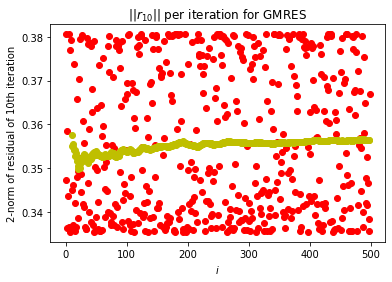

In [26]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,499):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for GMRES')

Text(0.5, 1.0, '$||r_{10}||$ per iteration for MLGMRES')

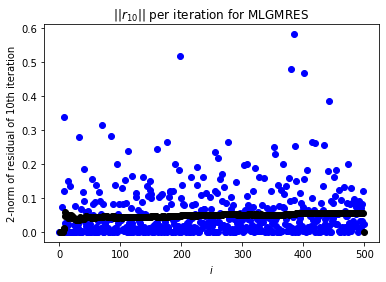

In [27]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,499):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'ok')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for MLGMRES')

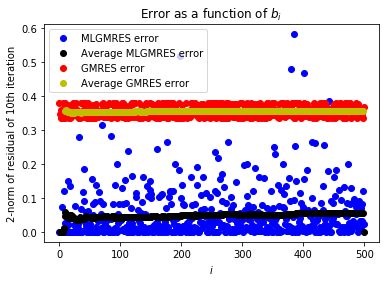

In [28]:
pp.plot(count,np.asarray(Err_Array_ML),'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,np.asarray(NonML_Err_List),'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ ')
pp.legend(loc='best')
pp.savefig('Compare_250.png')

We can compare run times:

Text(0.5, 1.0, 'GMRES Run Times.')

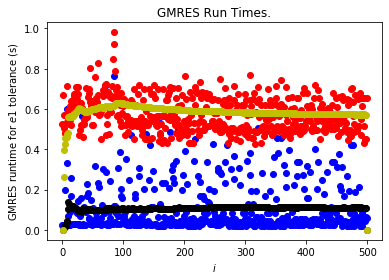

In [37]:
GmresRunTime_Array=np.asarray(Err_list)
AVG_GmresRunTime=np.zeros((500,1))

for j in range(0,499):
    AVG_GmresRunTime[j]=moving_average(np.asarray(Err_list[:j]),j)
pp.plot(count,np.asarray(Err_list),'ob',count,AVG_GmresRunTime,'ok')

NonMLGmresRunTime_Array=np.asarray(NonML_Time_List)
AVG_NonMLGmresRunTime=np.zeros((500,1))

for j in range(0,499):
    AVG_NonMLGmresRunTime[j]=moving_average(np.asarray(NonML_Time_List[:j]),j)
pp.plot(count,np.asarray(NonML_Time_List),'or',count,AVG_NonMLGmresRunTime,'oy')

pp.xlabel('$i$')
pp.ylabel('GMRES runtime for $e1$ tolerance (s)')
pp.title('GMRES Run Times.')